# Coverage of LoVoCCS clusters by existing X-ray observations

## Import Statements

In [1]:
from shutil import rmtree
import os
import pandas as pd
import numpy as np
from astropy.units import Quantity
from astropy.visualization import SqrtStretch, LogStretch
from astropy.convolution import convolve, Gaussian2DKernel, convolve_fft
from astropy.io import fits
from astropy.wcs import WCS
from tqdm import tqdm

# I am only importing XGA because it has some quite handy product classes that we can use for some
#  of the visualisations
import xga
xga.NUM_CORES = 100
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.products import Image, ExpMap, RateMap

%matplotlib inline

## Reading in the sample

Again we need the central coordinates of our clusters, as we're going to try and show how much of the region around each cluster is covered by X-ray observations - we'll also probably be using the $R_{500}$ values calculated for the MCXC catalogue, just as some indication of each cluster's physical extent (even if we don't trust it without question):

In [2]:
samp = pd.read_csv("../../sample_files/lovoccs_southnorth.csv")
samp

name          MCXC  LoVoCCSID          ra        dec  \
0    MCXCJ1558.3+2713  J1558.3+2713          0  239.585833  27.226944   
1    MCXCJ1510.9+0543  J1510.9+0543          1  227.729167   5.720000   
2    MCXCJ0258.9+1334  J0258.9+1334          2   44.739583  13.579444   
3    MCXCJ1348.8+2635  J1348.8+2635          3  207.220833  26.595556   
4    MCXCJ0041.8-0918  J0041.8-0918          4   10.458750  -9.301944   
..                ...           ...        ...         ...        ...   
139  MCXCJ0448.2-2028  J0448.2-2028        139   72.050833 -20.469722   
140  MCXCJ2323.8+1648  J2323.8+1648        140  350.972917  16.808889   
141  MCXCJ1416.8-1158  J1416.8-1158        141  214.214583 -11.976111   
142  MCXCJ1459.0-0843  J1459.0-0843        142  224.764583  -8.725000   
143  MCXCJ0041.7+2124  J0041.7+2124        143   10.446250  21.413889   

     redshift       L500    M500    R500         alt_name other_names  \
0      0.0894  10.676087  8.1491  1.3803  RXCJ1558.3+2713       A2142   
1      0.0766   8.726709  7.2708  1.3344            A2029       A2029   
2      0.0739   6.088643  5.8488  1.2421  RXCJ0258.9+1334        A401   
3      0.0622   5.478067  5.5280  1.2236  RXCJ1348.8+2635       A1795   
4      0.0555   5.100085  5.3163  1.2103  RXCJ0041.8-0918         A85   
..        ...        ...     ...     ...              ...         ...   
139    0.0720   1.004022  1.9513  0.8620  RXCJ0448.2-2028        A514   
140    0.0416   1.002026  1.9896  0.8760            A2589       A2589   
141    0.0982   1.001648  1.9133  0.8491  RXCJ1416.8-1158         NaN   
142    0.1043   1.001337  1.9047  0.8461  RXCJ1459.0-0843         NaN   
143    0.1014   1.000012  1.9071  0.8473  RXCJ0041.7+2124         A84   

        Notes  
0           L  
1         NaN  
2           L  
3         NaN  
4    L,losStr  
..        ...  
139    losStr  
140       NaN  
141         X  
142       NaN  
143       NaN  

[144 rows x 12 columns]

## Setting up XGA products to act as detector maps

We will assess the coverage of each cluster by setting up an RA-Dec coordinate space centered on the MCXC coordinate, with some size relevant to our analysis, and then for each 'pixel' of this coordinate space determing which observations have a non-zero value there.

This method is best performed with exposure maps, as they can be relied upon to have non-zero values everywhere there is a detector, but exposure maps are not immediately available (without further processing which DAXA does not yet support) for all of our missions. In those cases we will smooth the available images, enough so that the likelihood of zero-value pixels is greatly reduced but that the fundamental shape of the image does not change too much - this will approximate a detector map and can be used to get a good-enough idea of the coverage.

**Note that we will not assess the coverage of ROSAT All-Sky, as we already know how much that covers...**

<span style="color:red"> We cannot assess eROSITA Calibration and Performance Verification coverage yet, as I haven't generated images </span>

First of all we set up variables that will be used throughout this section:

In [3]:
# Whatever product is to be used as the 'detector map' will be stored here - in each loop I do actually reset the 
#  entries for the relevant mission, to avoid accidentally appending duplicates by running multiple times, but I 
#  define here just for clarity
det_maps = {'xmm_pointed': [],
            'chandra': [],
            'rosat_pointed_pspc': [],
            'rosat_pointed_hri': [],
            'nustar_pointed': []}

# Just an integer to define the number of missions we are dealing with, used for setting up the array
#  that stores the coverage information 
num_miss = len(det_maps)

# The names to use for the missions when making coverage map visualisations
pretty_names = {'xmm_pointed': 'XMM-Newton', 
                'chandra': 'Chandra',
                'rosat_pointed_pspc': 'ROSAT Pointed PSPC', 
                'rosat_pointed_hri': 'ROSAT Pointed HRI',
                'nustar_pointed': 'NuSTAR'}

out_dir = '../../outputs/coverage_maps/visualisations/'
# Now we'll make sure that the directory to store visualisations of the coverage maps has been created
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

### Missions with exposure maps

This is the easier case, where we will just load in exposure maps as XGA exposure map products.

#### XMM-Newton

We know that XMM observations have exposure maps, because they have been fully processed by DAXA - as such we will just use them as the detector maps we need for this process. 

Here we define some useful paths:

In [4]:
xmm_path = "../../data/archives/LoVoCCS/processed_data/xmm_pointed/"
xmm_ex_path = xmm_path + "{oi}/images/{oi}_{i}_0.5-2.0keVexpmap.fits"

xmm_obs_ids = [fp for fp in os.listdir(xmm_path) if len(fp) == 10]

In [5]:
# Reset the det_maps entry for this mission to ensure that duplicates aren't appended by running this cell 
#  multiple times 
if len(det_maps['xmm_pointed']) != 0:
    det_maps['xmm_pointed'] = []

# Then simply iterate through the ObsIDs, and the possible instruments
for oi in xmm_obs_ids:
    # Possible some observations won't have all three EPIC exposure maps, but checking if the exposure map is 
    #  usable will catch if the file path does not exist
    for inst in ['pn', 'mos1', 'mos2']:
        cur_ex = ExpMap(xmm_ex_path.format(oi=oi, i=inst), oi, inst, '', '', '', Quantity(0.5, 'keV'), 
                       Quantity(2.0, 'keV'))
        if cur_ex.usable:
            # As the ObsID and instrument are contained within the XGA exposure map product, I don't need
            #  to do anything fancy in terms of storing them in our det_maps dictionary - just put them in the
            #  right mission section and append to the list I created there
            det_maps['xmm_pointed'].append(cur_ex)

#### ROSAT Pointed PSPC

Some of the ROSAT pointed observations have exposure maps that are downloadable from the online archive, specifically the observations taken with PSPC detectors (HRI can have exposure maps generated for it but for some reason they are not present in the online archive so far as I can tell). As such we will load in the PSPC exposure maps for _**pointed**_ ROSAT observations here, and deal with HRI in the next section.

Defining some useful paths:

In [6]:
rosp_path = "../../data/rosat_pointed_raw/"
rosp_ex_path = rosp_path + "{oi}/{oi_l}_mex.fits"

rosp_obs_ids = [fp for fp in os.listdir(rosp_path)]

In [7]:
# Reset the det_maps entry for this mission to ensure that duplicates aren't appended by running this cell 
#  multiple times 
if len(det_maps['rosat_pointed_pspc']) != 0:
    det_maps['rosat_pointed_pspc'] = []
    
for oi in rosp_obs_ids:
    # No instruments to iterate through in this case, we're only dealing with PSPC. Note that we're not checking
    #  what instrument a particular ObsID is for, that is because we're letting the 'usable' check below catch
    #  HRI ObsIDs, as the path to the exposure map won't exist!
    cur_ex = ExpMap(rosp_ex_path.format(oi=oi, oi_l=oi.lower(), en=2), oi, 'PSPC', '', '', '', Quantity(0.4, 'keV'), 
                    Quantity(2.4, 'keV'))
    
    # This effectively excludes the HRI ObsIDs, as the exposure map path we constructed will not have existed, and
    #  the product will not be usable
    if cur_ex.usable:
        det_maps['rosat_pointed_pspc'].append(cur_ex)

### Missions _without_ exposure maps

In all these cases exposure maps could be generated, but simply haven't been included in the online archives that DAXA can download pre-generated products from. As we have not yet implemented DAXA support for processing those missions, and backend software is required to generate exposure maps, we will not use exposure maps as detector maps in these cases; instead we will get creative.

The chief requirement is that every pixel that falls on a detector has a non-zero value - that way it can be polled to check whether a particlar coordinate is on a detector. The images that **are** included in the online archives that DAXA can download from will be made to fulfill this requirement through smoothing.

Obviously this has the caveat that the edges of the image will likely be made to extend past the edge of where the detector actually is, but it will be sufficiently accurate for our purposes.

First we set up the smoothing standard deviations for each of the missions, though it is possible they will all stay the same value:

In [8]:
chandra_smooth_stdev = 5
# What a dreadful variable name..
rosat_pointed_hri_smooth_stdev = 4
nustar_smooth_stdev = 5

#### Chandra

In [9]:
ch_path = "../../data/chandra_raw/"
ch_dat_path = ch_path + "{oi}/primary/"
ch_im_path = ch_path + "{oi}/primary/{im_f}"

ch_obs_ids = [fp for fp in os.listdir(ch_path)]

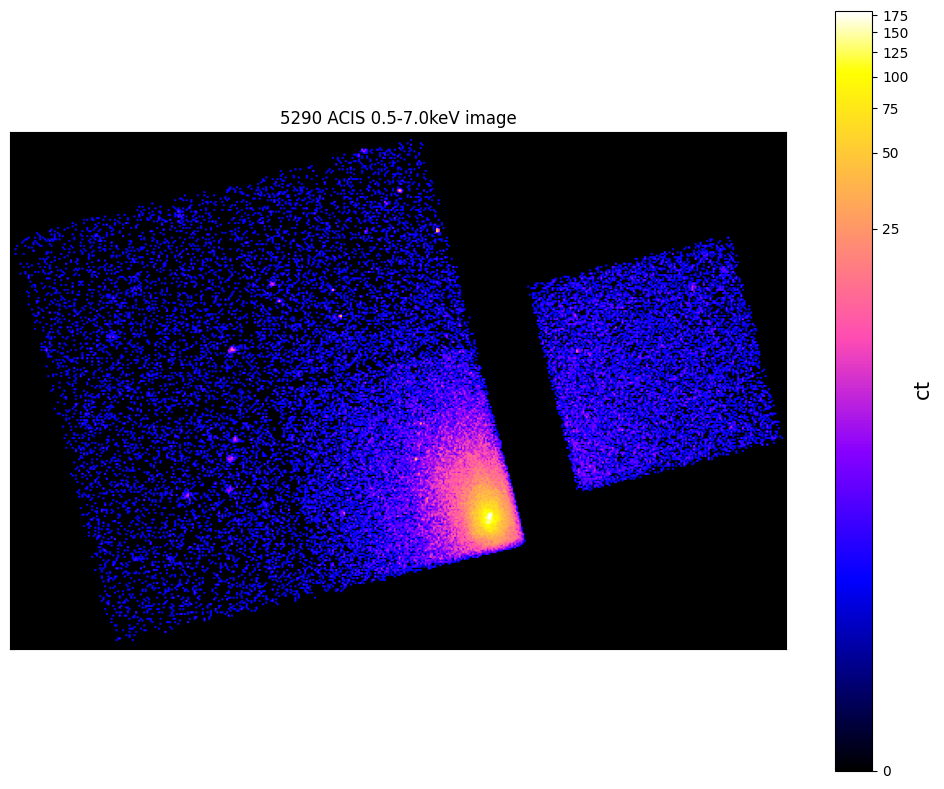

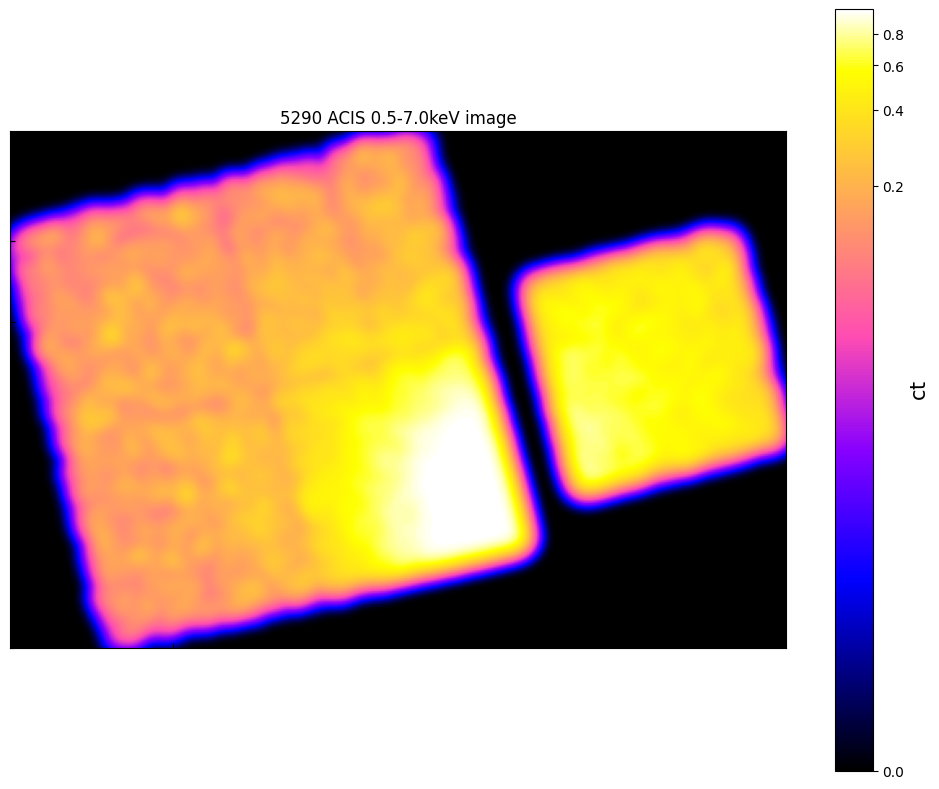

In [10]:
# Reset the det_maps entry for this mission to ensure that duplicates aren't appended by running this cell 
#  multiple times 
if len(det_maps['chandra']) != 0:
    det_maps['chandra'] = []

# As this isn't as simple as just loading in an exposure map, I do want to show a demonstration of what I am doing
#  to each image - this flag will flip after the first visualisation, so that only one pair of before and after
#  images appear, that way we avoid the notebook getting too large
show_vis = True
for oi in ch_obs_ids:
    # Setting up the path to the Chandra image file
    cur_im_path = ch_im_path.format(oi=oi, im_f=[f for f in os.listdir(ch_dat_path.format(oi=oi)) 
                                                 if 'full_img2' in f][0])
    inst = 'ACIS' if 'acis' in cur_im_path else 'HRC'
    
    # Setting up the actual XGA image product
    cur_im = Image(cur_im_path, oi, inst, '', '', '', Quantity(0.5, 'keV'), Quantity(7.0, 'keV'))
    
    # This effectively is just checking that there is nothing wrong with the product, like the file path
    #  not existing - very unlikely here
    if cur_im.usable:
        
        # If we're on the first ObsID then show_vis will be True, and this will show a visualisation of the 
        #  image as it is now
        if show_vis:
            cur_im.view()
        
        # Set up an array of zeros in the same shape as the original image
        det_dat = np.zeros(cur_im.shape)
        # Then that array is set to one everywhere that there is a non-zero value in the image. Obviously this
        #  will be full of zero value pixels even where it is on the detector, but I've found that smoothing this
        #  achieves better results than smoothing the image directly - this is because if a large extended emission
        #  is near the edge of the detector it can really bias the smoothing and alter the shape of the 
        #  'detector map' significantly, which we are trying to avoid
        det_dat[np.where(cur_im.data != 0)] = 1
        
        # Smooth the det map data with a round 2D Gaussian, standard devation set at the top of this section
        sm_data = convolve_fft(det_dat, Gaussian2DKernel(chandra_smooth_stdev), normalize_kernel=True)
        # Then replace the image's data with the smooth detector map data - now we can use the XGA coordinate
        #  conversion interface to determine which pixels are on a detector (approximately), just as we can
        #  with the exposure maps
        cur_im.data = sm_data
        
        # For context we show the final smoothed 'detector map' for the first ObsID
        if show_vis:
            cur_im.view()
            # This ensure no subsequent ObsIDs will have visualisations shown, keeping the notebook small enough
            show_vis = False
        
        # Finally make sure to actually store the 'detector map' we've created
        det_maps['chandra'].append(cur_im)

#### ROSAT Pointed HRI

In [11]:
rosp_path = "../../data/rosat_pointed_raw/"
rosp_im_path = rosp_path + "{oi}/{oi_l}_im1.fits"
# This is only included so that we can check it DOESN'T exist, because that means we need to do this method
#  with image smoothing
rosp_ex_path = rosp_path + "{oi}/{oi_l}_mex.fits"

rosp_obs_ids = [fp for fp in os.listdir(rosp_path)]

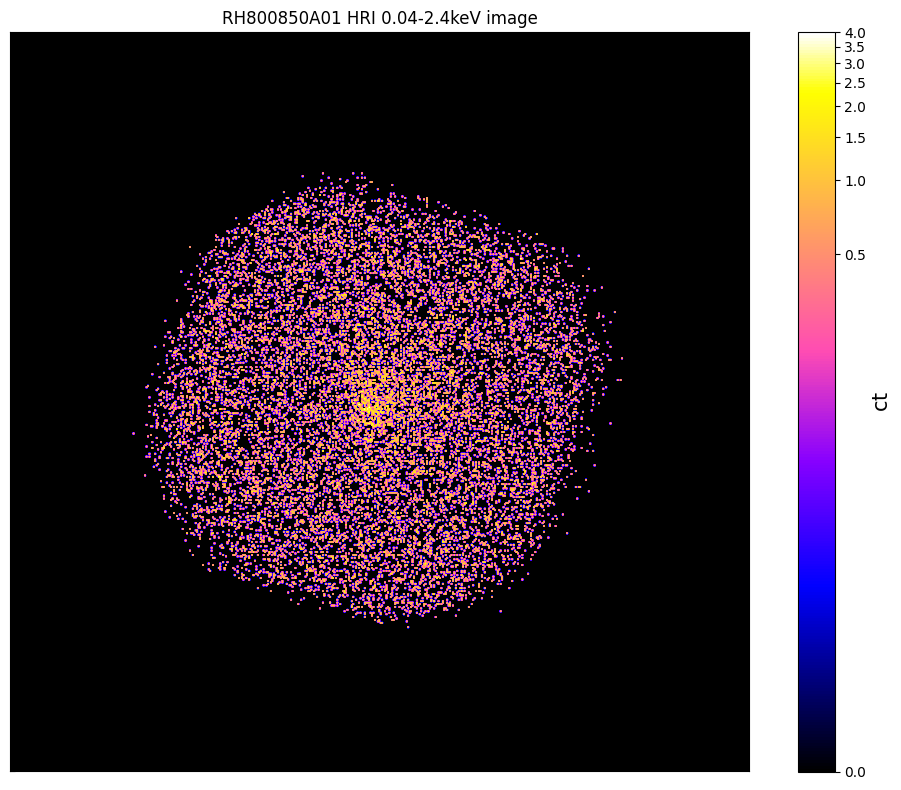

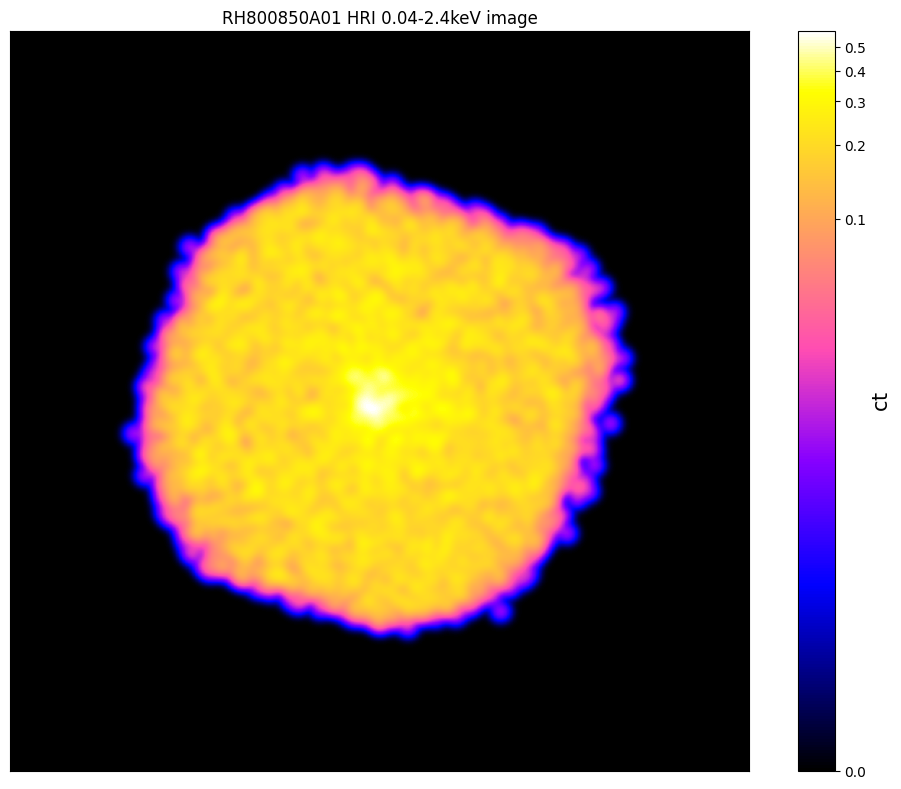

In [12]:
# Reset the det_maps entry for this mission to ensure that duplicates aren't appended by running this cell 
#  multiple times 
if len(det_maps['rosat_pointed_hri']) != 0:
    det_maps['rosat_pointed_hri'] = []

# As this isn't as simple as just loading in an exposure map, I do want to show a demonstration of what I am doing
#  to each image - this flag will flip after the first visualisation, so that only one pair of before and after
#  images appear, that way we avoid the notebook getting too large
show_vis = True
for oi in rosp_obs_ids:
    
    # If an exposure map DOES exist for this ObsID, then it is a PSPC observation and we've already dealt
    #  with it in an earlier part of the notebook, so we just go to the next ObsID in the loop
    if os.path.exists(rosp_ex_path.format(oi=oi, oi_l=oi.lower(), en=2)):
        continue
    
    # Setting up the path to the ROSAT HRI image file
    cur_im_path = rosp_im_path.format(oi=oi, oi_l=oi.lower())
    
    
    # Setting up the actual XGA image product
    cur_im = Image(cur_im_path, oi, 'HRI', '', '', '', Quantity(0.04, 'keV'), Quantity(2.4, 'keV'))
    
    # This effectively is just checking that there is nothing wrong with the product, like the file path
    #  not existing - very unlikely here
    if cur_im.usable:
        
        # If we're on the first ObsID then show_vis will be True, and this will show a visualisation of the 
        #  image as it is now
        if show_vis:
            cur_im.view()
        
        # Set up an array of zeros in the same shape as the original image
        det_dat = np.zeros(cur_im.shape)
        # Then that array is set to one everywhere that there is a non-zero value in the image. Obviously this
        #  will be full of zero value pixels even where it is on the detector, but I've found that smoothing this
        #  achieves better results than smoothing the image directly - this is because if a large extended emission
        #  is near the edge of the detector it can really bias the smoothing and alter the shape of the 
        #  'detector map' significantly, which we are trying to avoid
        det_dat[np.where(cur_im.data != 0)] = 1
        
        # Smooth the det map data with a round 2D Gaussian, standard devation set at the top of this section
        sm_data = convolve_fft(det_dat, Gaussian2DKernel(rosat_pointed_hri_smooth_stdev), normalize_kernel=True)
        # Then replace the image's data with the smooth detector map data - now we can use the XGA coordinate
        #  conversion interface to determine which pixels are on a detector (approximately), just as we can
        #  with the exposure maps
        cur_im.data = sm_data
        
        # For context we show the final smoothed 'detector map' for the first ObsID
        if show_vis:
            cur_im.view()
            # This ensure no subsequent ObsIDs will have visualisations shown, keeping the notebook small enough
            show_vis = False
        
        # Finally make sure to actually store the 'detector map' we've created
        det_maps['rosat_pointed_hri'].append(cur_im)

#### NuSTAR

In [13]:
nu_path = "../../data/nustar_pointed_raw/"
nu_im_path = nu_path + "{oi}/event_cl/nu{oi}{i}01_sk.img.gz"

nu_obs_ids = [fp for fp in os.listdir(nu_path)]

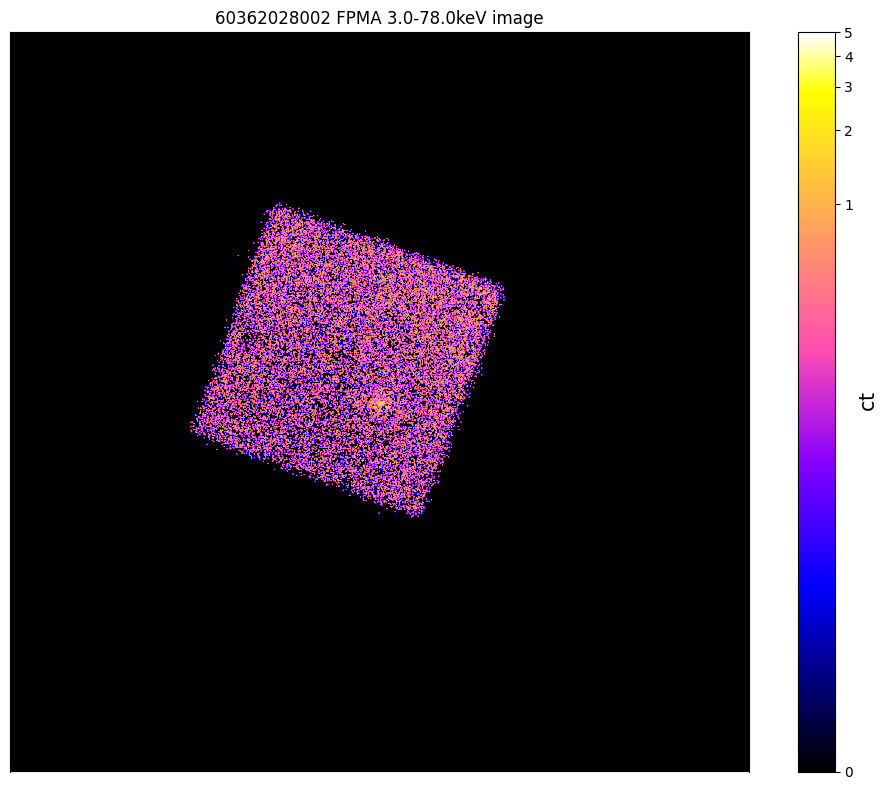

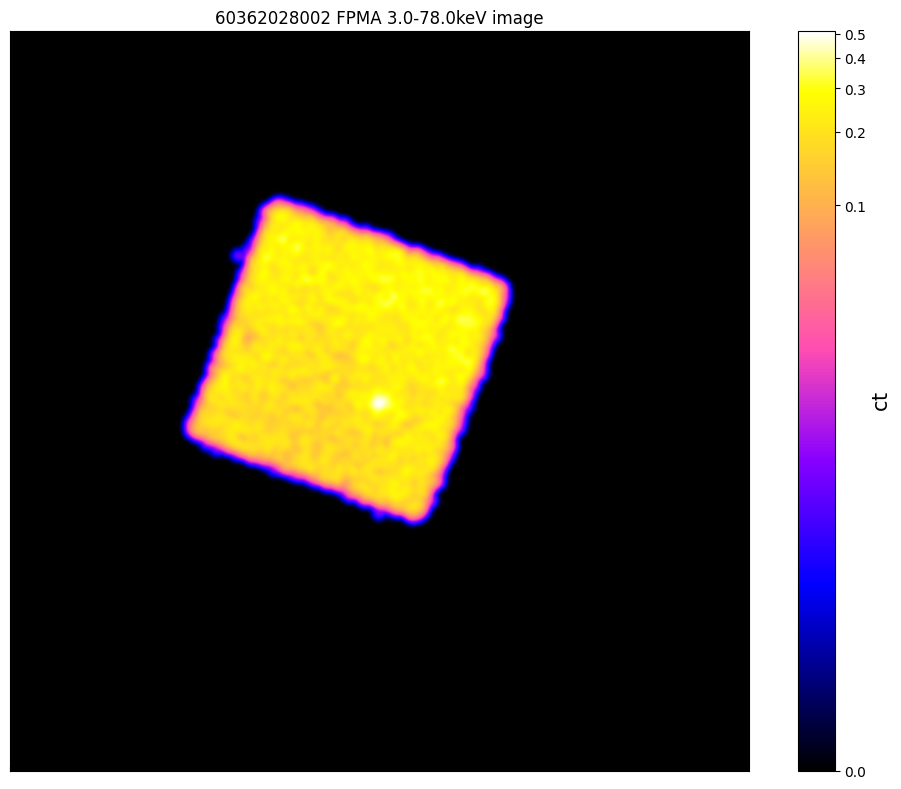

In [14]:
# Reset the det_maps entry for this mission to ensure that duplicates aren't appended by running this cell 
#  multiple times 
if len(det_maps['nustar_pointed']) != 0:
    det_maps['nustar_pointed'] = []

# As this isn't as simple as just loading in an exposure map, I do want to show a demonstration of what I am doing
#  to each image - this flag will flip after the first visualisation, so that only one pair of before and after
#  images appear, that way we avoid the notebook getting too large
show_vis = True
for oi in nu_obs_ids:
    for inst in ['FPMA', 'FPMB']:
        cur_im = Image(nu_im_path.format(oi=oi, i=inst[-1]), oi, inst, '', '', '', Quantity(3.0, 'keV'), 
                       Quantity(78.0, 'keV'))

        if cur_im.usable:
            # If we're on the first ObsID then show_vis will be True, and this will show a visualisation of the 
            #  image as it is now
            if show_vis:
                cur_im.view()

            # Set up an array of zeros in the same shape as the original image
            det_dat = np.zeros(cur_im.shape)
            # Then that array is set to one everywhere that there is a non-zero value in the image. Obviously this
            #  will be full of zero value pixels even where it is on the detector, but I've found that smoothing 
            #  this achieves better results than smoothing the image directly - this is because if a large 
            #  extended emission is near the edge of the detector it can really bias the smoothing and alter the 
            #  shape of the 'detector map' significantly, which we are trying to avoid
            det_dat[np.where(cur_im.data != 0)] = 1

            # Smooth the det map data with a round 2D Gaussian, standard devation set at the top of this section
            sm_data = convolve_fft(det_dat, Gaussian2DKernel(nustar_smooth_stdev), normalize_kernel=True)
            # Then replace the image's data with the smooth detector map data - now we can use the XGA coordinate
            #  conversion interface to determine which pixels are on a detector (approximately), just as we can
            #  with the exposure maps
            cur_im.data = sm_data

            # For context we show the final smoothed 'detector map' for the first ObsID
            if show_vis:
                cur_im.view()
                # This ensure no subsequent ObsIDs will have visualisations shown, keeping the notebook 
                #  small enough
                show_vis = False

            # Finally make sure to actually store the 'detector map' we've created
            det_maps['nustar_pointed'].append(cur_im)
        

## Setting up coordinate spaces around the LoVoCCS clusters

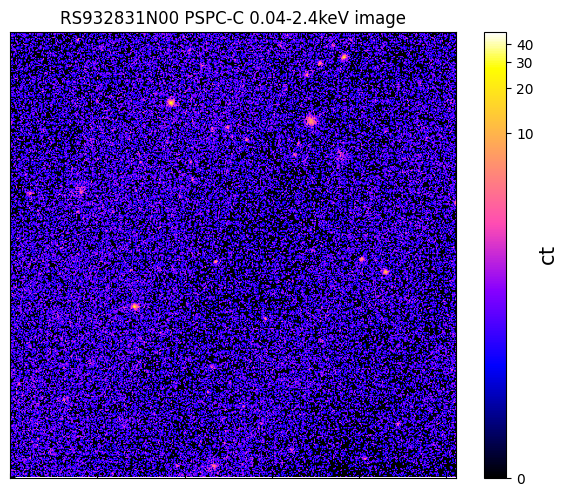

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 332.727234  -61.875  
CRPIX : 256.516663  256.516663  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0125000002  0.0125000002  
NAXIS : 0  0

In [15]:
test_im = Image('../../data/rosat_all_sky_raw/RS932831N00/rs932831n00_im1.fits', 'RS932831N00', 'PSPC-C', '', '', 
                '', Quantity(0.04, 'keV'), Quantity(2.4, 'keV'))
test_im.view(figsize=(6, 5))
test_im.radec_wcs

In [16]:
cdelt = Quantity(4.35, 'arcsec').to('deg')
cdelt = Quantity(10, 'arcsec').to('deg')
cdelt = Quantity(20, 'arcsec').to('deg')

cdelt

<Quantity 0.00555556 deg>

In [17]:
num_pix = 1100
num_pix = 550

num_pix*cdelt

<Quantity 3.05555556 deg>

In [18]:
coverage_maps = {"LoVoCCS-"+str(lov_id): {'arr': None, 'wcs': None} for lov_id in samp['LoVoCCSID'].values}

for row_ind, row in samp.iterrows():
    cur_wcs = WCS(naxis=2)
    cur_wcs.wcs.cdelt = [-1*cdelt.value, cdelt.value]
    cur_wcs.wcs.crpix = [num_pix/2, num_pix/2]
    cur_wcs.wcs.crval = [row['ra'], row['dec']]
    
    coverage_maps['LoVoCCS-'+str(row['LoVoCCSID'])]['wcs'] = cur_wcs
    
    cur_cov = np.zeros((num_pix, num_pix, num_miss))
    coverage_maps['LoVoCCS-'+str(row['LoVoCCSID'])]['arr'] = cur_cov


## Determining X-ray mission coverage of LoVoCCS clusters

In [19]:
from matplotlib import pyplot as plt

Generating coverage maps:   0%|          | 0/144 [00:00<?, ?it/s]

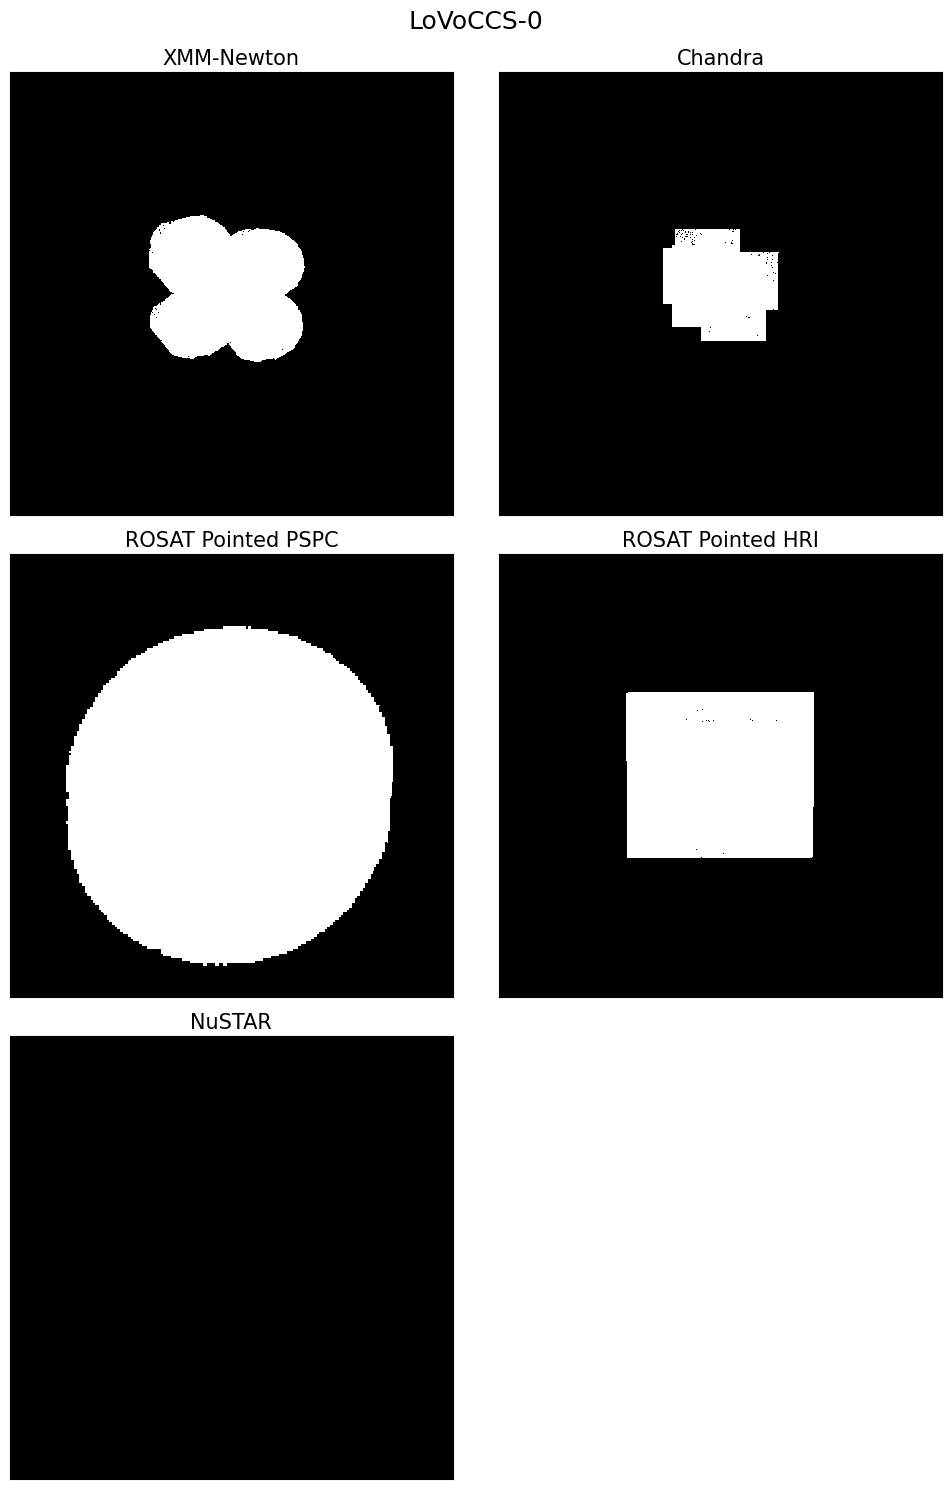

Generating coverage maps:   1%|          | 1/144 [00:22<52:34, 22.06s/it]

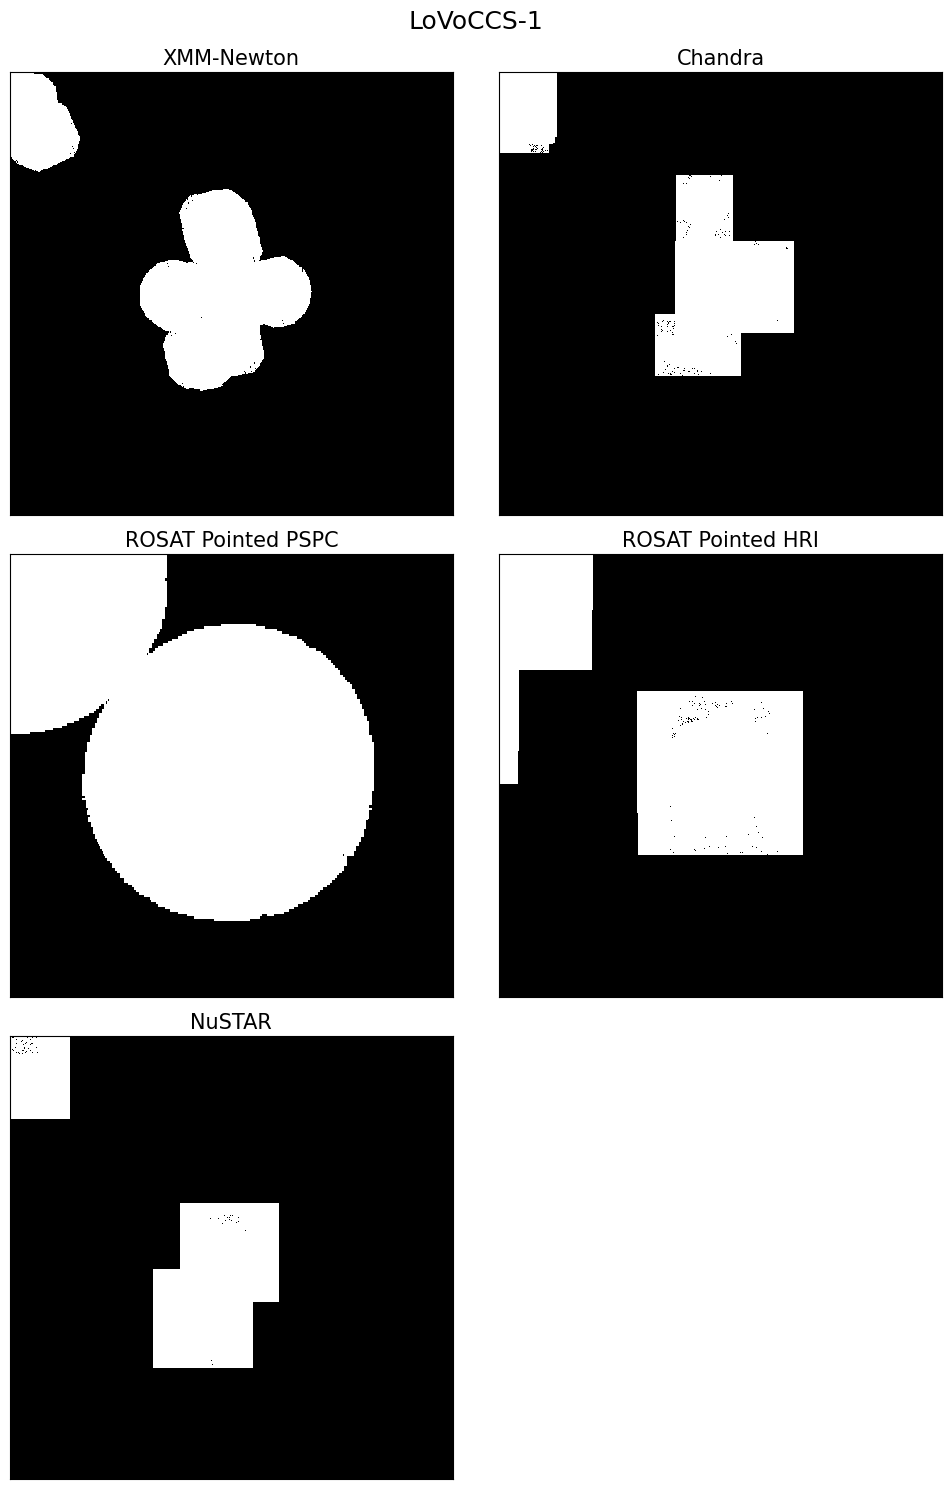

Generating coverage maps:   1%|▏         | 2/144 [00:31<34:05, 14.40s/it]

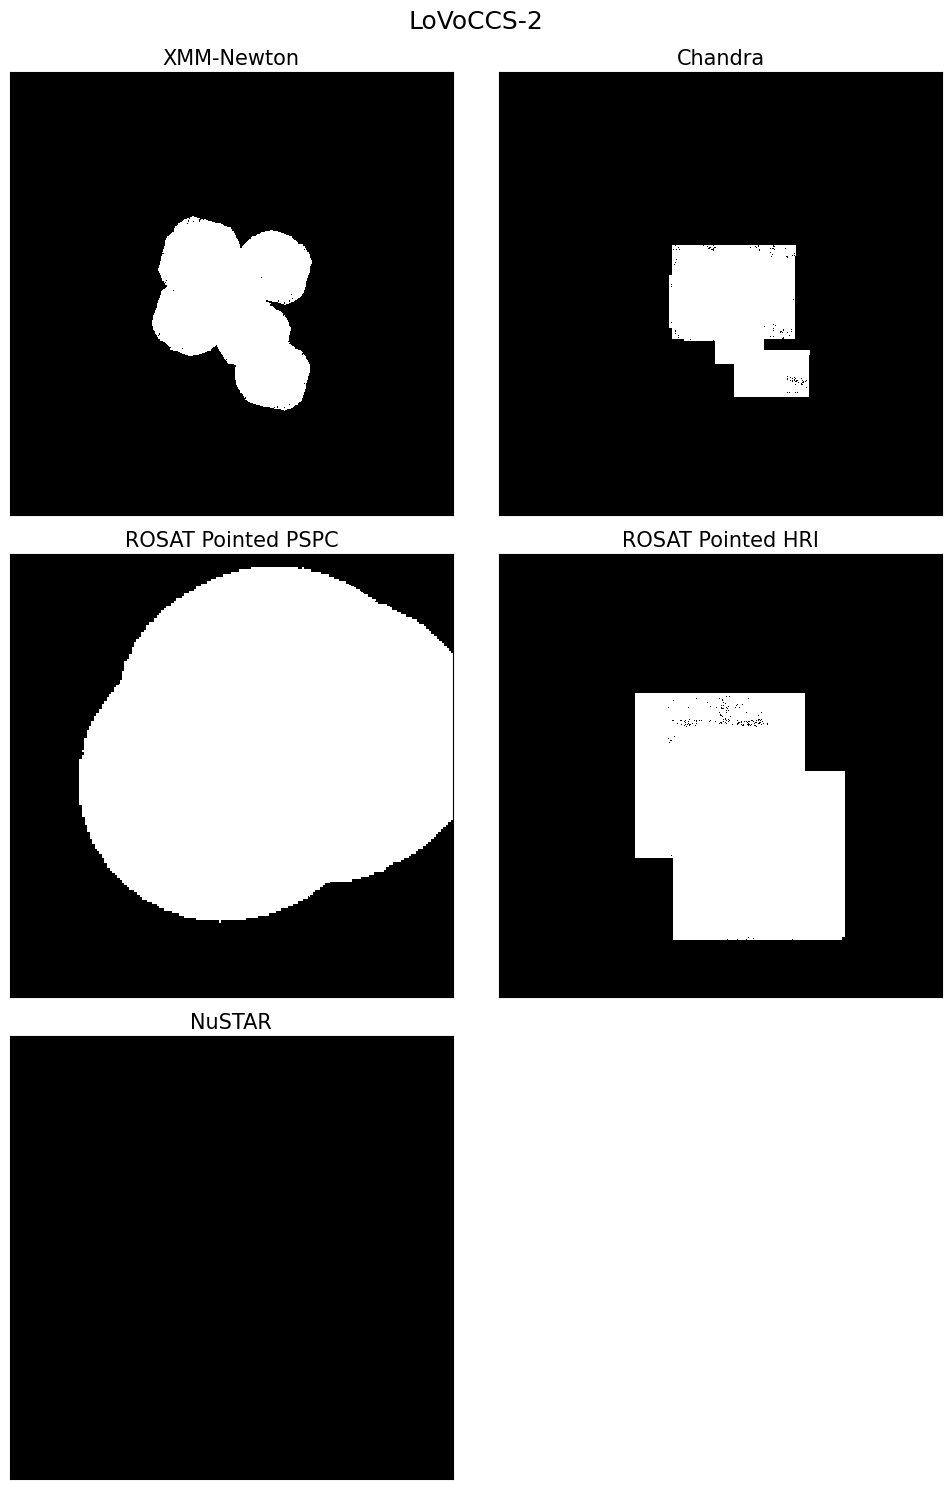

Generating coverage maps:   2%|▏         | 3/144 [00:34<22:33,  9.60s/it]

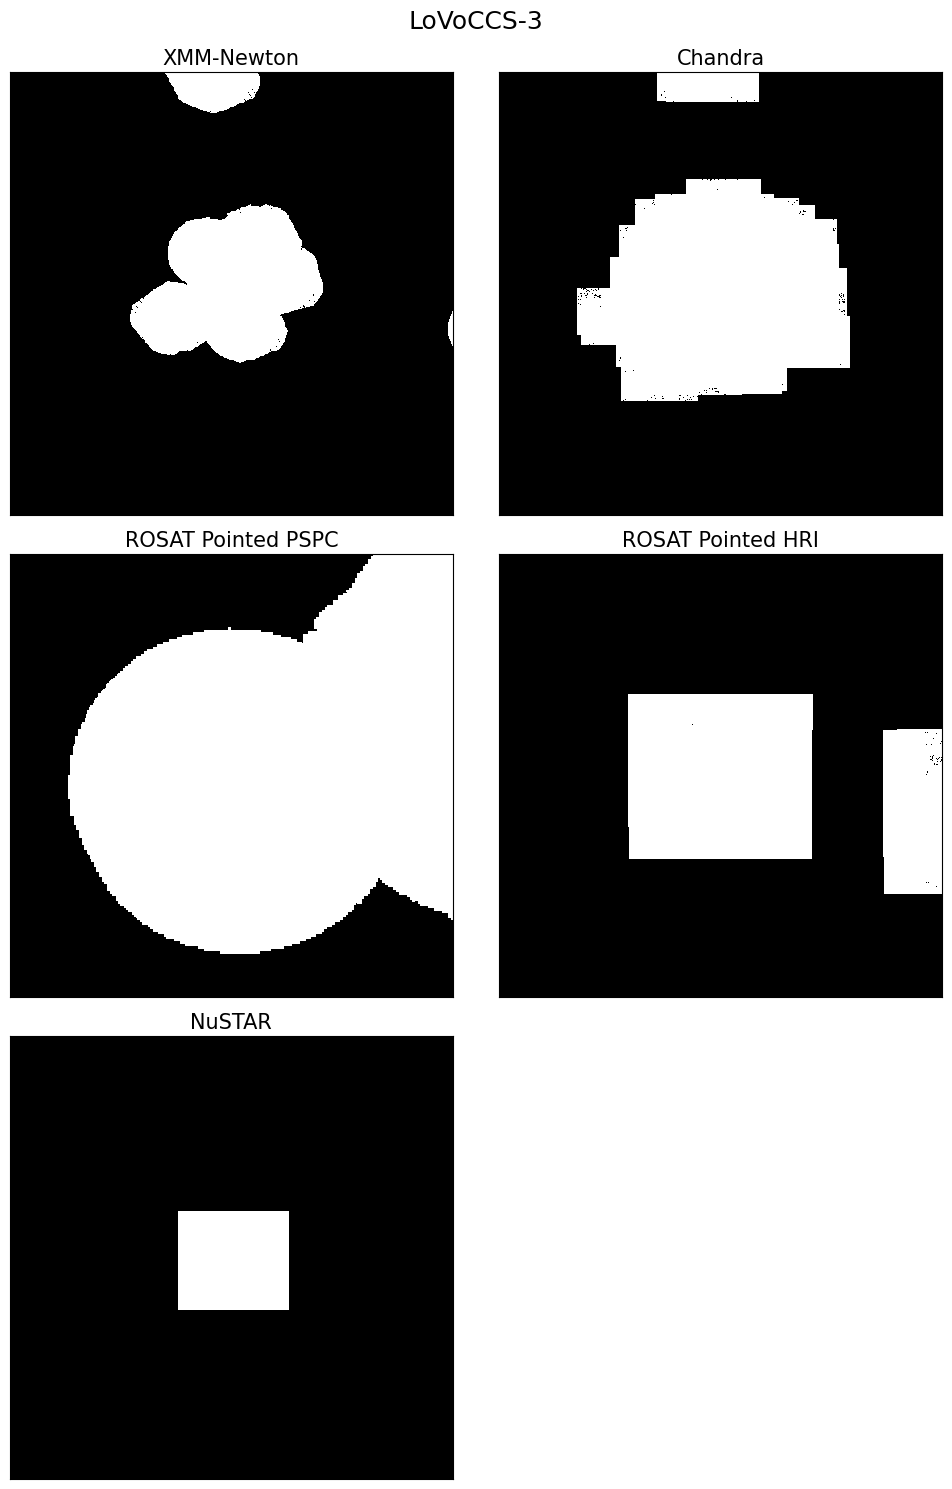

Generating coverage maps:   3%|▎         | 4/144 [00:54<31:19, 13.42s/it]

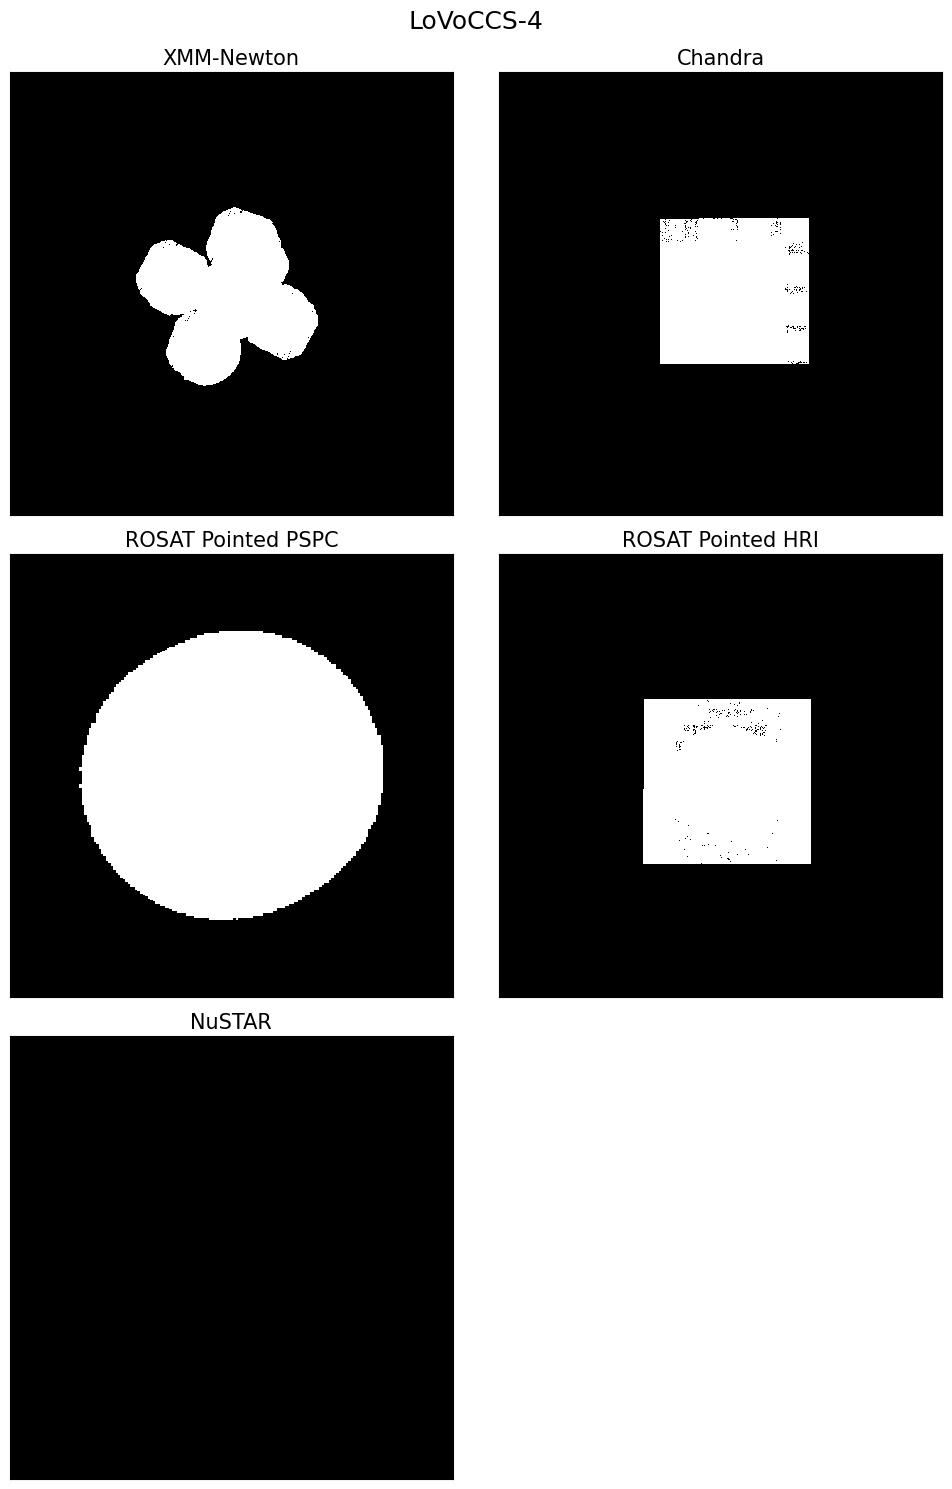

Generating coverage maps:   3%|▎         | 5/144 [00:57<22:55,  9.89s/it]

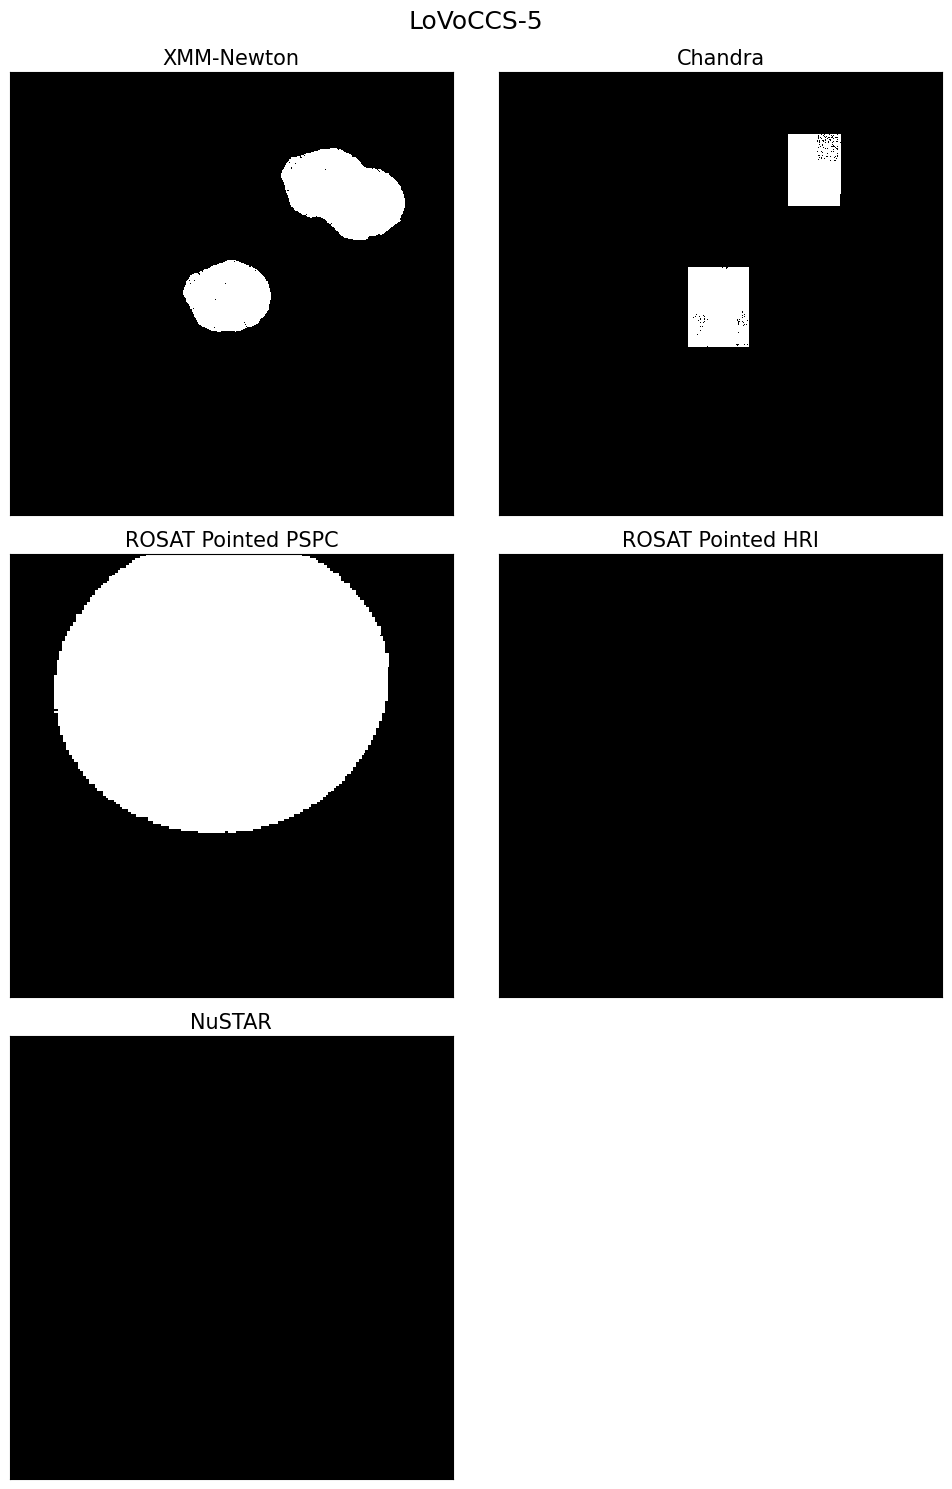

Generating coverage maps:   4%|▍         | 6/144 [01:00<17:12,  7.48s/it]

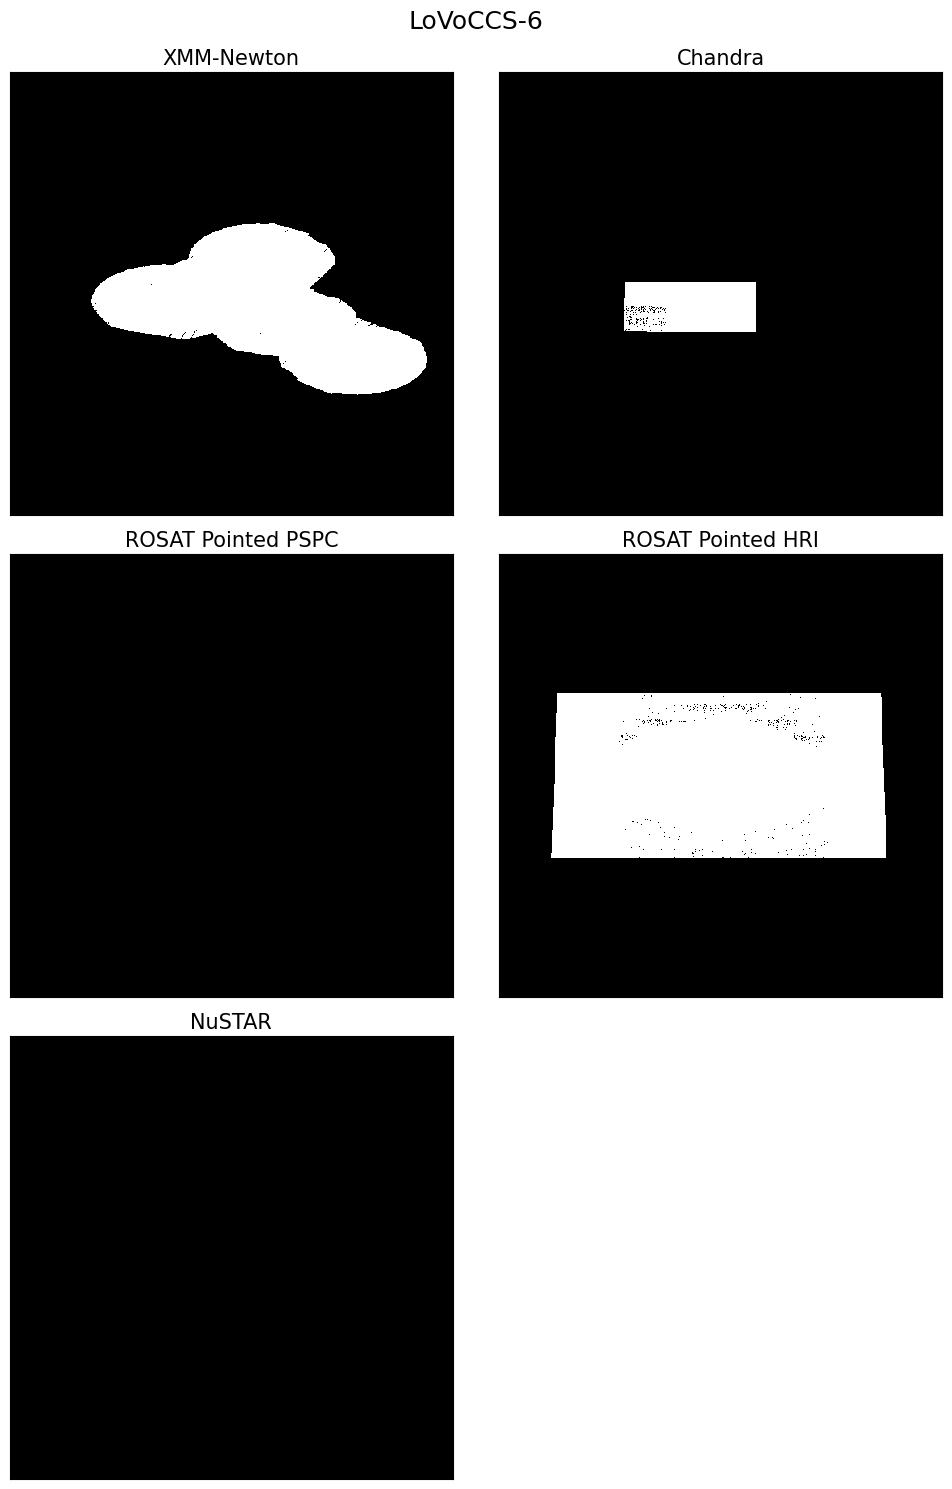

Generating coverage maps:   5%|▍         | 7/144 [01:03<13:22,  5.86s/it]

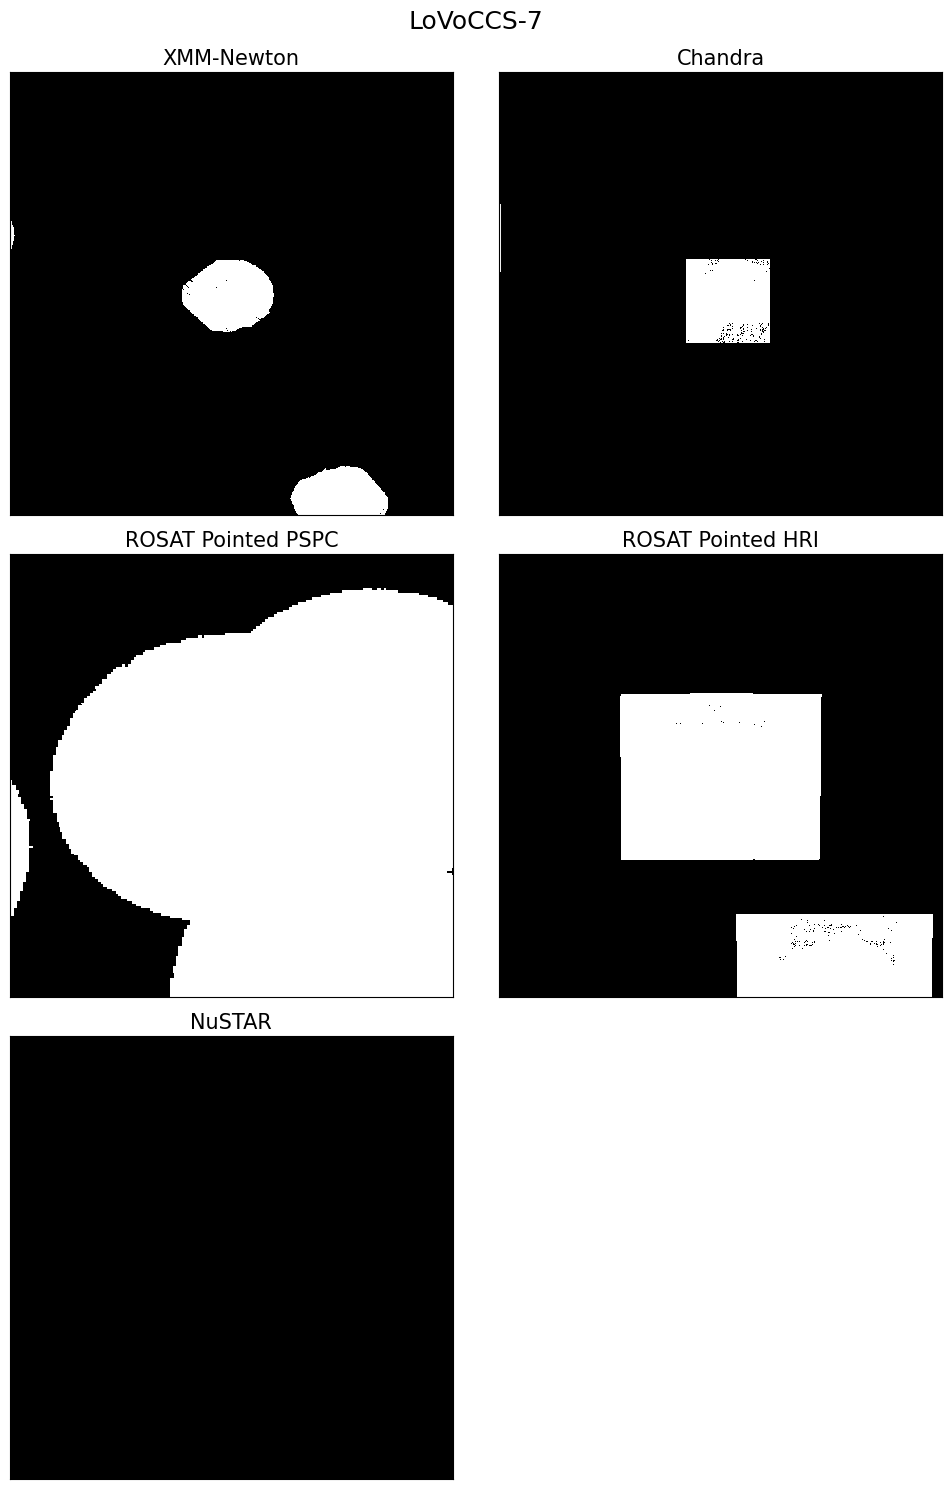

Generating coverage maps:   6%|▌         | 8/144 [01:05<11:03,  4.88s/it]

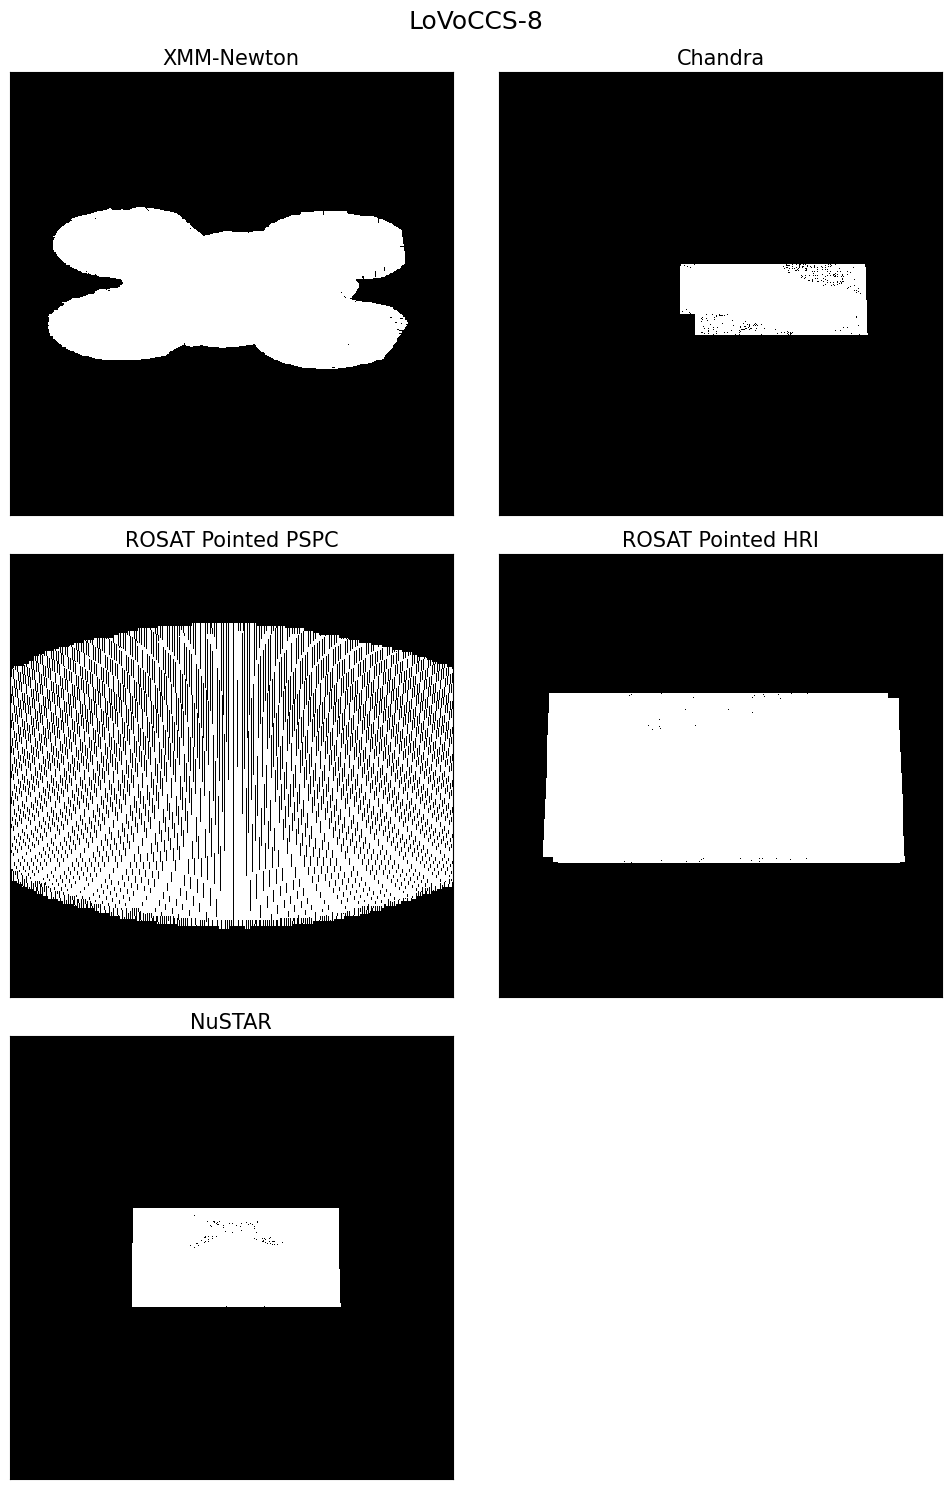

Generating coverage maps:   6%|▋         | 9/144 [01:10<10:40,  4.74s/it]

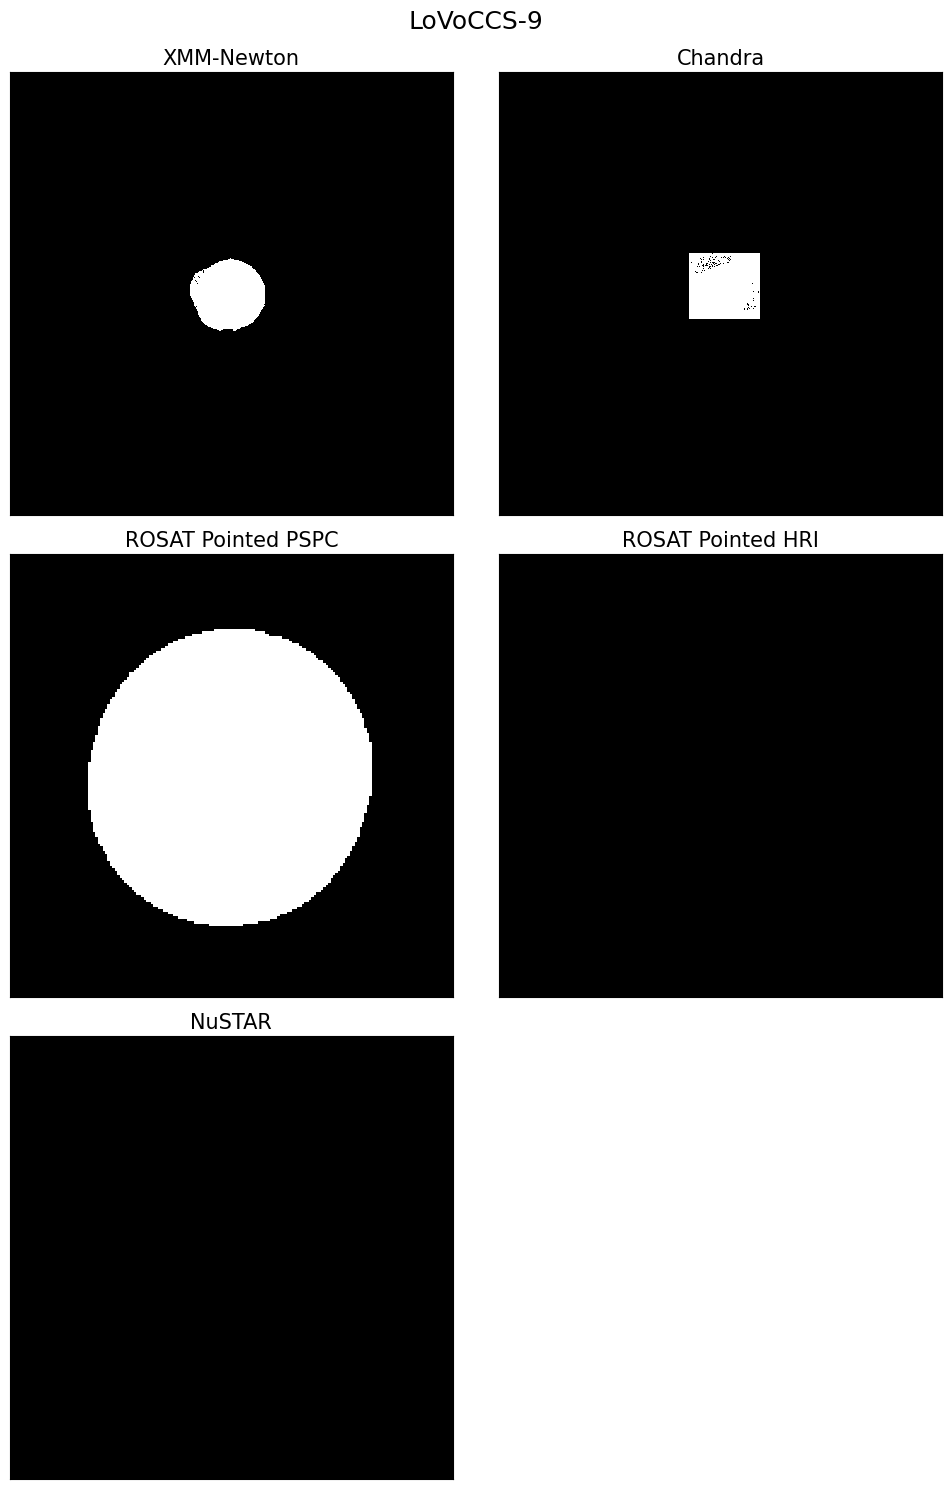

Generating coverage maps:   7%|▋         | 10/144 [01:12<08:51,  3.96s/it]

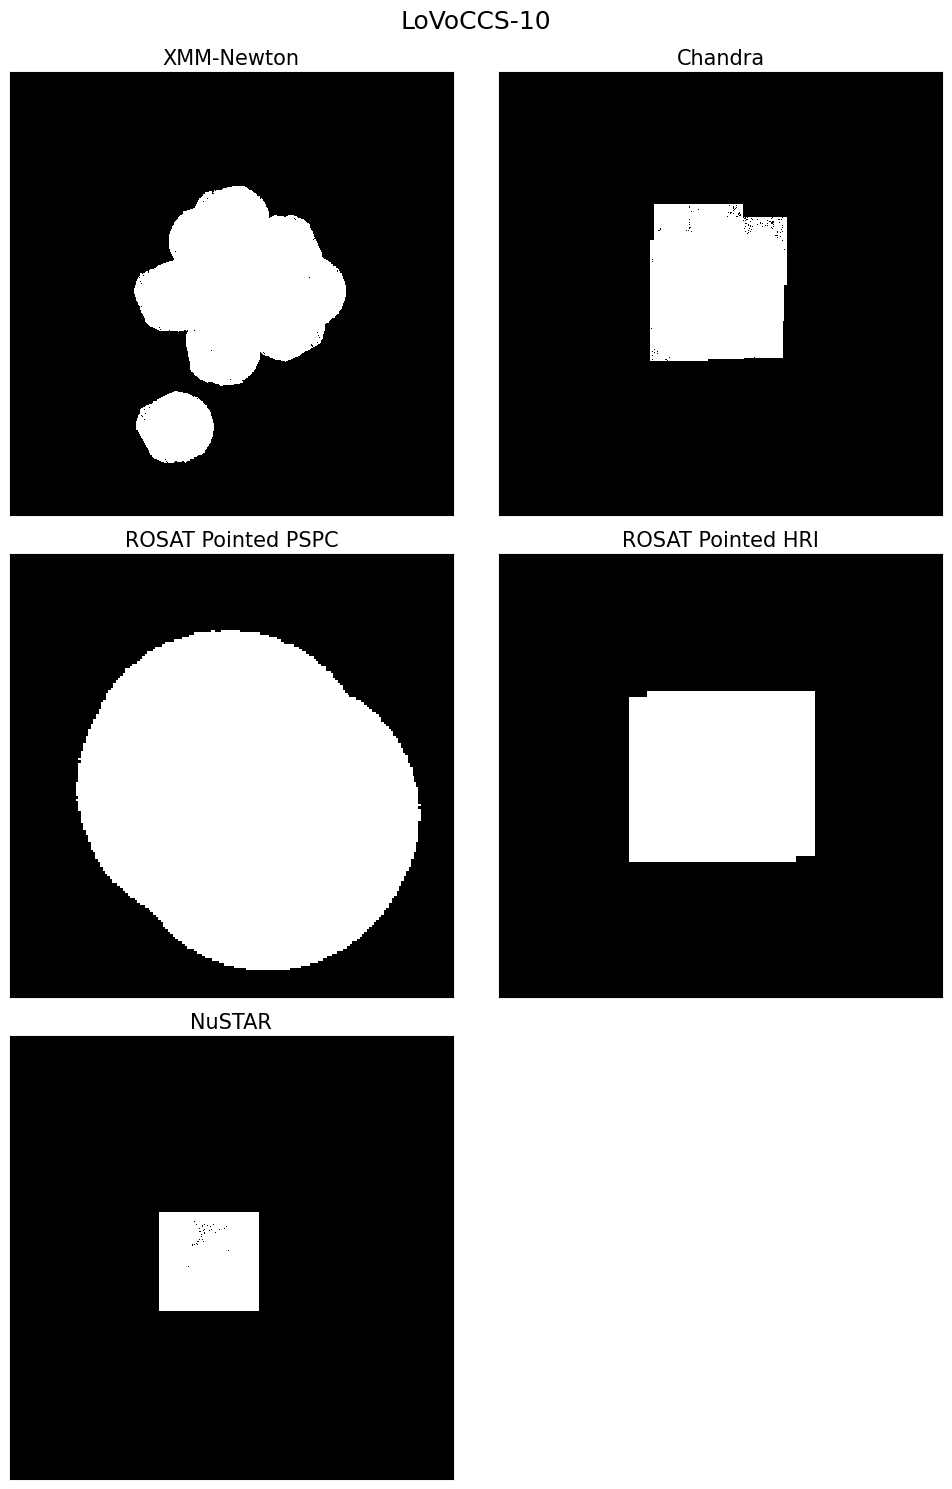

Generating coverage maps:   8%|▊         | 11/144 [01:21<11:45,  5.31s/it]

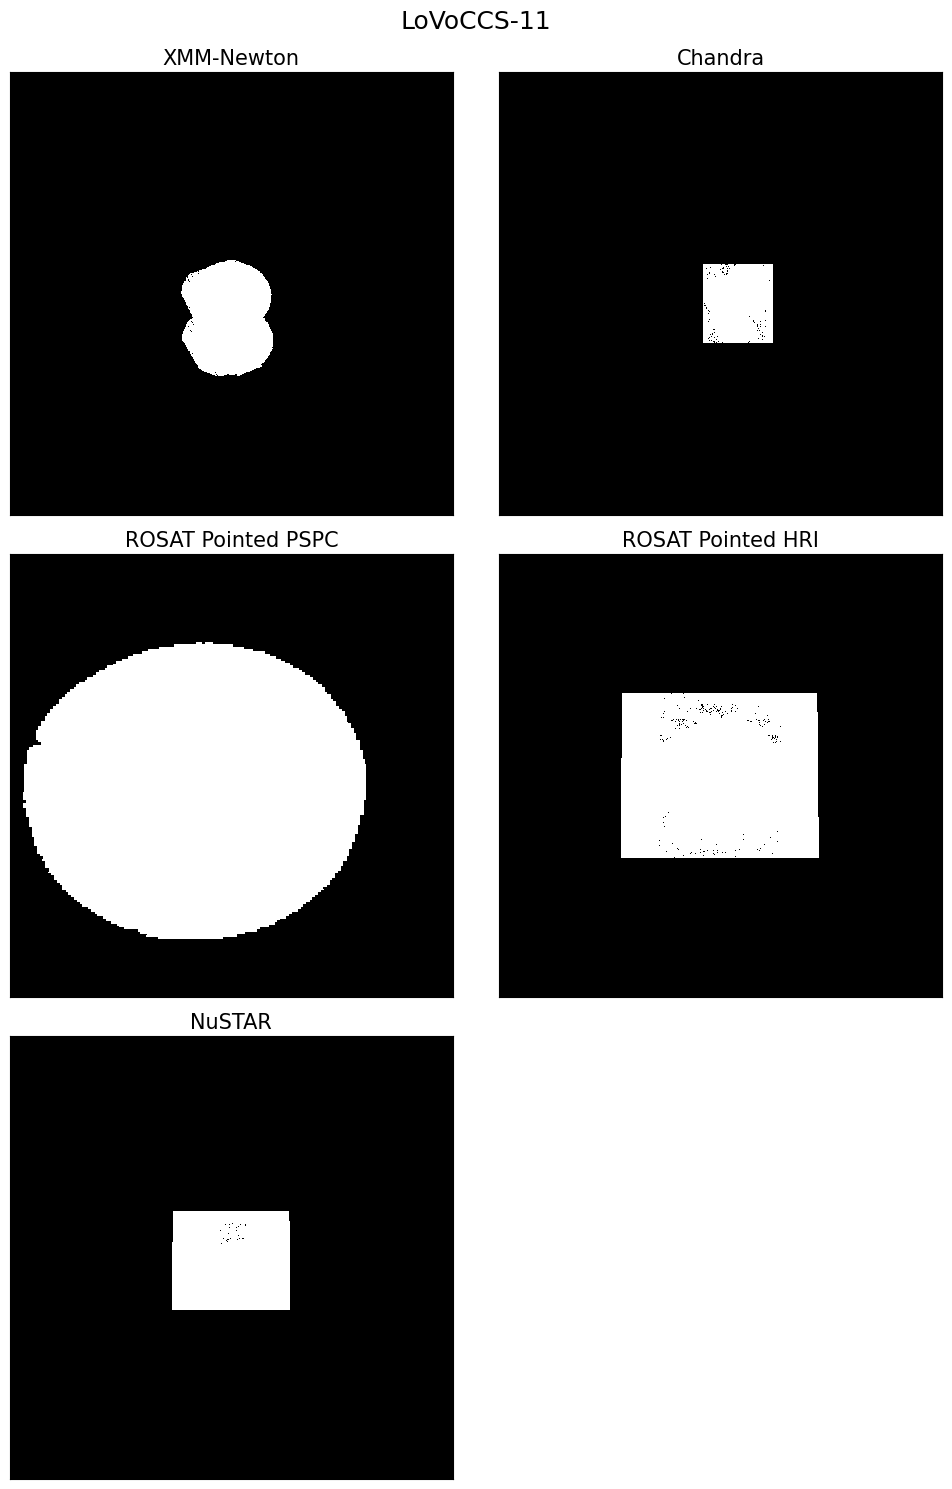

Generating coverage maps:   8%|▊         | 12/144 [01:23<09:56,  4.52s/it]

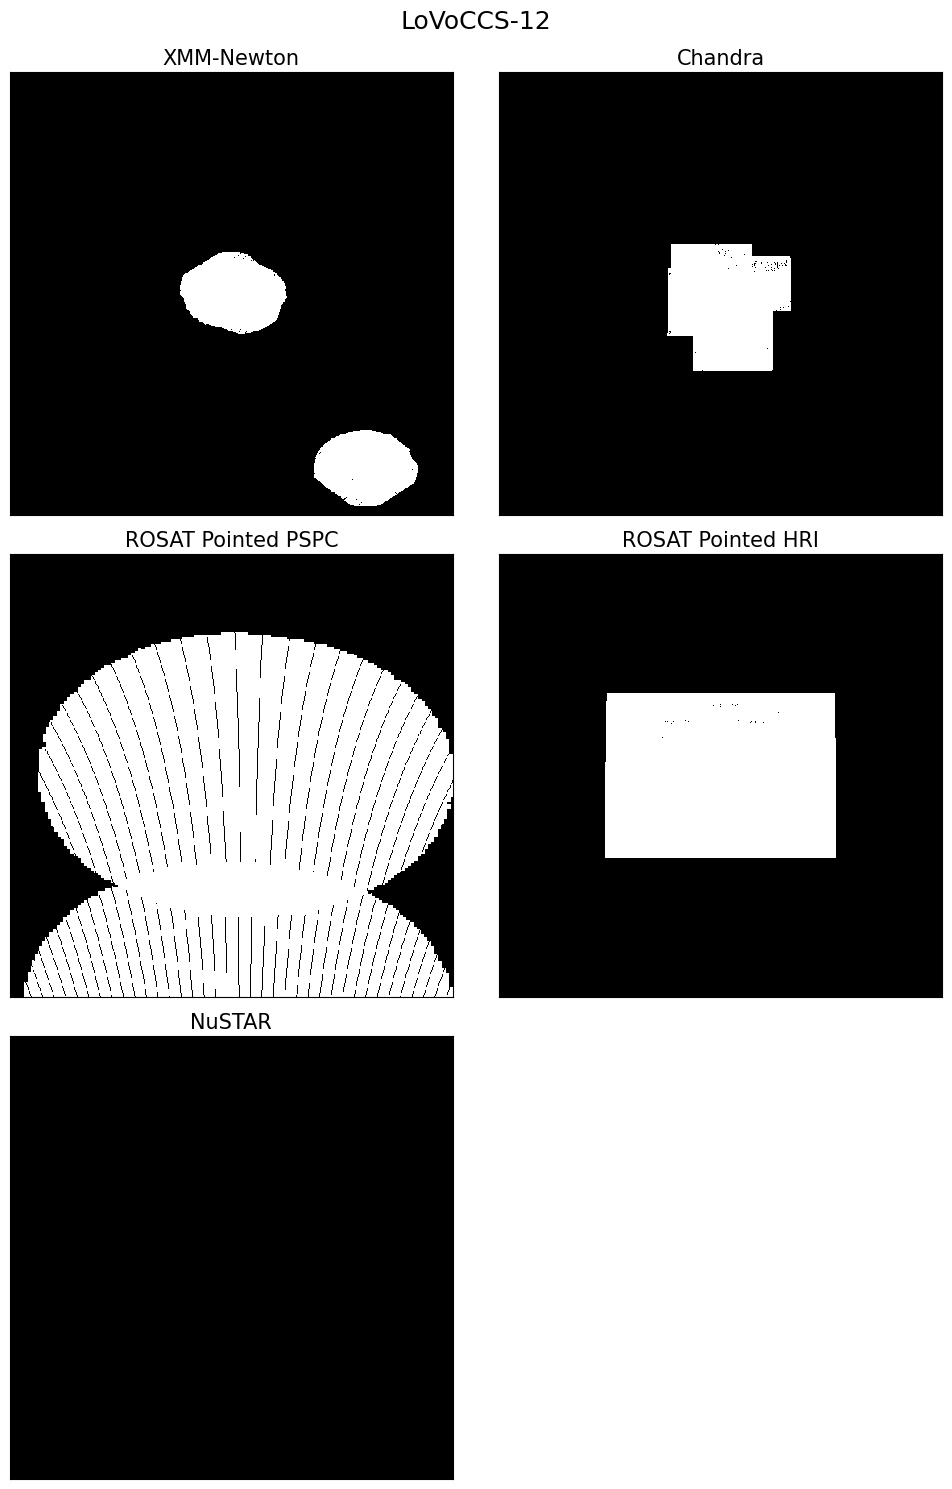

Generating coverage maps:   9%|▉         | 13/144 [01:26<08:31,  3.91s/it]

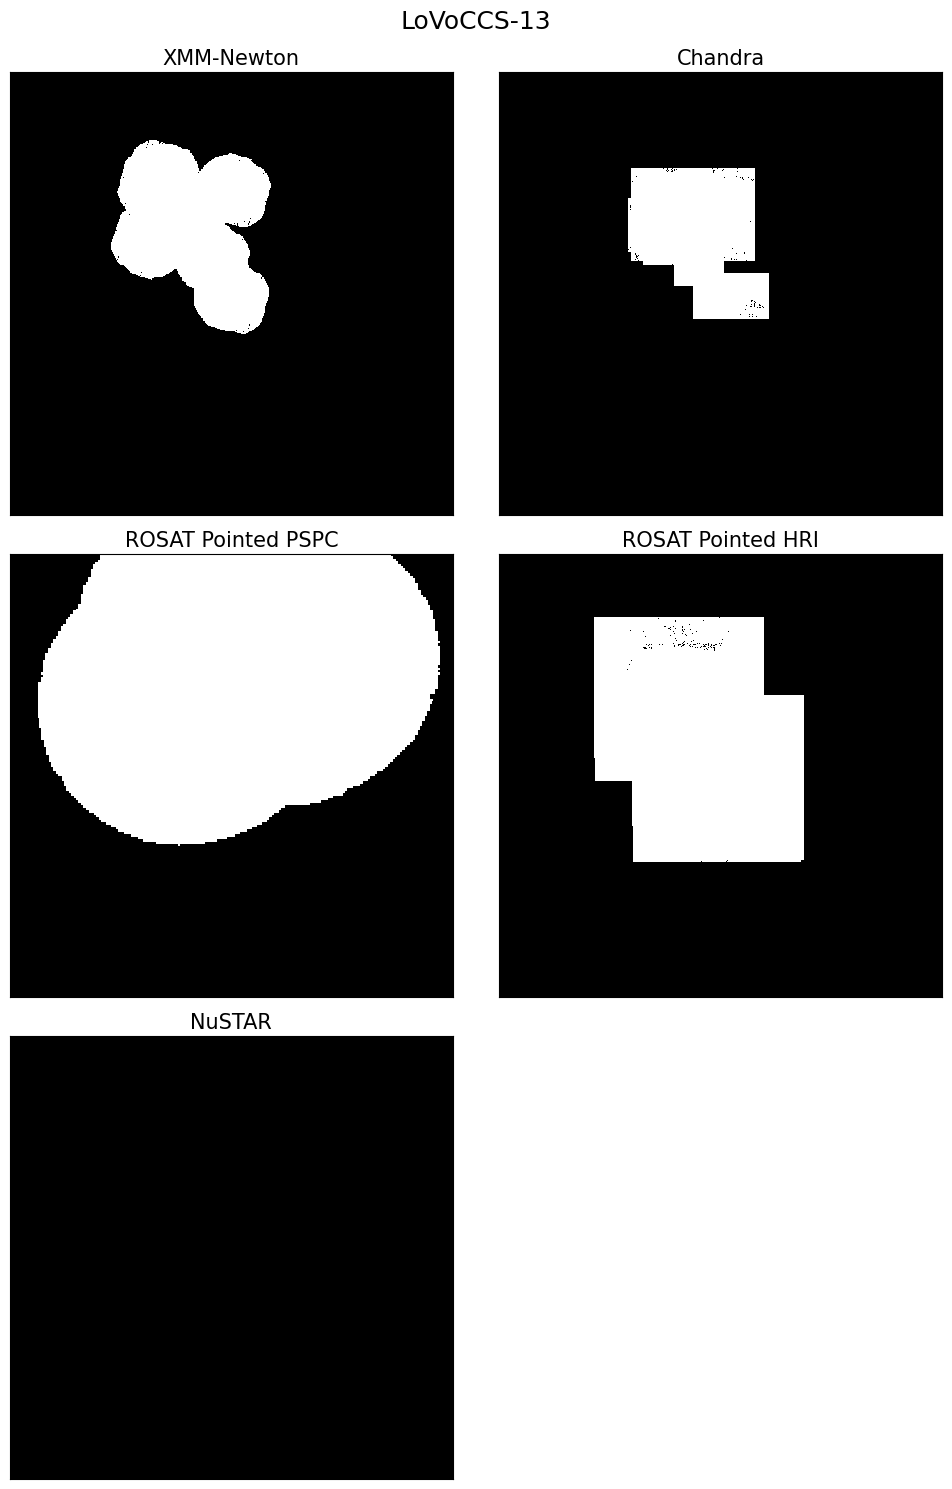

Generating coverage maps:  10%|▉         | 14/144 [01:29<08:12,  3.79s/it]

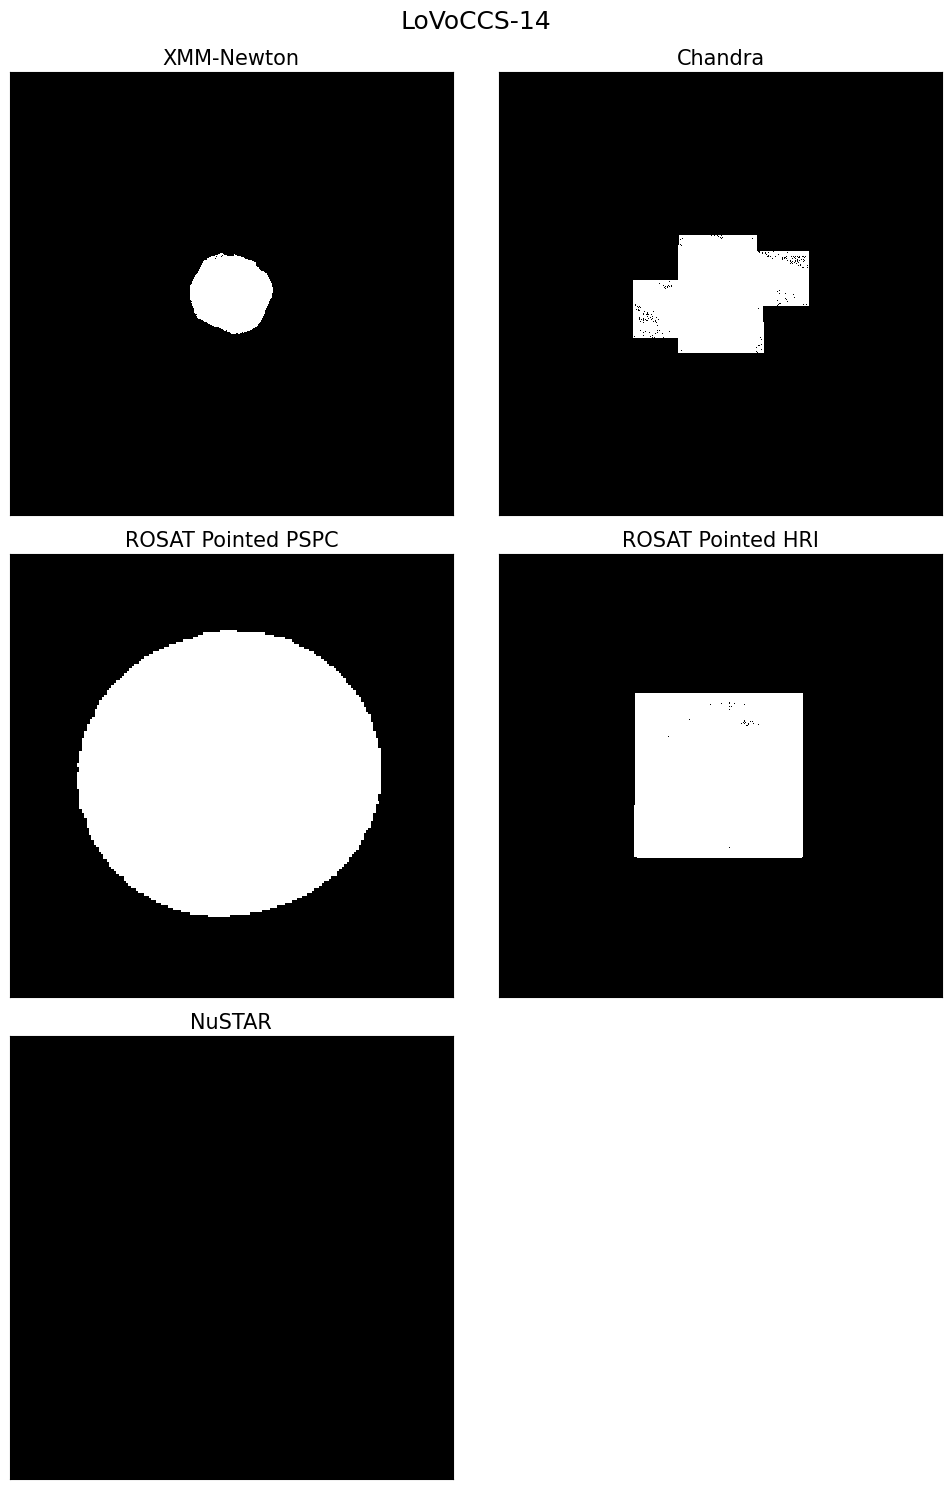

Generating coverage maps:  10%|█         | 15/144 [01:32<07:38,  3.55s/it]

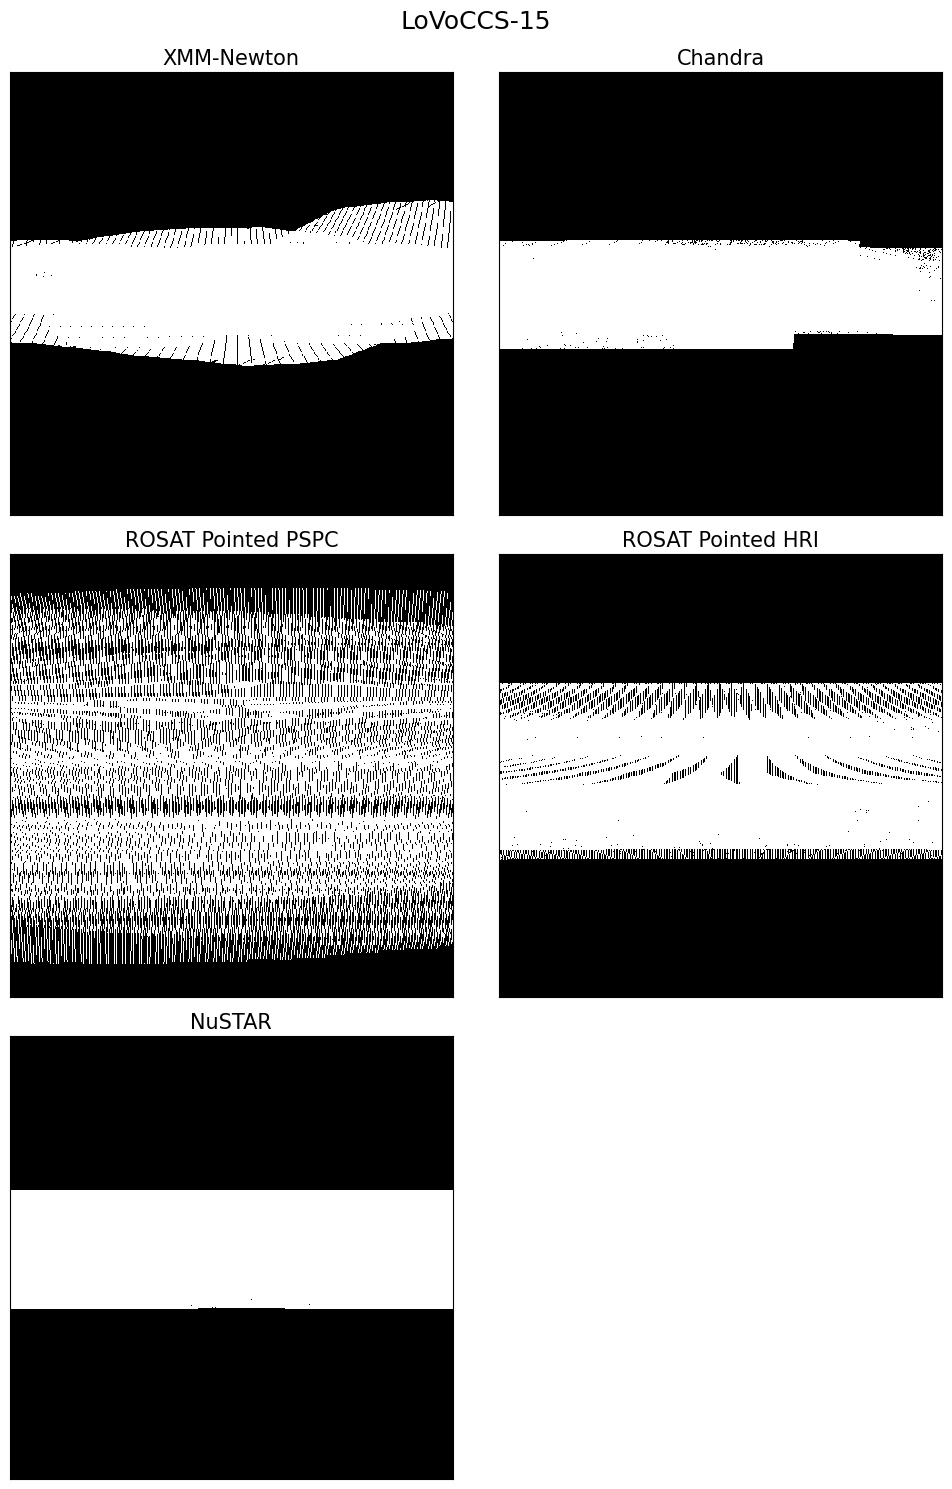

Generating coverage maps:  11%|█         | 16/144 [01:39<09:23,  4.40s/it]

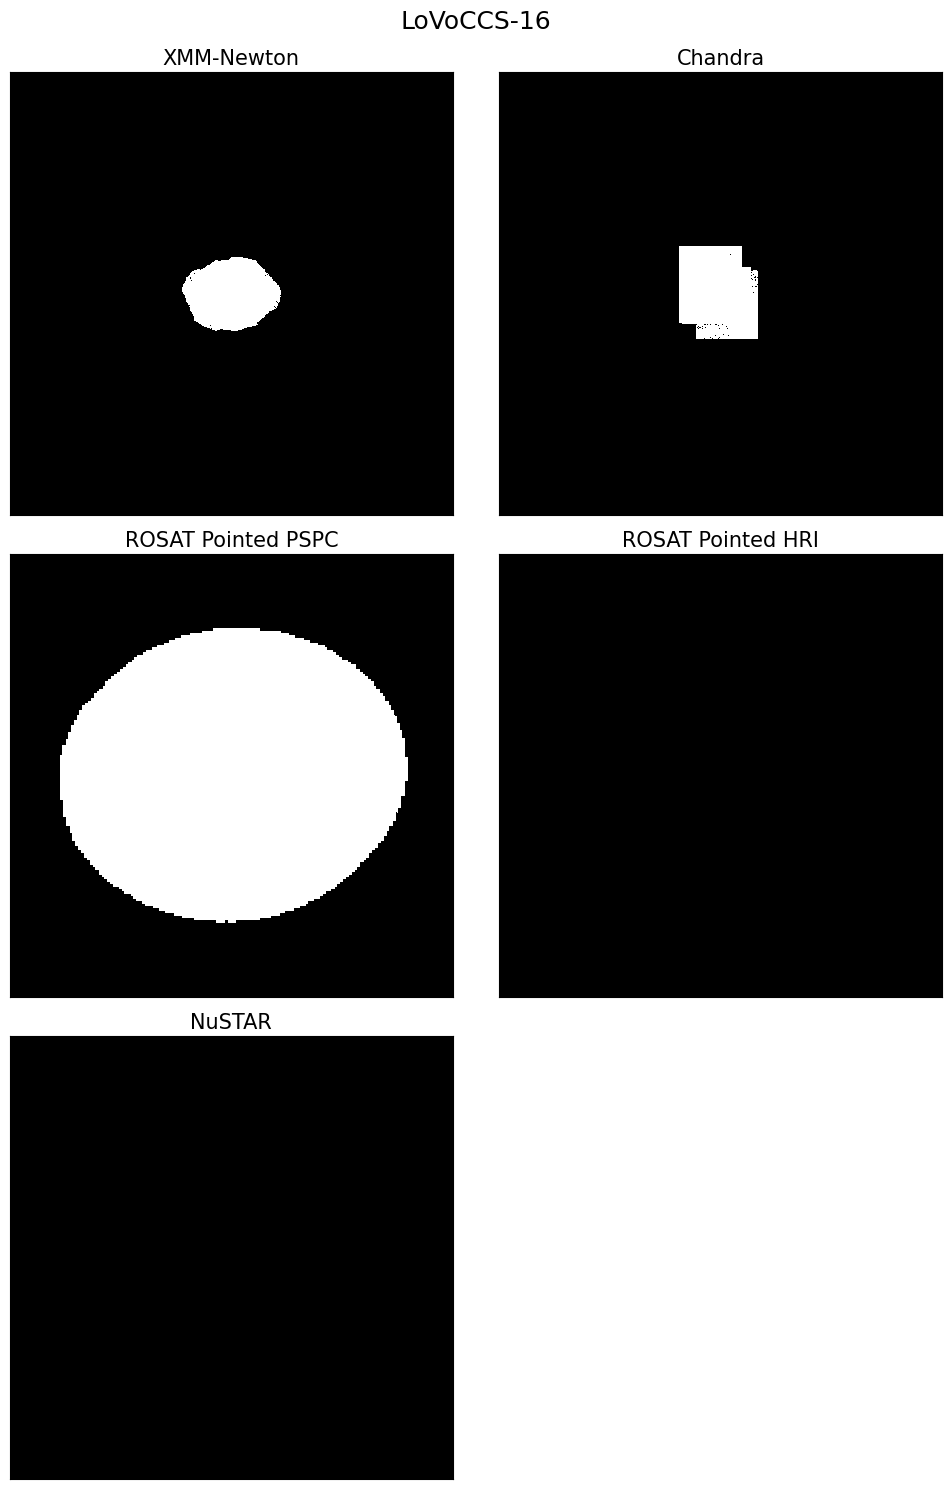

Generating coverage maps:  12%|█▏        | 17/144 [01:41<08:08,  3.85s/it]

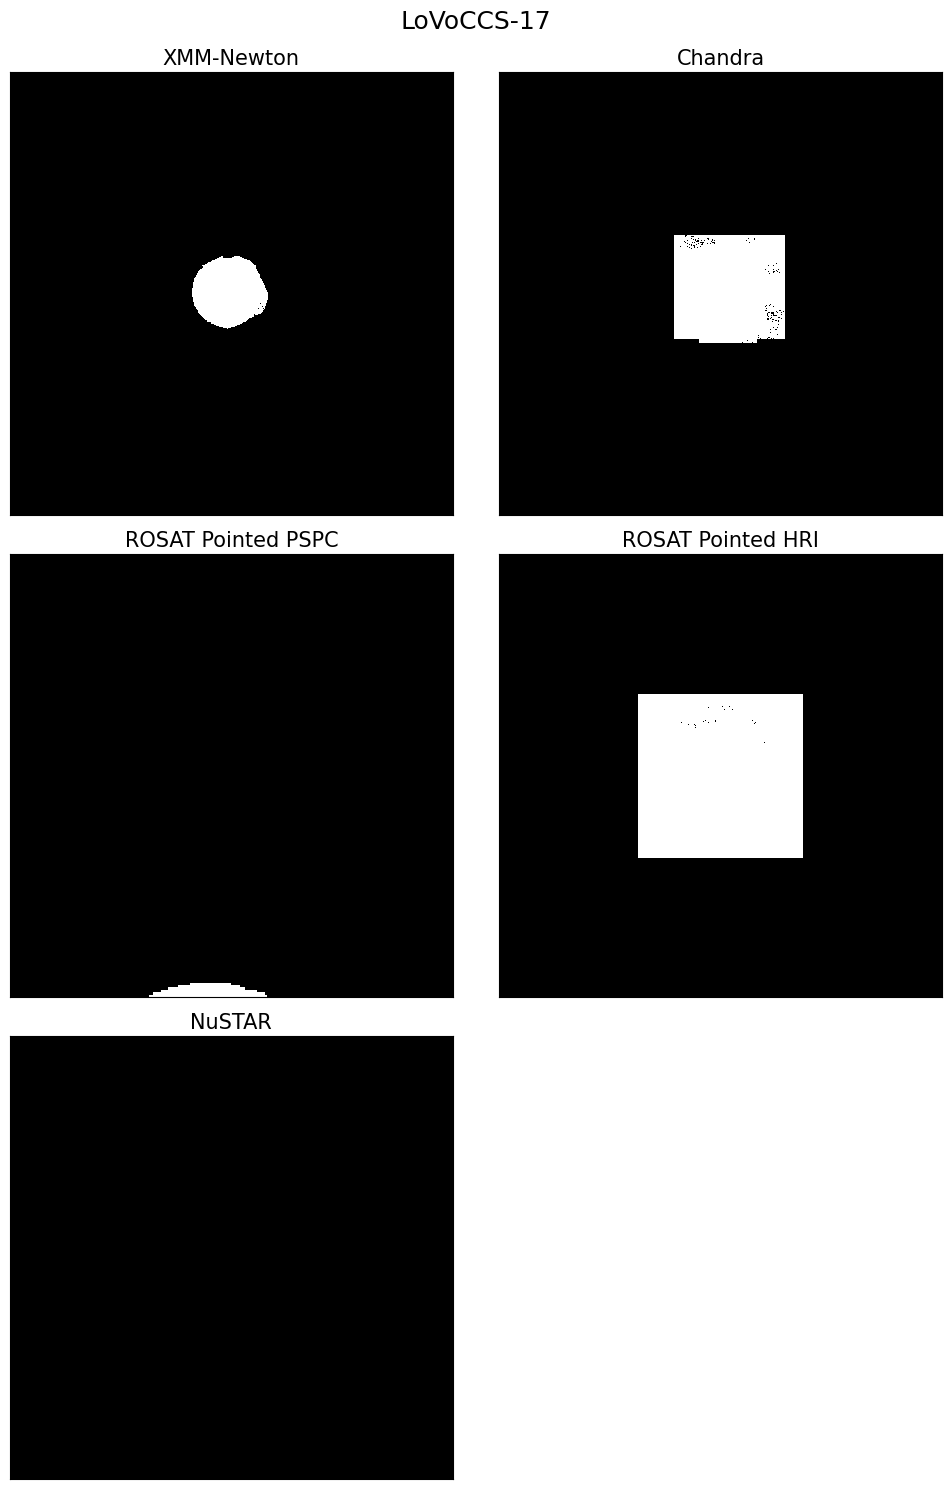

Generating coverage maps:  12%|█▎        | 18/144 [01:44<07:09,  3.41s/it]

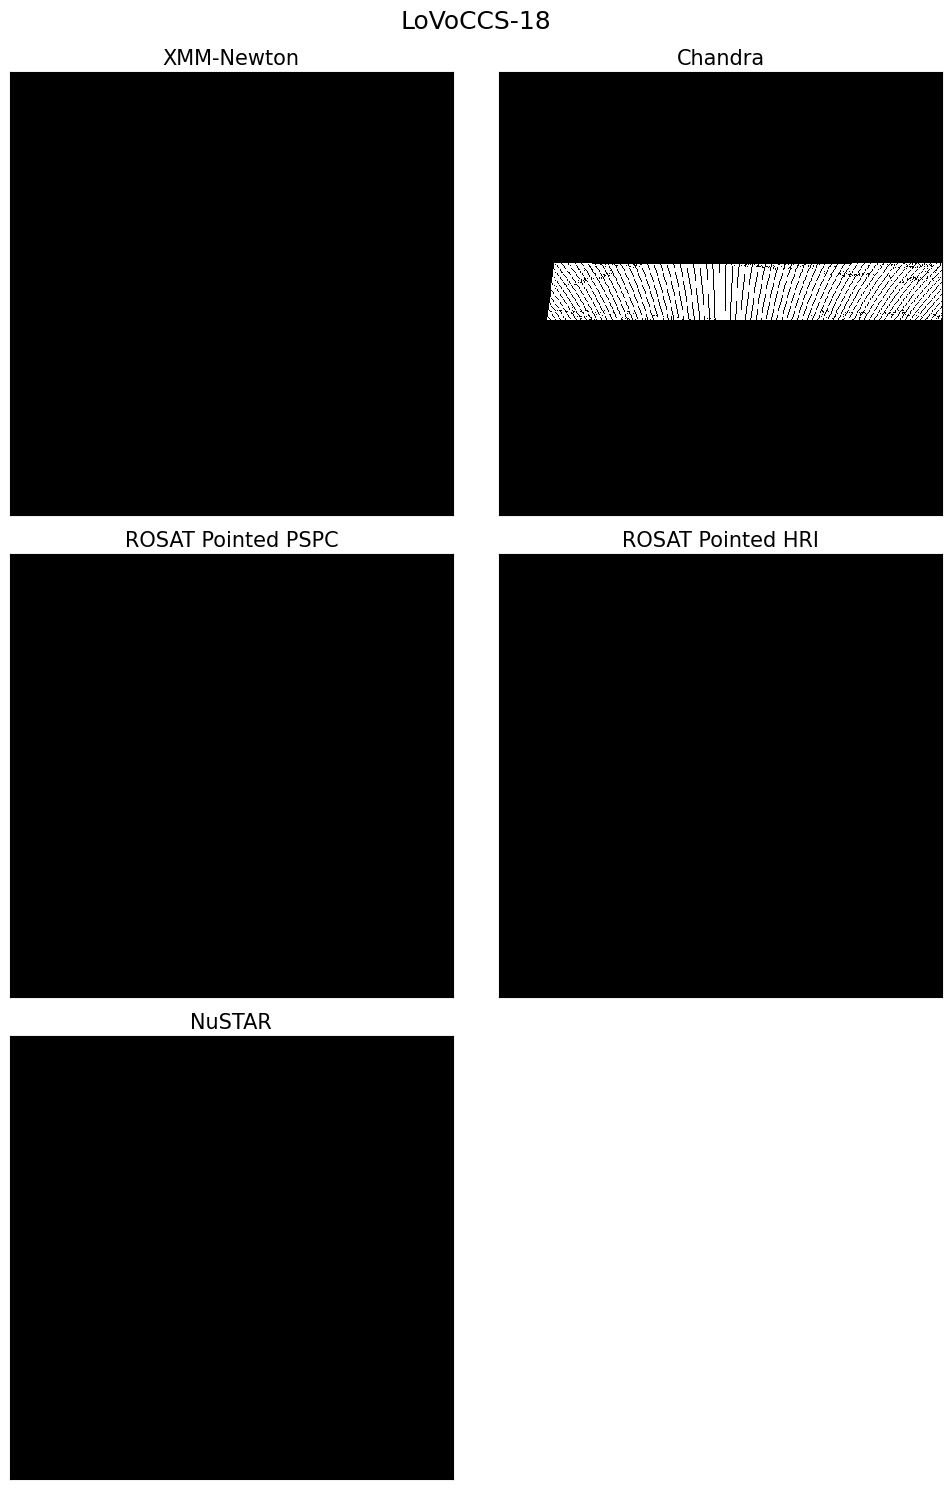

Generating coverage maps:  13%|█▎        | 19/144 [01:45<05:39,  2.72s/it]

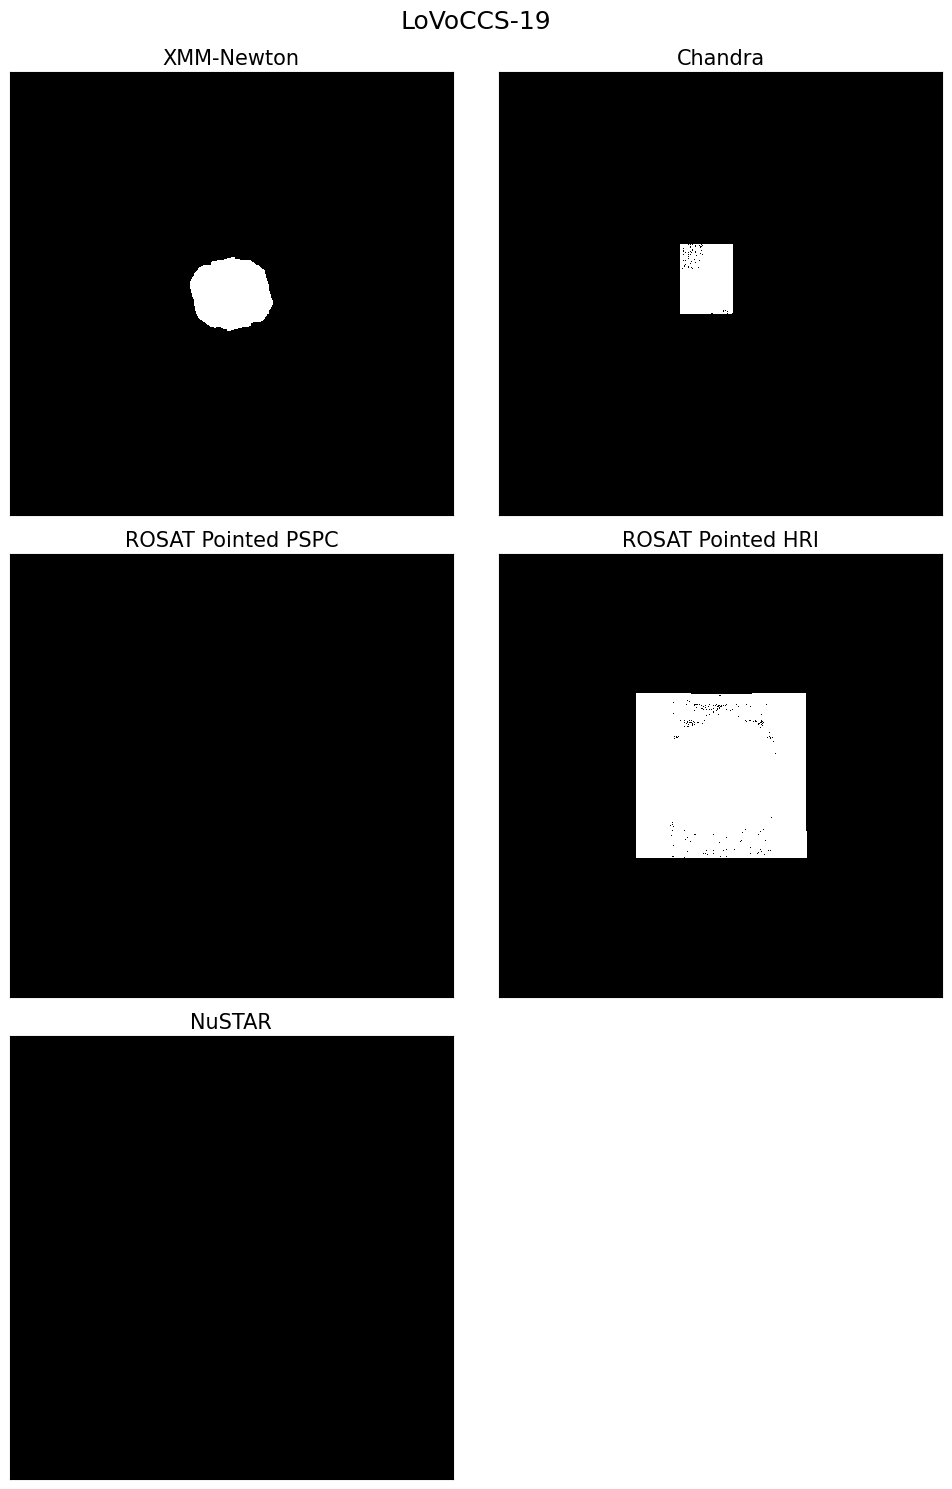

Generating coverage maps:  14%|█▍        | 20/144 [01:47<05:05,  2.46s/it]

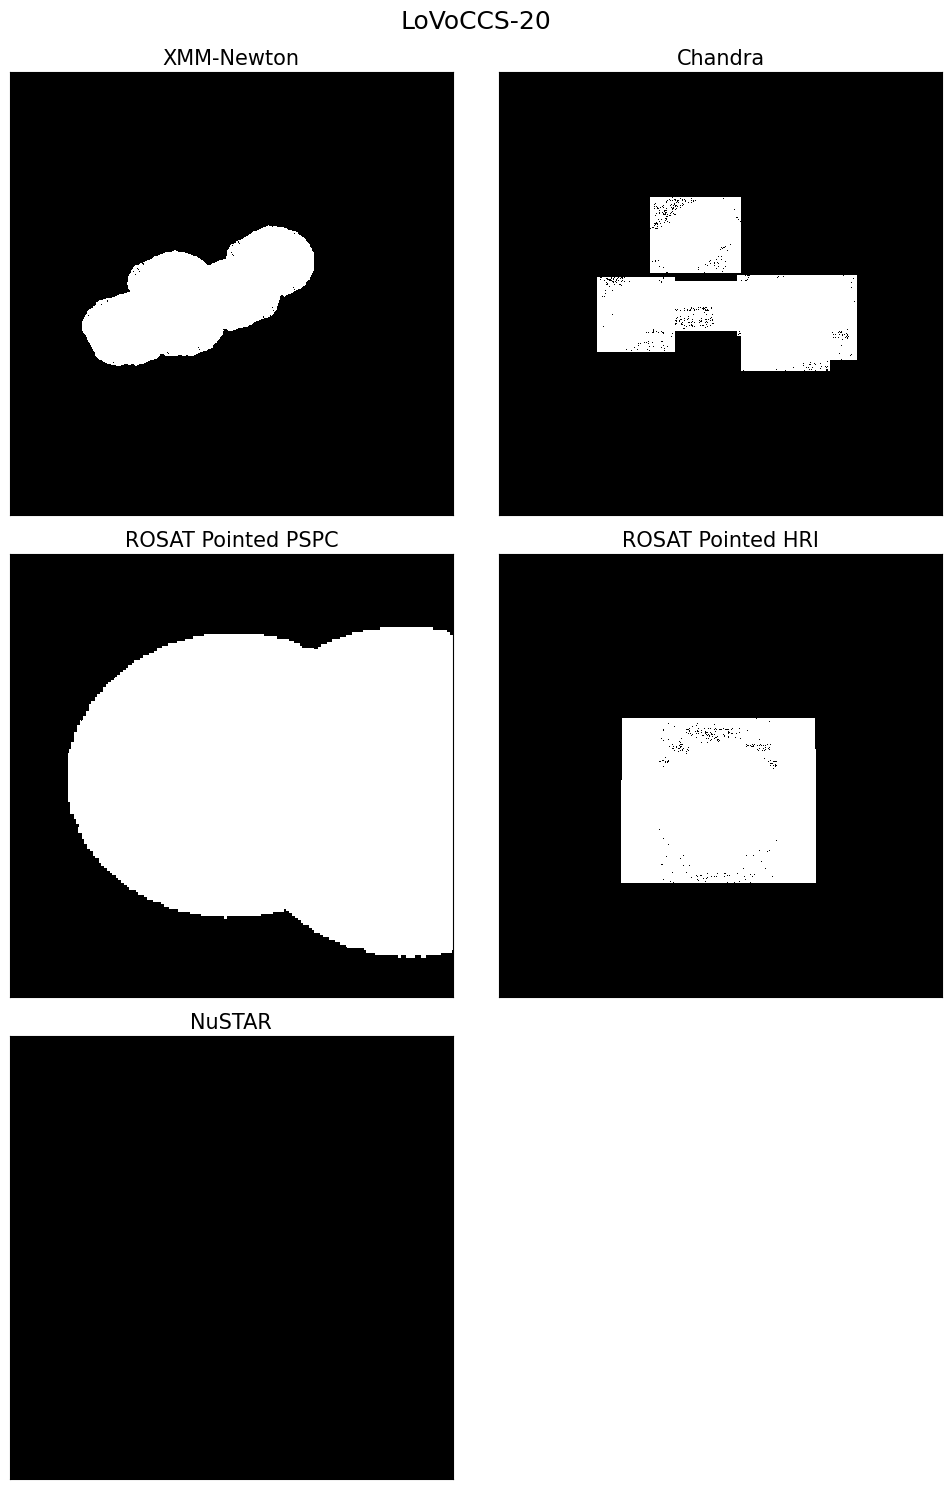

Generating coverage maps:  15%|█▍        | 21/144 [01:50<05:57,  2.90s/it]

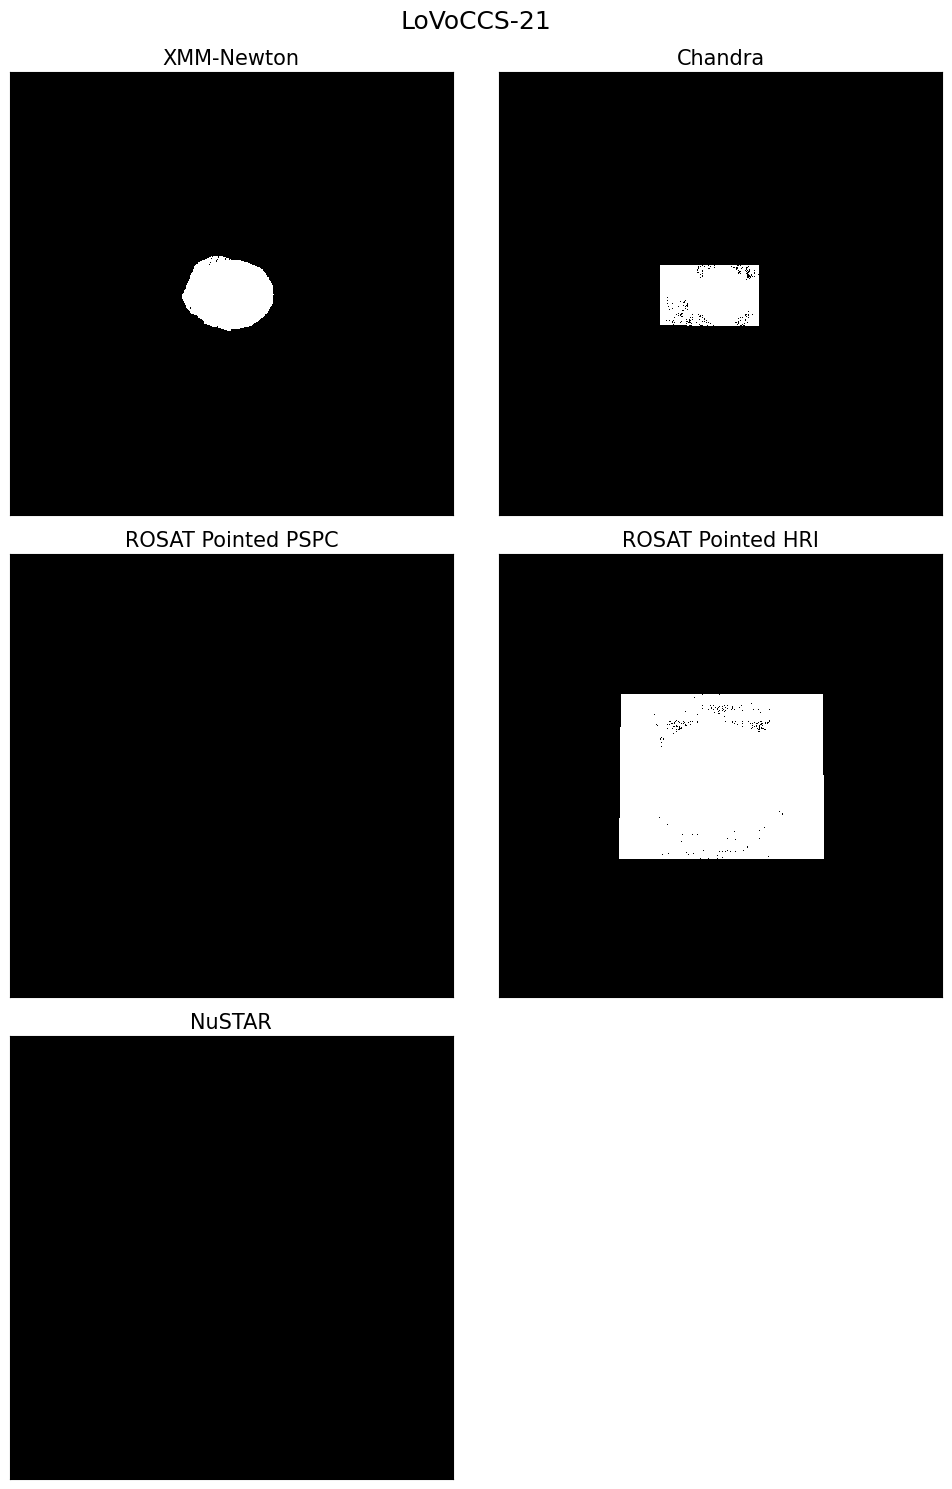

Generating coverage maps:  15%|█▌        | 22/144 [01:52<04:56,  2.43s/it]

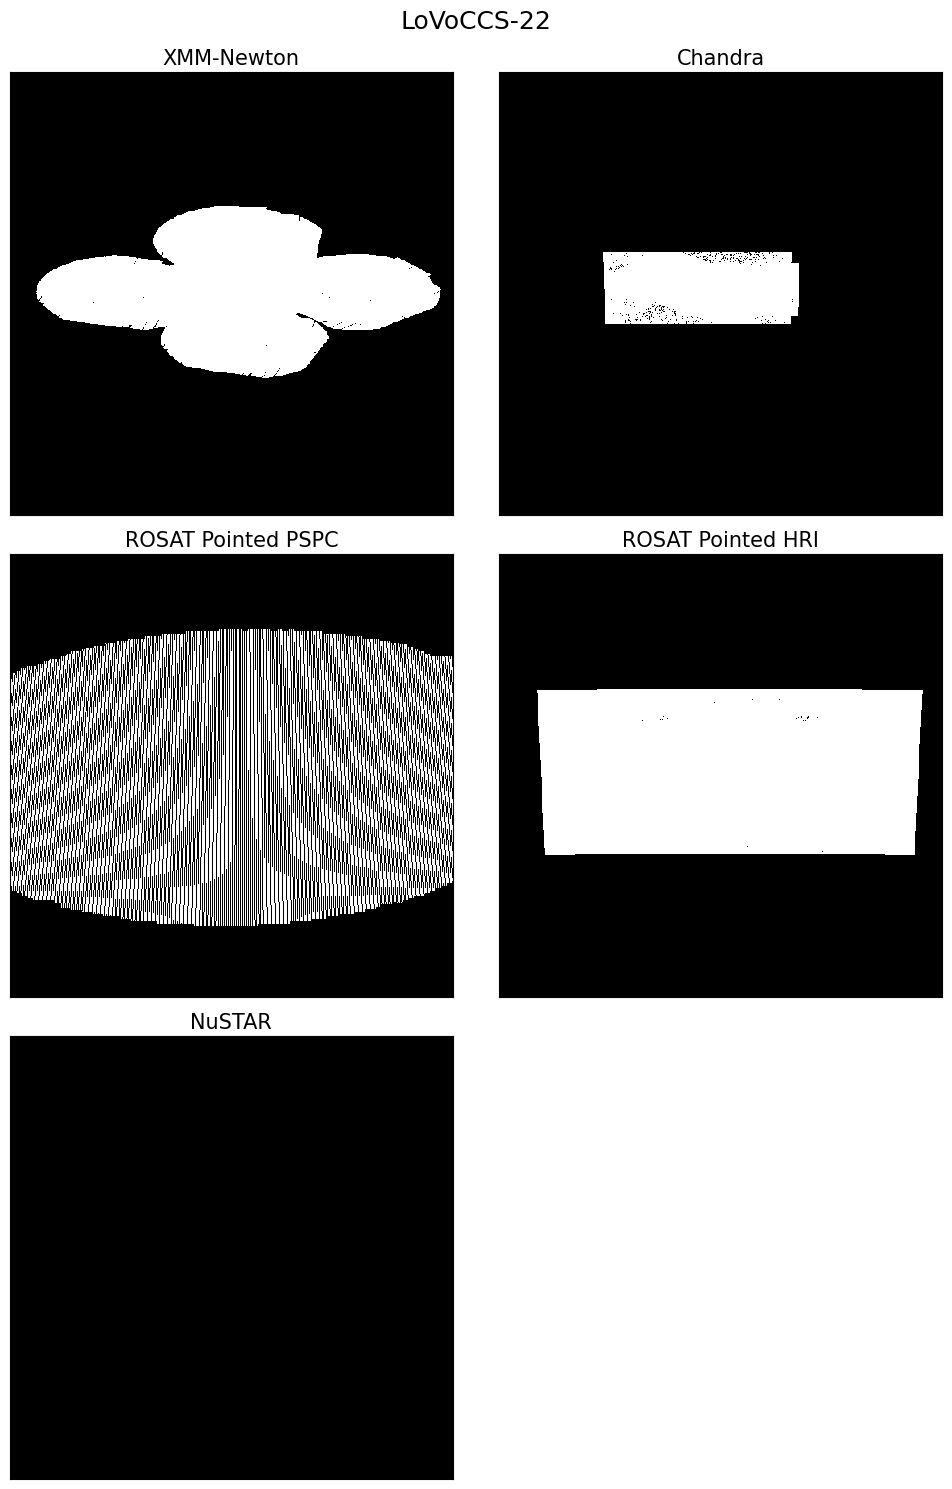

Generating coverage maps:  16%|█▌        | 23/144 [01:55<05:05,  2.52s/it]

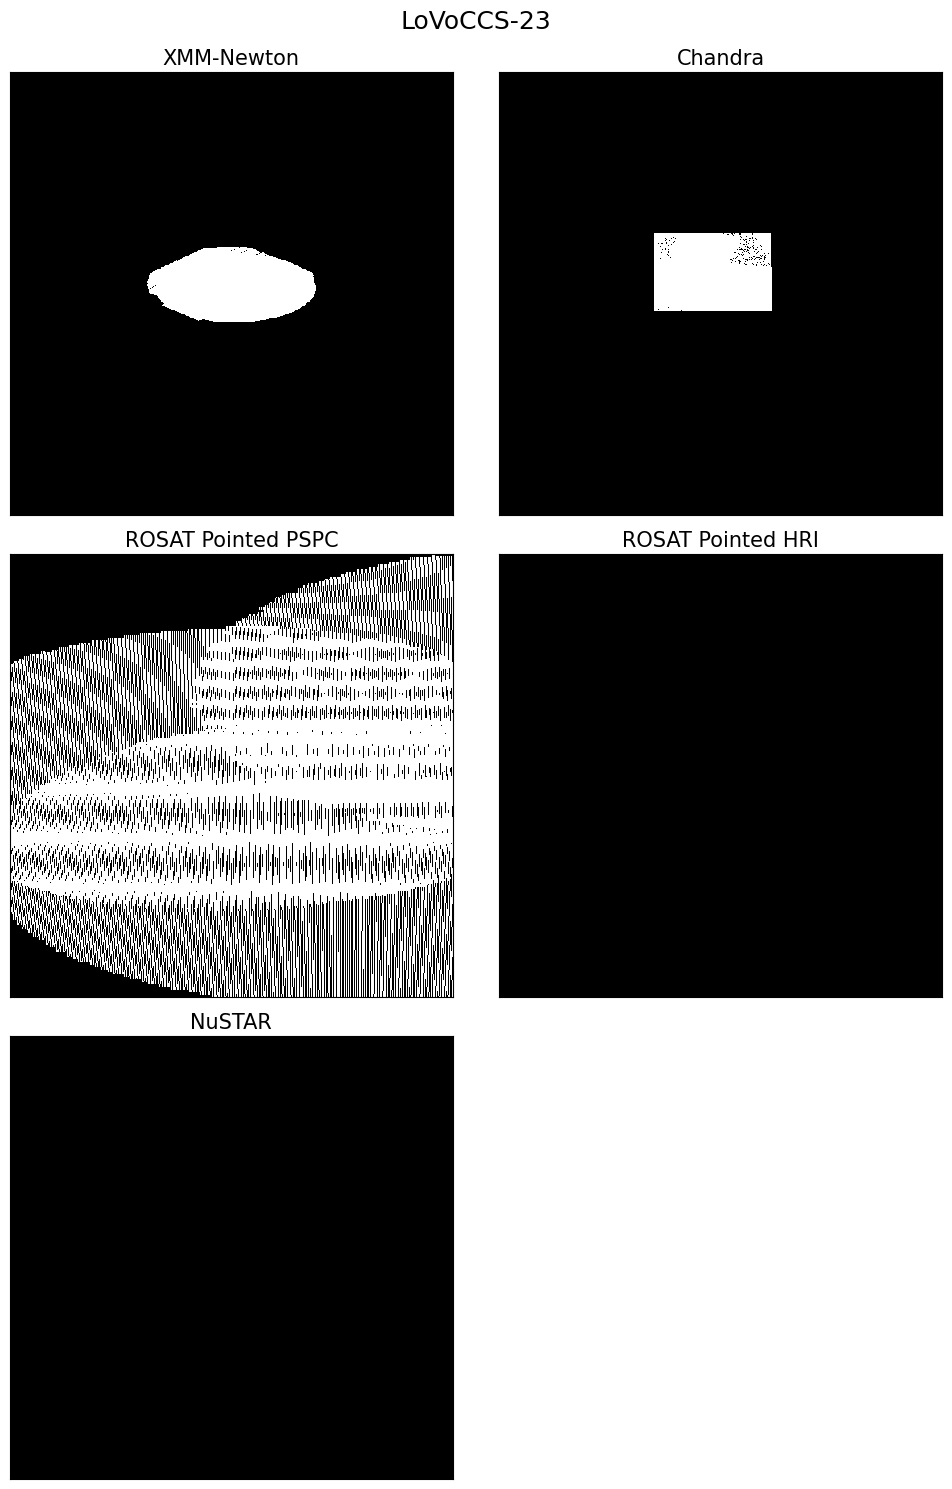

Generating coverage maps:  17%|█▋        | 24/144 [01:56<04:32,  2.27s/it]

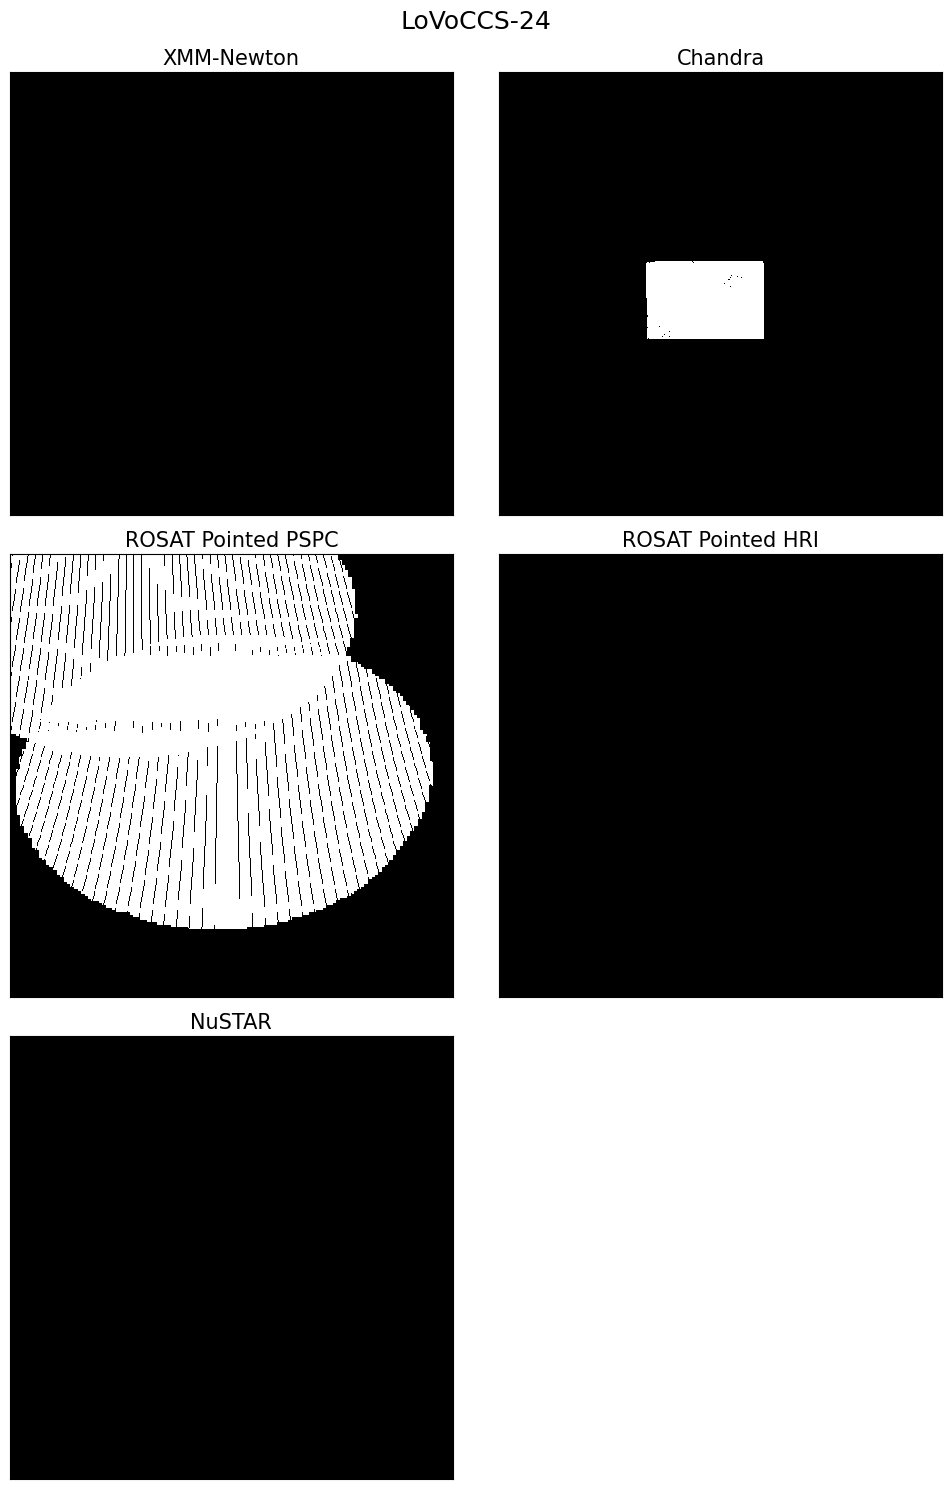

Generating coverage maps:  17%|█▋        | 25/144 [01:58<03:56,  1.99s/it]

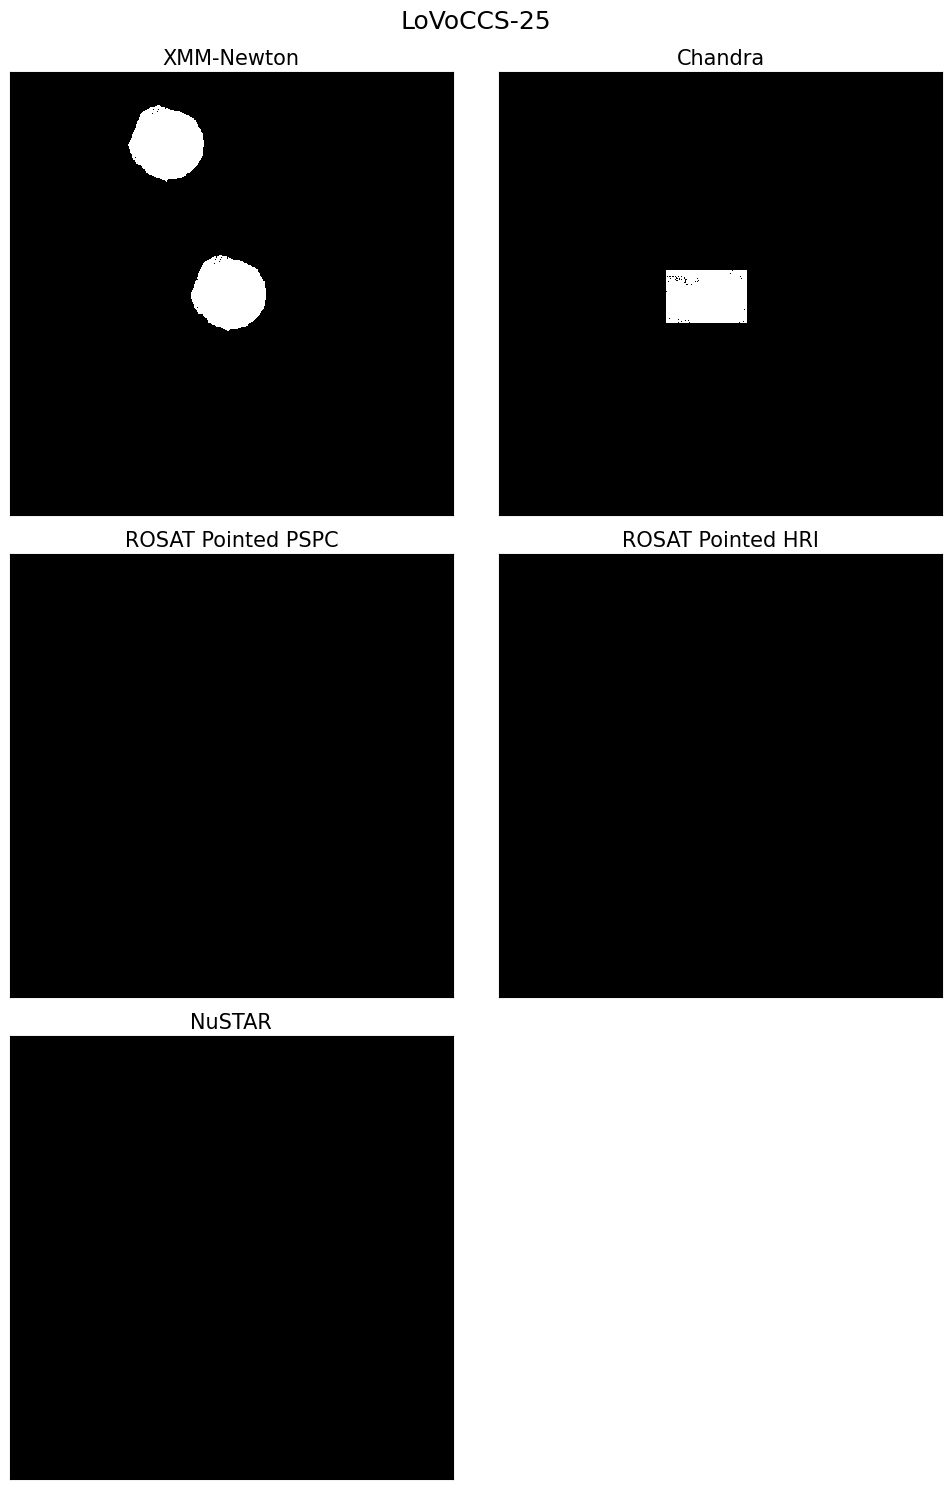

Generating coverage maps:  18%|█▊        | 26/144 [01:59<03:45,  1.92s/it]

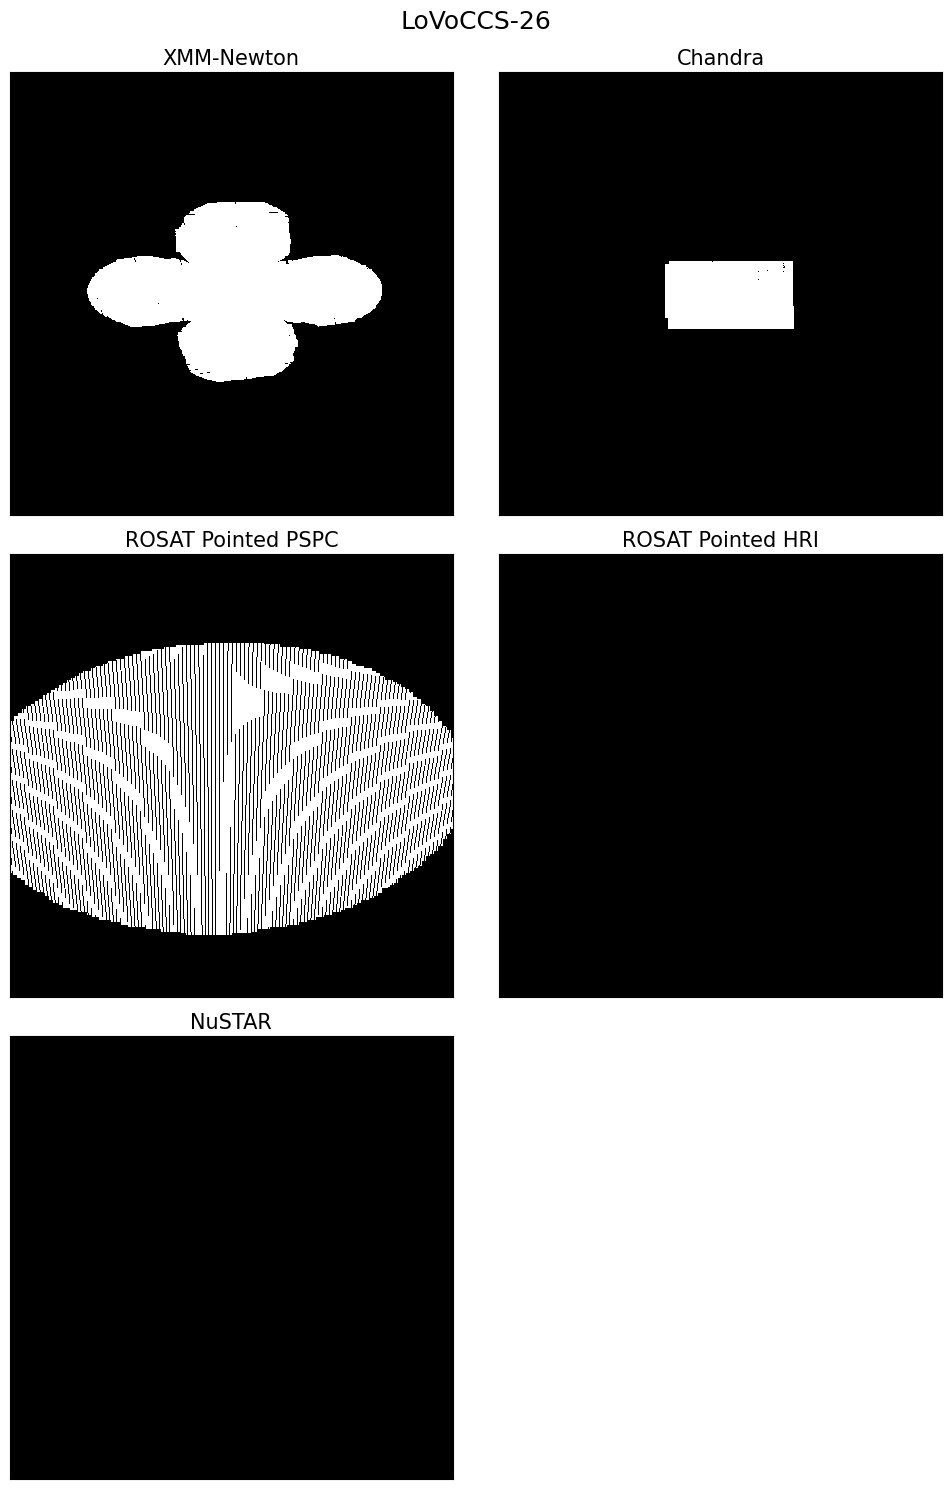

Generating coverage maps:  19%|█▉        | 27/144 [02:03<04:35,  2.35s/it]

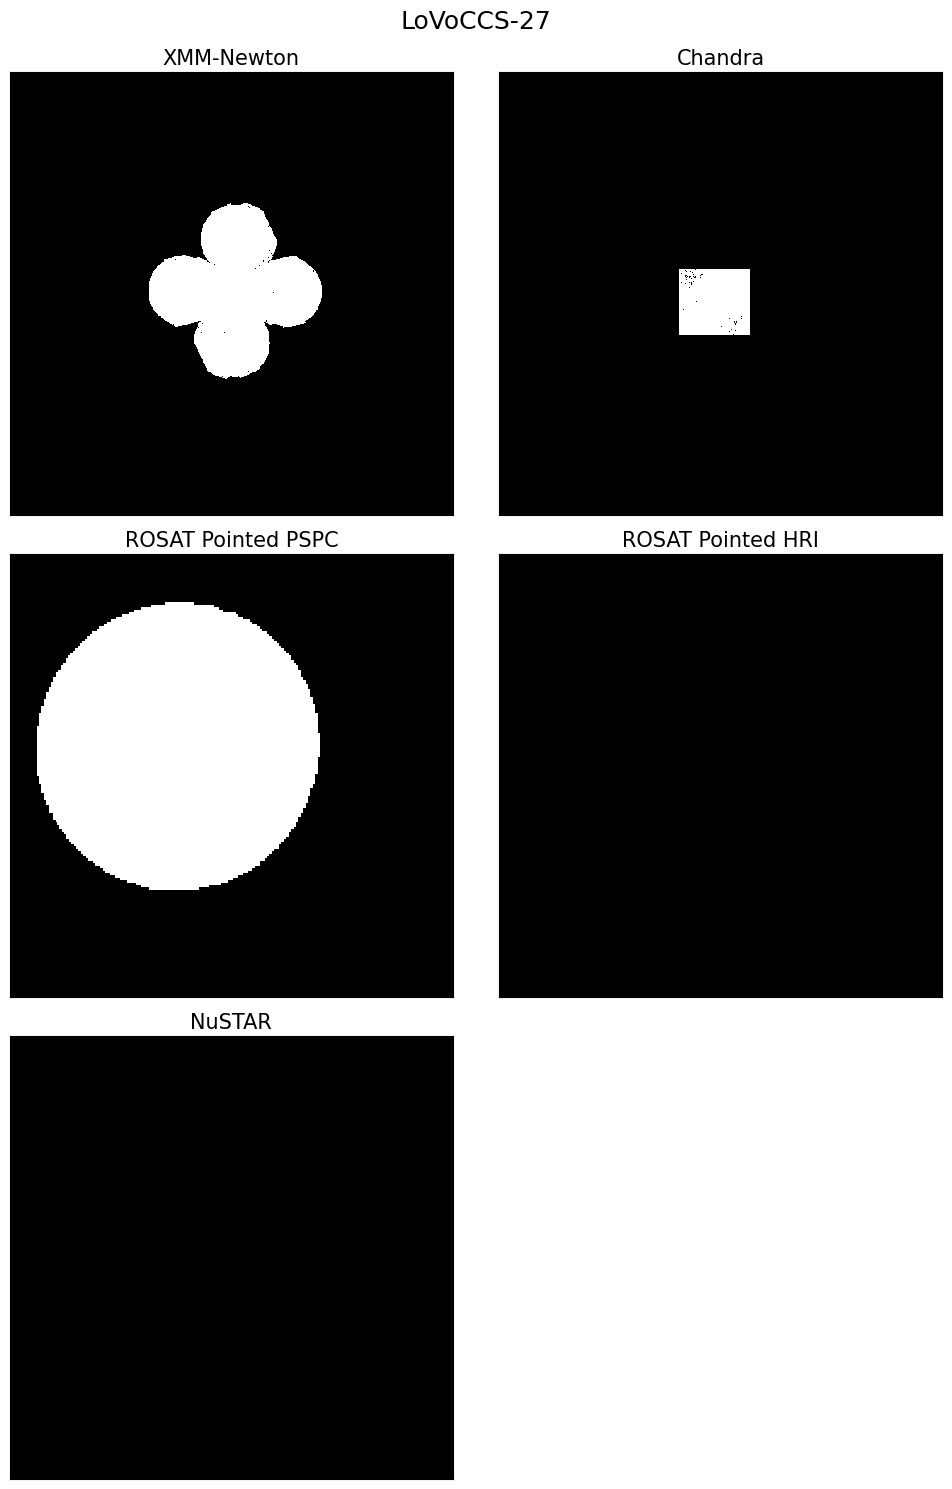

Generating coverage maps:  19%|█▉        | 28/144 [02:05<04:22,  2.26s/it]

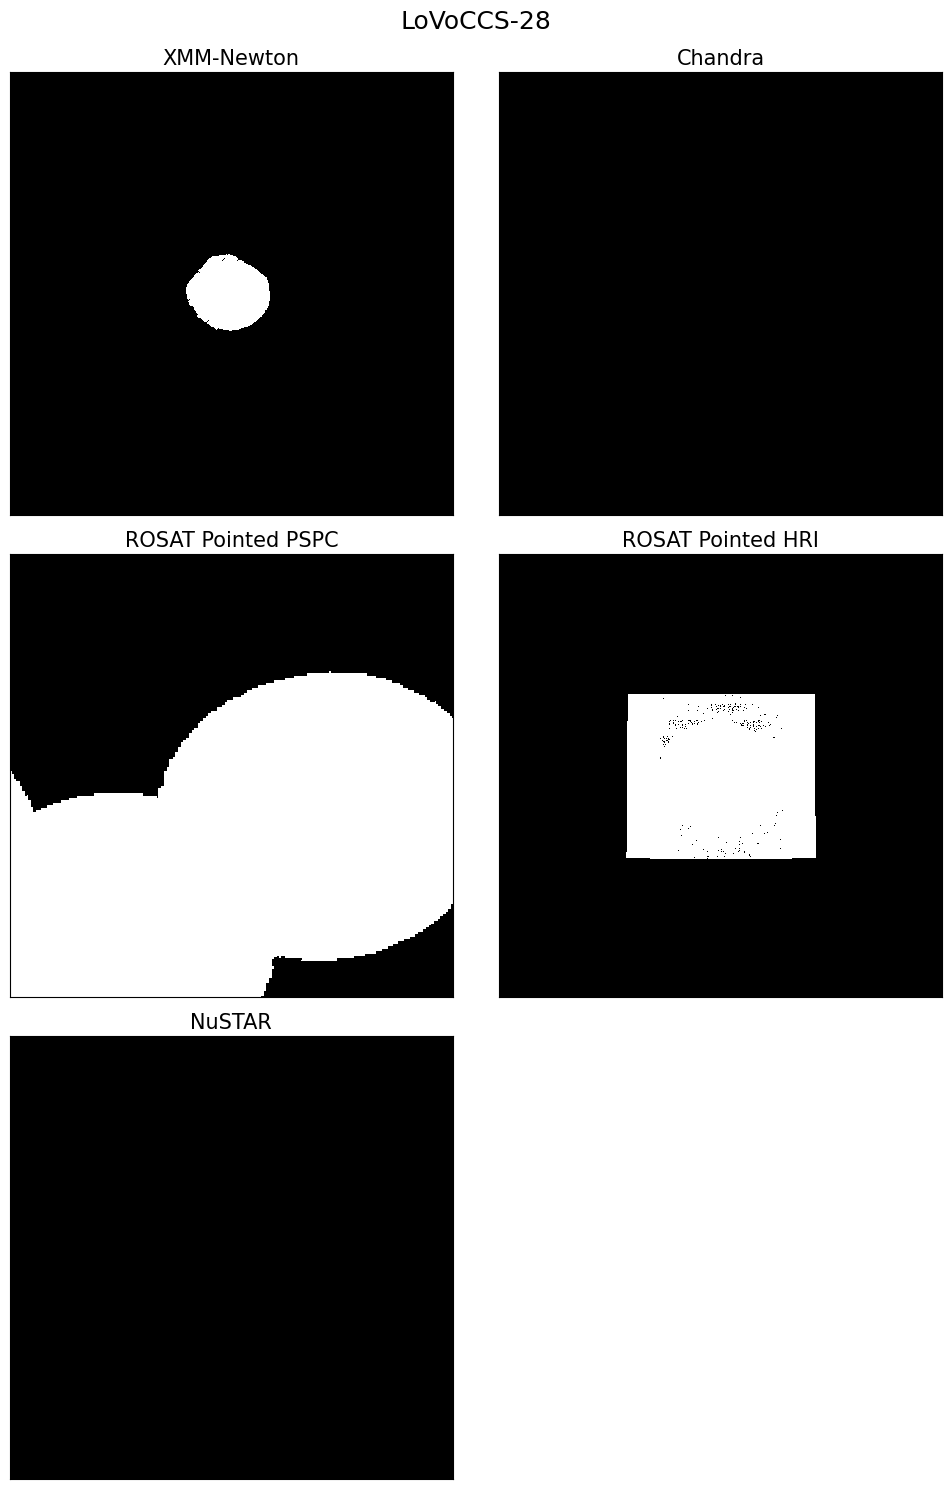

Generating coverage maps:  20%|██        | 29/144 [02:07<04:05,  2.14s/it]

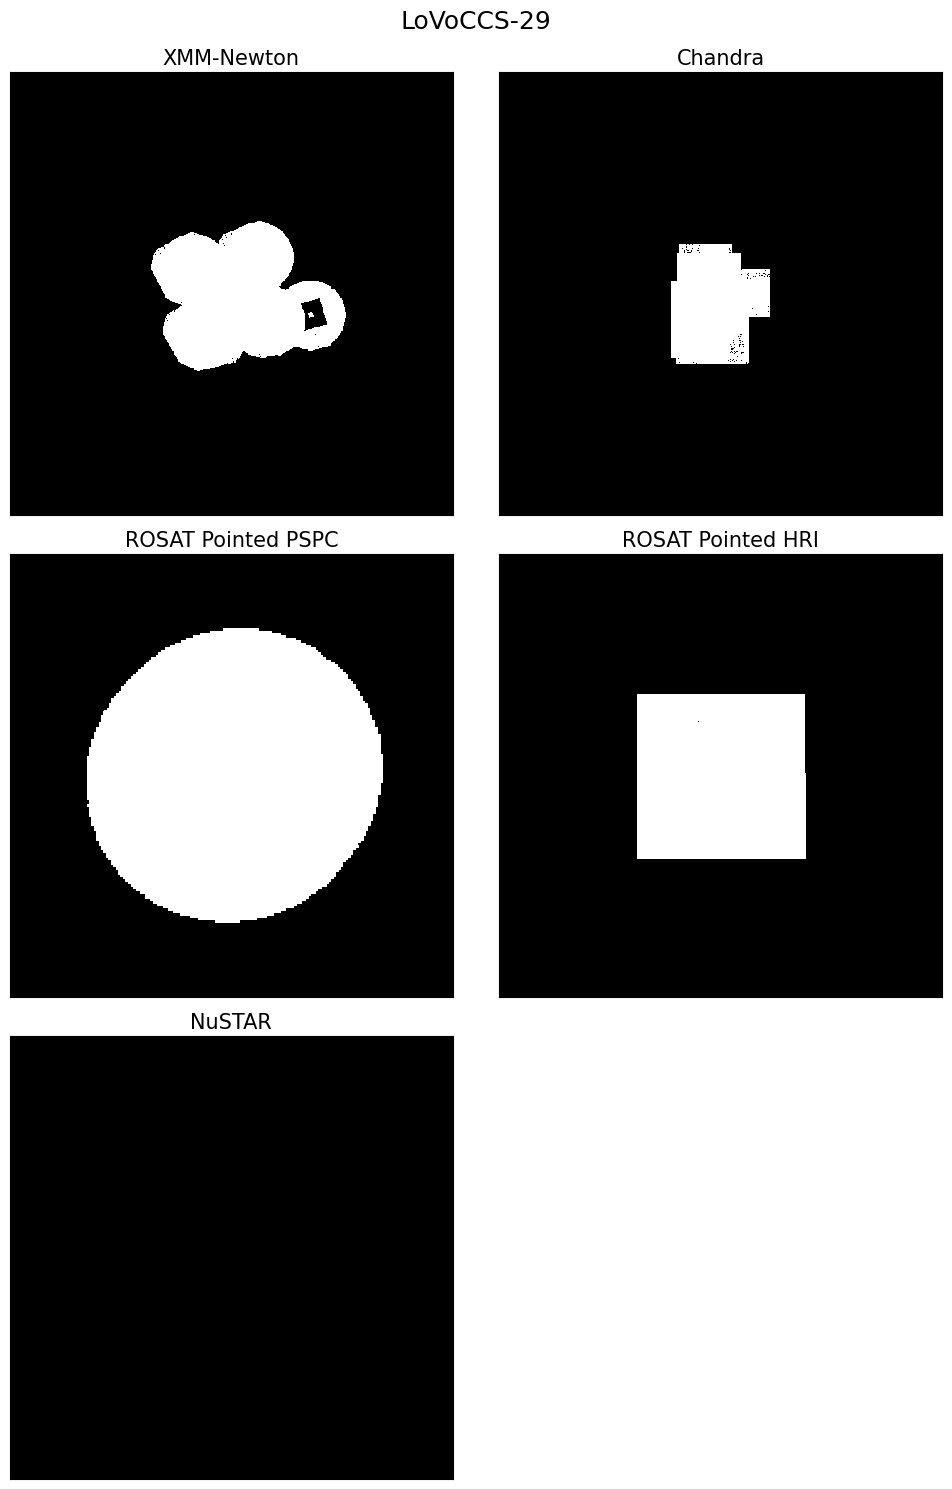

Generating coverage maps:  21%|██        | 30/144 [02:14<07:08,  3.76s/it]

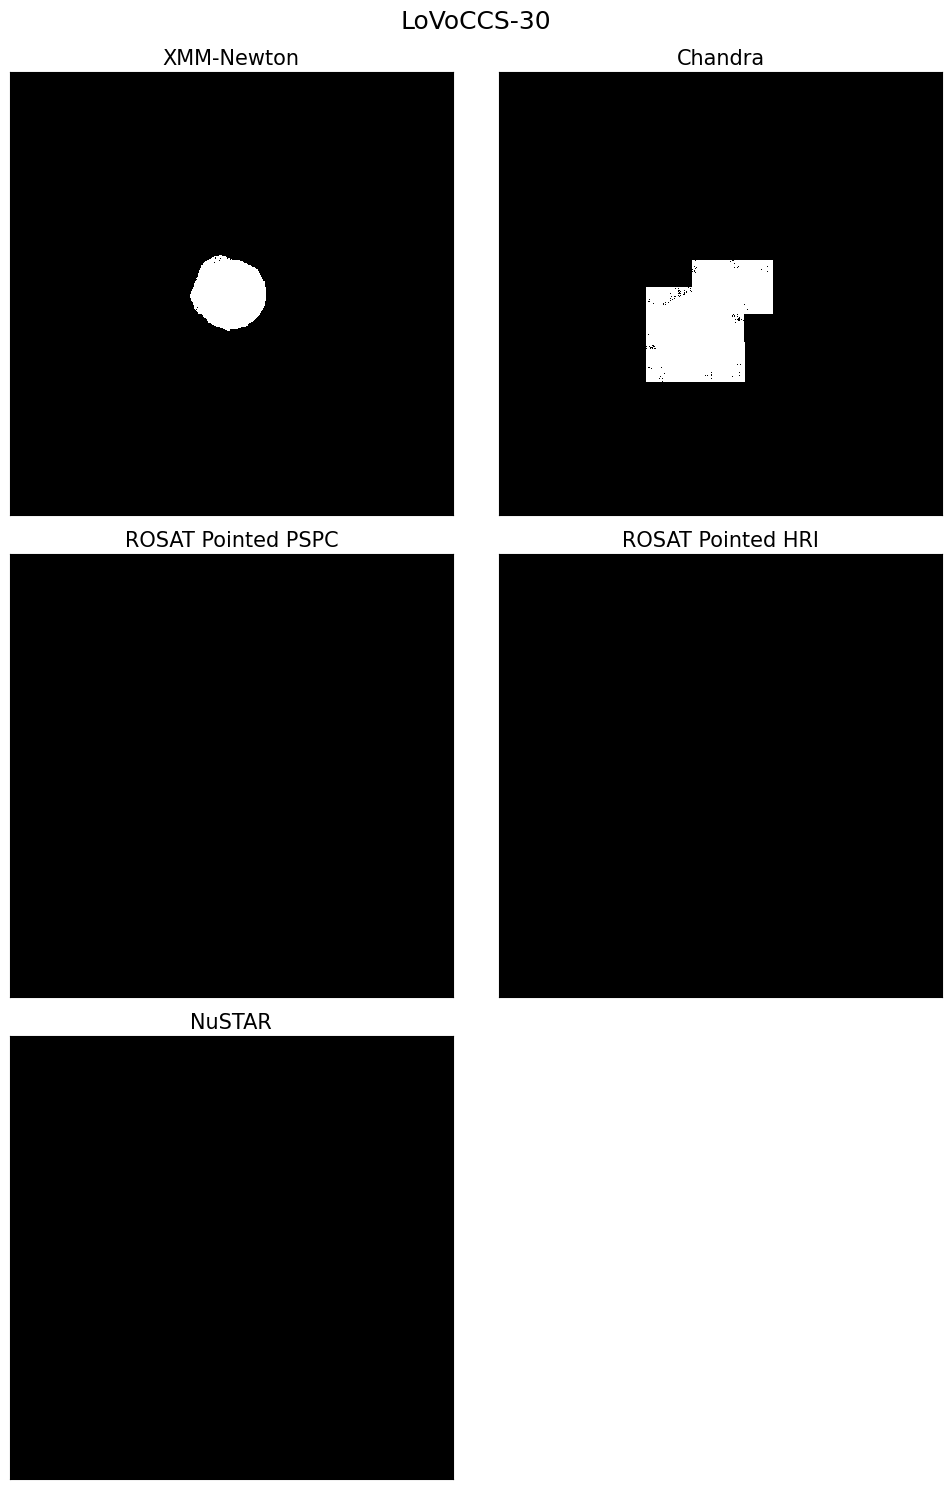

Generating coverage maps:  22%|██▏       | 31/144 [02:16<05:55,  3.15s/it]

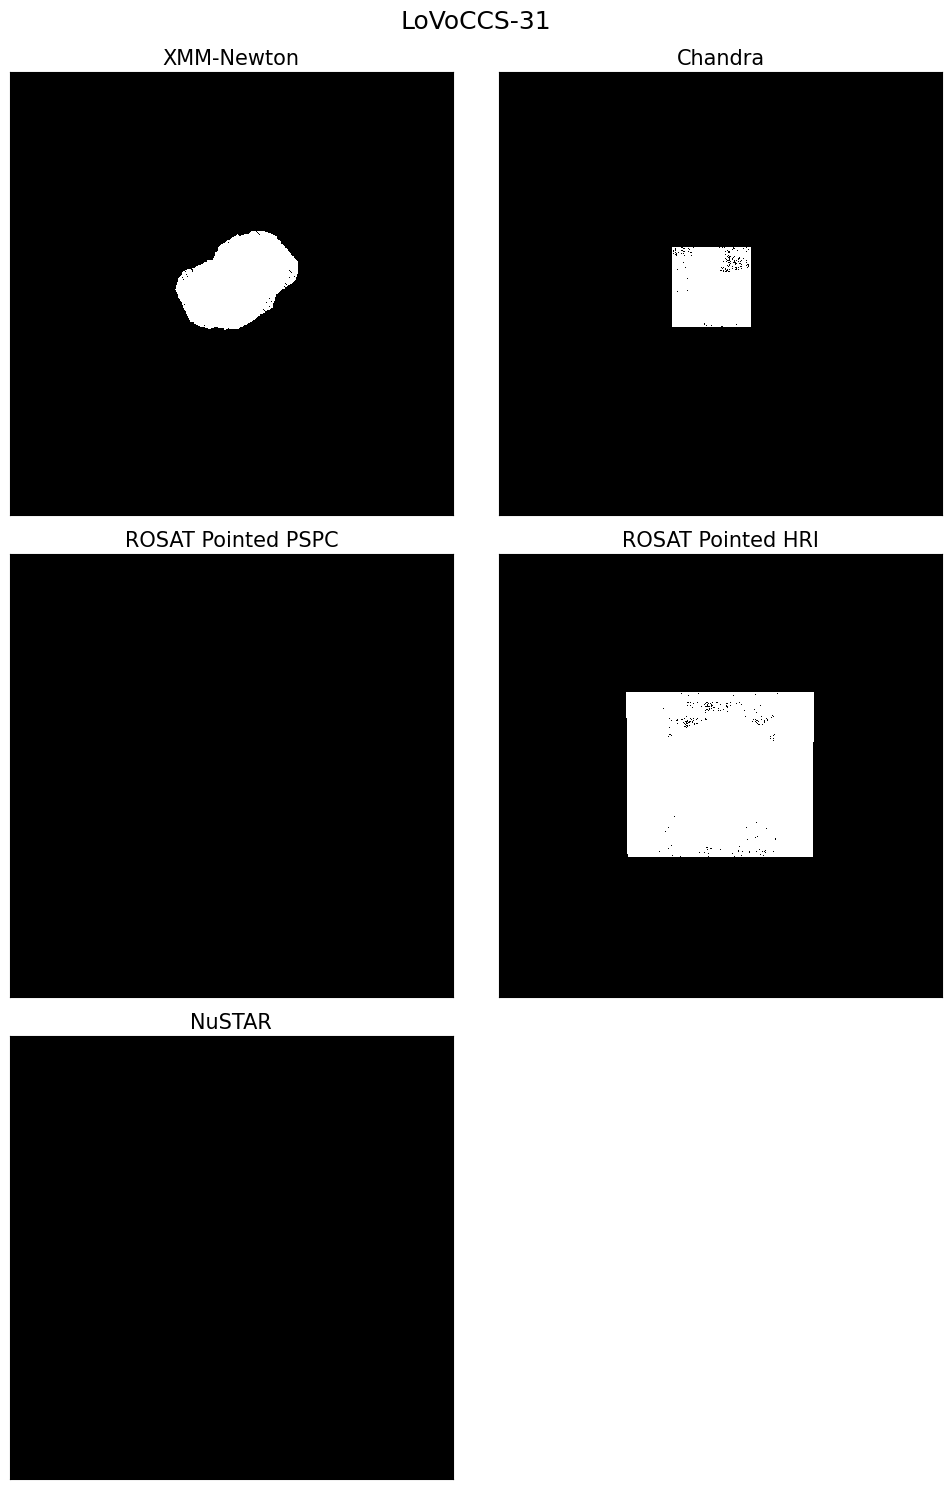

Generating coverage maps:  22%|██▏       | 32/144 [02:18<05:30,  2.96s/it]

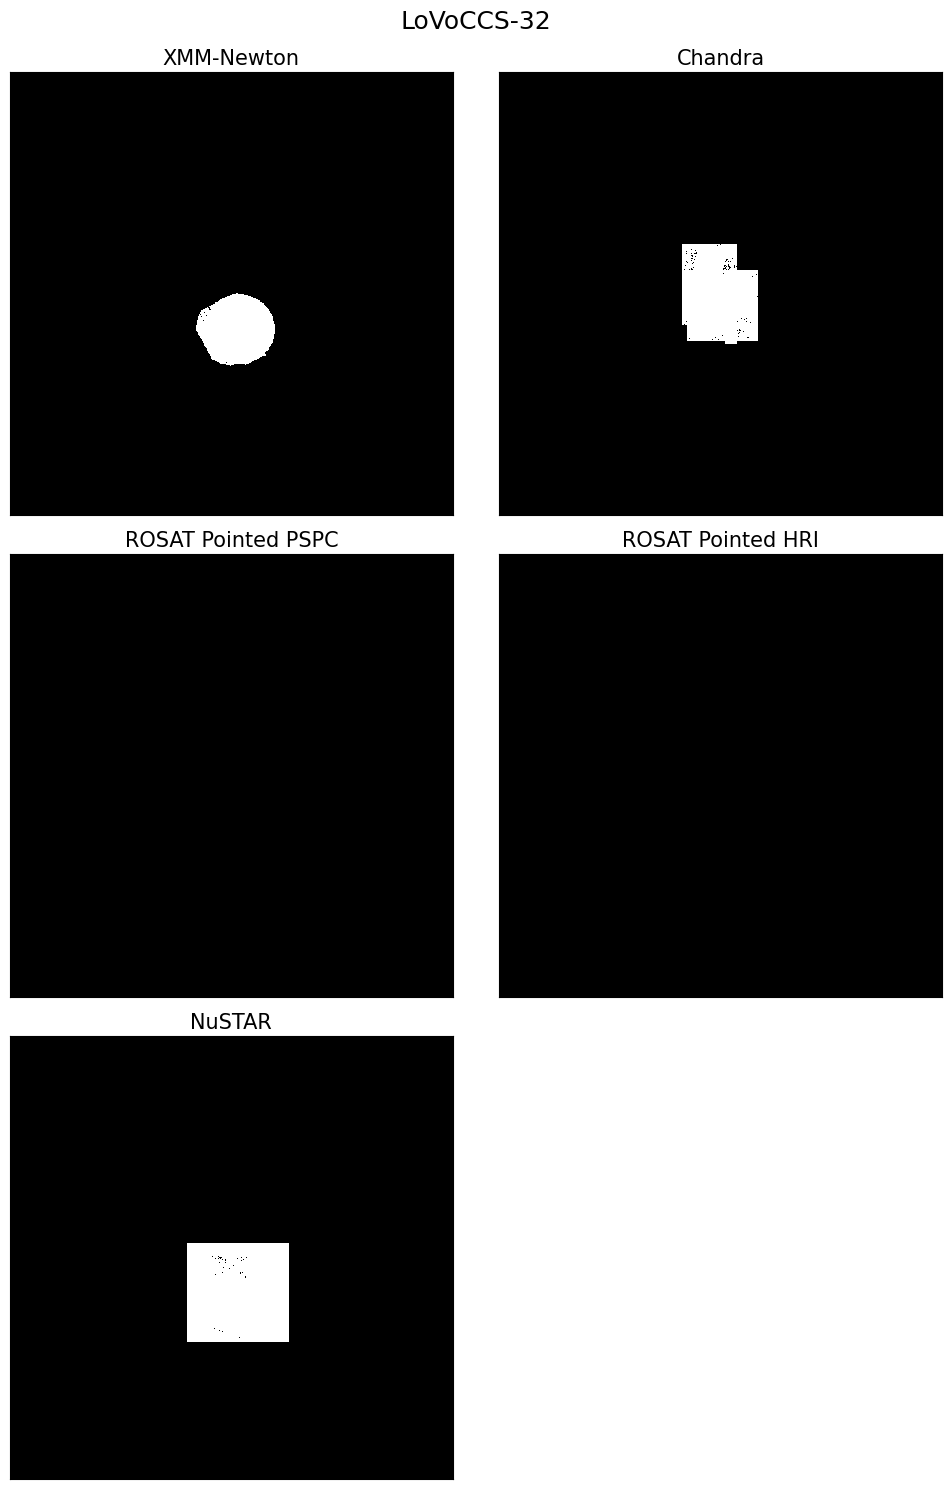

Generating coverage maps:  23%|██▎       | 33/144 [02:20<04:47,  2.59s/it]

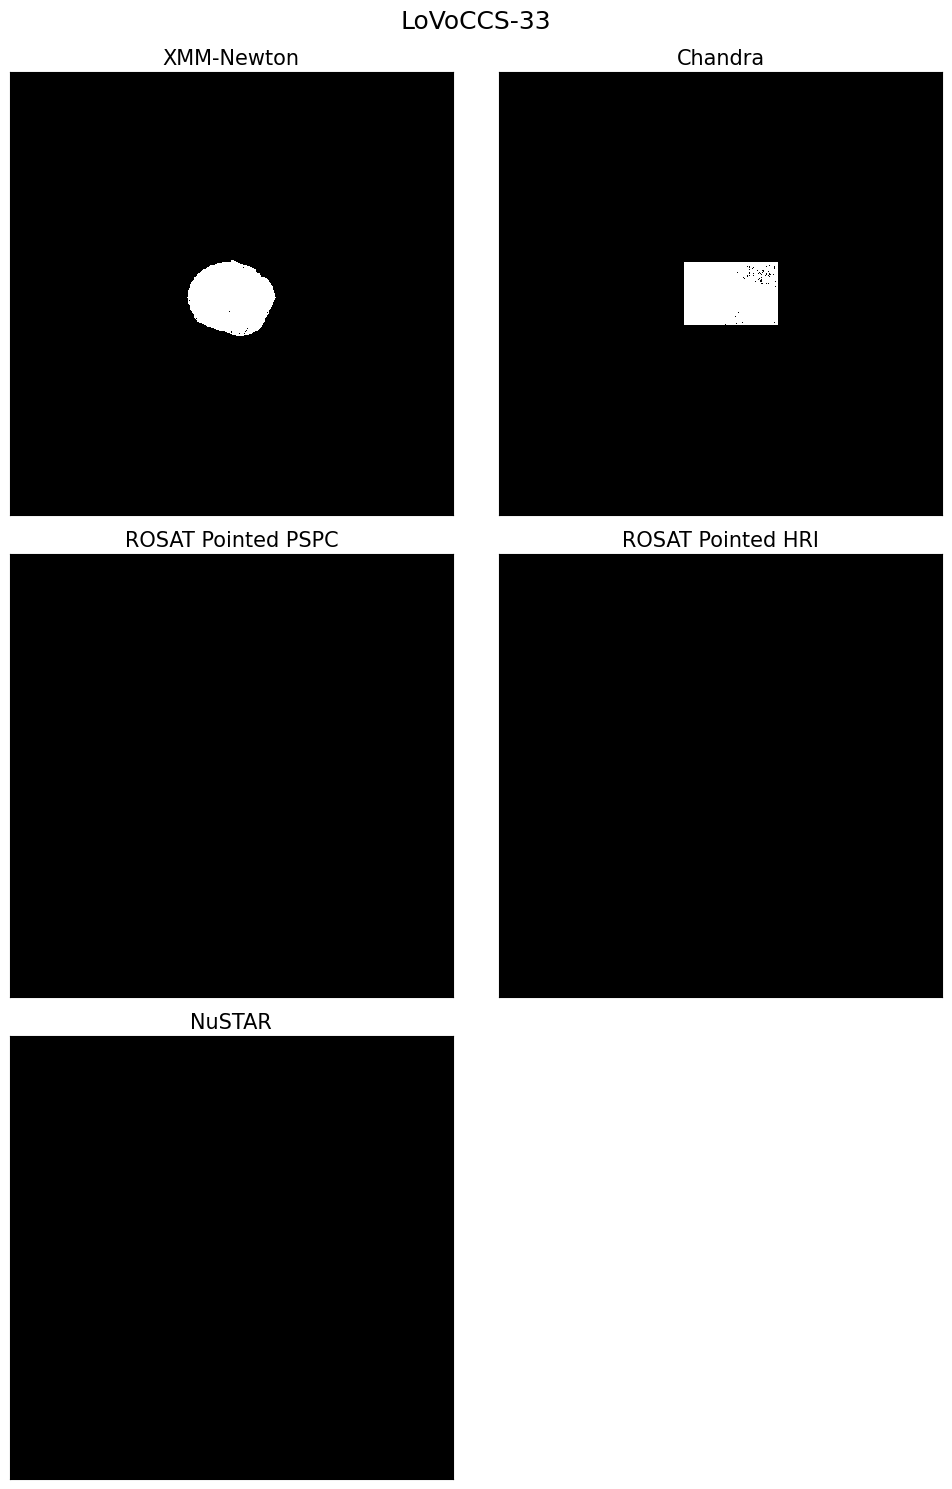

Generating coverage maps:  24%|██▎       | 34/144 [02:22<04:18,  2.35s/it]

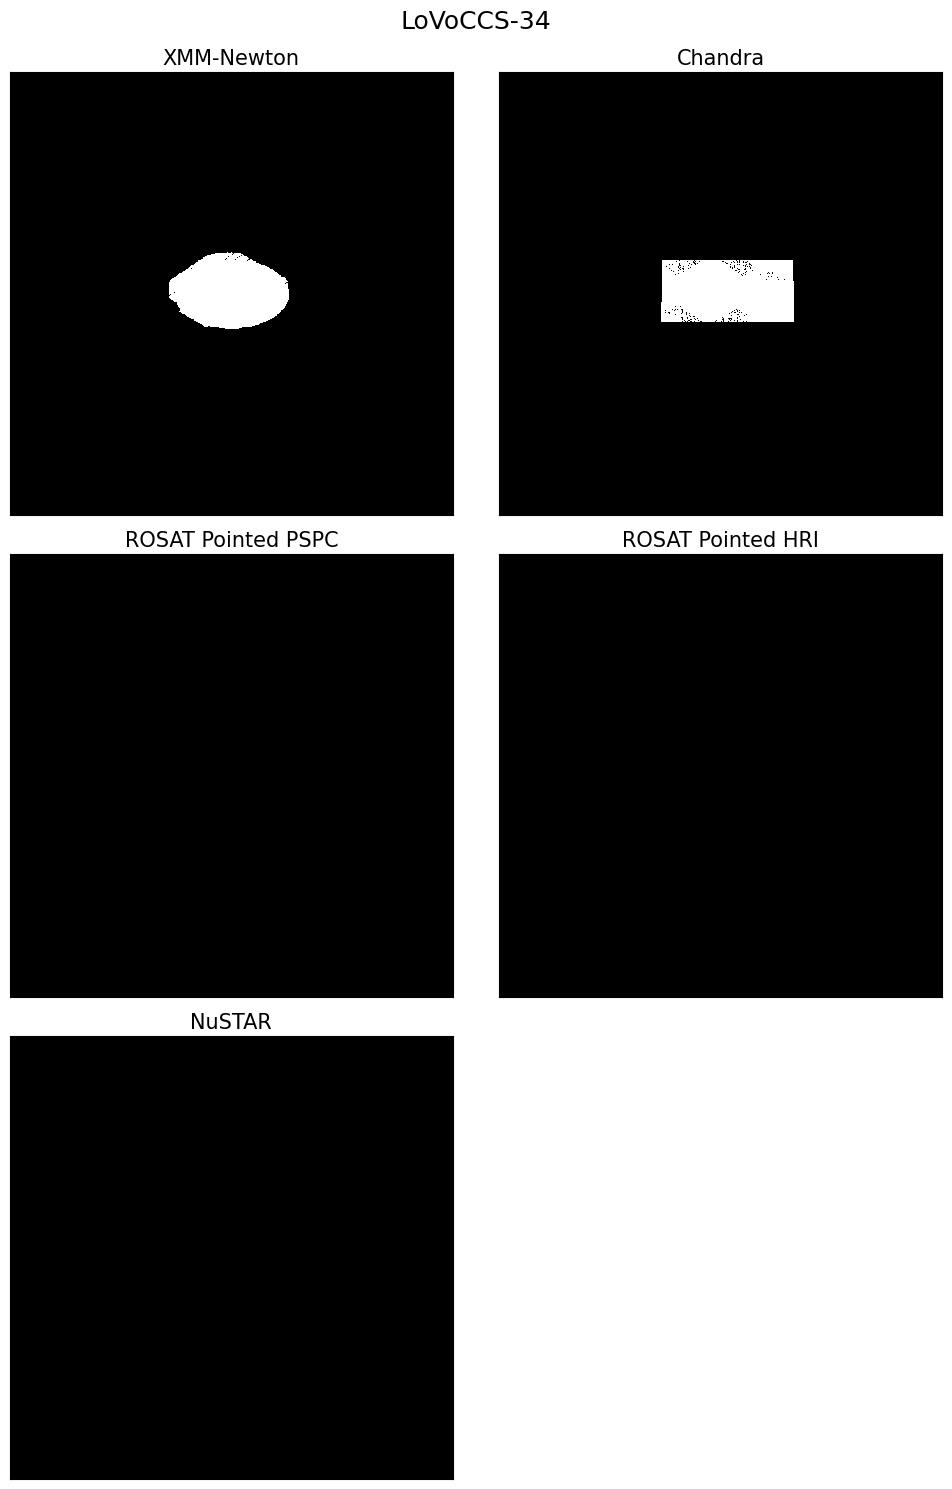

Generating coverage maps:  24%|██▍       | 35/144 [02:23<03:40,  2.02s/it]

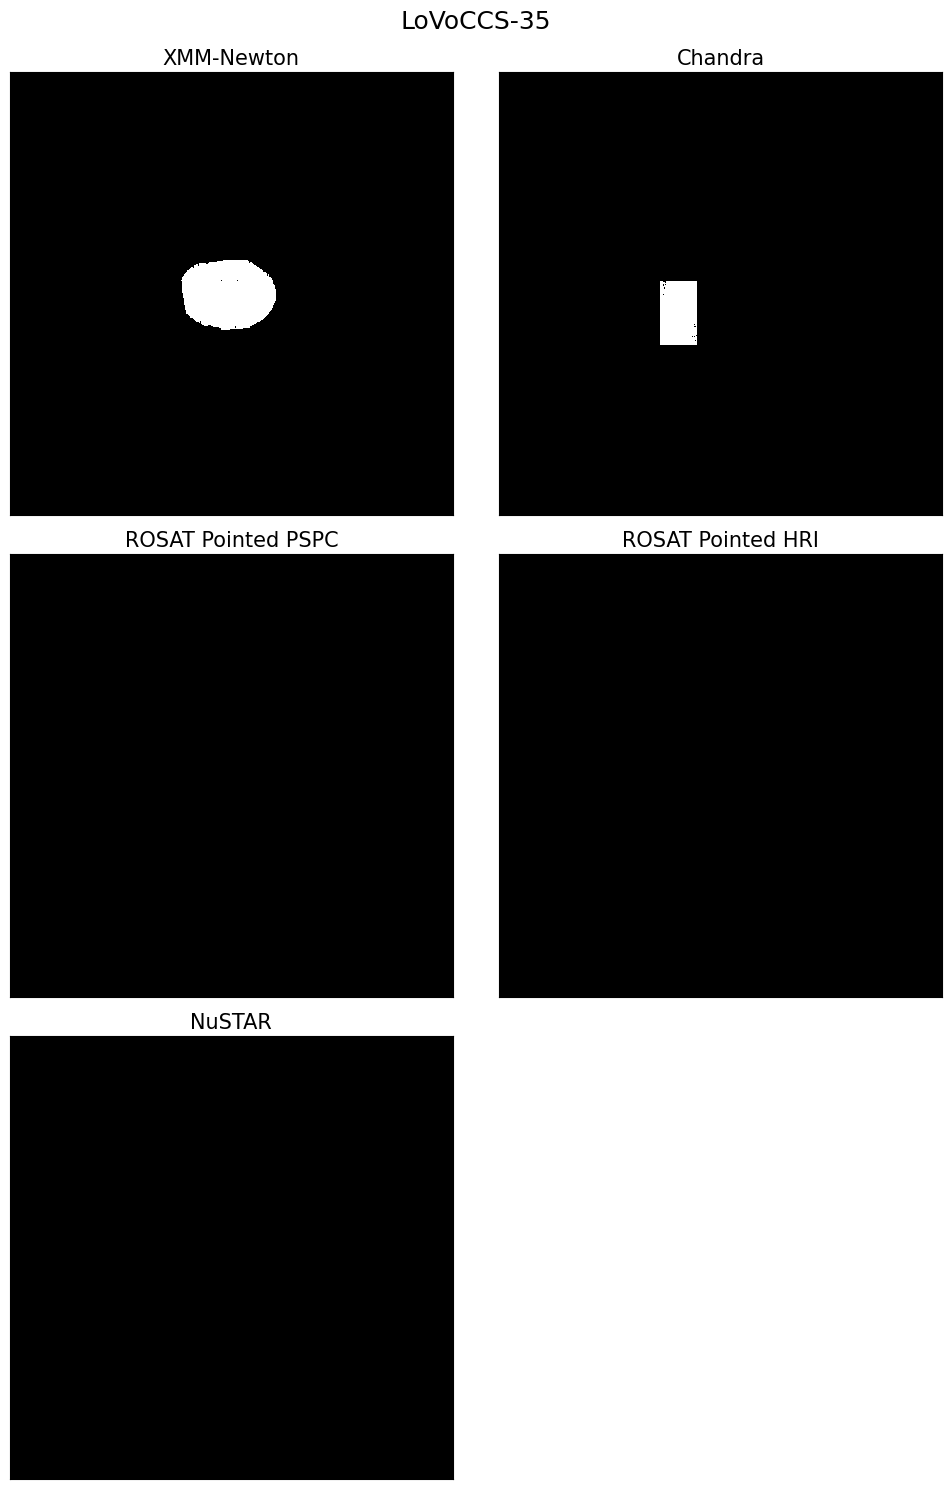

Generating coverage maps:  25%|██▌       | 36/144 [02:25<03:17,  1.83s/it]

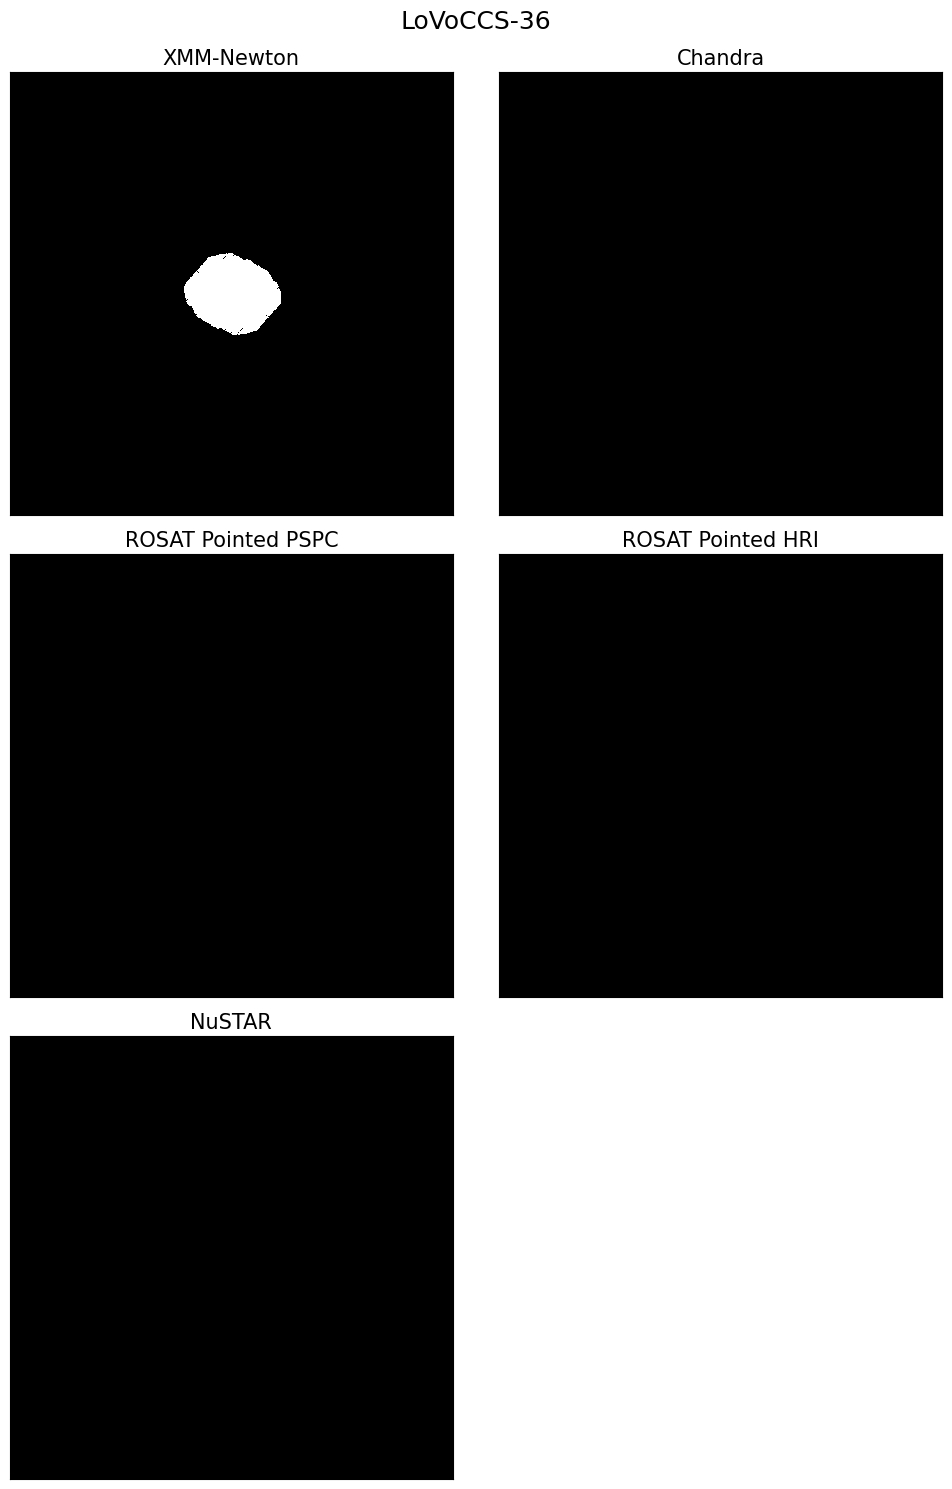

Generating coverage maps:  26%|██▌       | 37/144 [02:26<03:01,  1.69s/it]

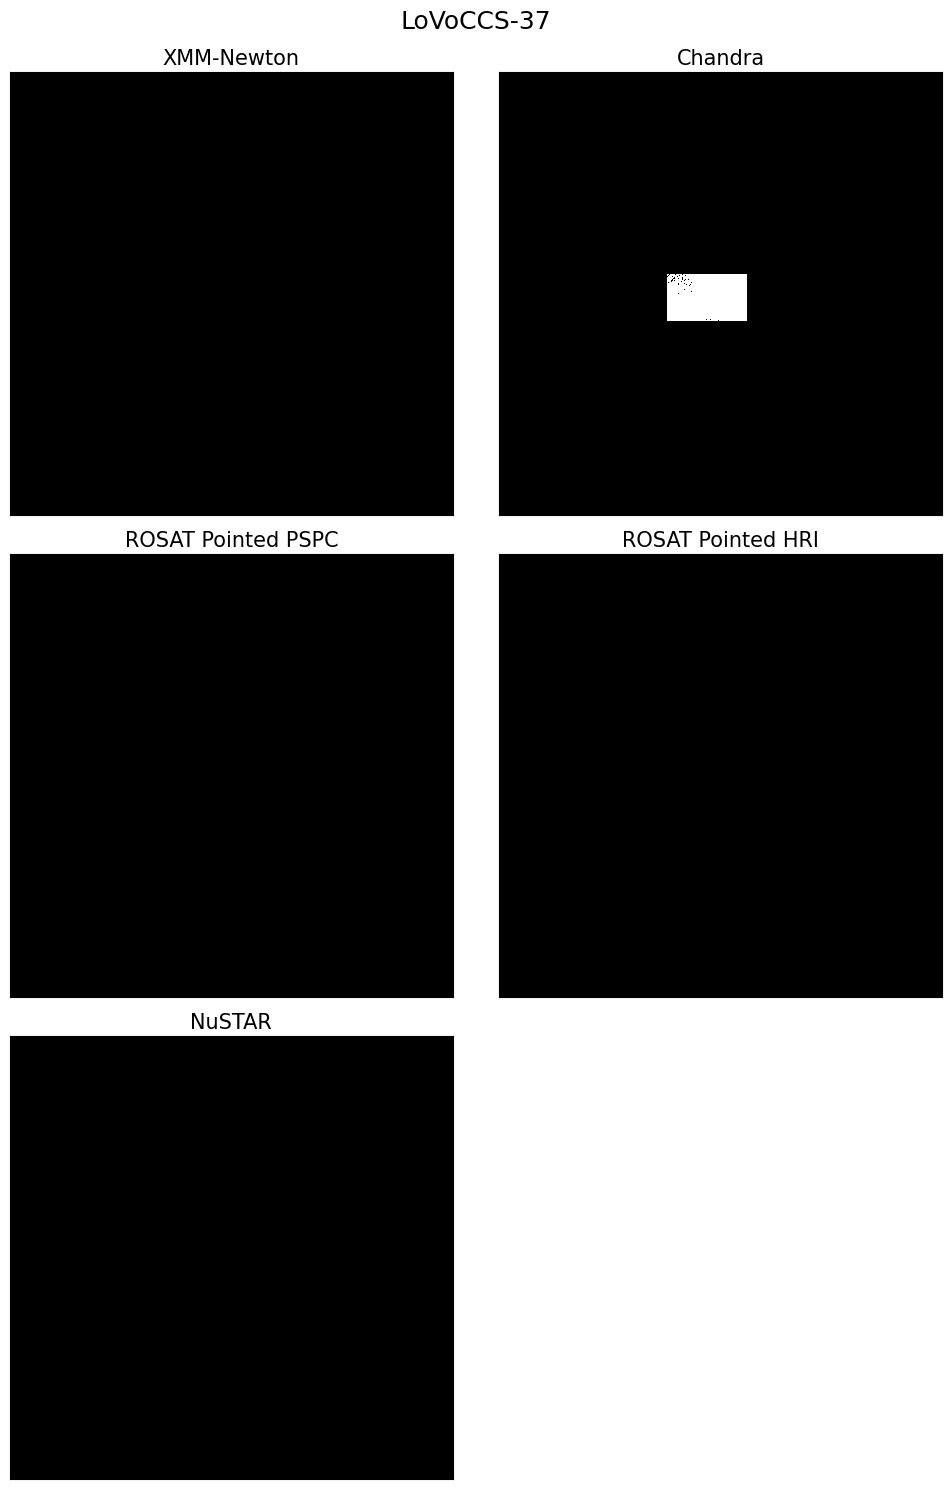

Generating coverage maps:  26%|██▋       | 38/144 [02:28<03:00,  1.70s/it]

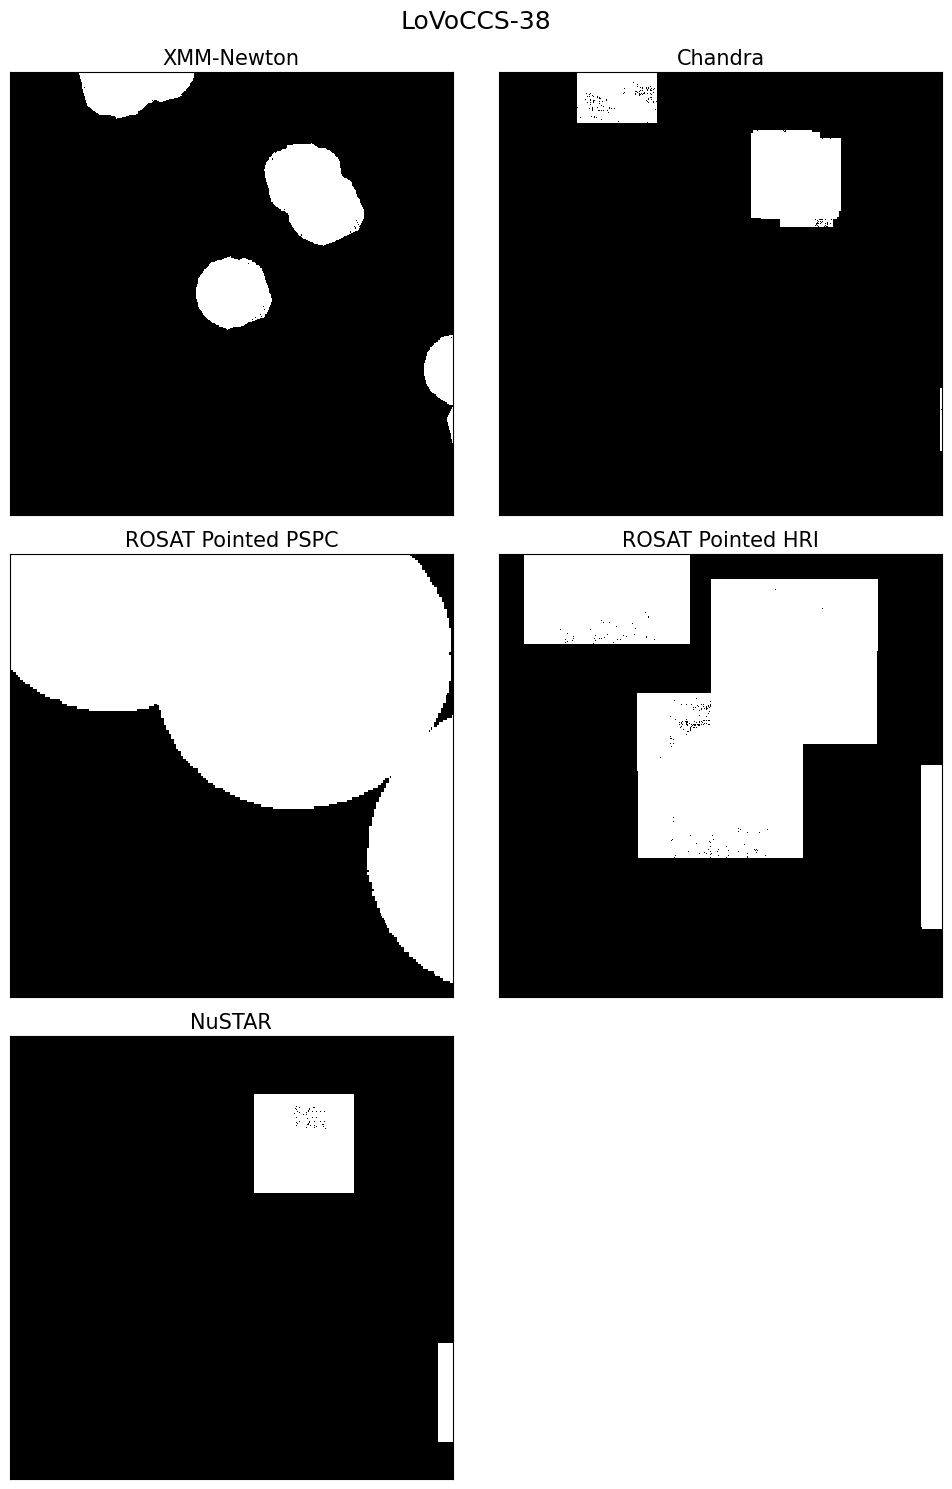

Generating coverage maps:  27%|██▋       | 39/144 [02:37<06:45,  3.86s/it]

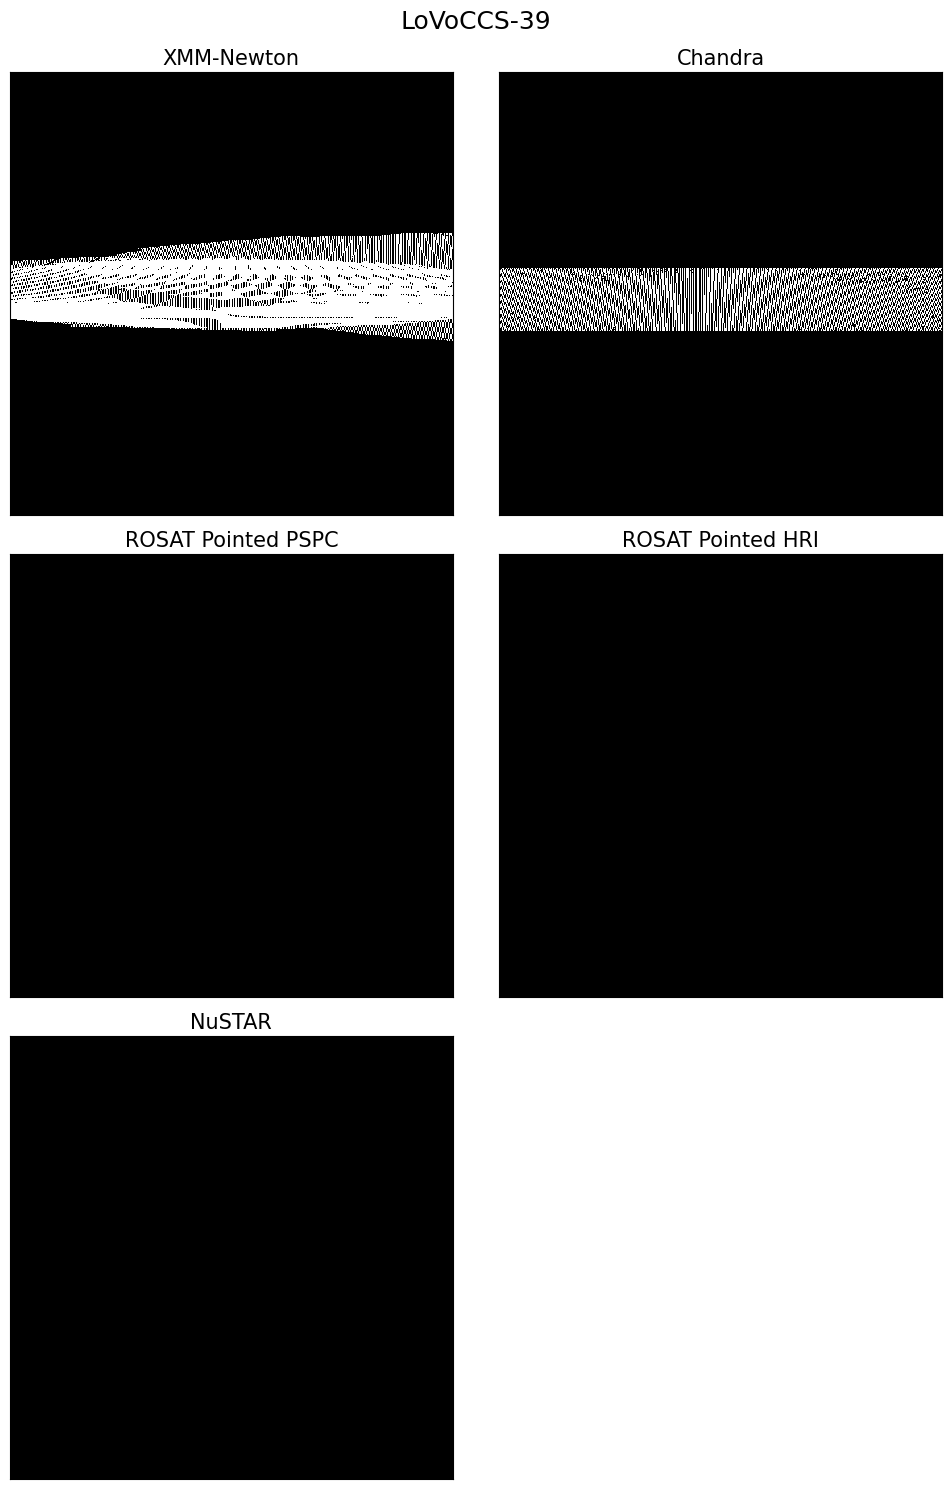

Generating coverage maps:  28%|██▊       | 40/144 [02:38<05:41,  3.29s/it]

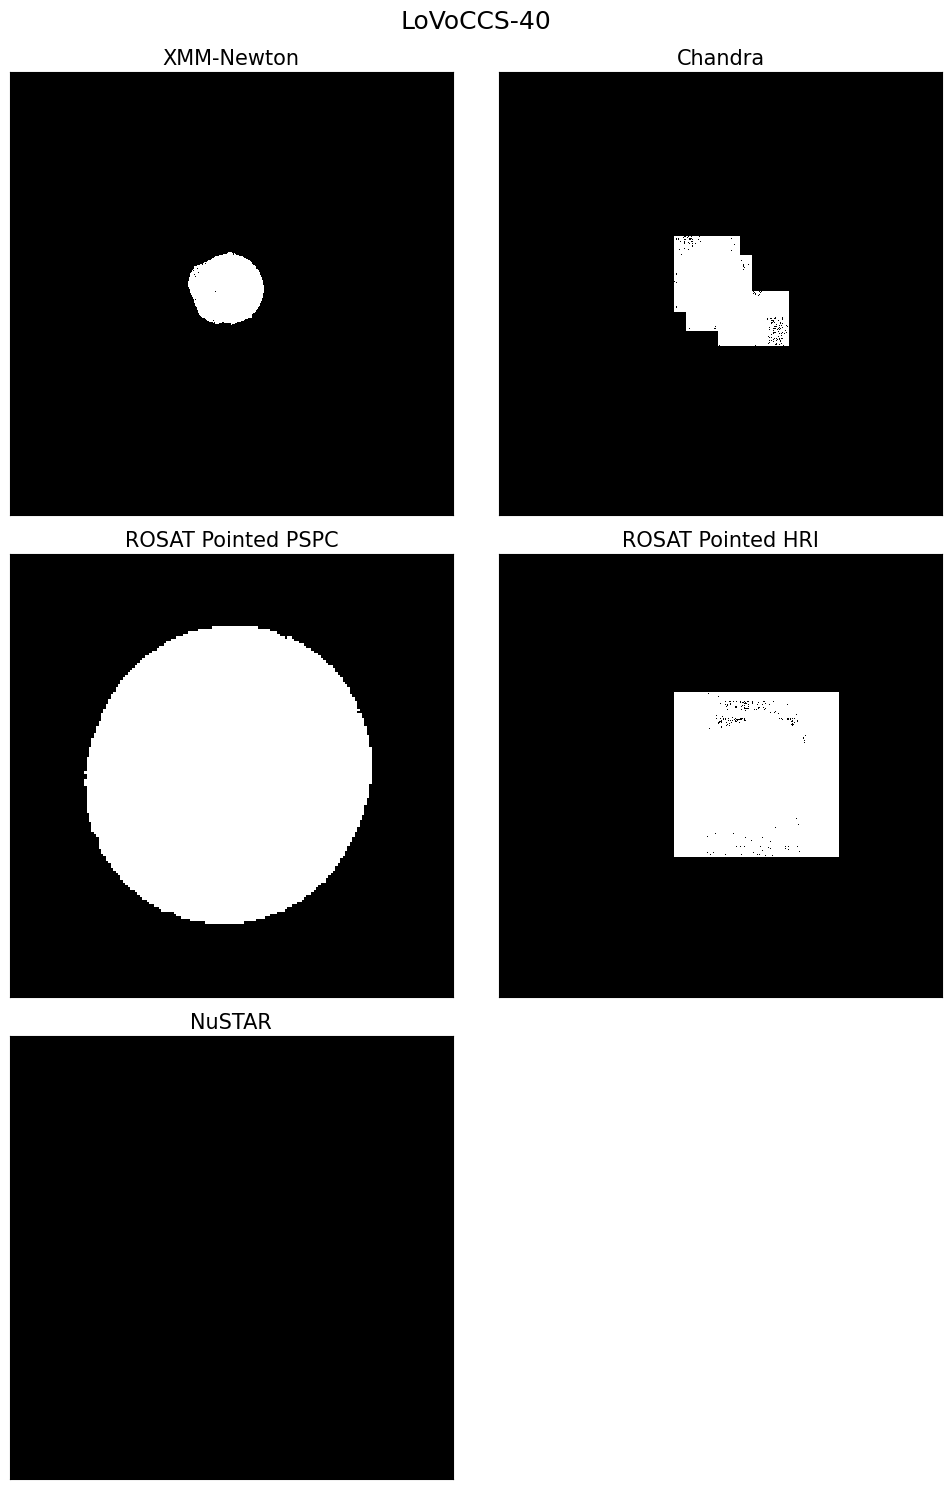

Generating coverage maps:  28%|██▊       | 41/144 [02:40<04:44,  2.76s/it]

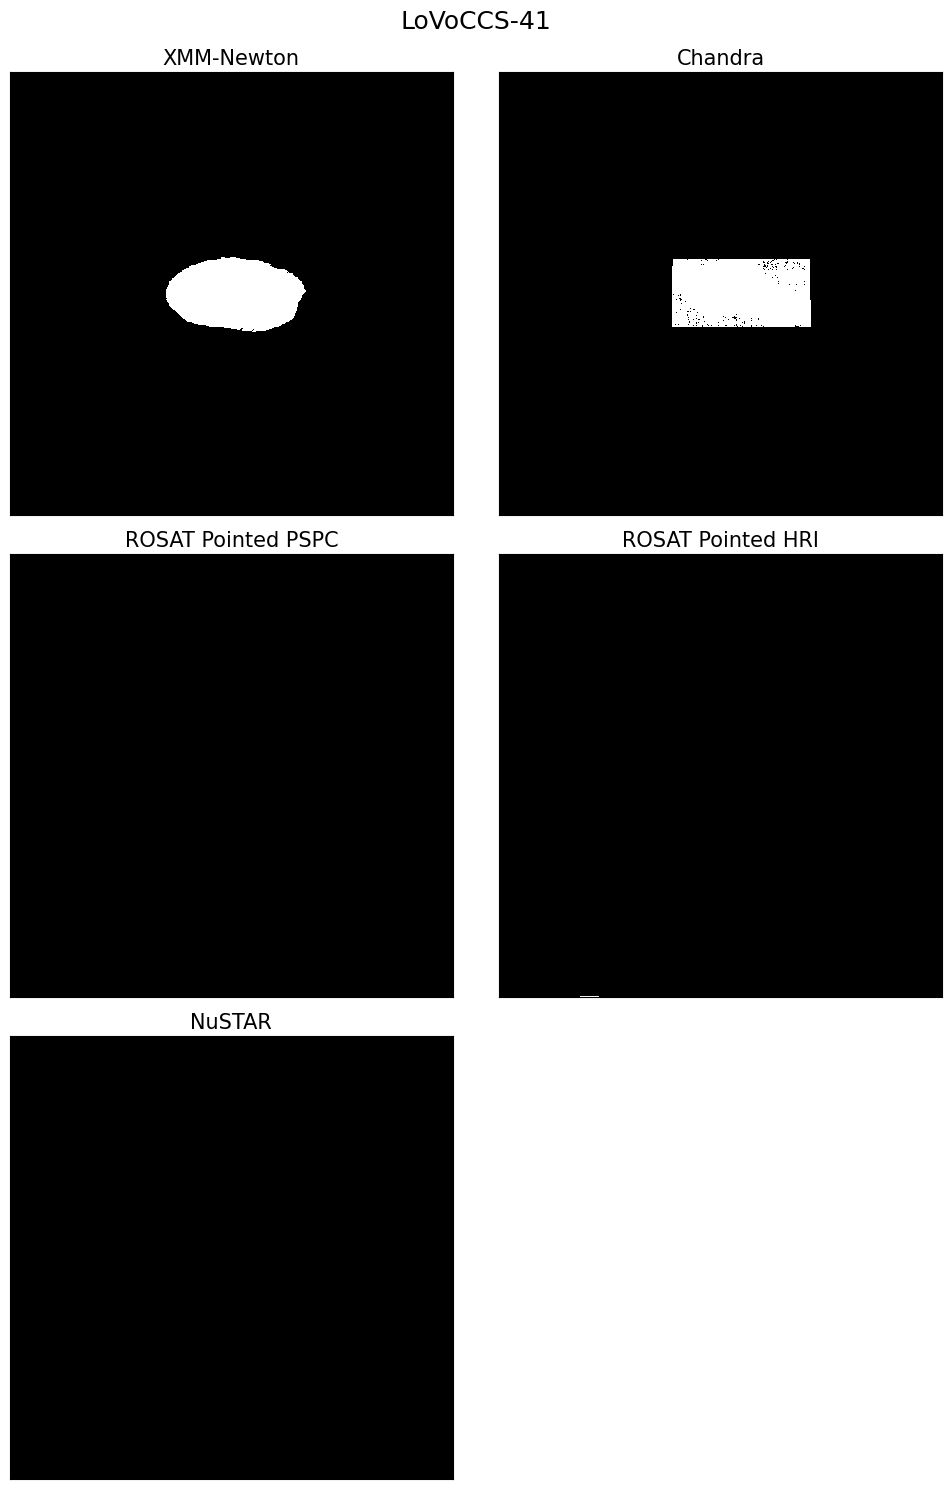

Generating coverage maps:  29%|██▉       | 42/144 [02:43<04:52,  2.86s/it]

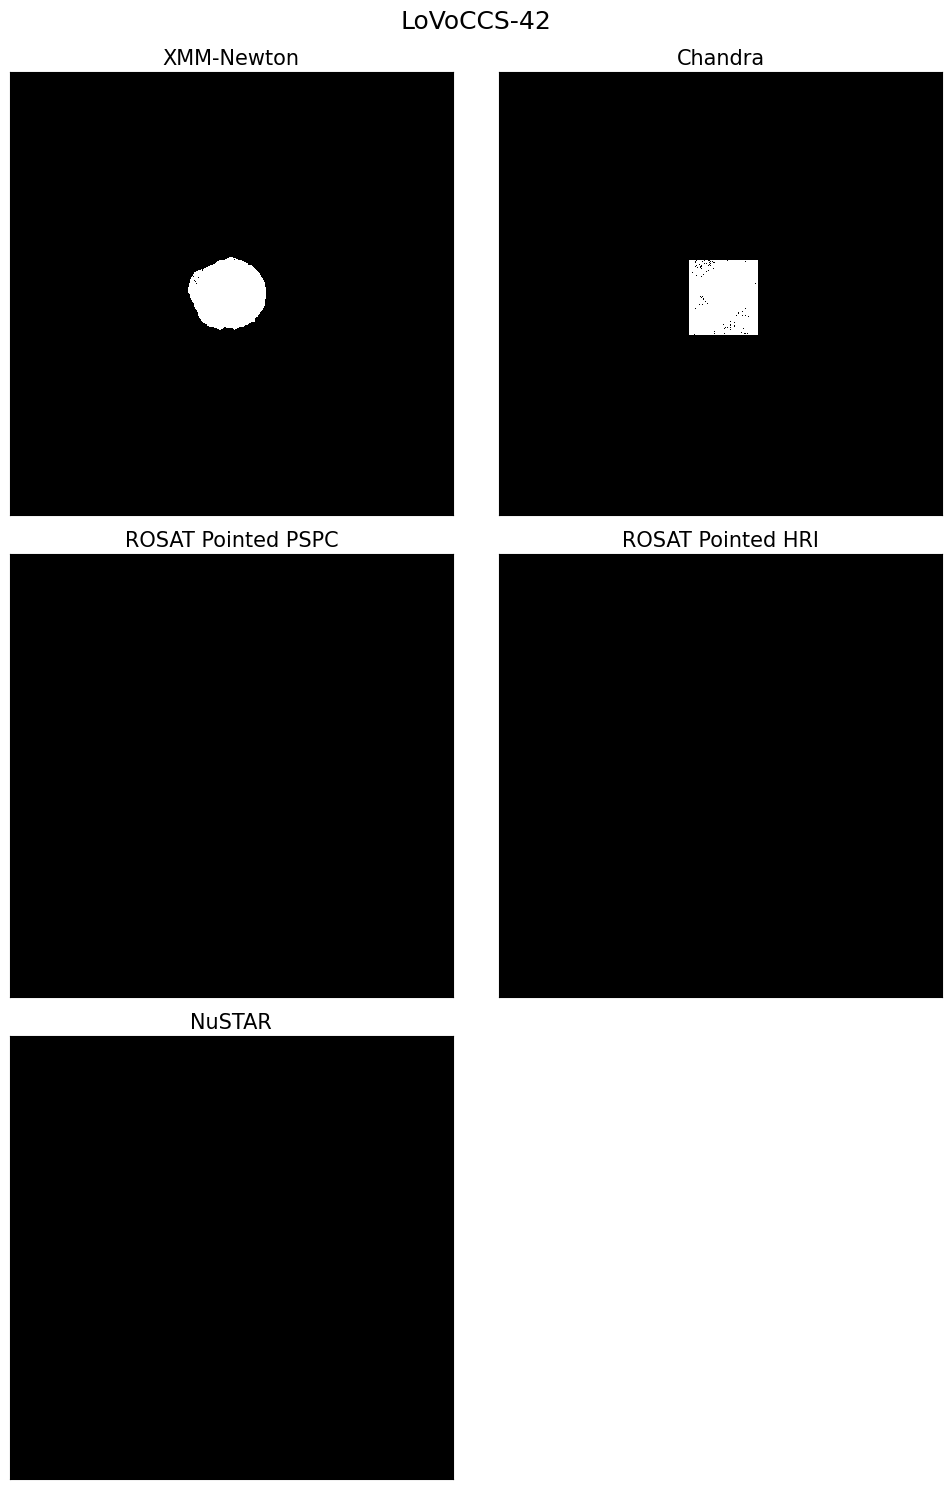

Generating coverage maps:  30%|██▉       | 43/144 [02:44<04:00,  2.38s/it]

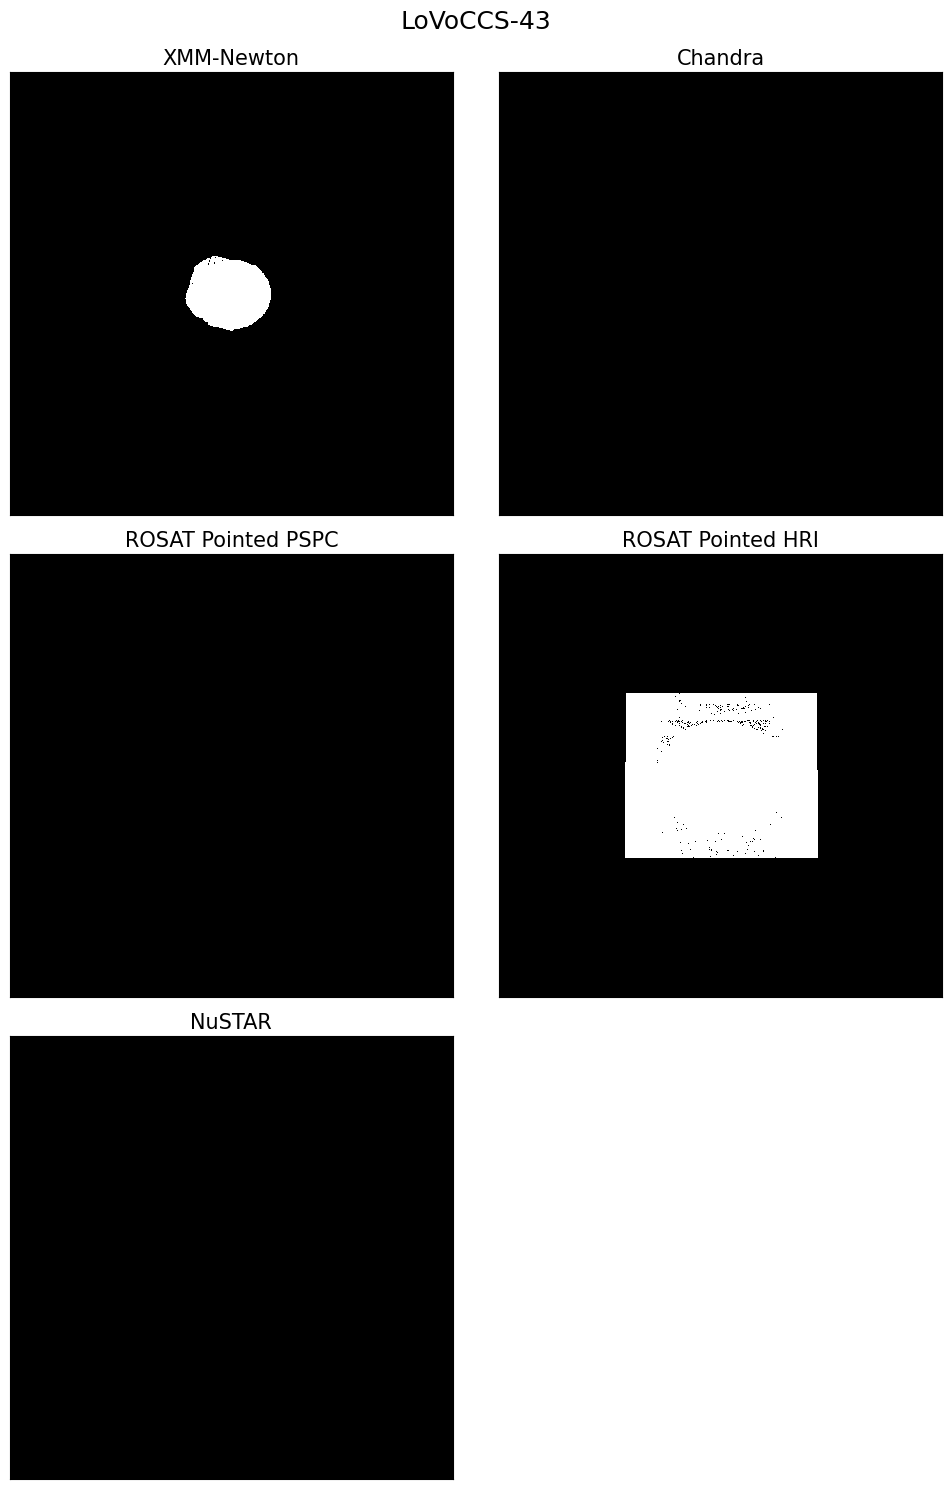

Generating coverage maps:  31%|███       | 44/144 [02:46<03:25,  2.05s/it]

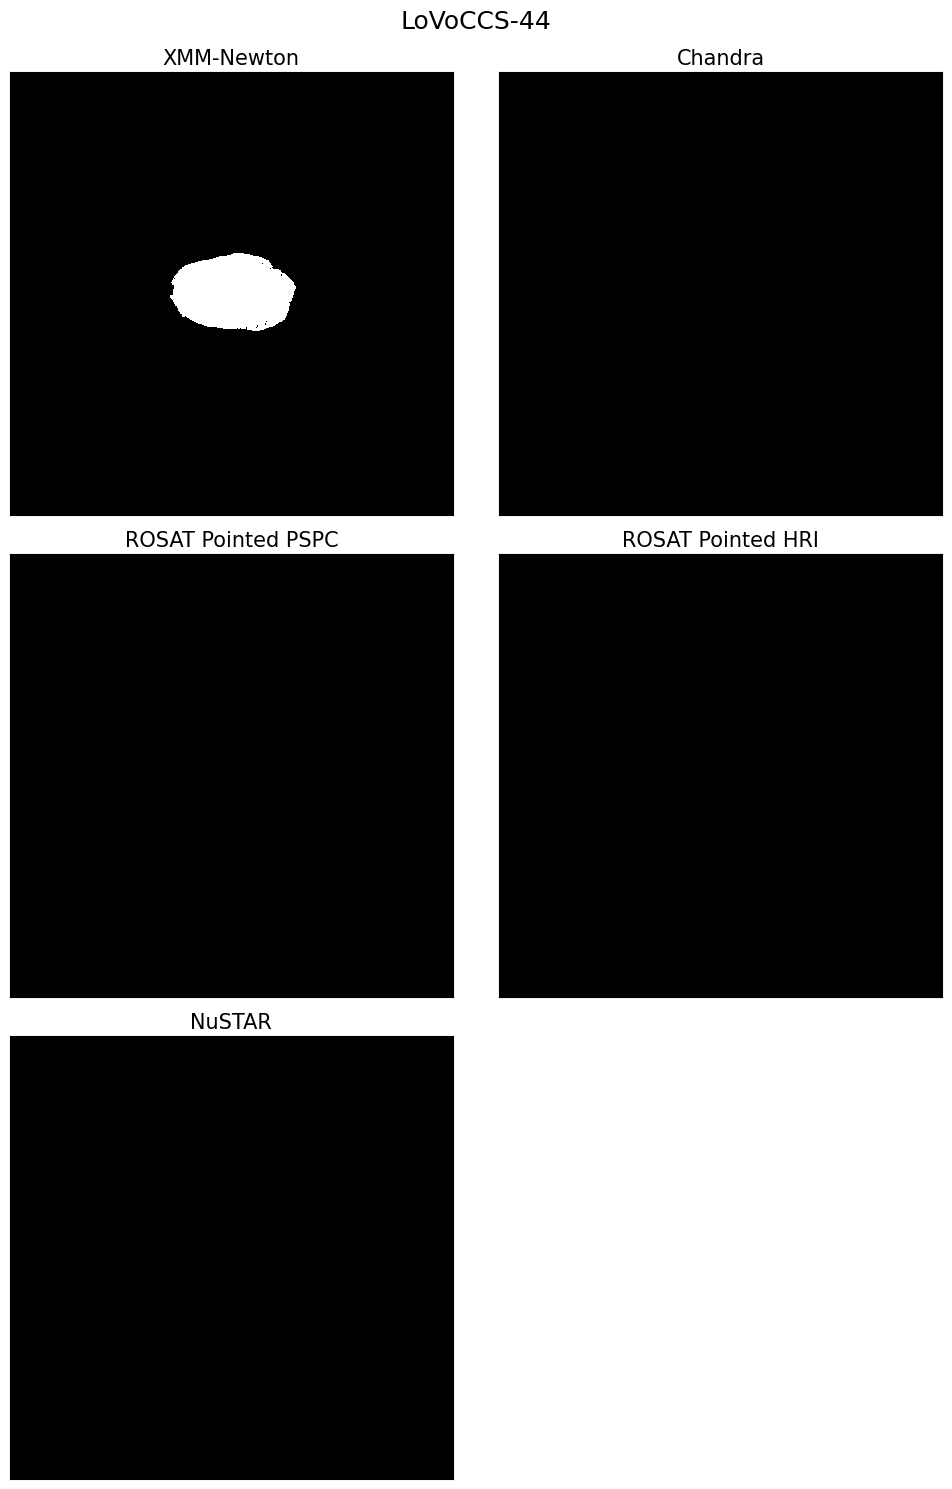

Generating coverage maps:  31%|███▏      | 45/144 [02:47<03:08,  1.91s/it]

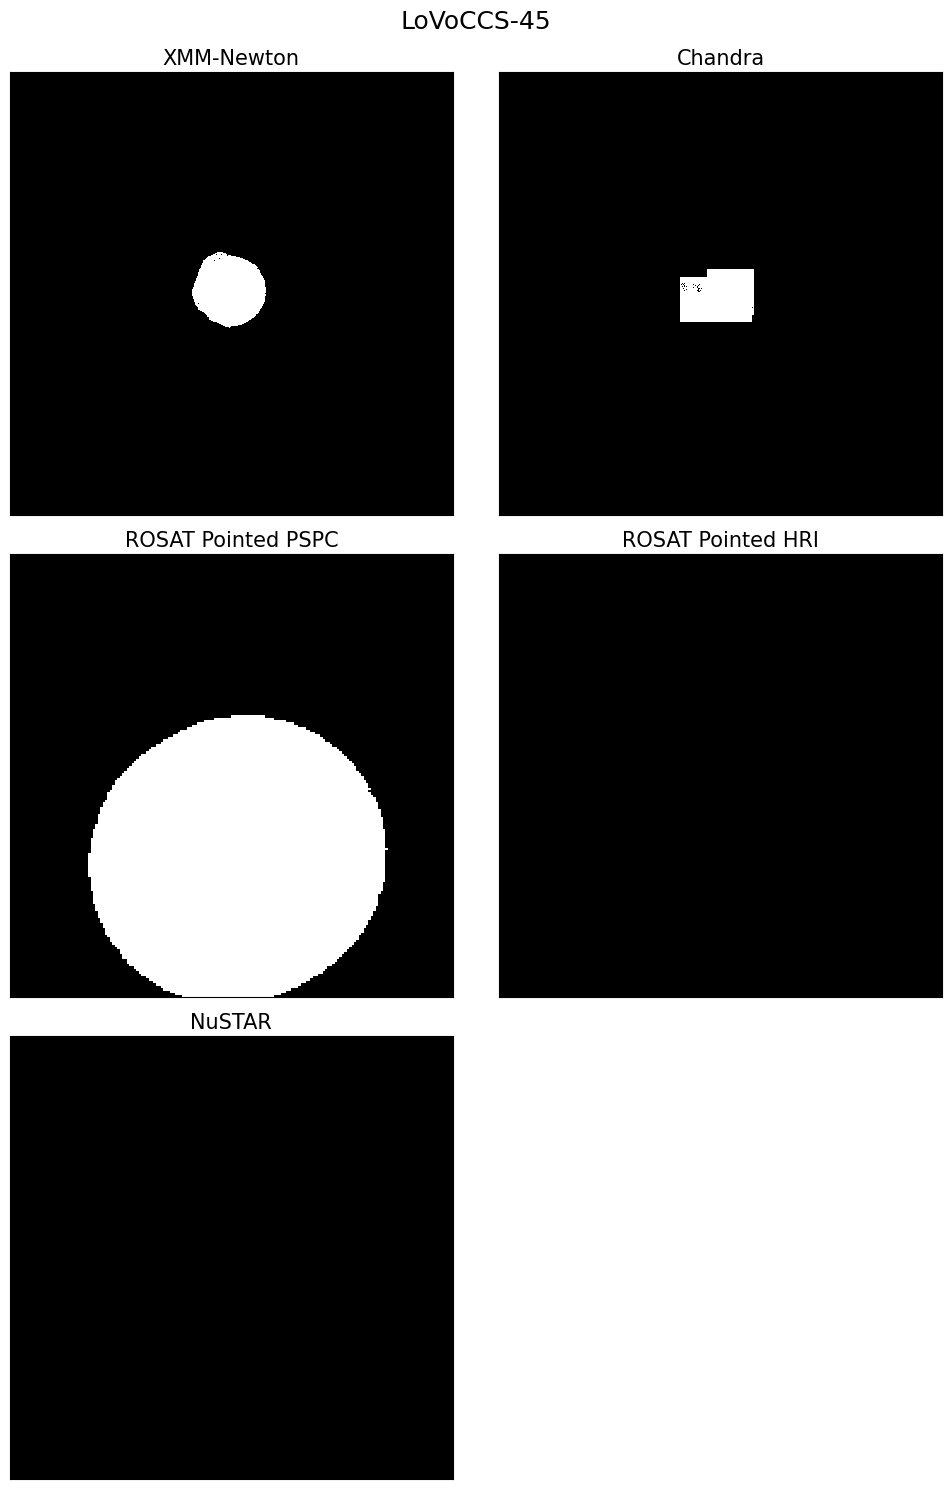

Generating coverage maps:  32%|███▏      | 46/144 [02:50<03:28,  2.13s/it]

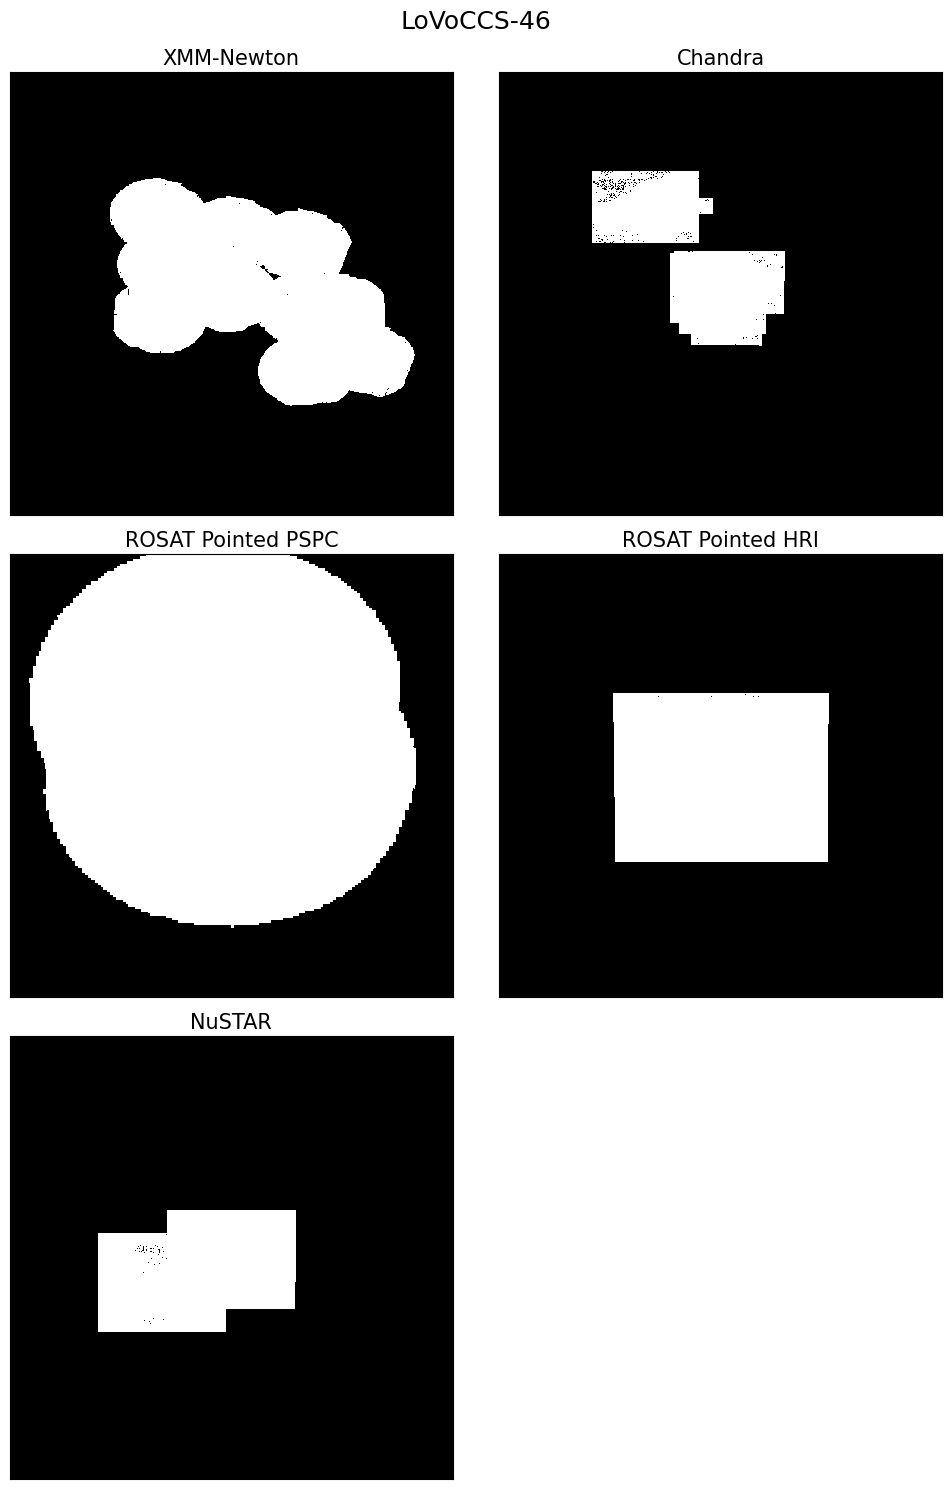

Generating coverage maps:  33%|███▎      | 47/144 [02:55<04:51,  3.01s/it]

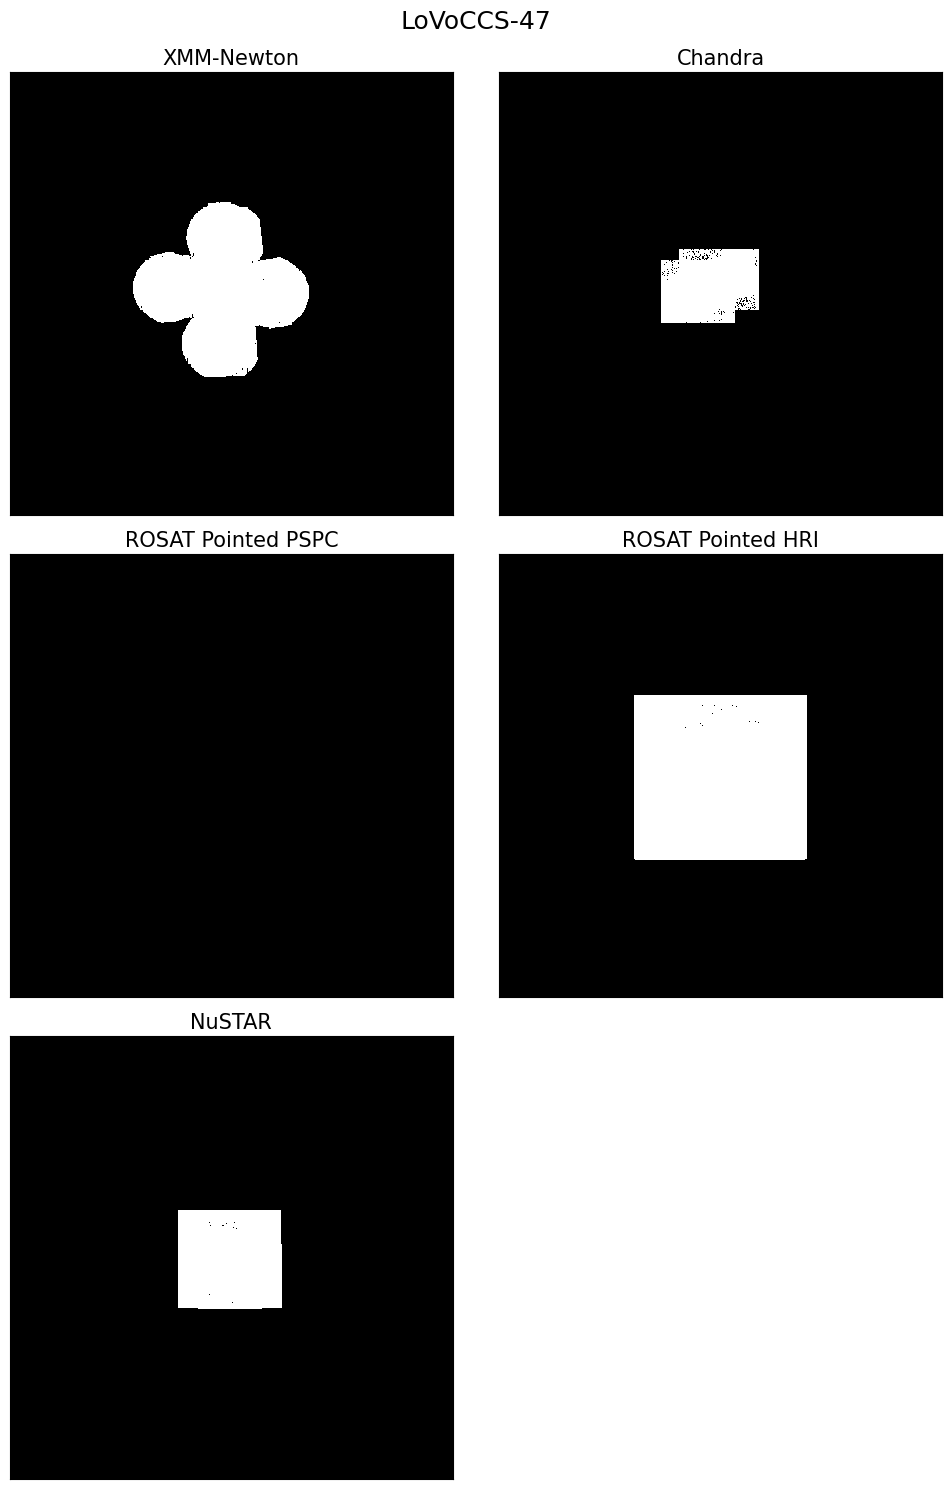

Generating coverage maps:  33%|███▎      | 48/144 [02:57<04:27,  2.79s/it]

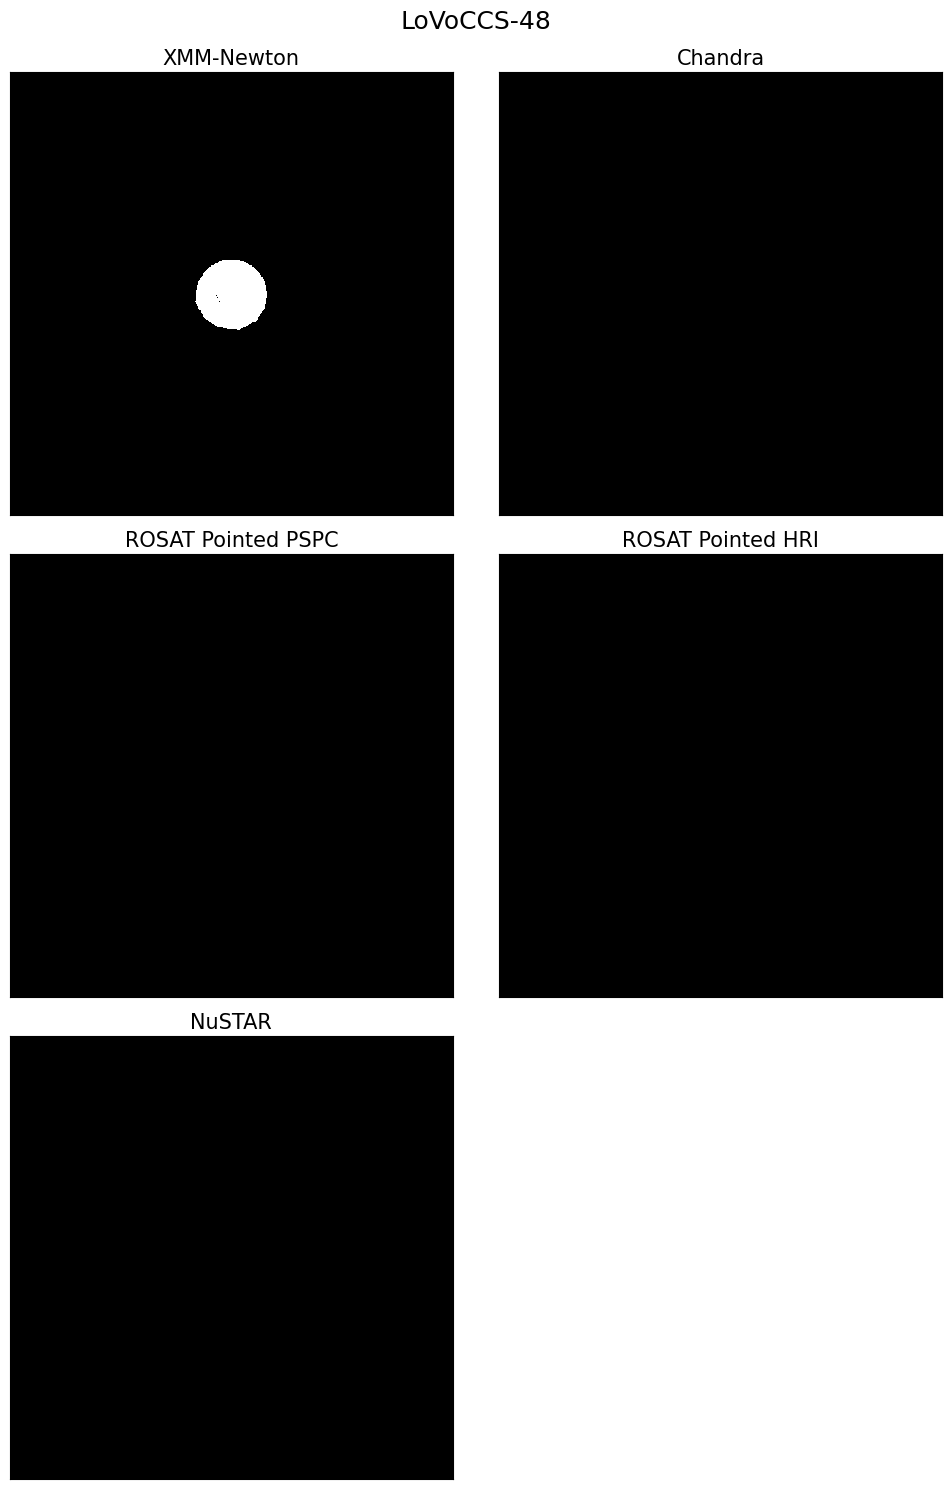

Generating coverage maps:  34%|███▍      | 49/144 [02:59<03:54,  2.47s/it]

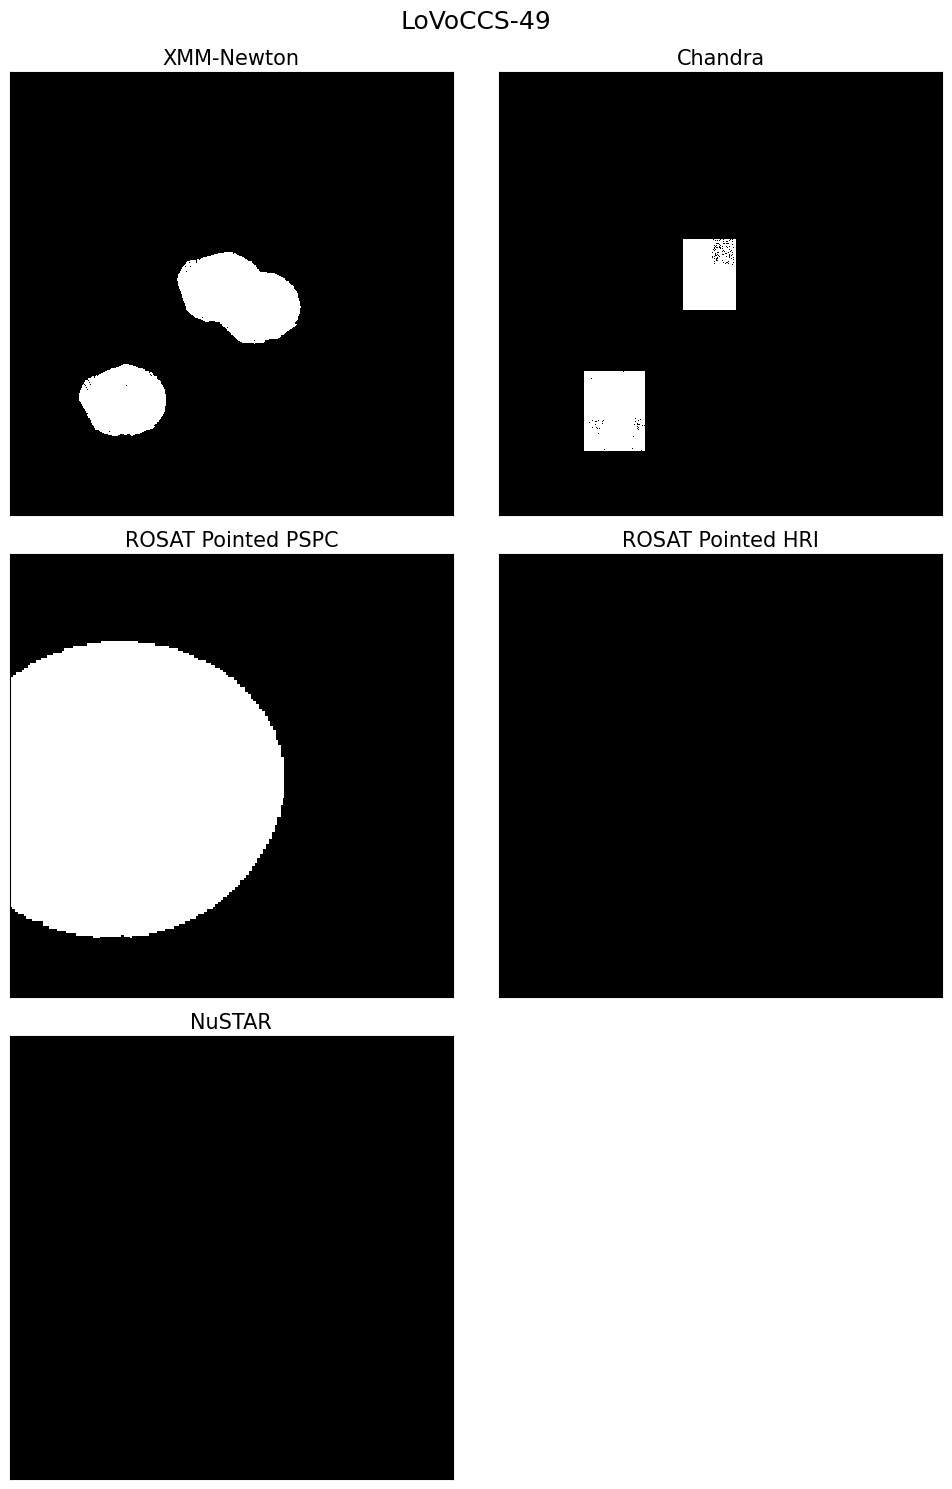

Generating coverage maps:  35%|███▍      | 50/144 [03:03<04:24,  2.82s/it]

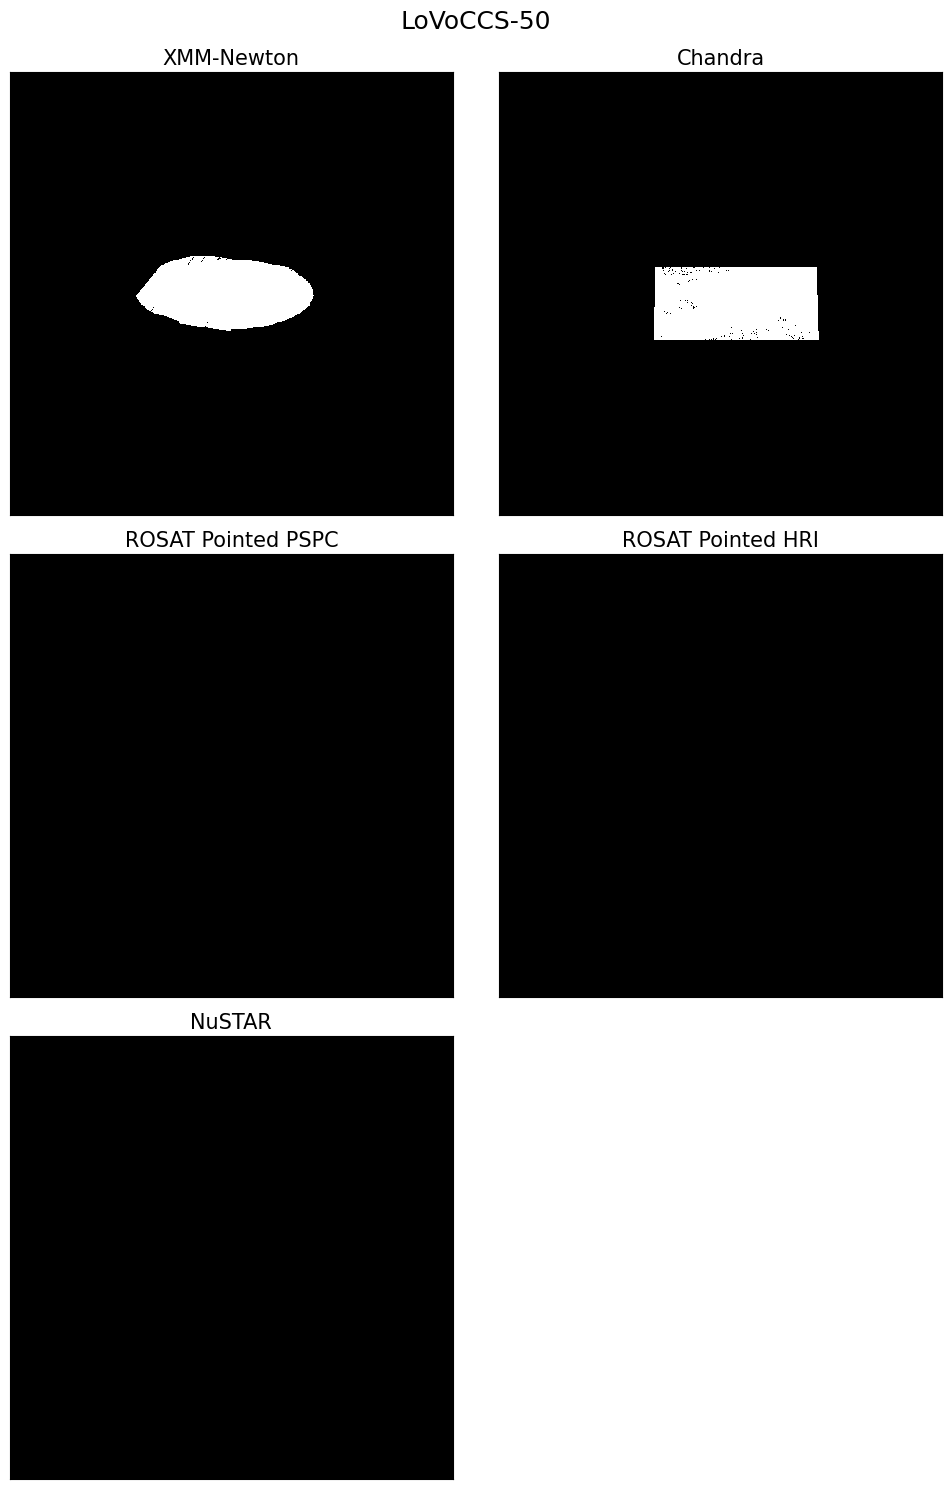

Generating coverage maps:  35%|███▌      | 51/144 [03:04<03:38,  2.35s/it]

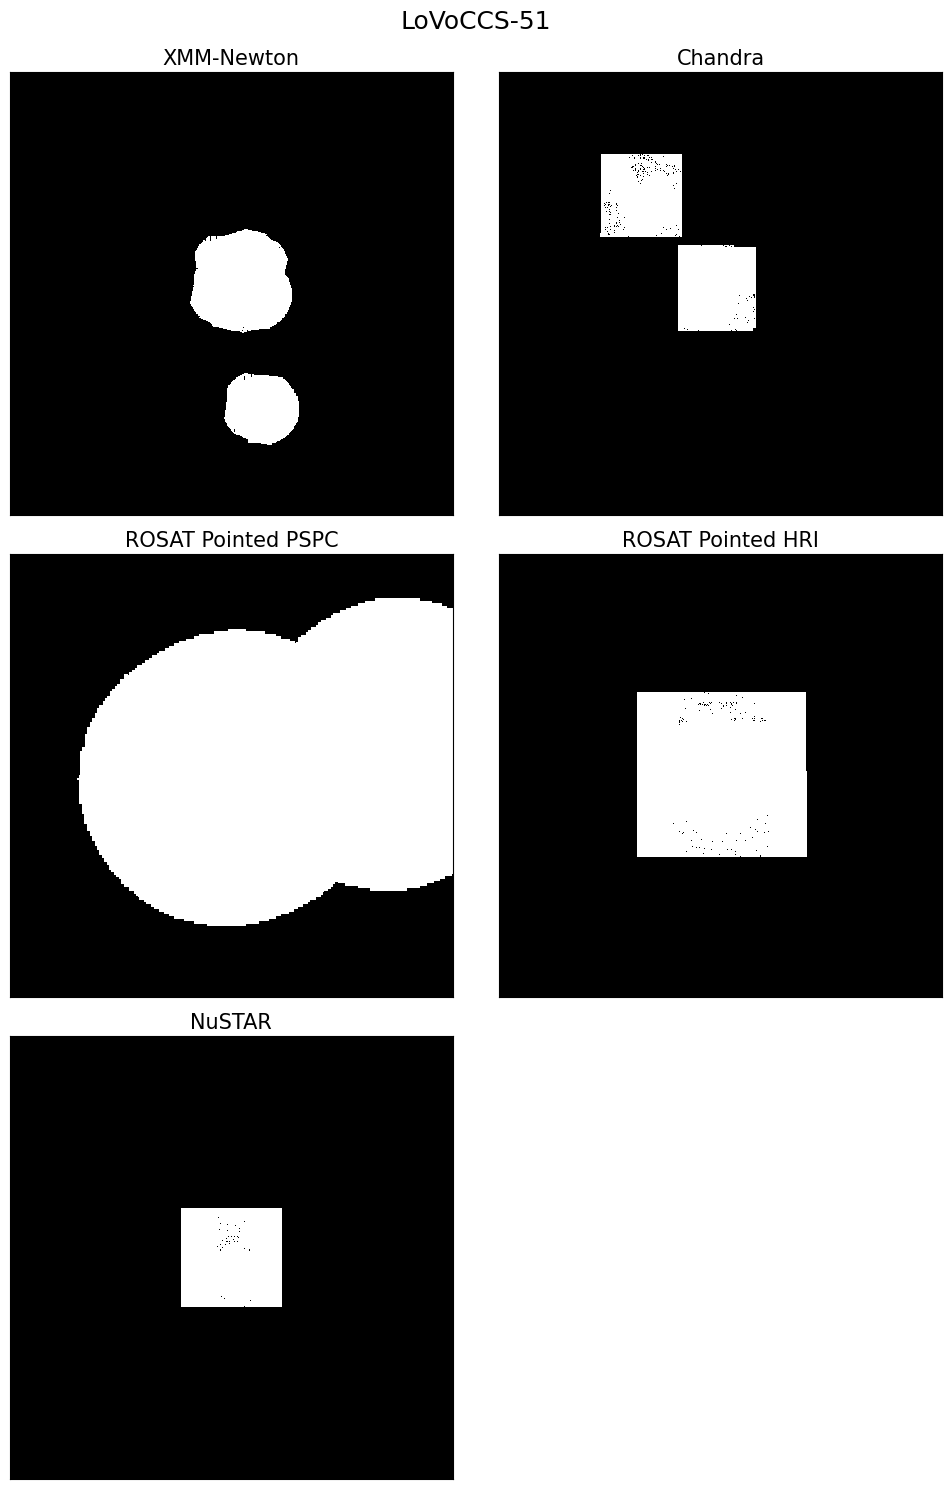

Generating coverage maps:  36%|███▌      | 52/144 [03:07<03:51,  2.52s/it]

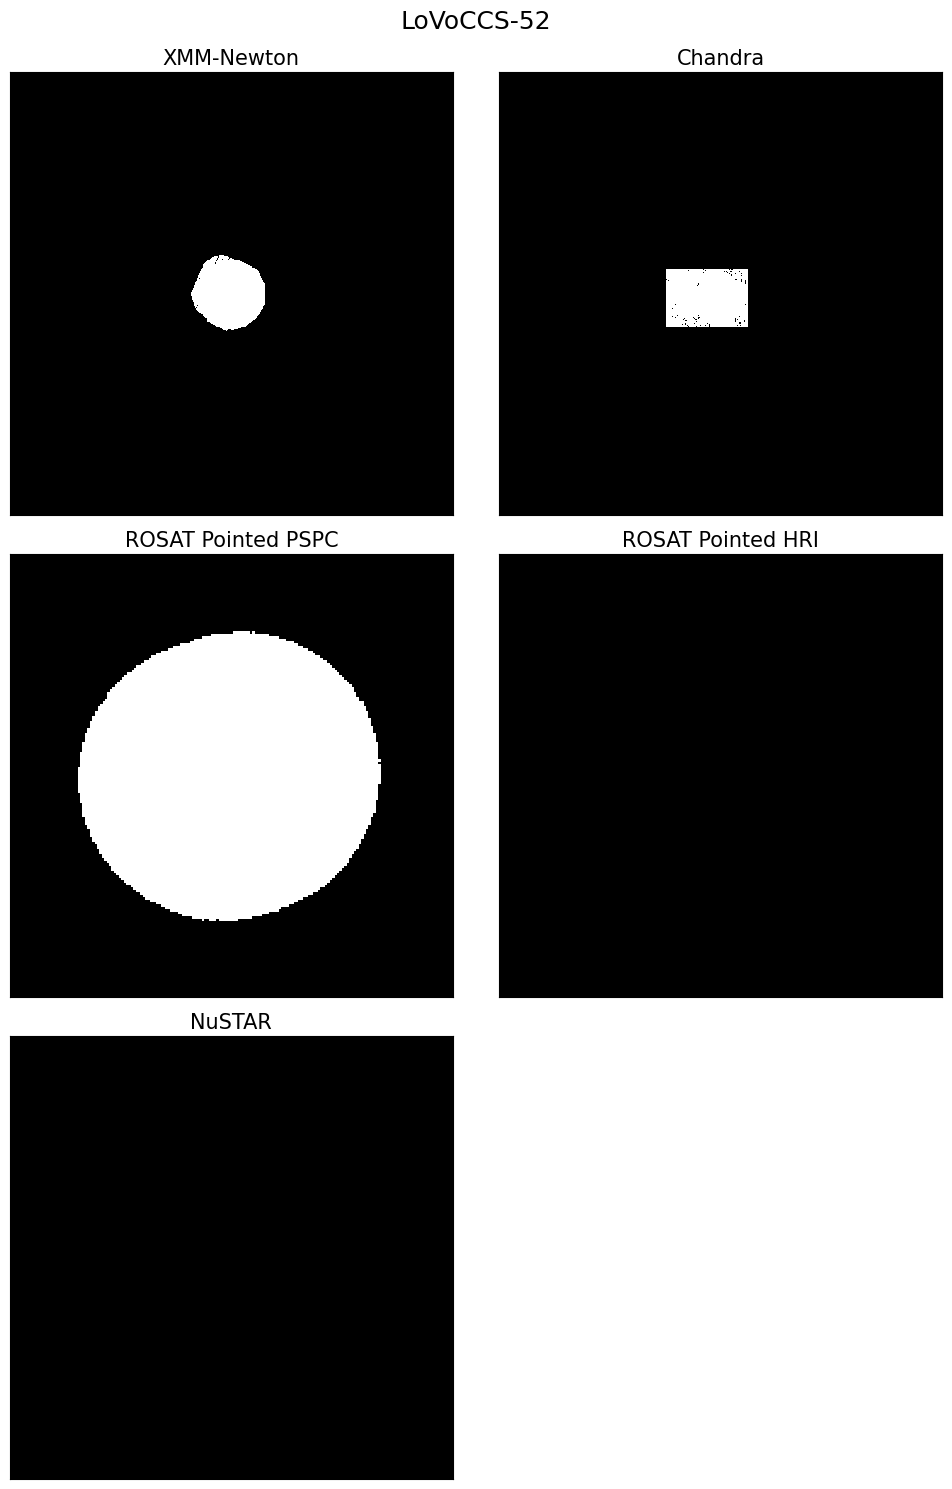

Generating coverage maps:  37%|███▋      | 53/144 [03:08<03:18,  2.19s/it]

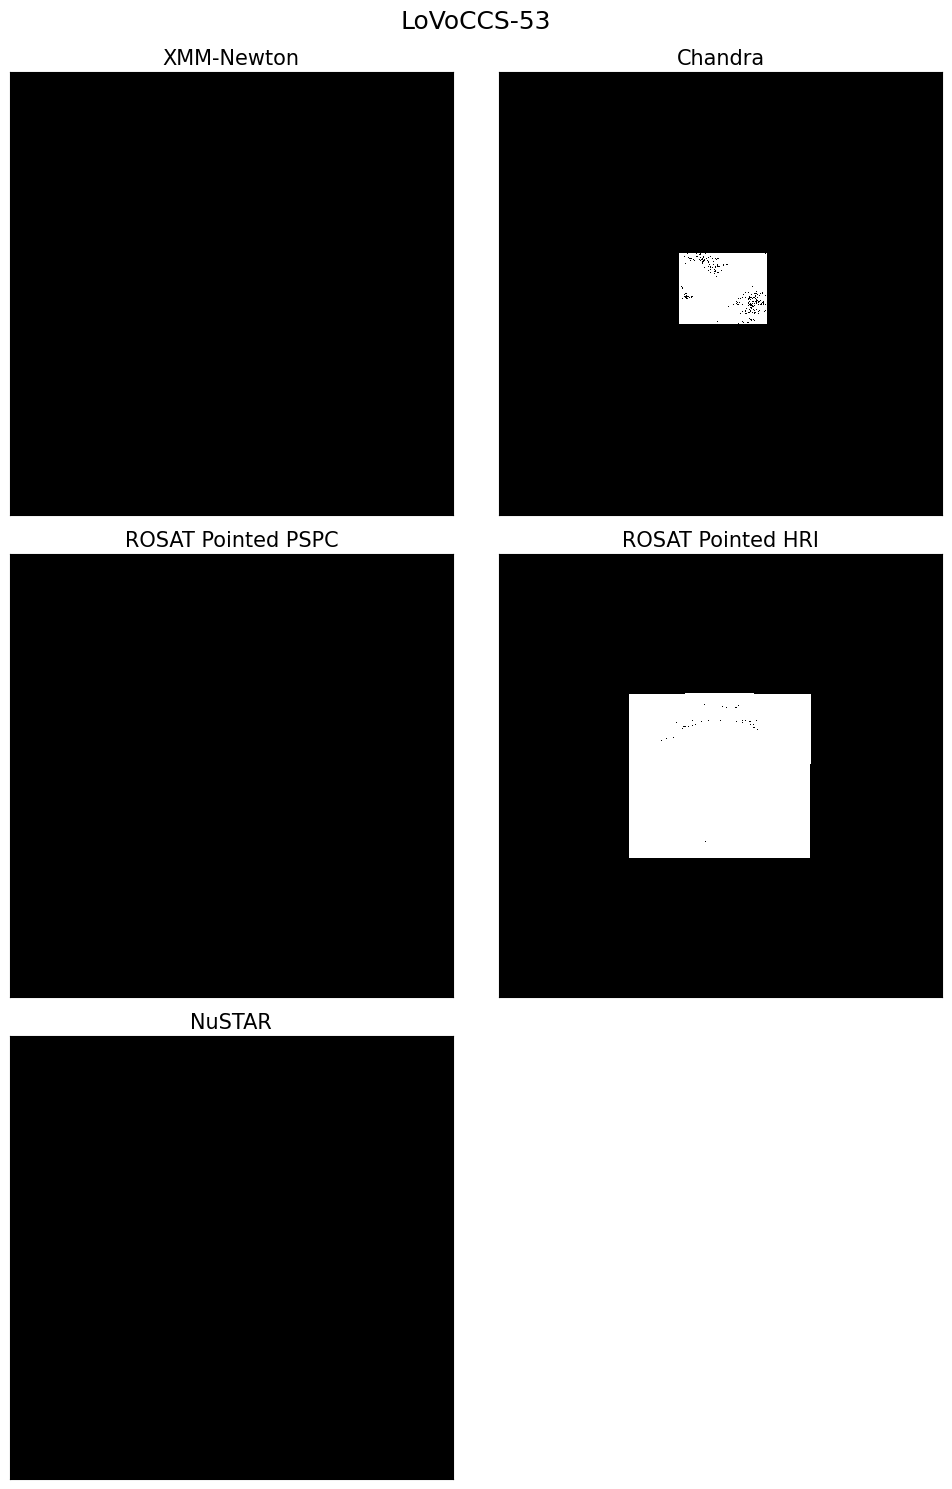

Generating coverage maps:  38%|███▊      | 54/144 [03:09<02:54,  1.93s/it]

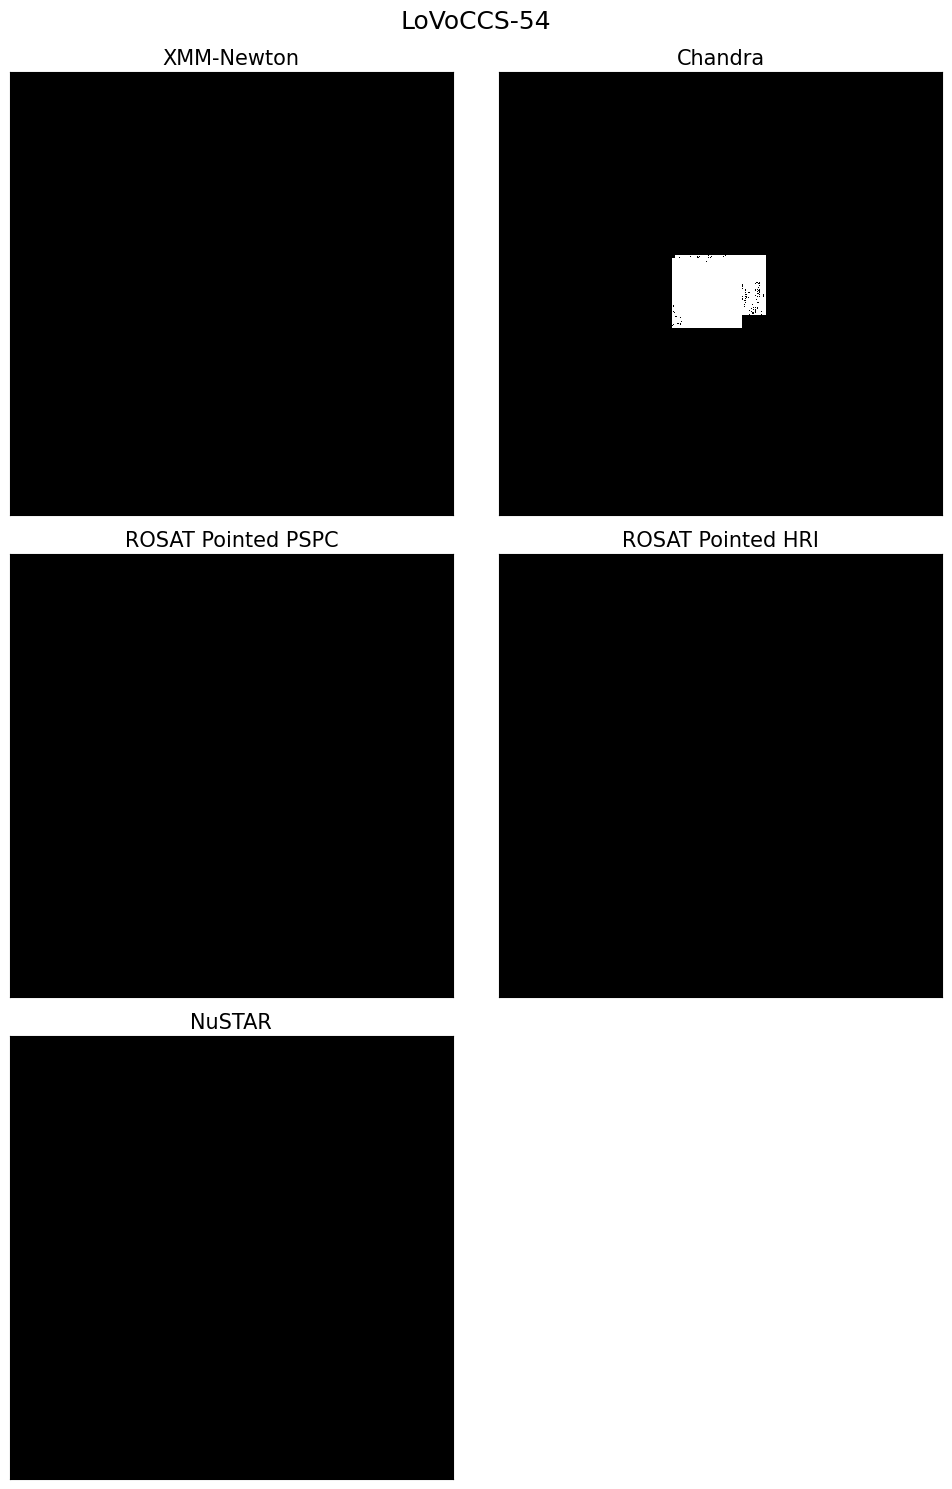

Generating coverage maps:  38%|███▊      | 55/144 [03:11<02:30,  1.69s/it]

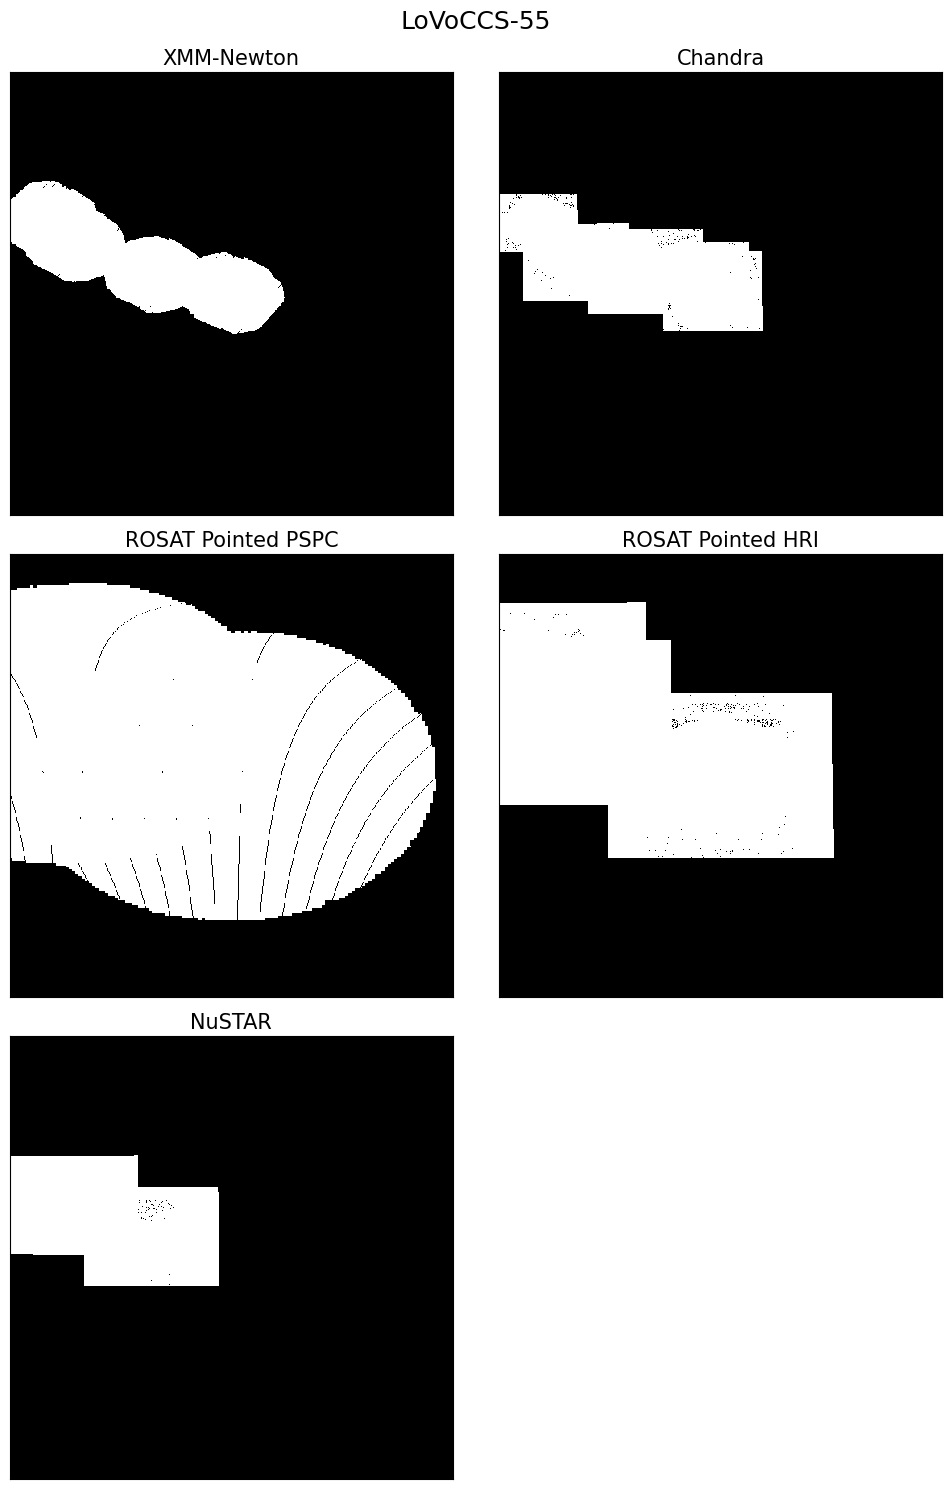

Generating coverage maps:  39%|███▉      | 56/144 [03:15<03:52,  2.65s/it]

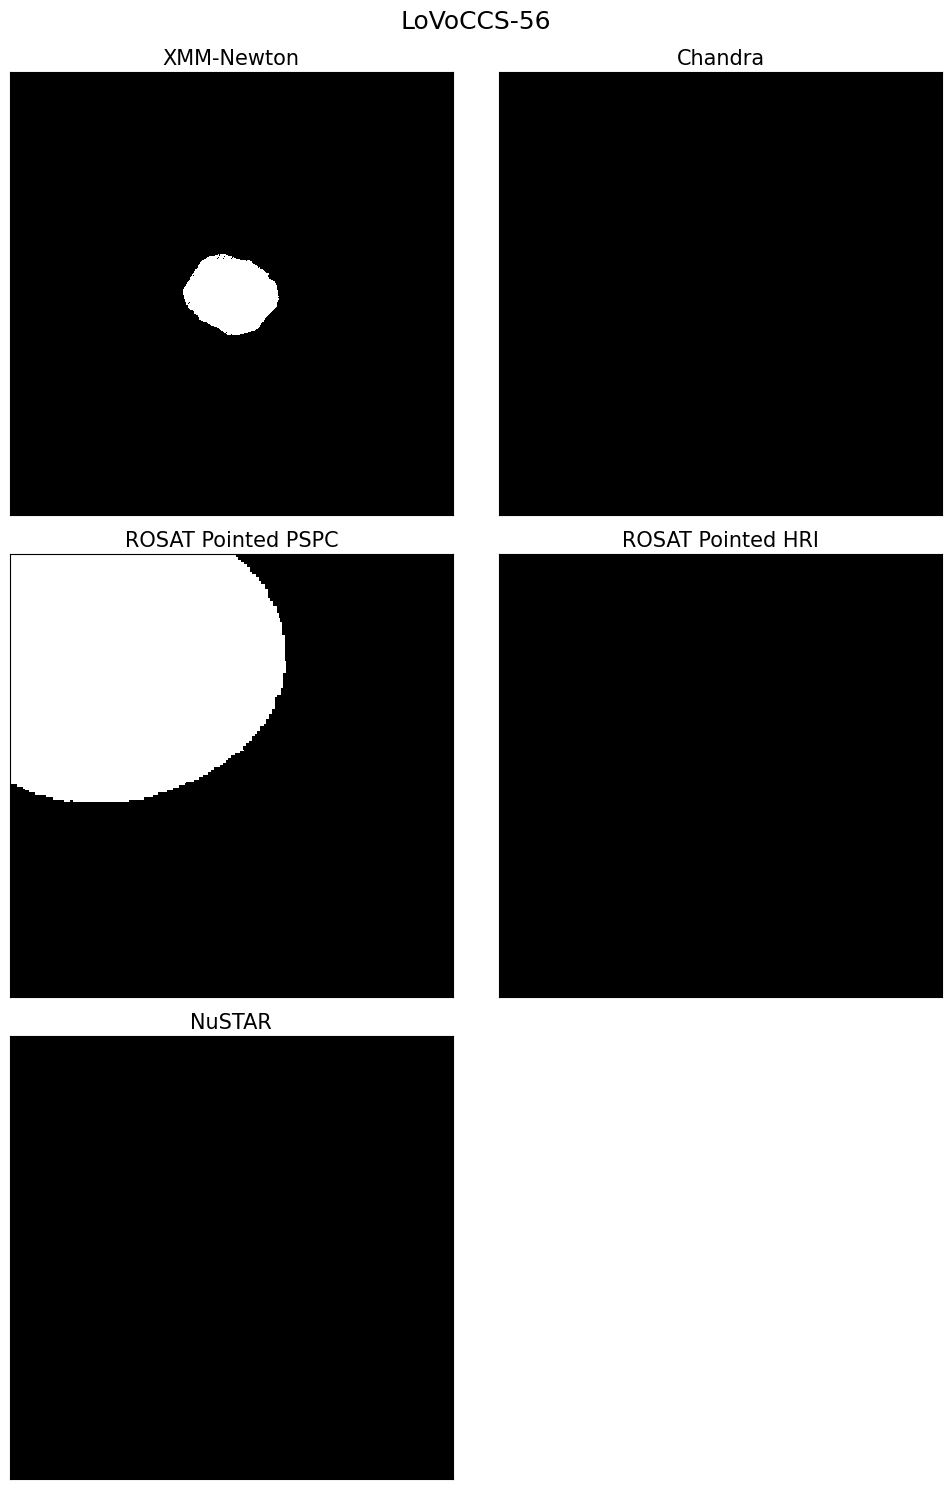

Generating coverage maps:  40%|███▉      | 57/144 [03:17<03:22,  2.32s/it]

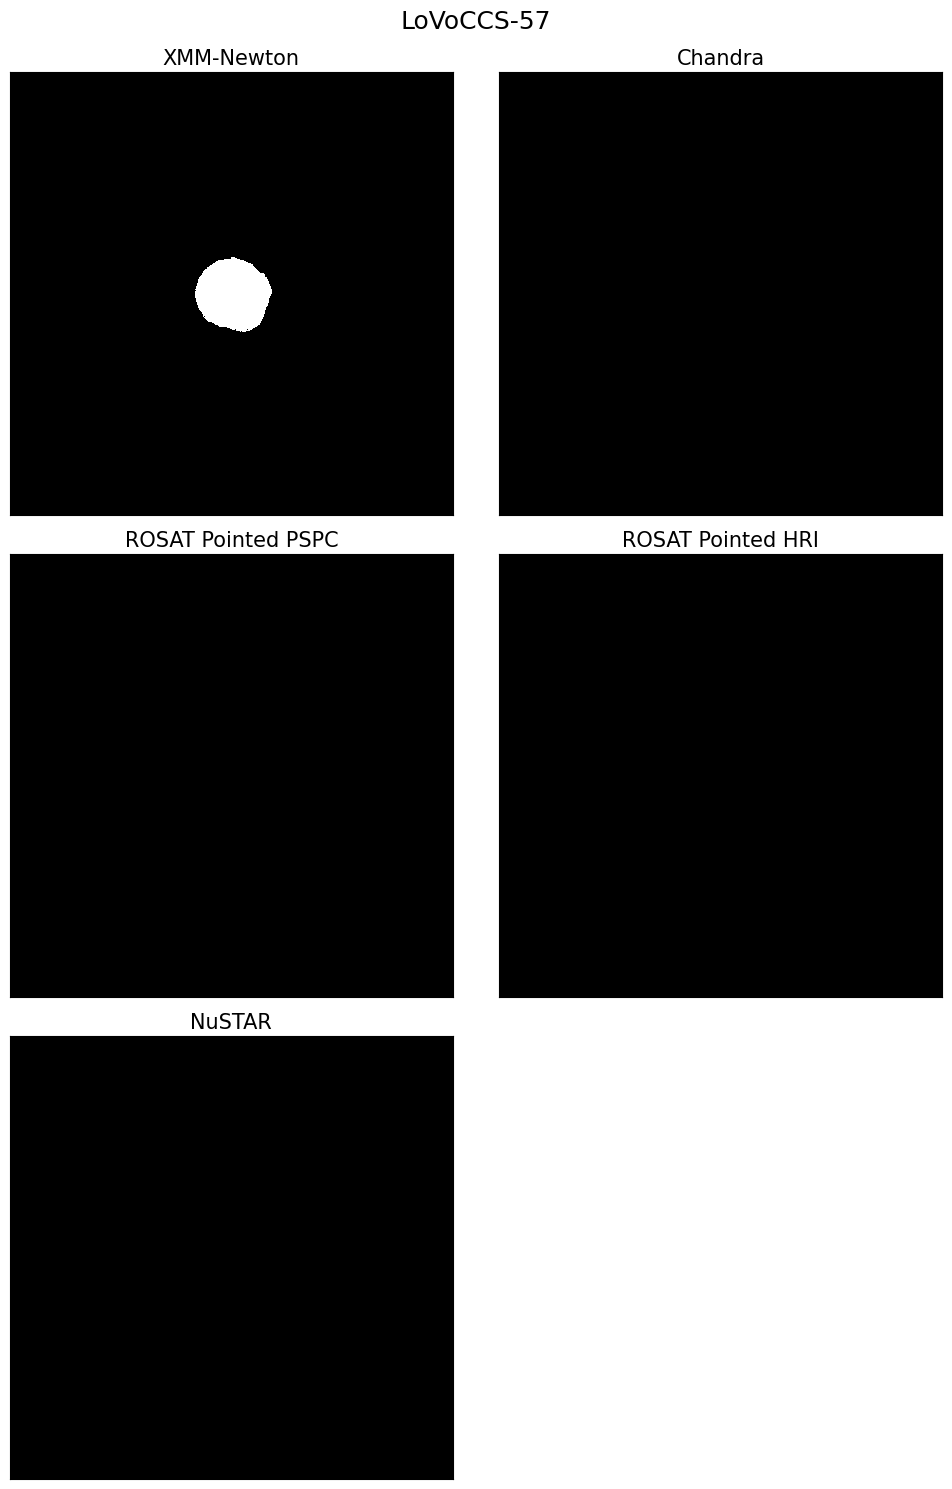

Generating coverage maps:  40%|████      | 58/144 [03:19<02:58,  2.08s/it]

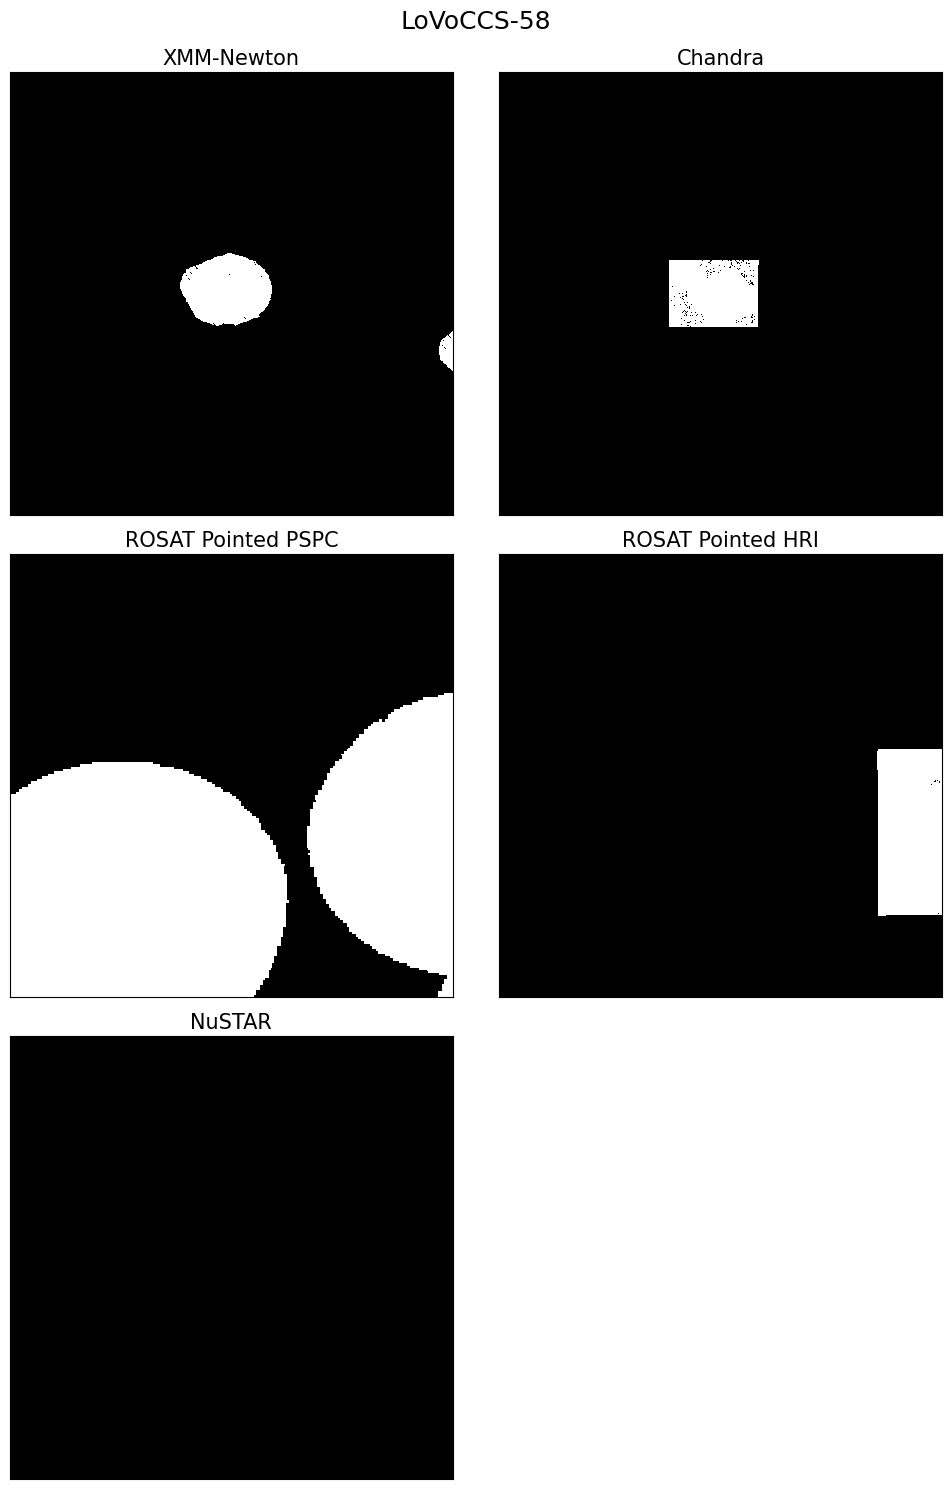

Generating coverage maps:  41%|████      | 59/144 [03:21<03:09,  2.23s/it]

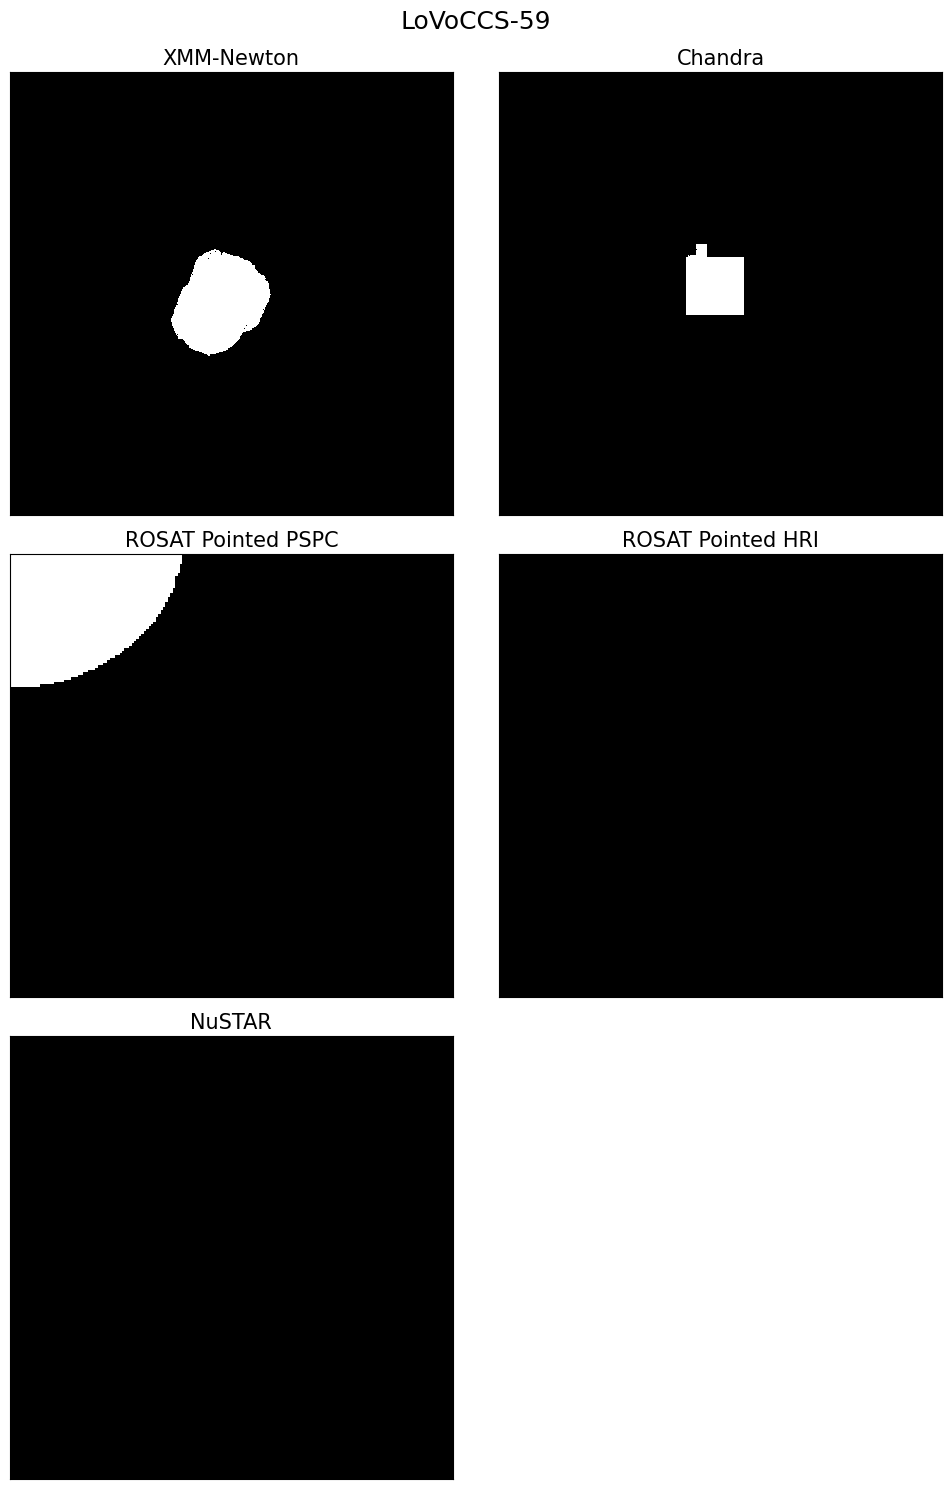

Generating coverage maps:  42%|████▏     | 60/144 [03:24<03:23,  2.42s/it]

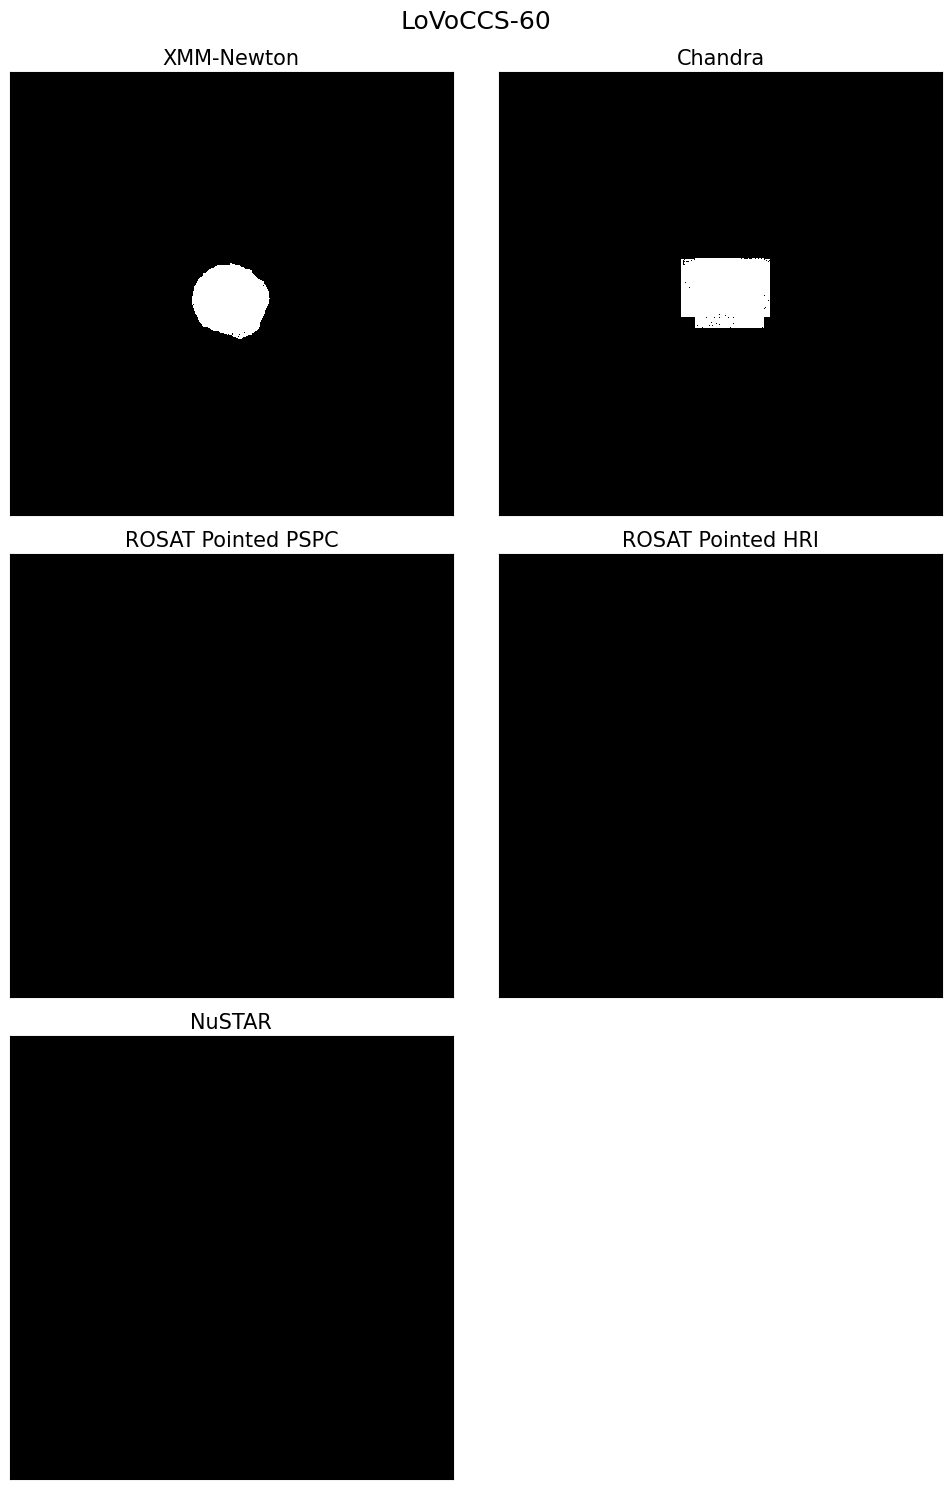

Generating coverage maps:  42%|████▏     | 61/144 [03:25<02:52,  2.08s/it]

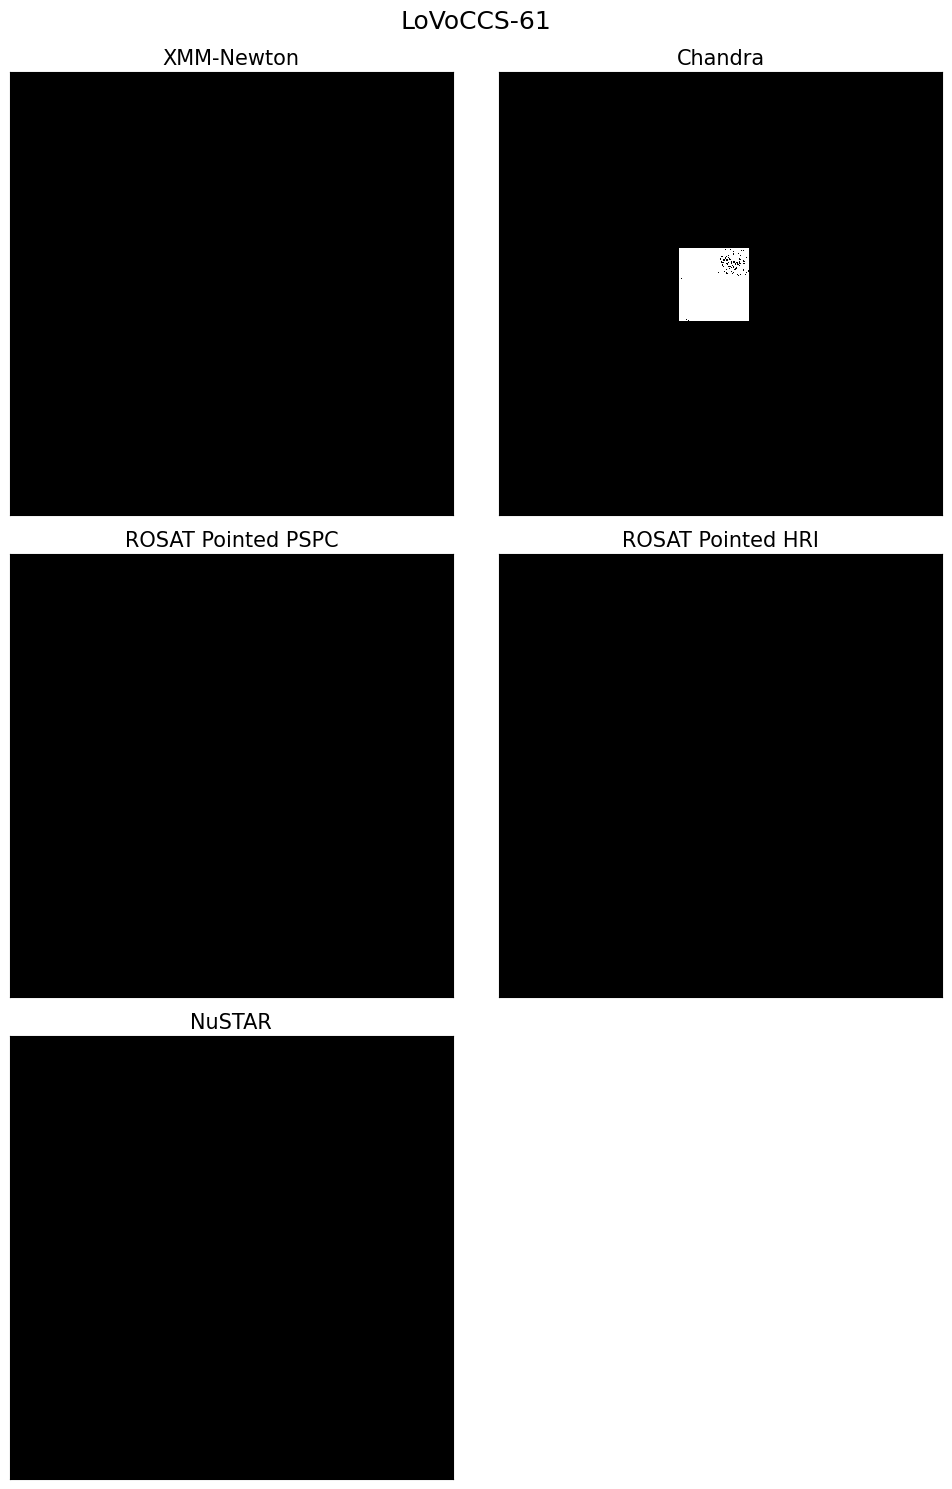

Generating coverage maps:  43%|████▎     | 62/144 [03:26<02:25,  1.77s/it]

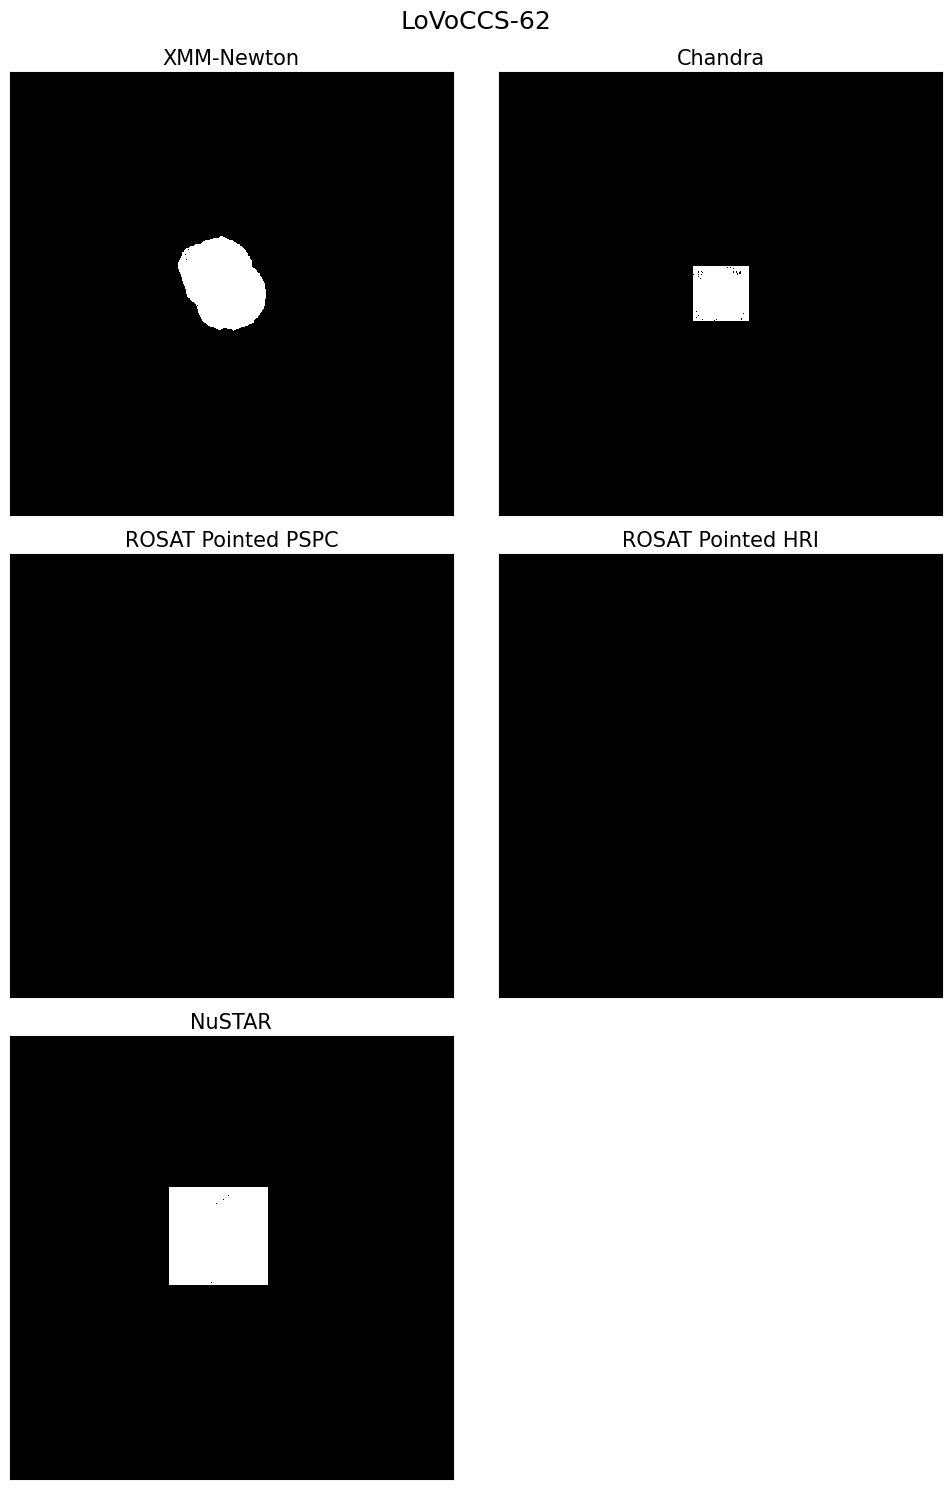

Generating coverage maps:  44%|████▍     | 63/144 [03:28<02:20,  1.74s/it]

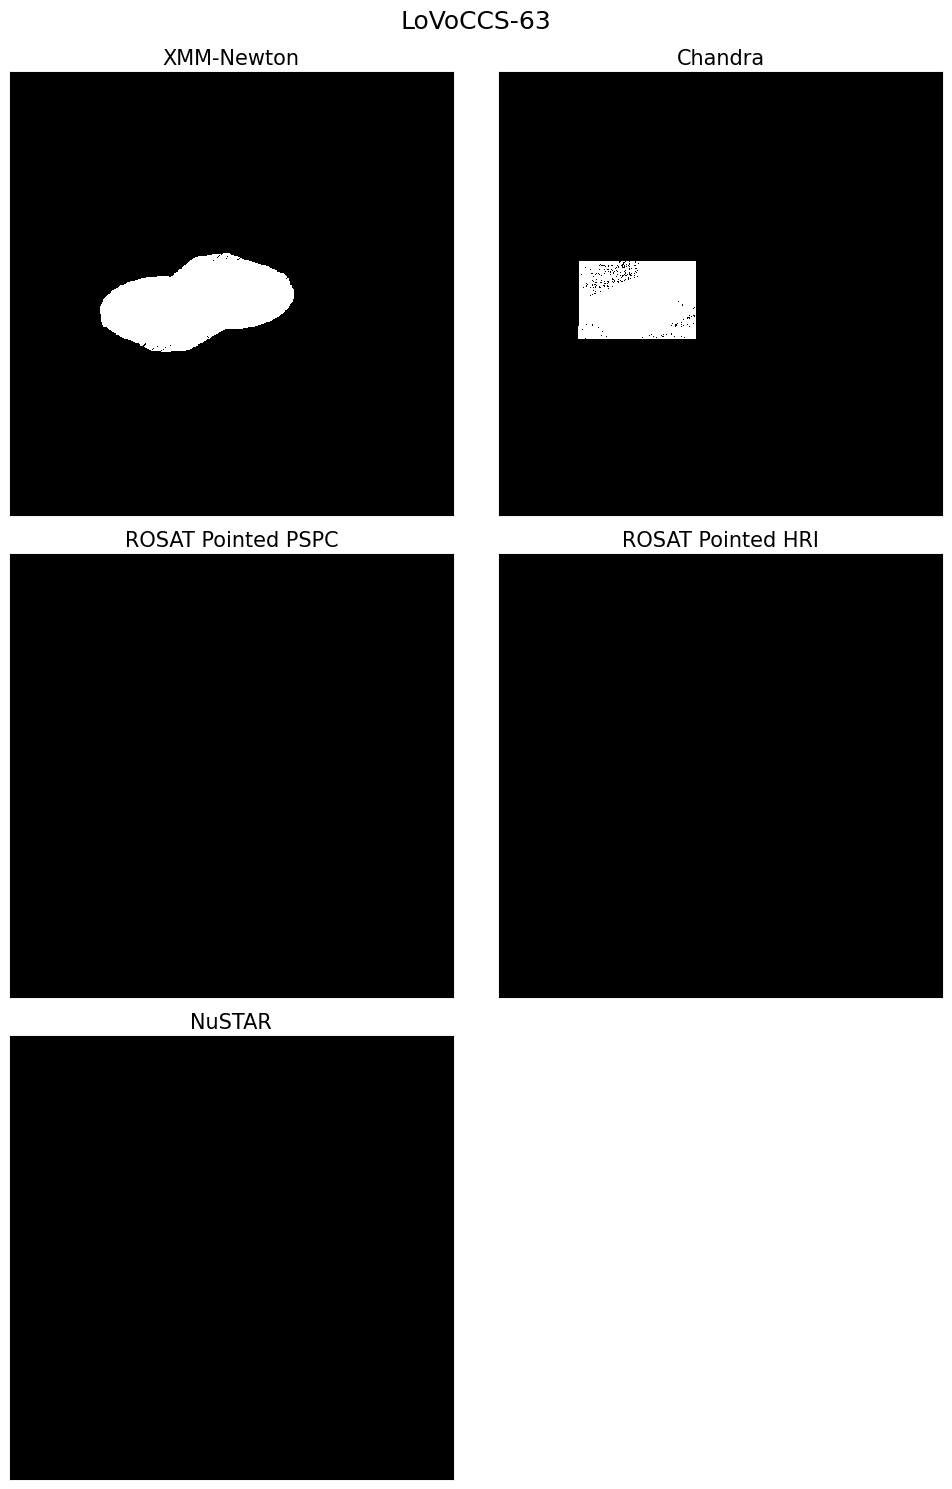

Generating coverage maps:  44%|████▍     | 64/144 [03:30<02:22,  1.78s/it]

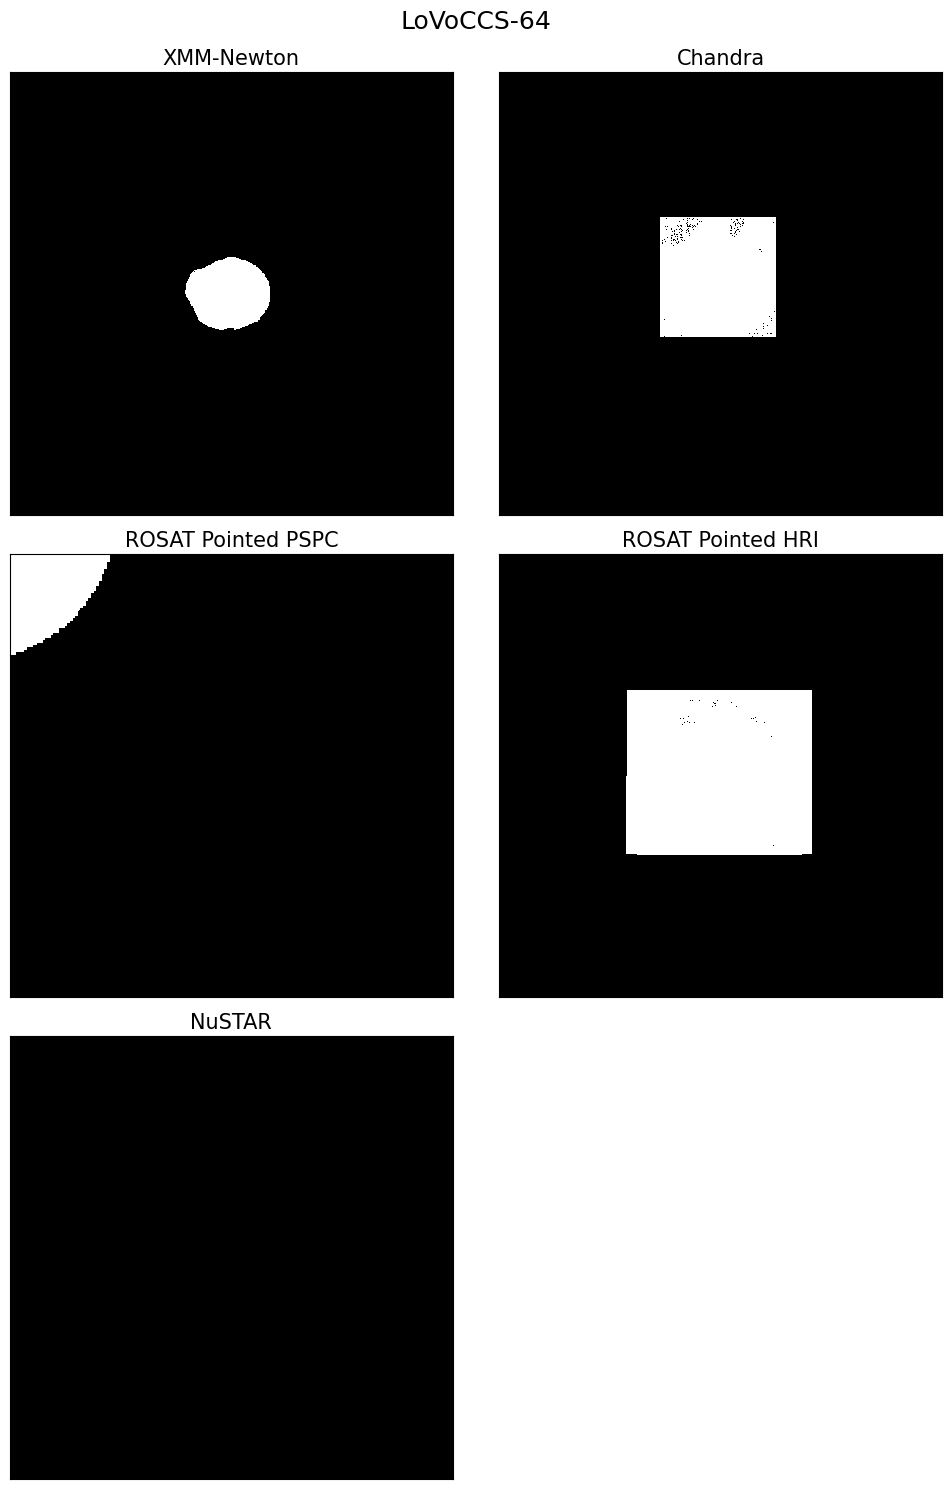

Generating coverage maps:  45%|████▌     | 65/144 [03:34<03:19,  2.53s/it]

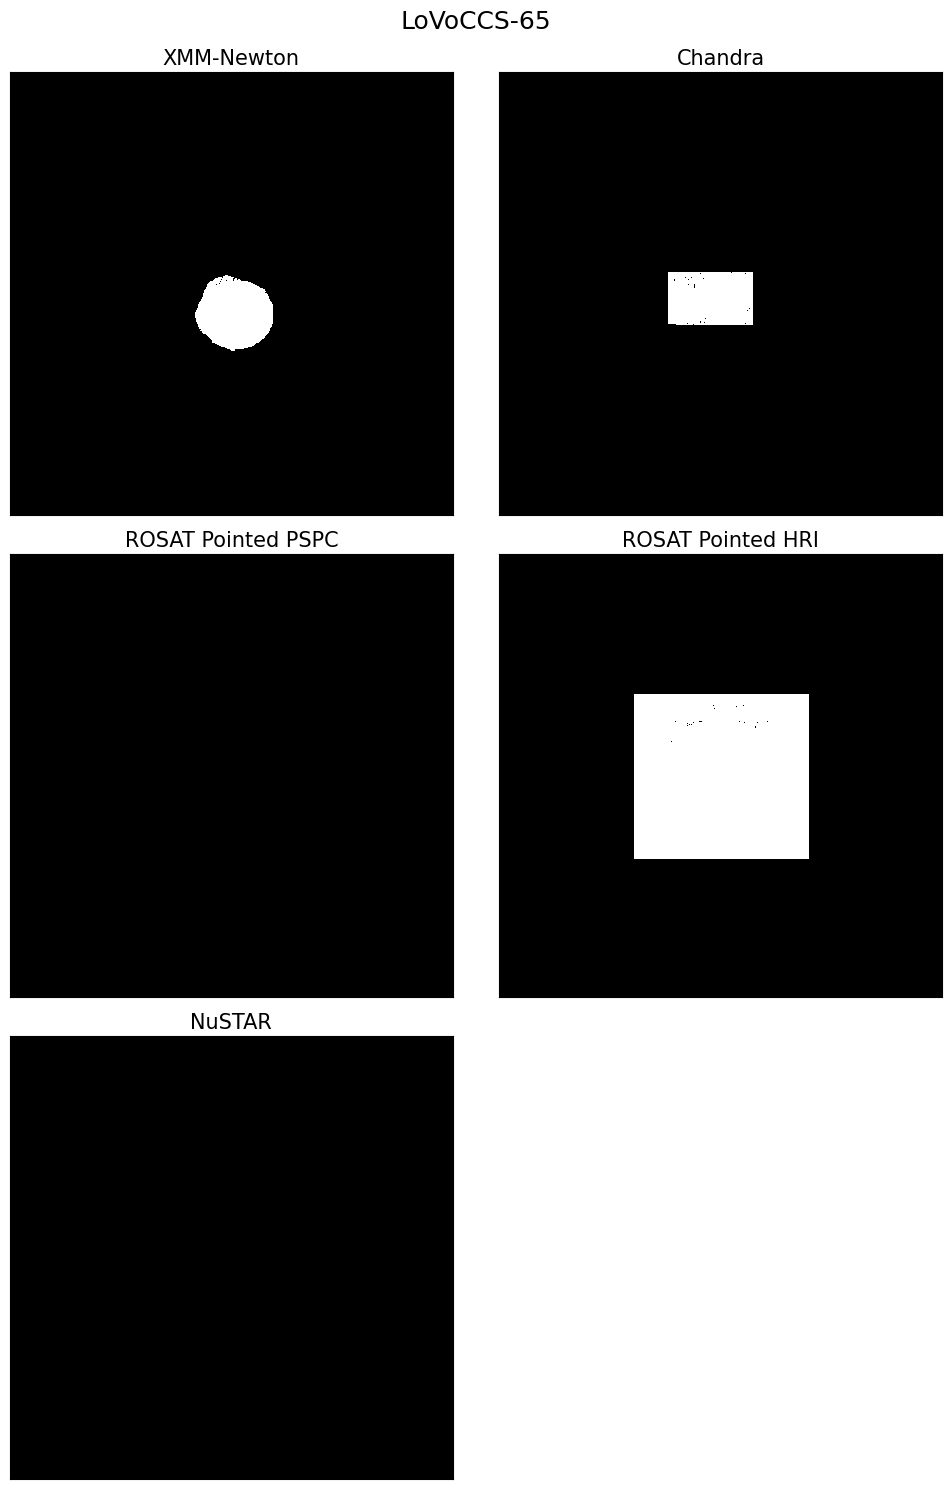

Generating coverage maps:  46%|████▌     | 66/144 [03:36<02:50,  2.19s/it]

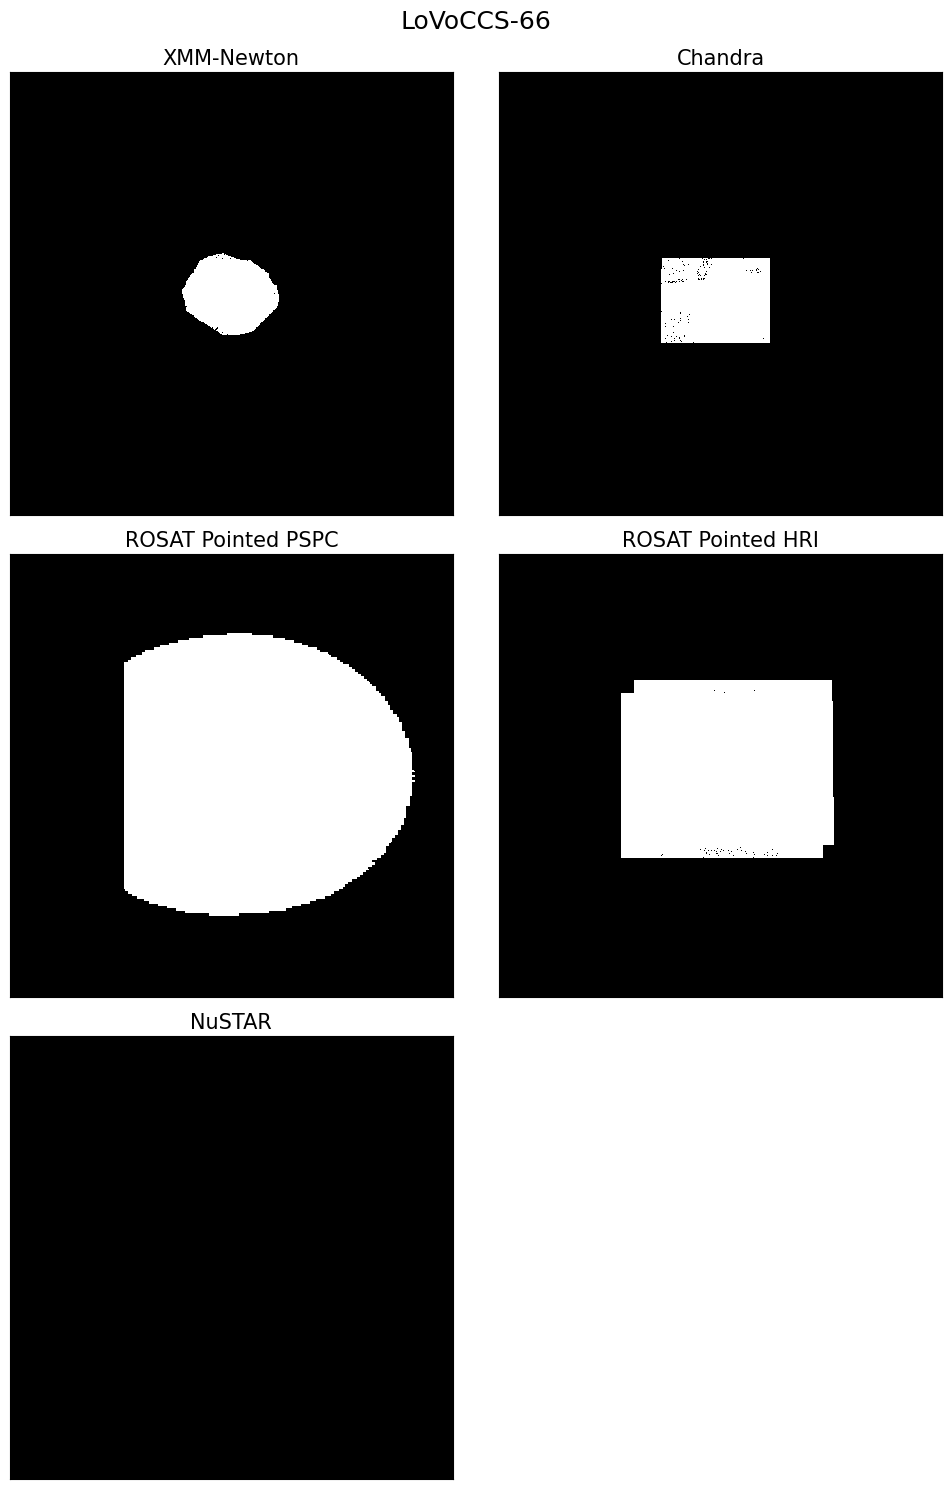

Generating coverage maps:  47%|████▋     | 67/144 [03:38<02:47,  2.17s/it]

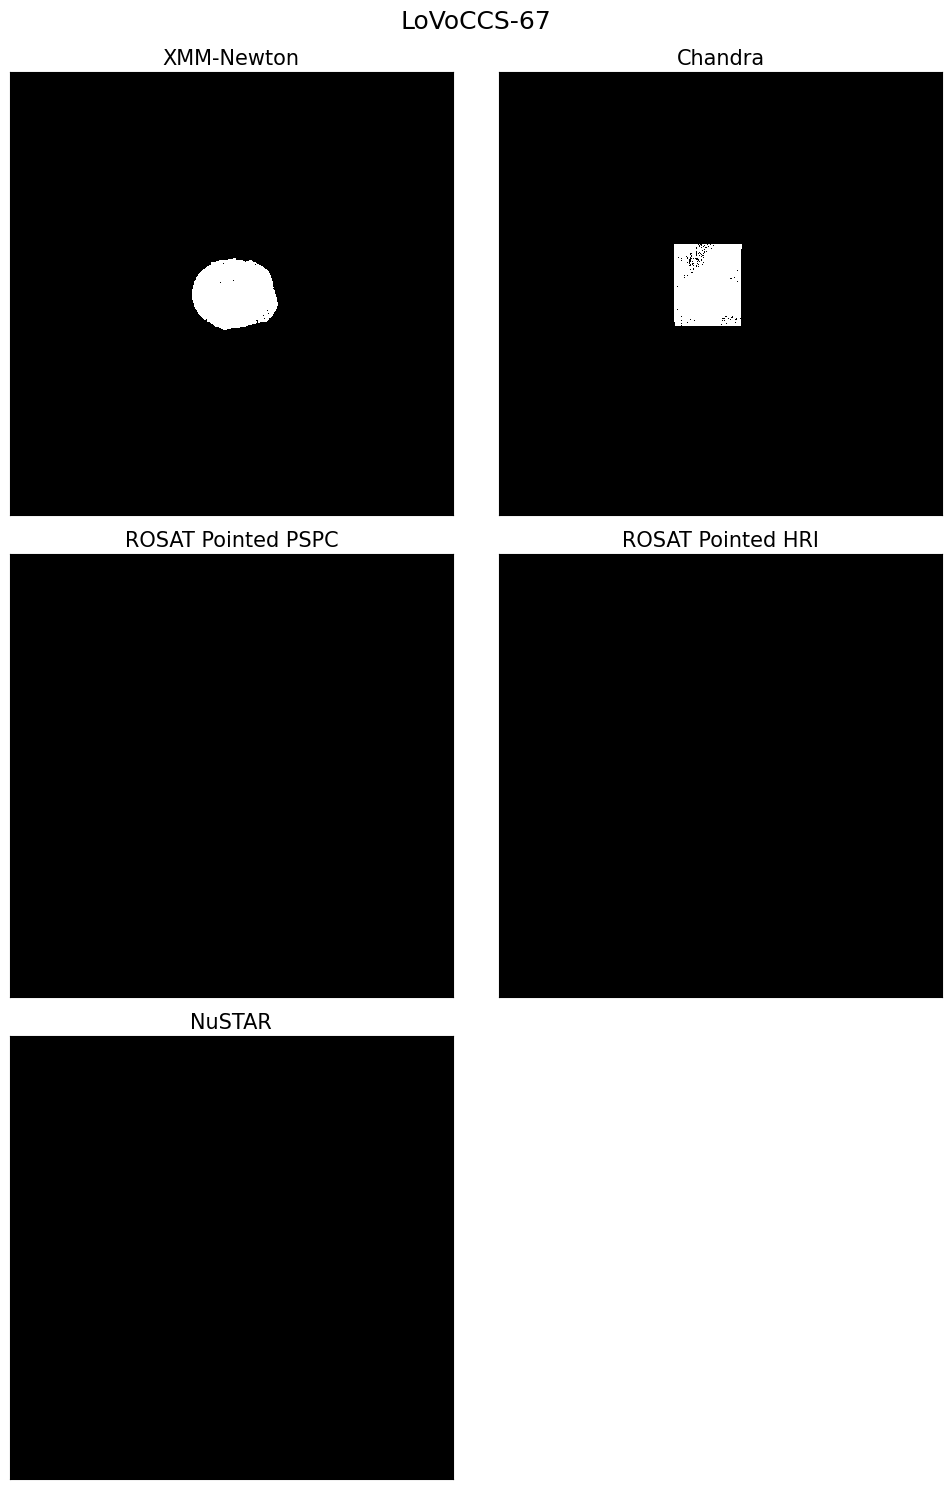

Generating coverage maps:  47%|████▋     | 68/144 [03:39<02:24,  1.90s/it]

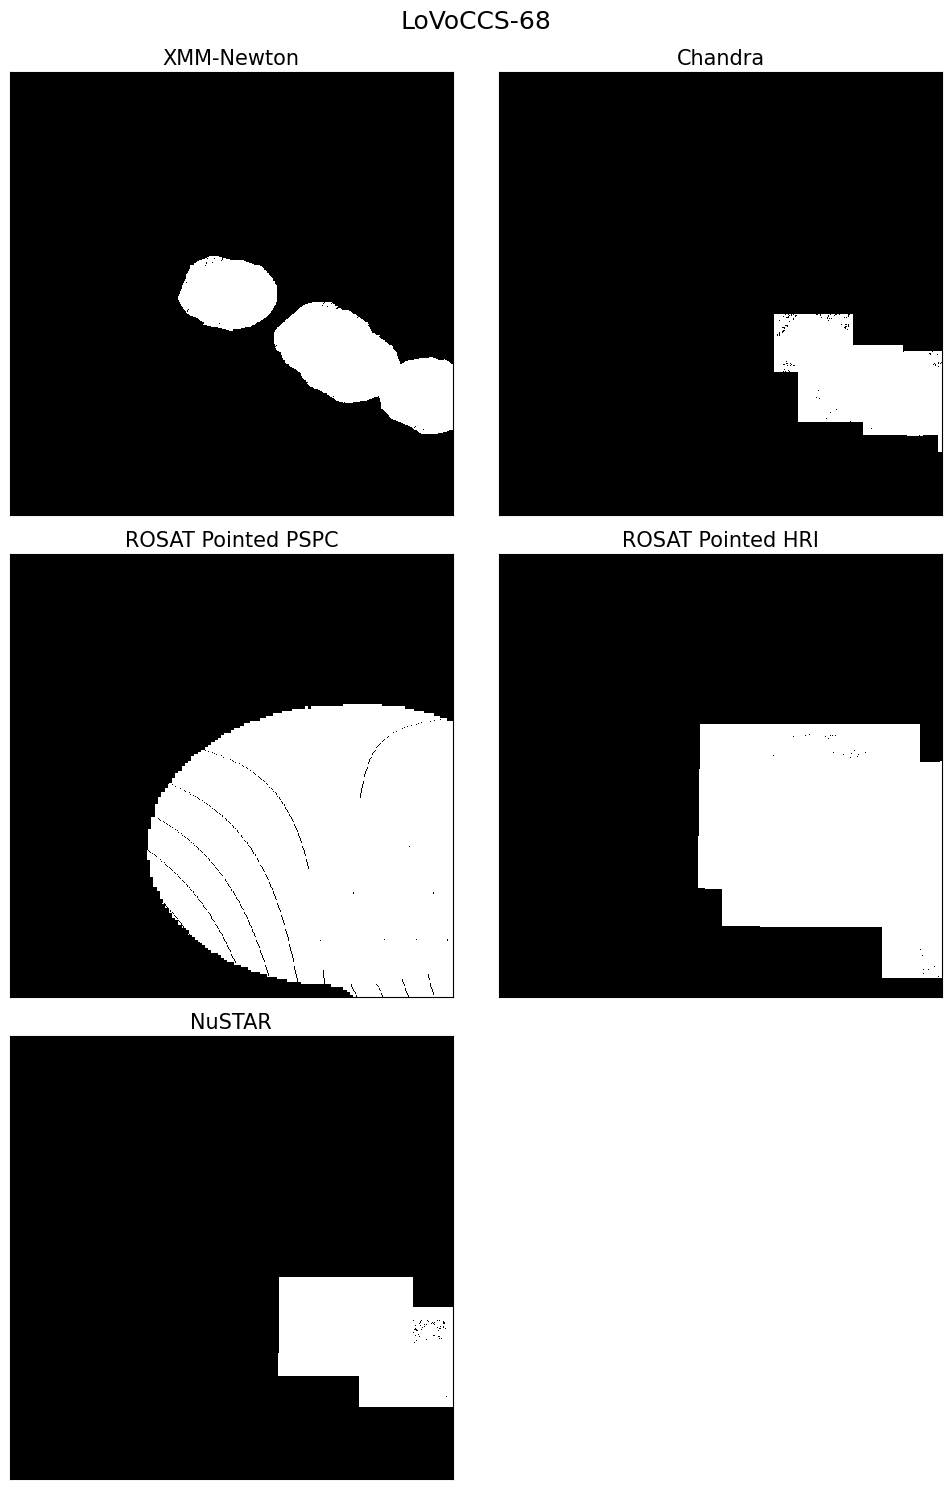

Generating coverage maps:  48%|████▊     | 69/144 [03:44<03:27,  2.77s/it]

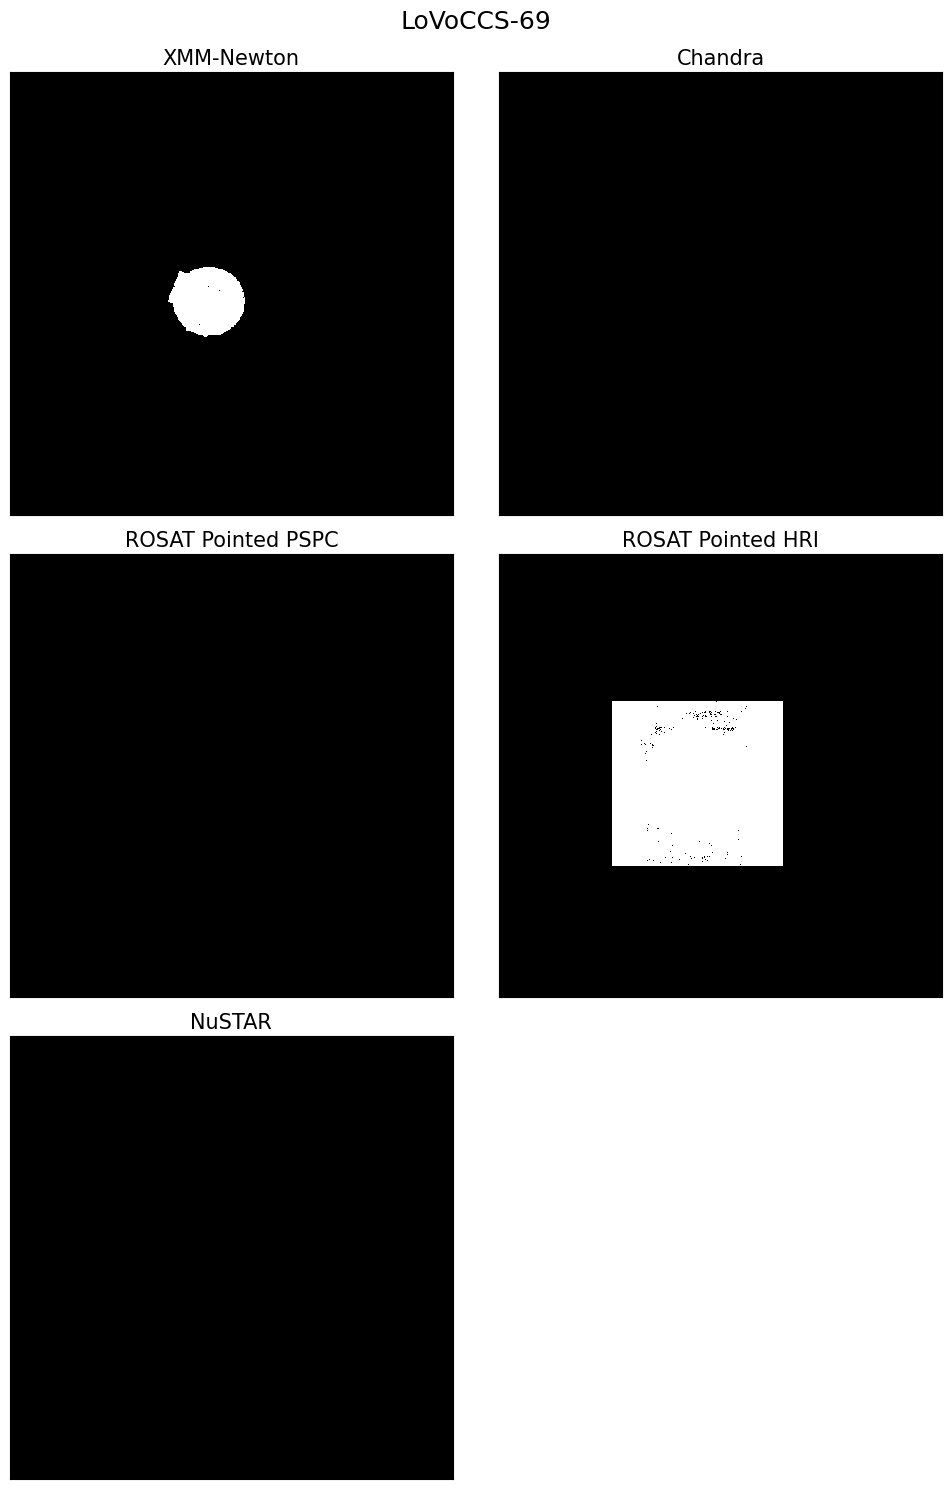

Generating coverage maps:  49%|████▊     | 70/144 [03:45<02:52,  2.33s/it]

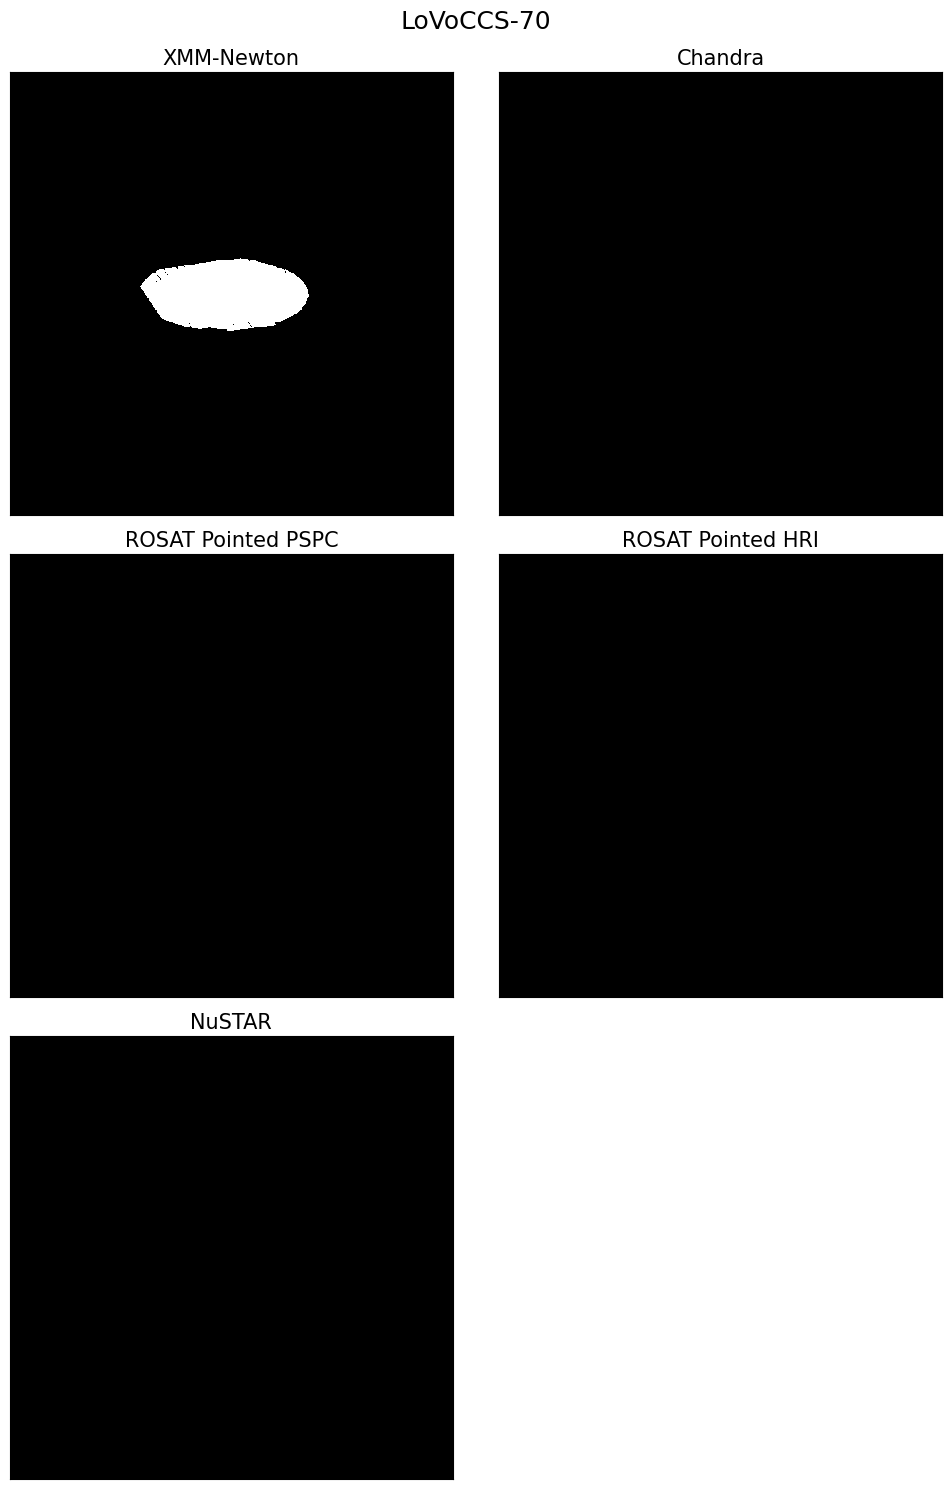

Generating coverage maps:  49%|████▉     | 71/144 [03:46<02:28,  2.03s/it]

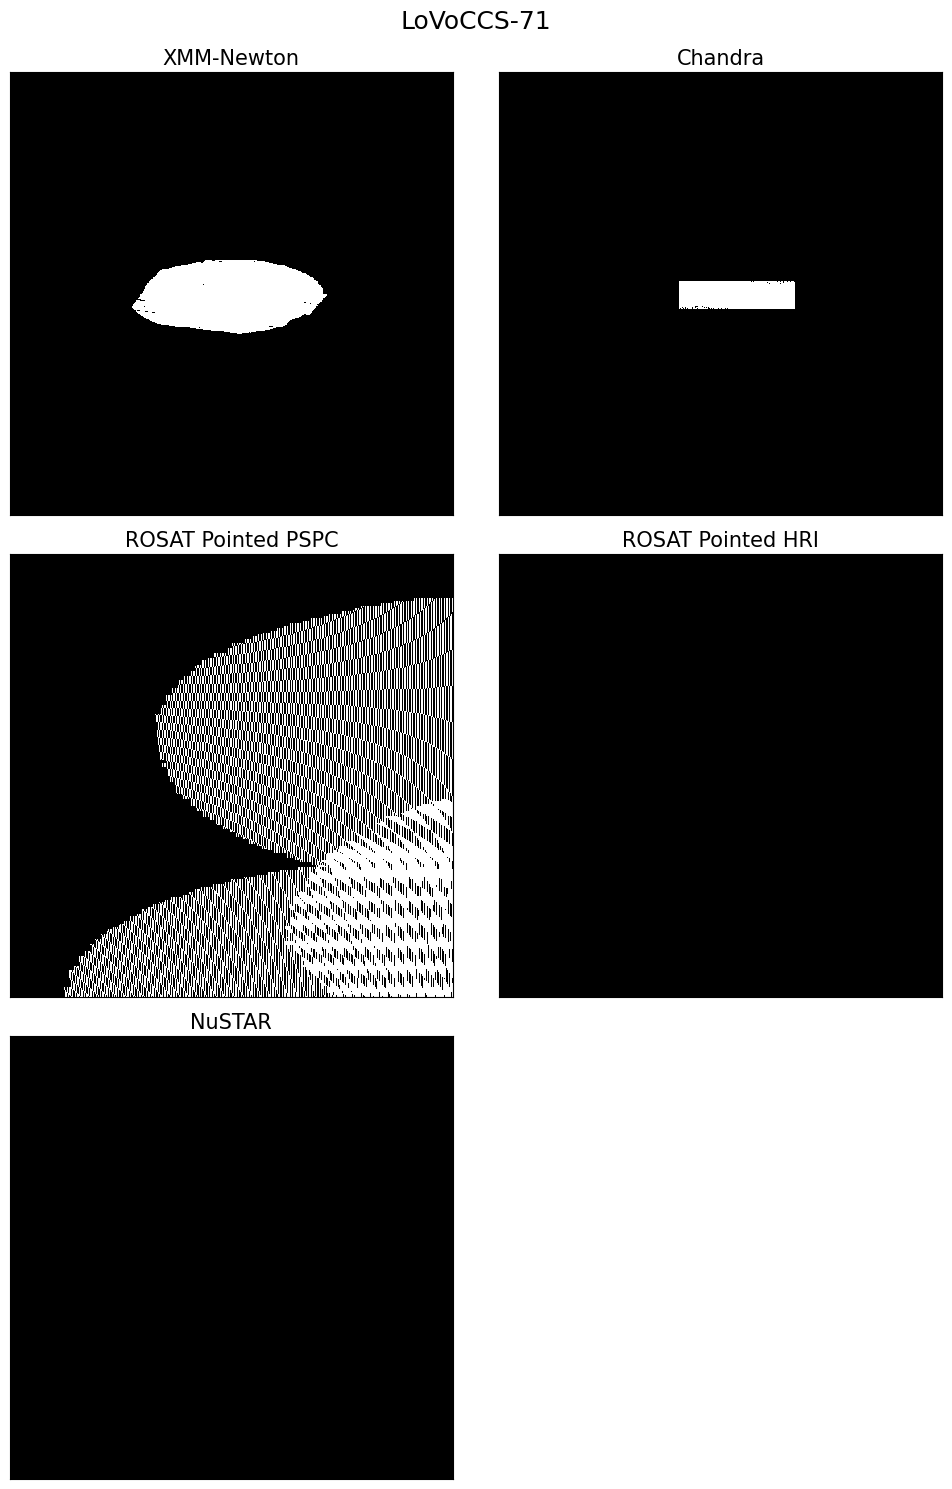

Generating coverage maps:  50%|█████     | 72/144 [03:48<02:23,  1.99s/it]

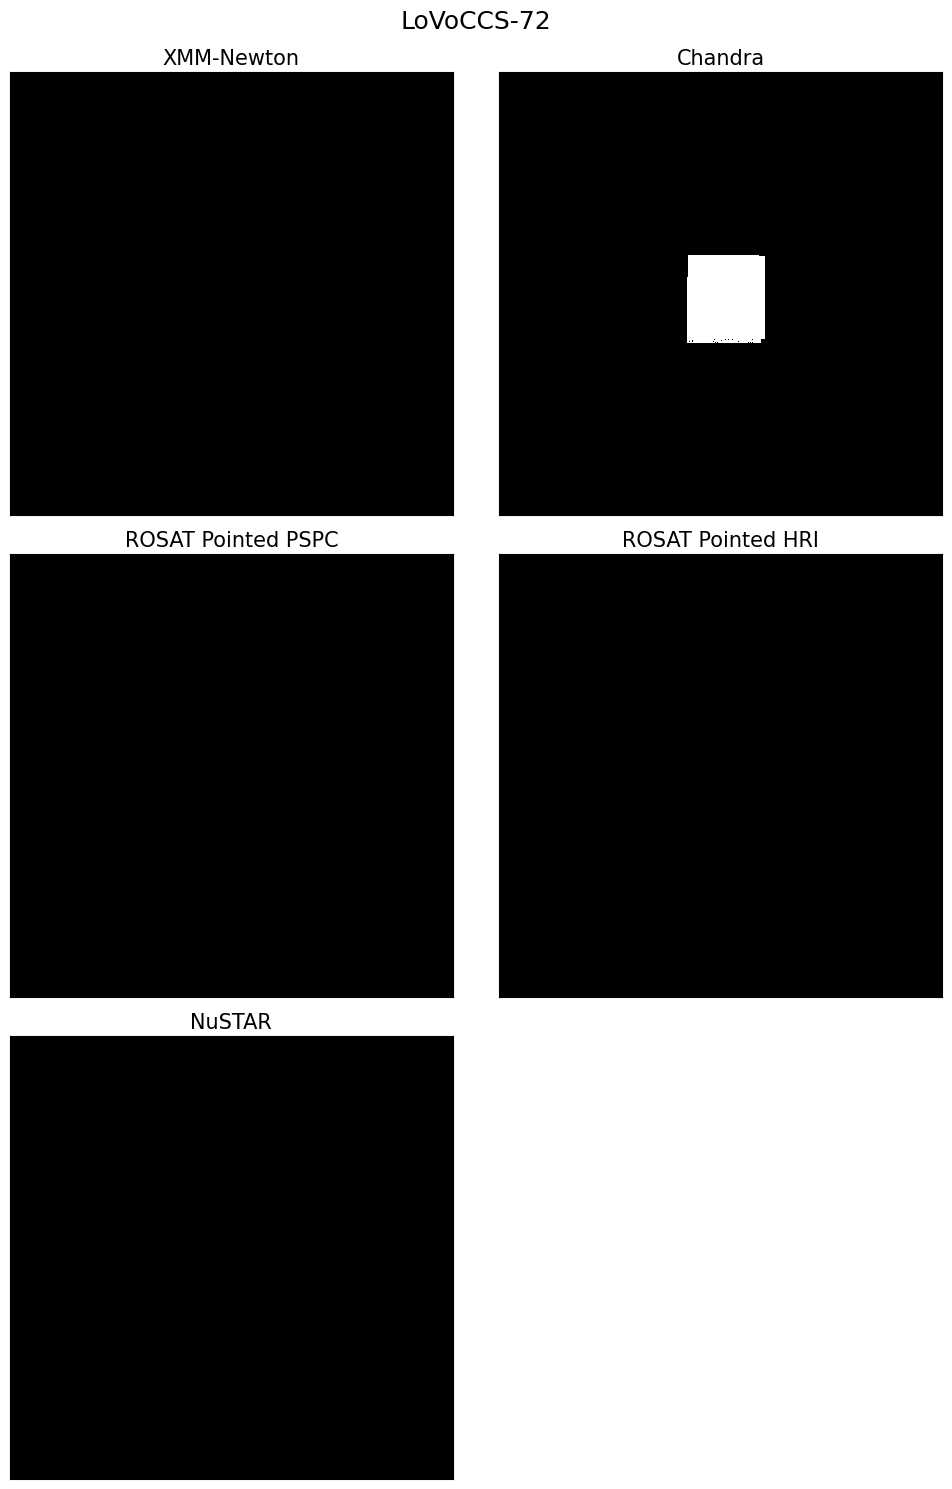

Generating coverage maps:  51%|█████     | 73/144 [03:50<02:09,  1.82s/it]

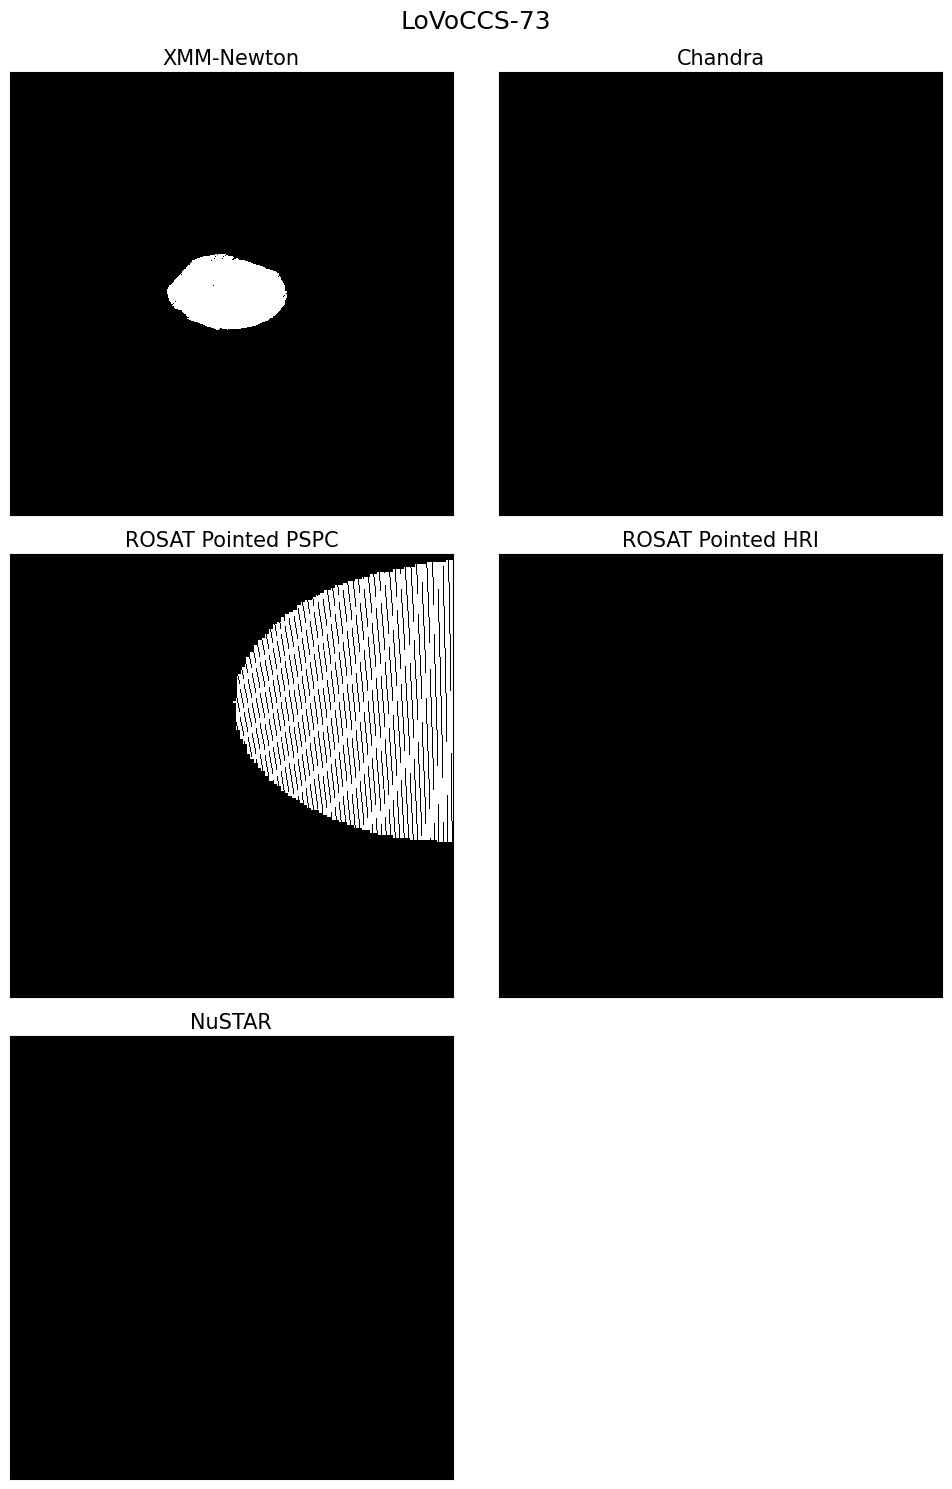

Generating coverage maps:  51%|█████▏    | 74/144 [03:51<01:56,  1.66s/it]

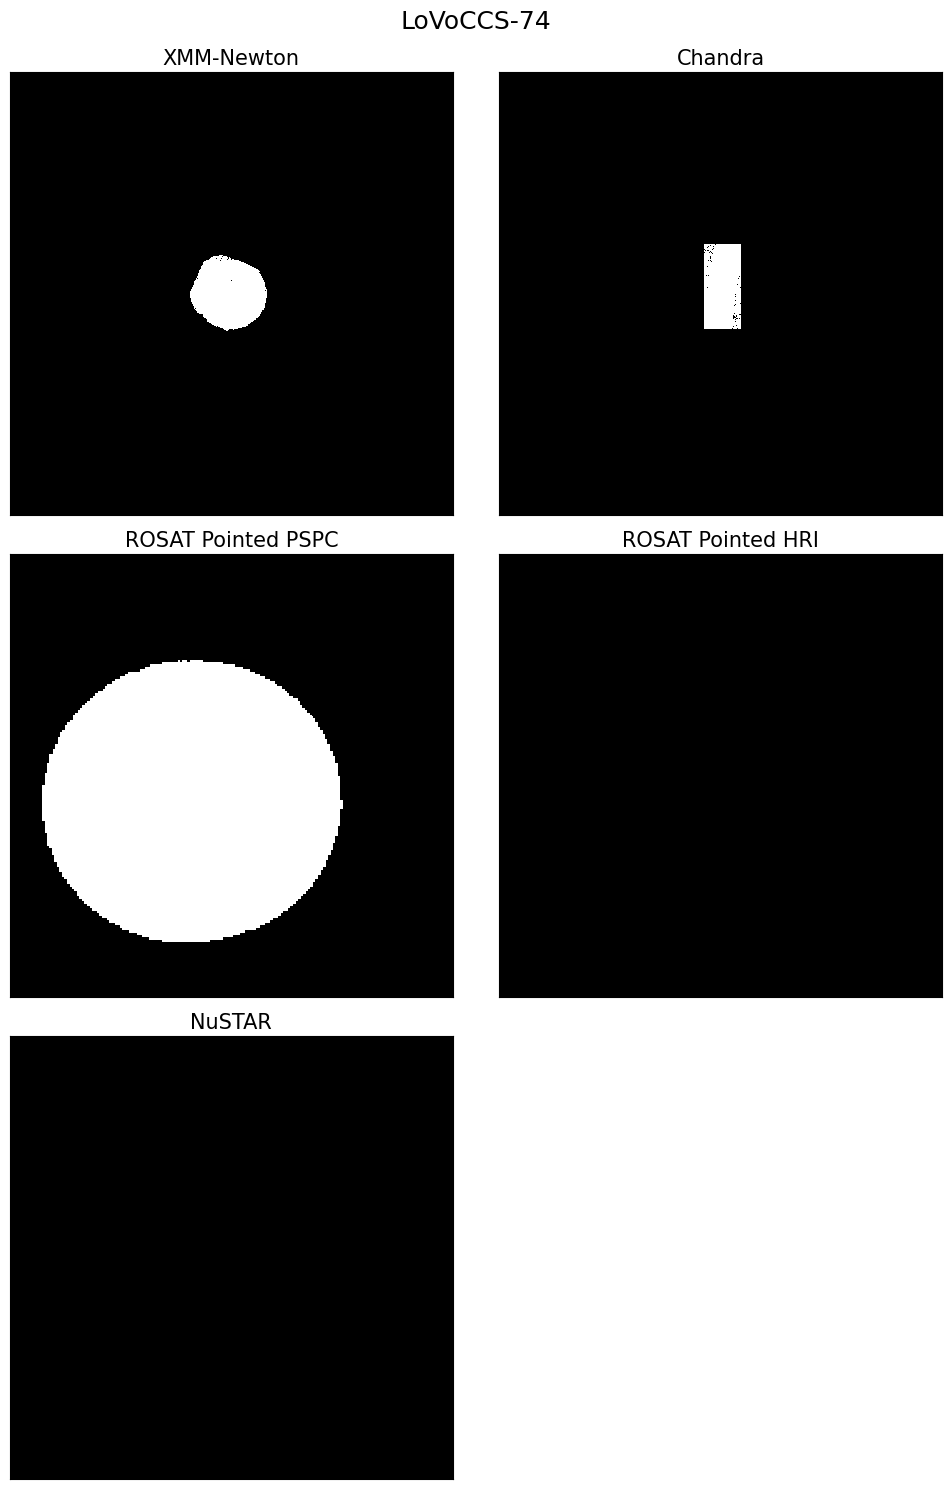

Generating coverage maps:  52%|█████▏    | 75/144 [03:52<01:47,  1.56s/it]

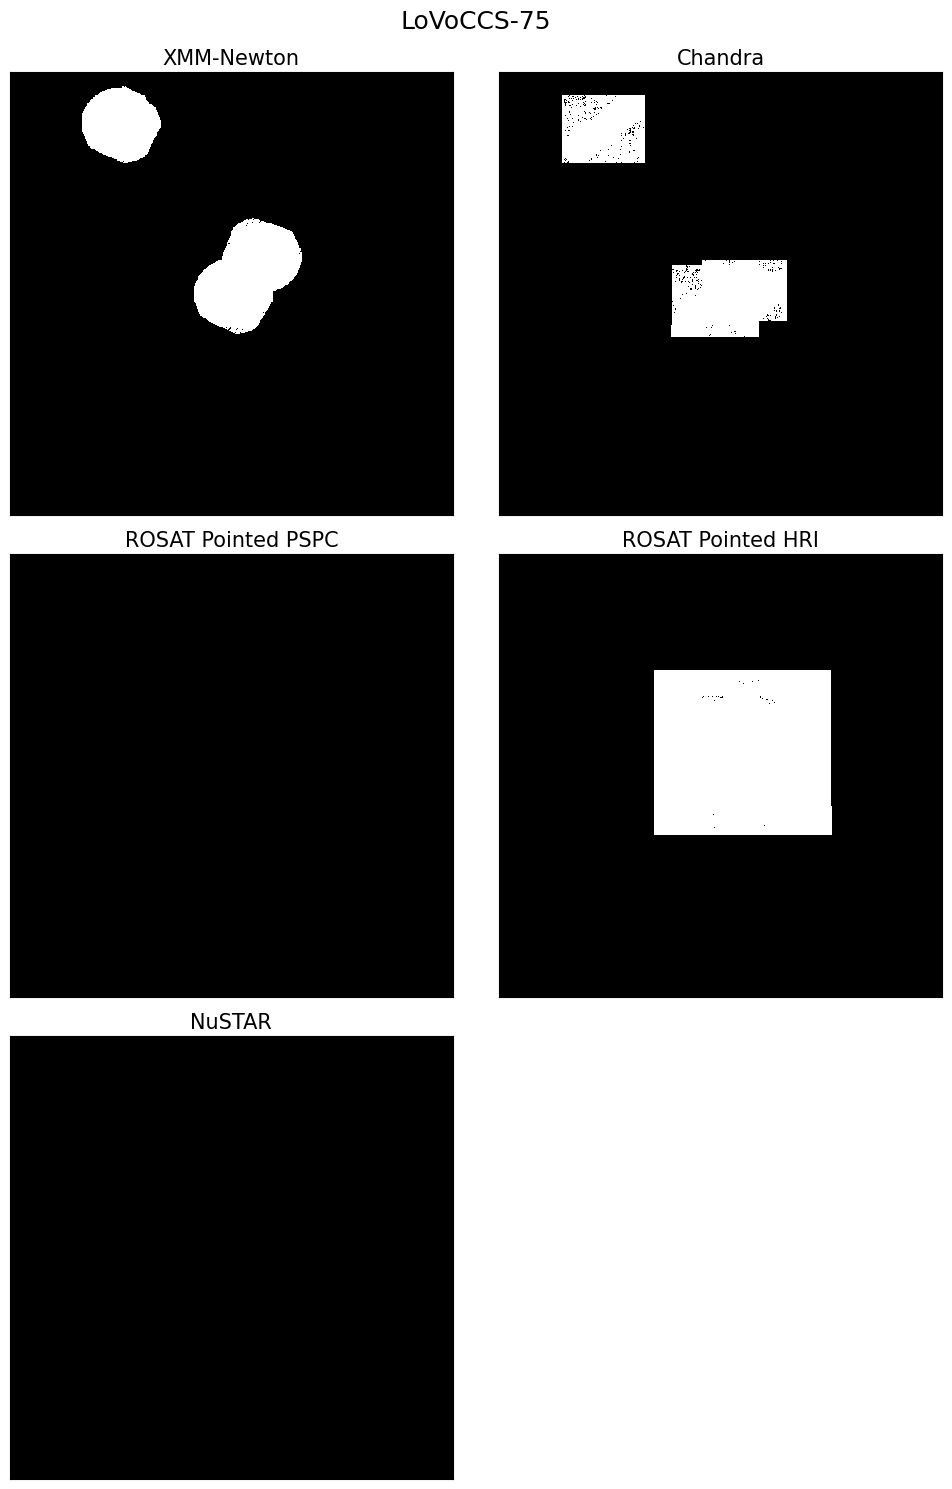

Generating coverage maps:  53%|█████▎    | 76/144 [03:54<01:55,  1.69s/it]

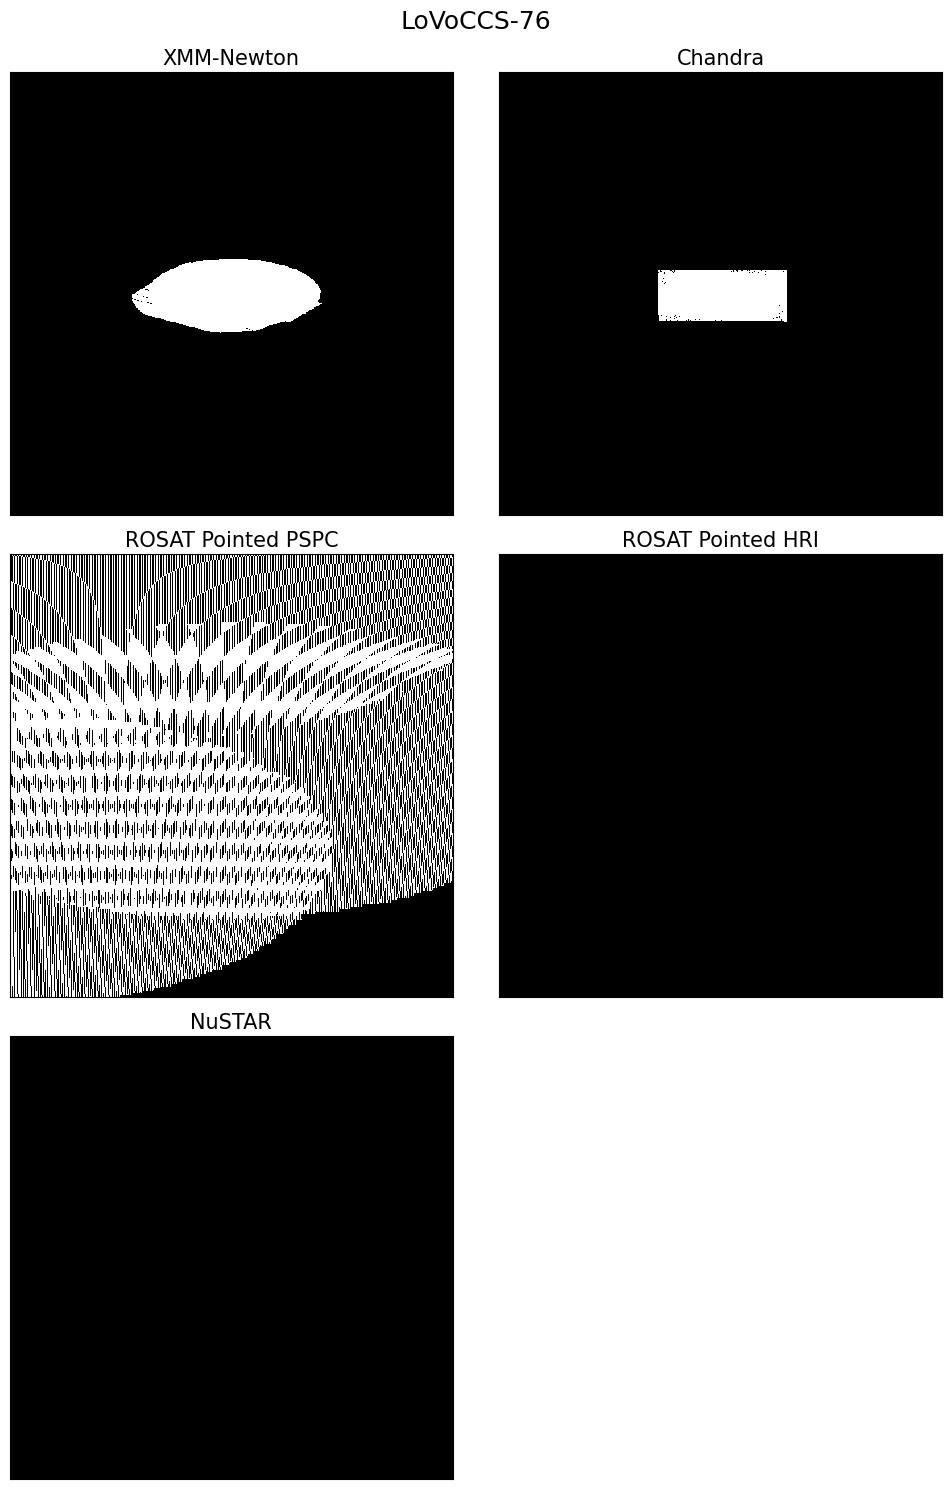

Generating coverage maps:  53%|█████▎    | 77/144 [03:56<02:00,  1.80s/it]

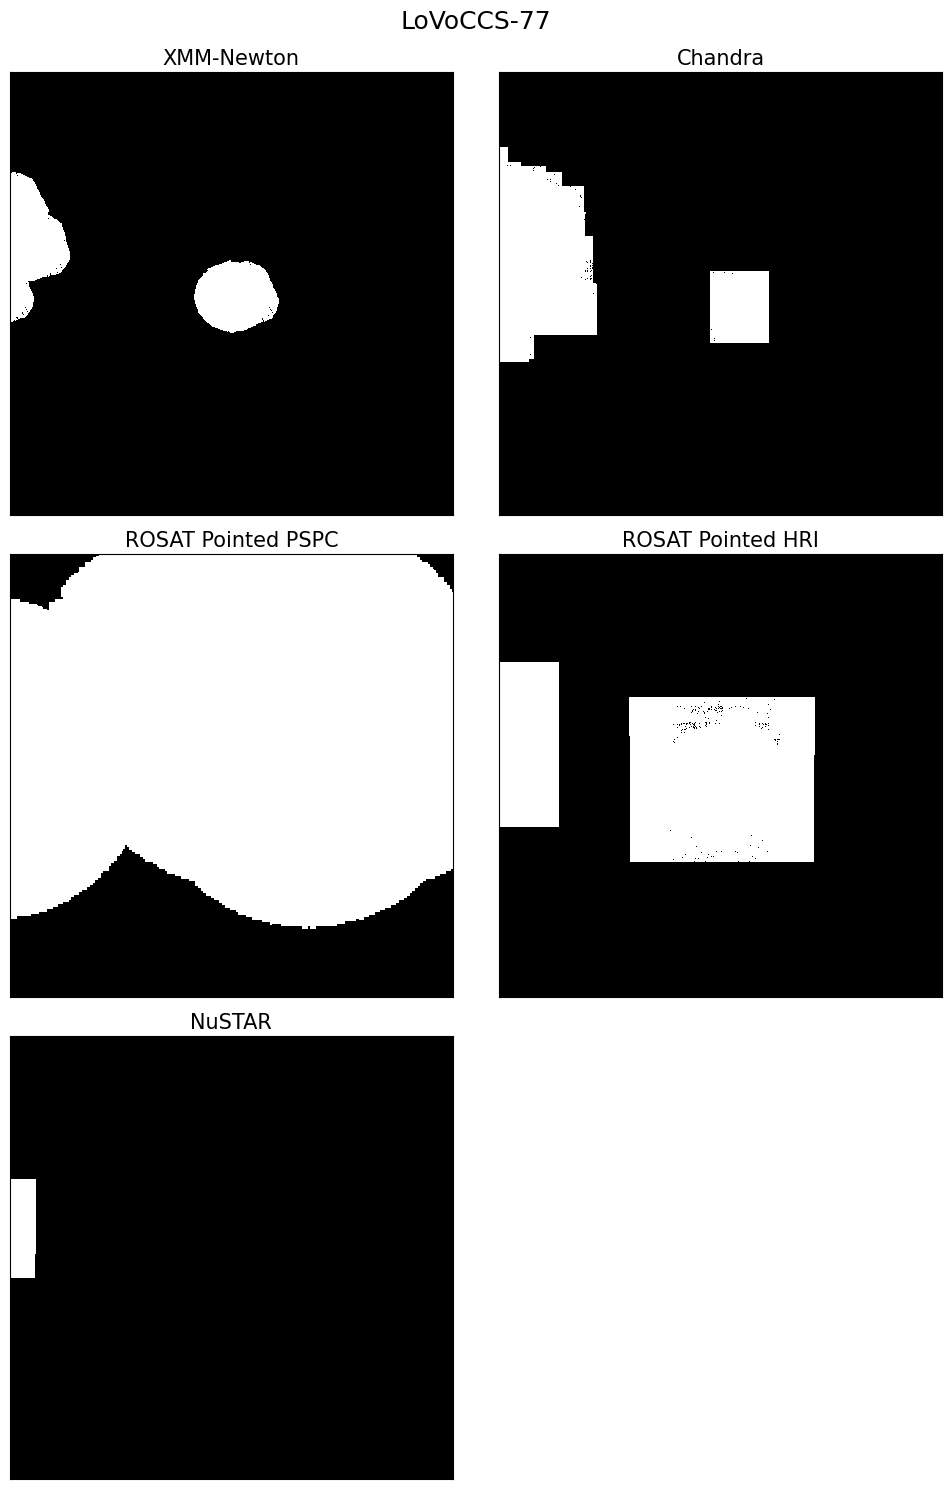

Generating coverage maps:  54%|█████▍    | 78/144 [04:14<07:20,  6.67s/it]

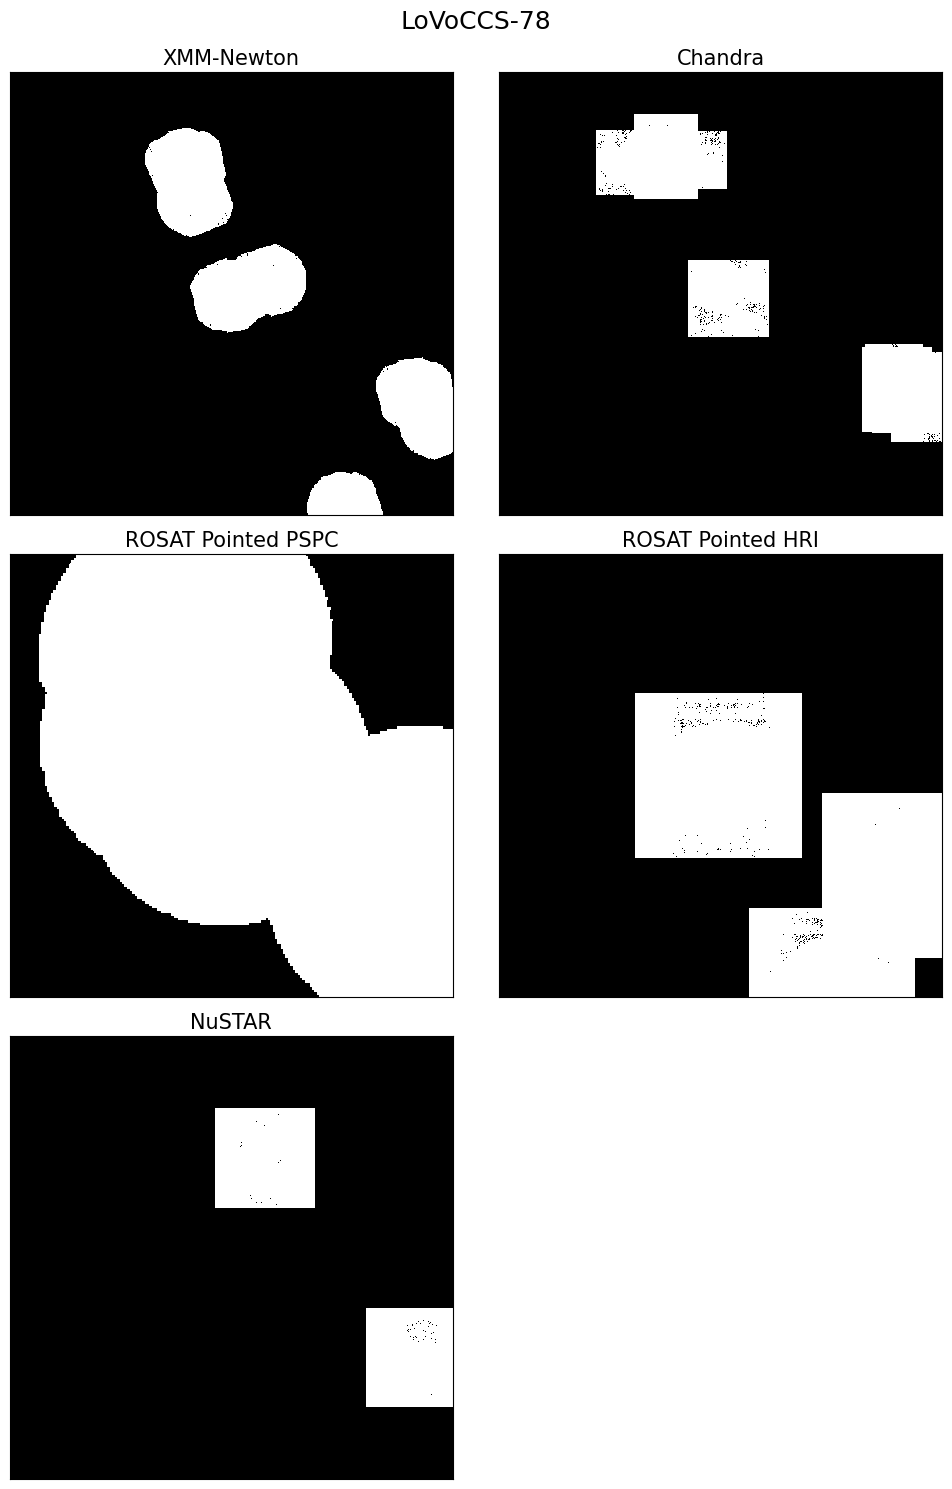

Generating coverage maps:  55%|█████▍    | 79/144 [04:24<08:09,  7.53s/it]

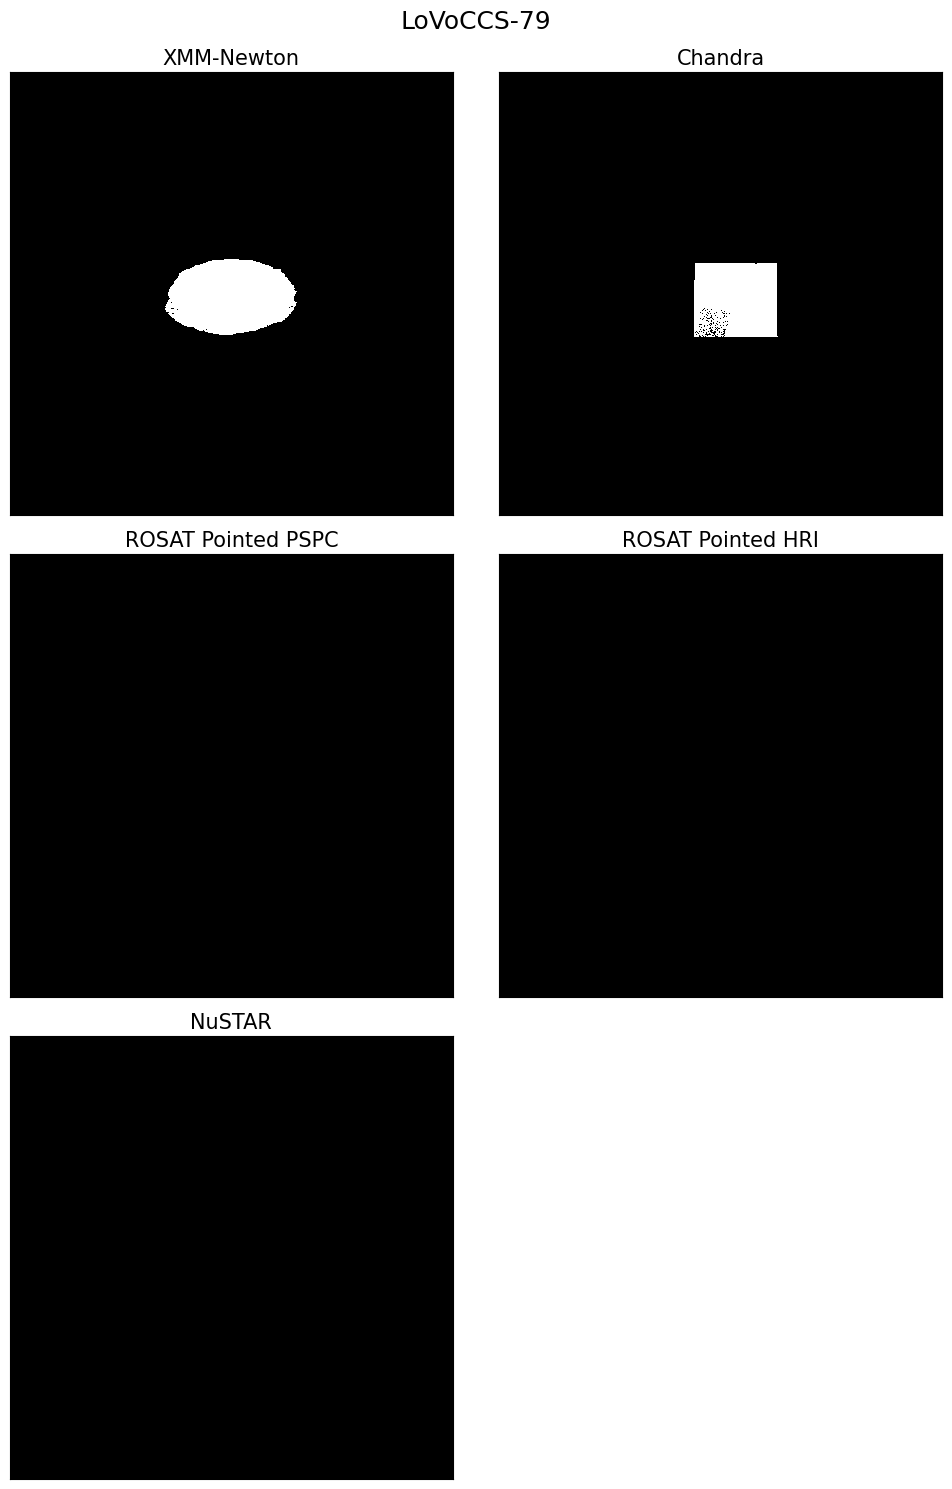

Generating coverage maps:  56%|█████▌    | 80/144 [04:27<06:36,  6.19s/it]

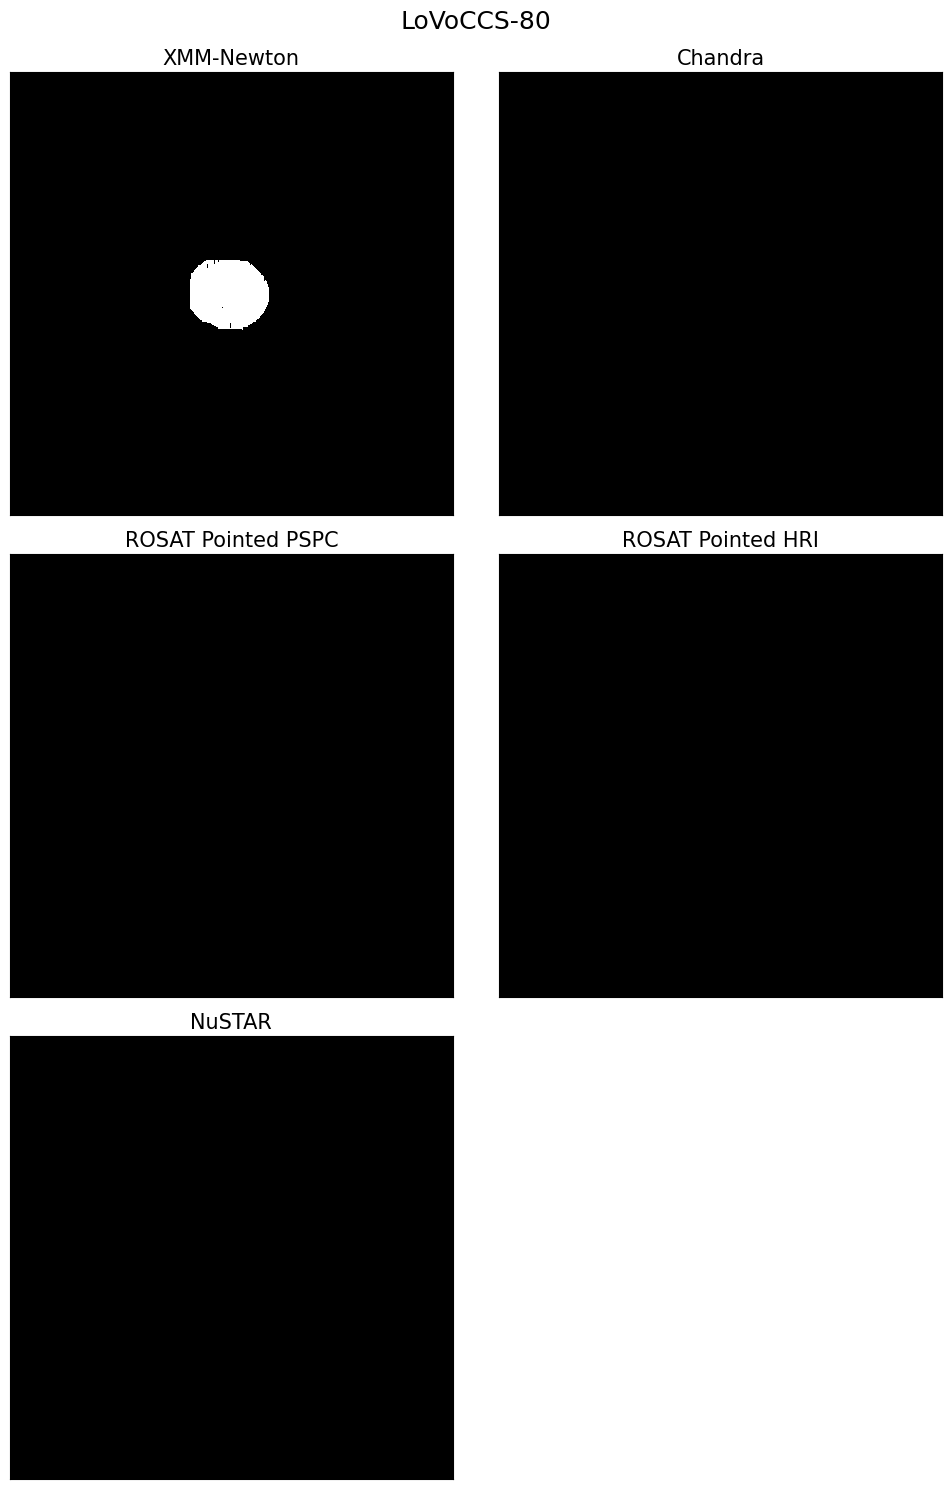

Generating coverage maps:  56%|█████▋    | 81/144 [04:28<04:55,  4.69s/it]

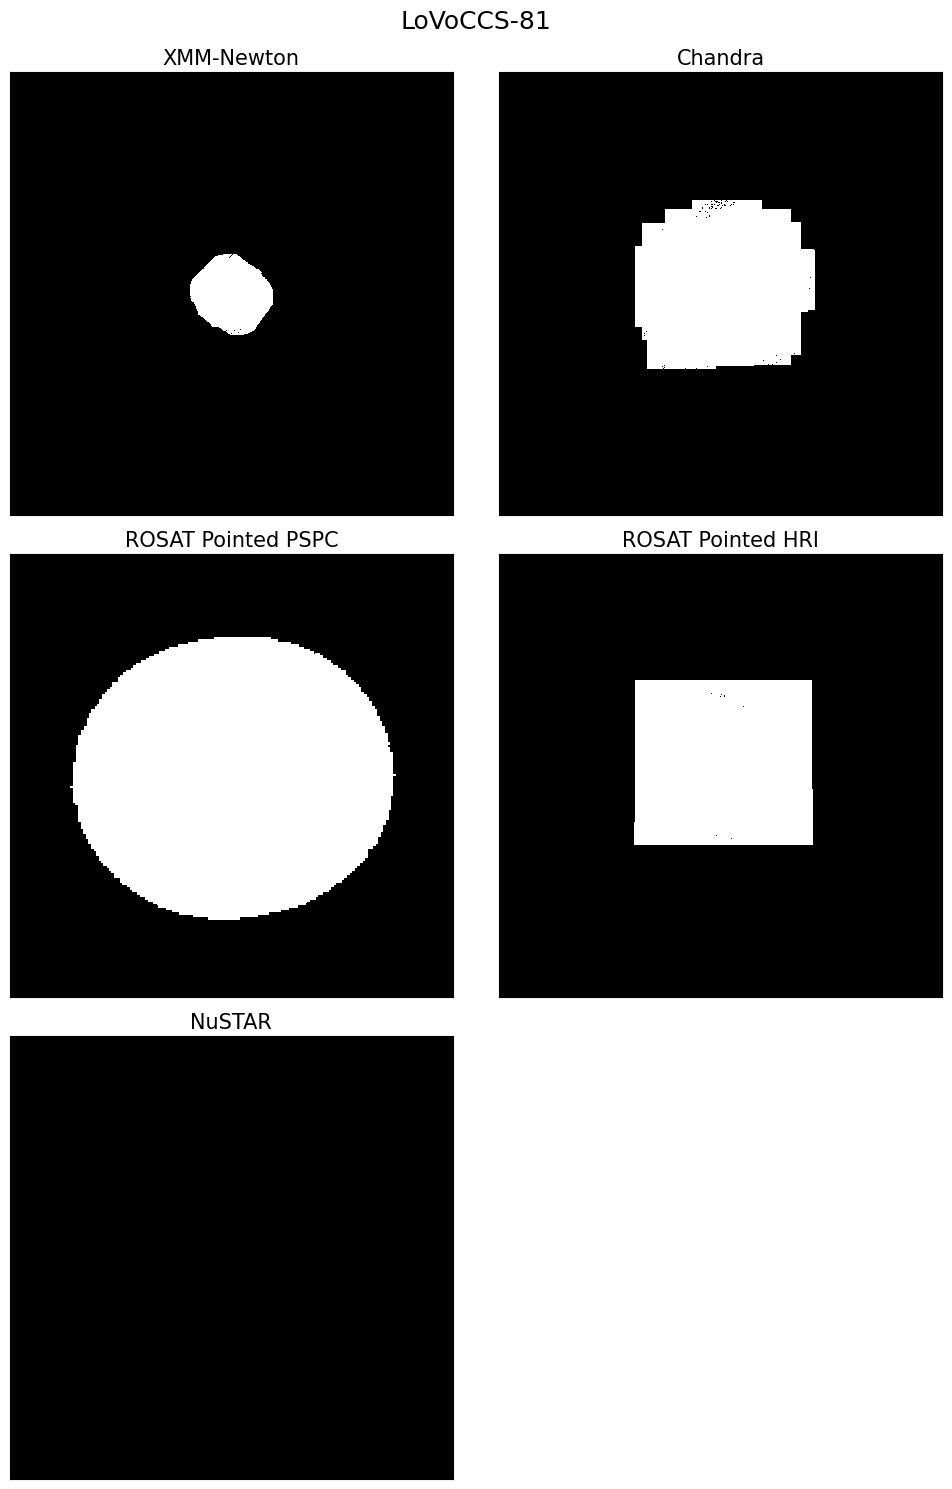

Generating coverage maps:  57%|█████▋    | 82/144 [04:32<04:34,  4.43s/it]

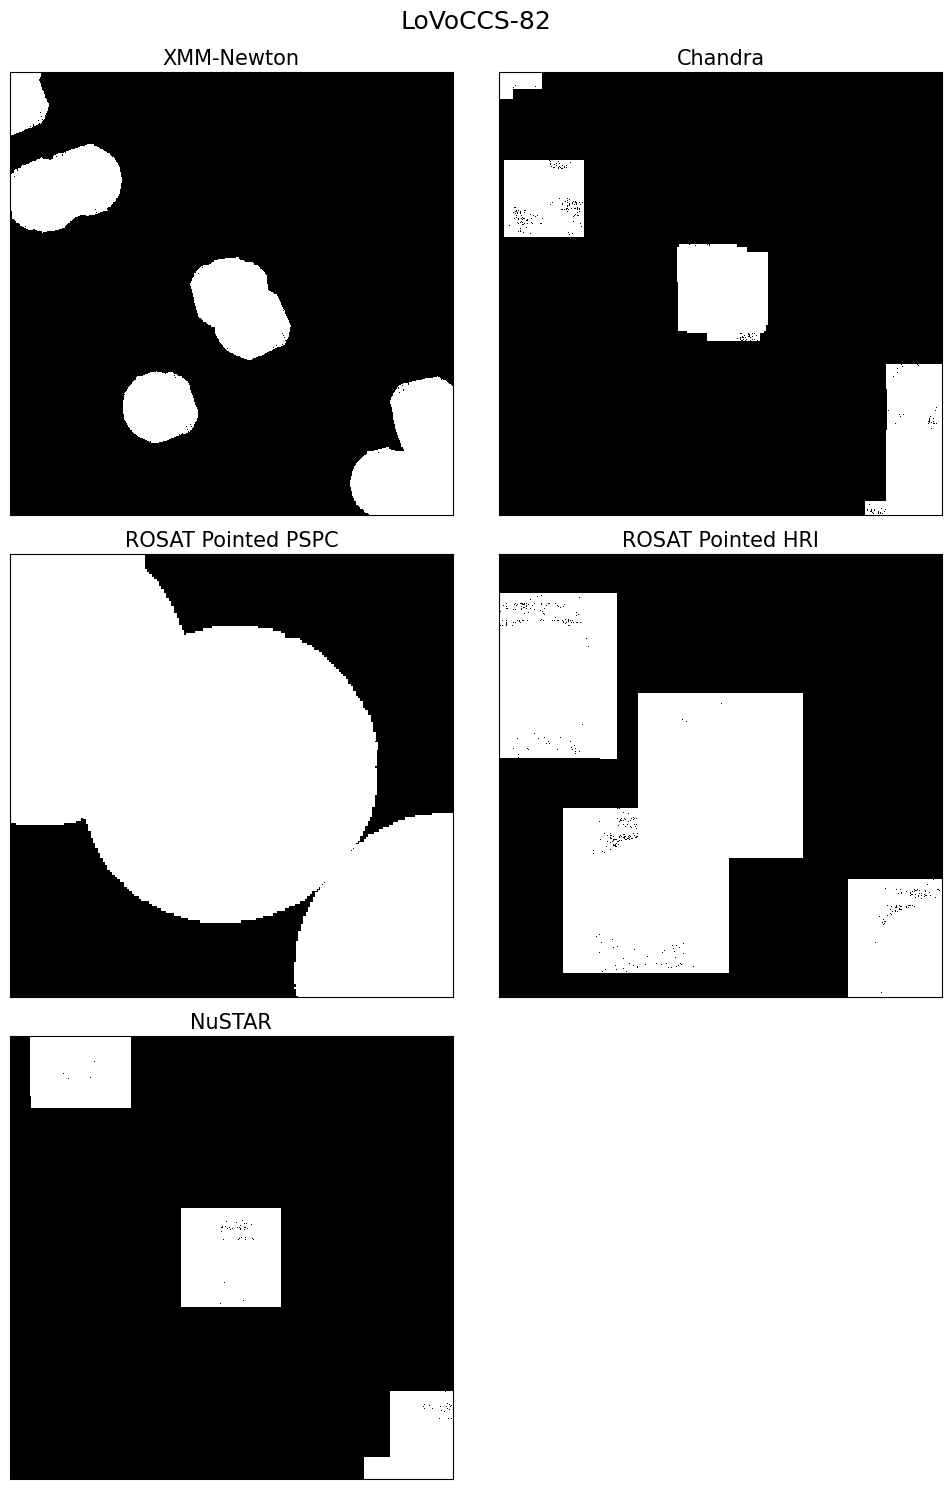

Generating coverage maps:  58%|█████▊    | 83/144 [04:41<06:01,  5.93s/it]

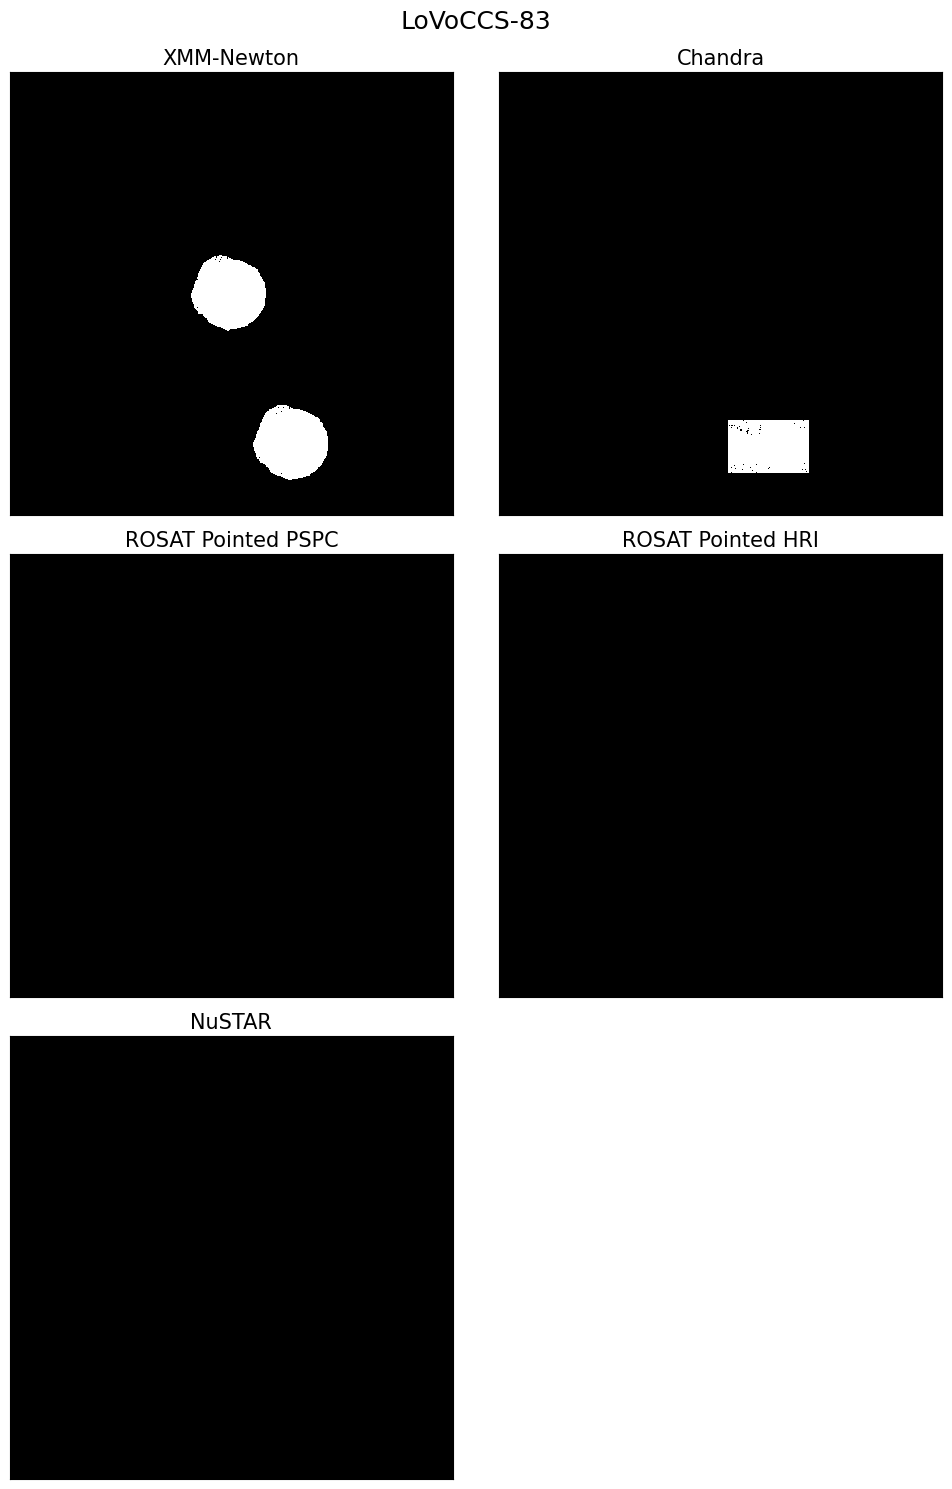

Generating coverage maps:  58%|█████▊    | 84/144 [04:44<04:50,  4.84s/it]

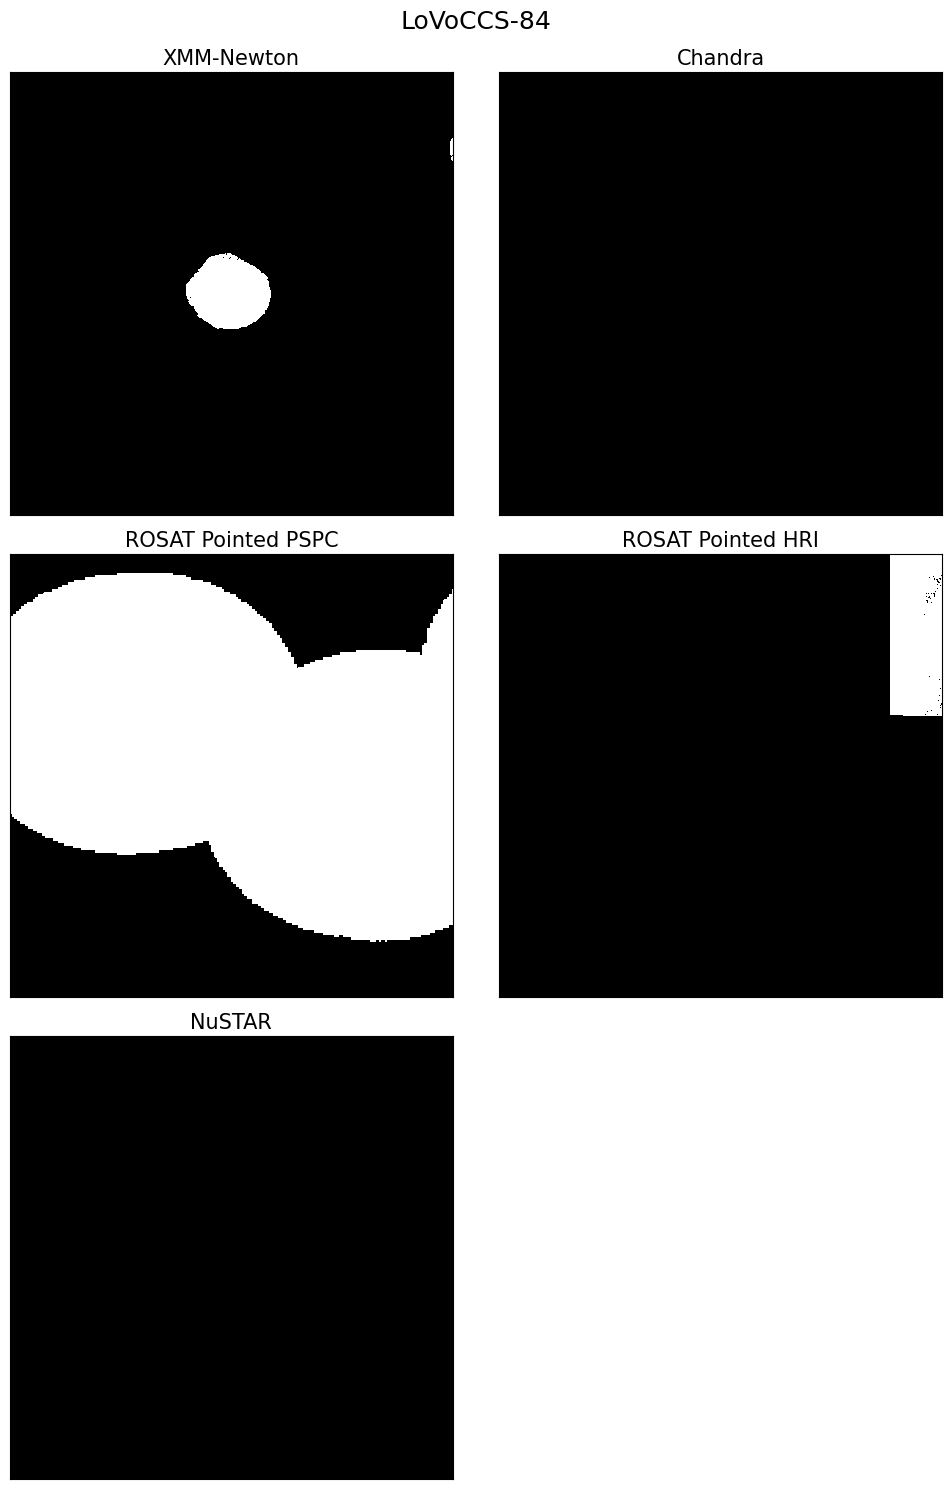

Generating coverage maps:  59%|█████▉    | 85/144 [04:45<03:48,  3.87s/it]

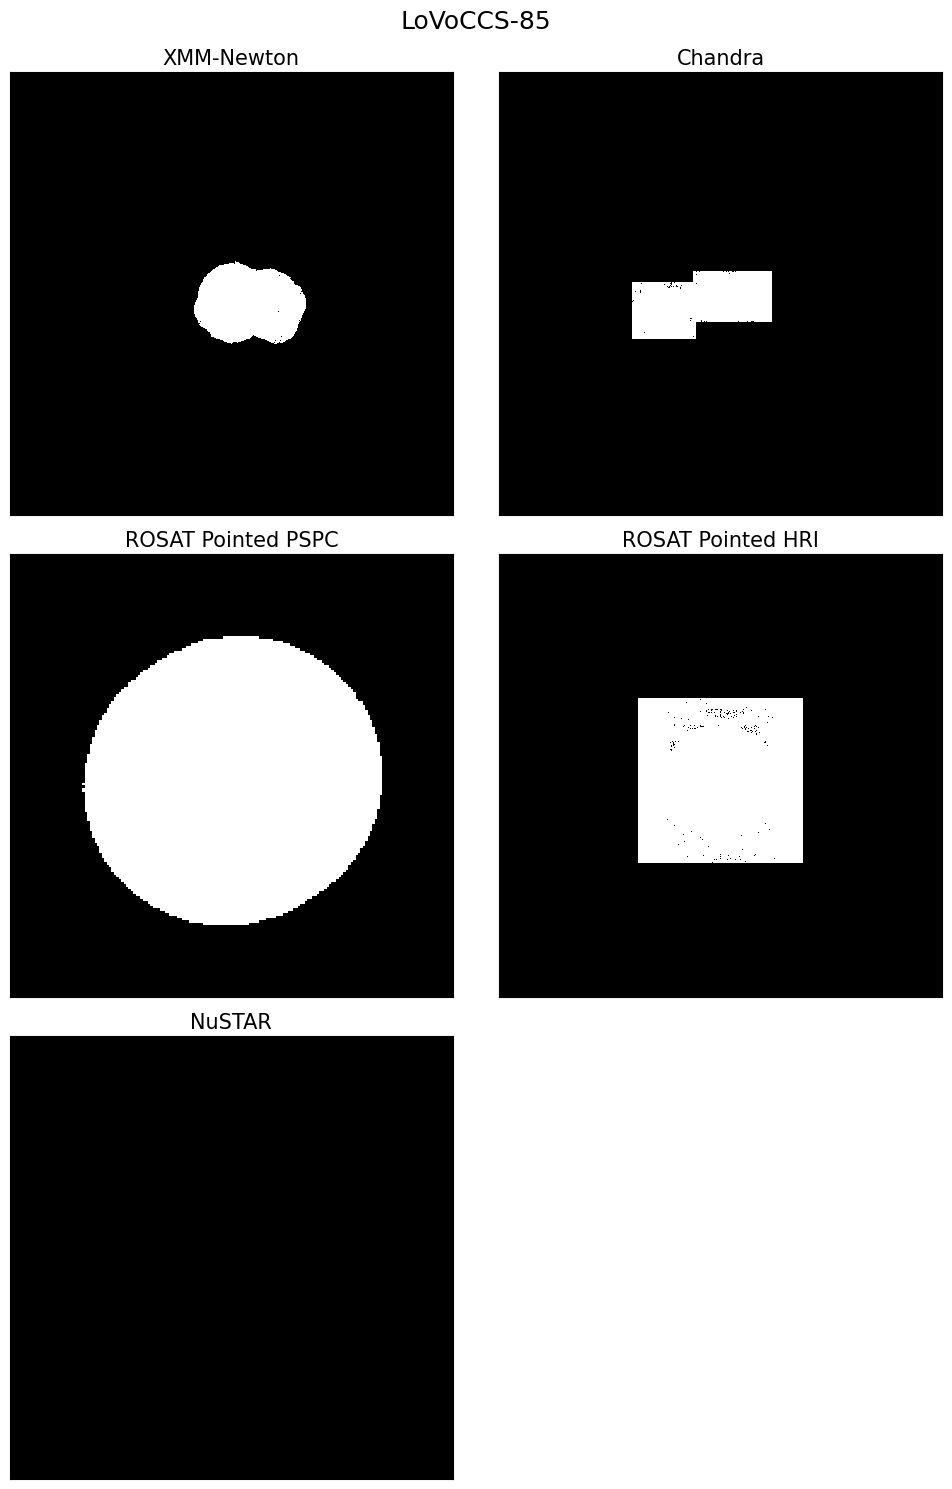

Generating coverage maps:  60%|█████▉    | 86/144 [04:47<03:11,  3.30s/it]

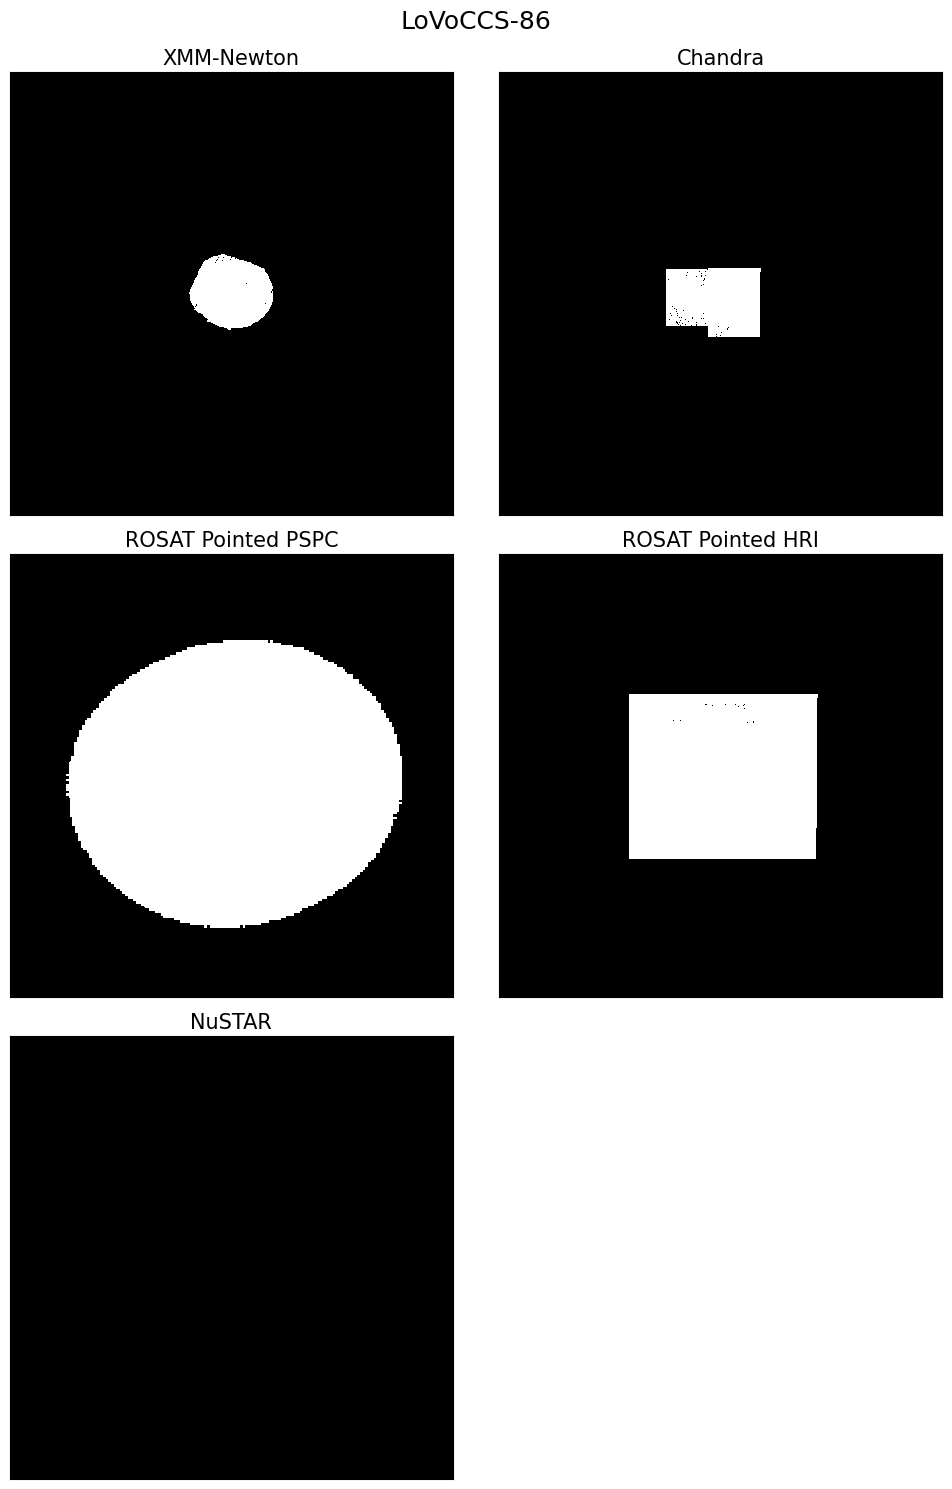

Generating coverage maps:  60%|██████    | 87/144 [04:49<02:41,  2.84s/it]

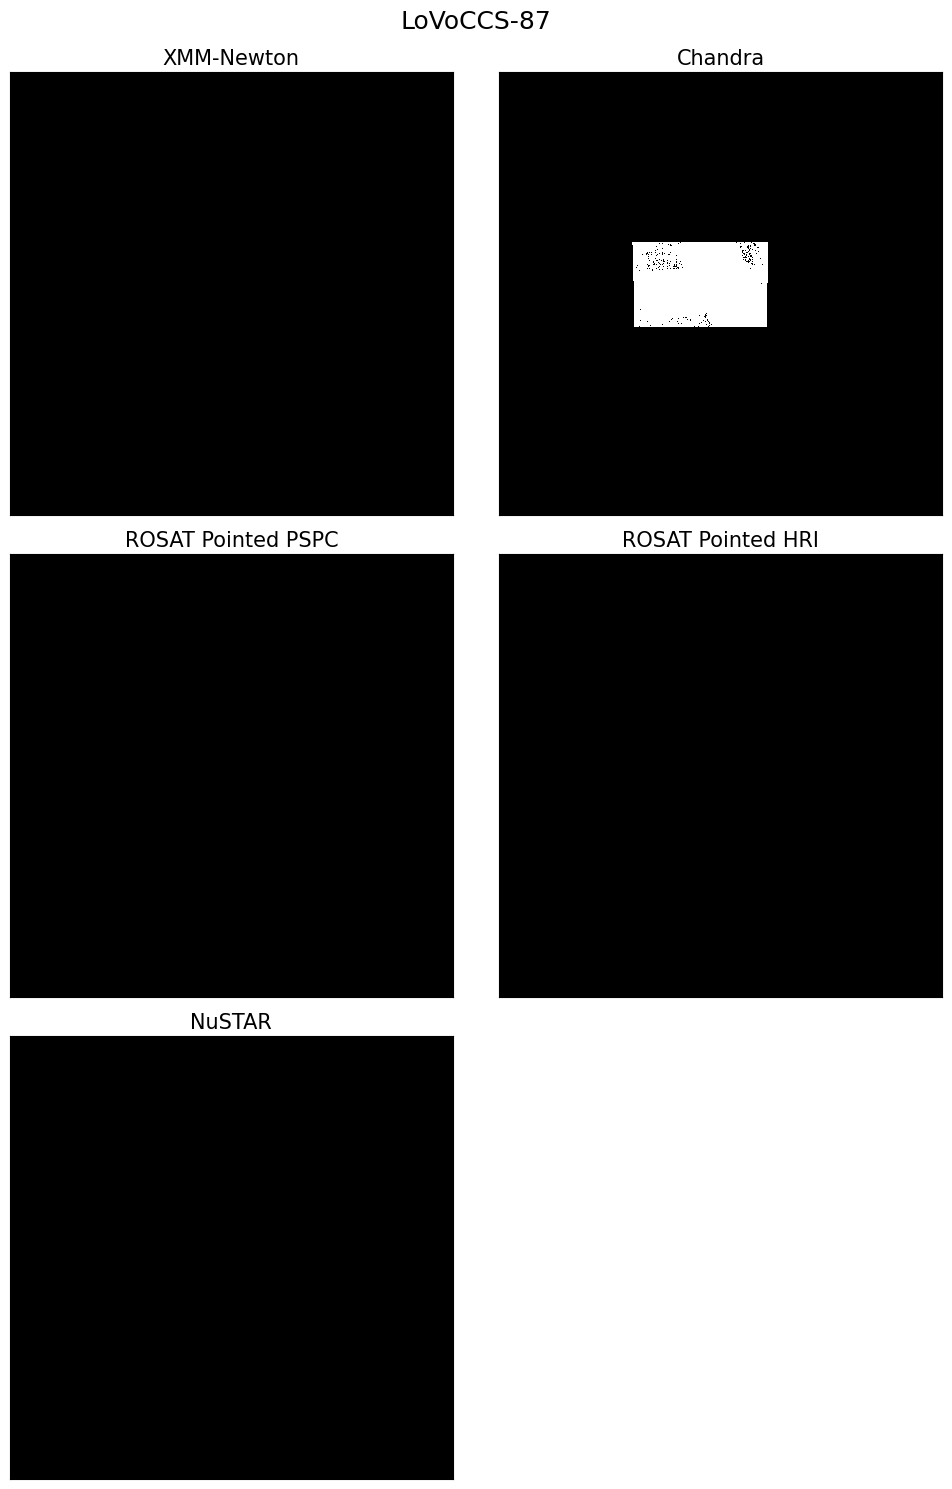

Generating coverage maps:  61%|██████    | 88/144 [04:50<02:11,  2.35s/it]

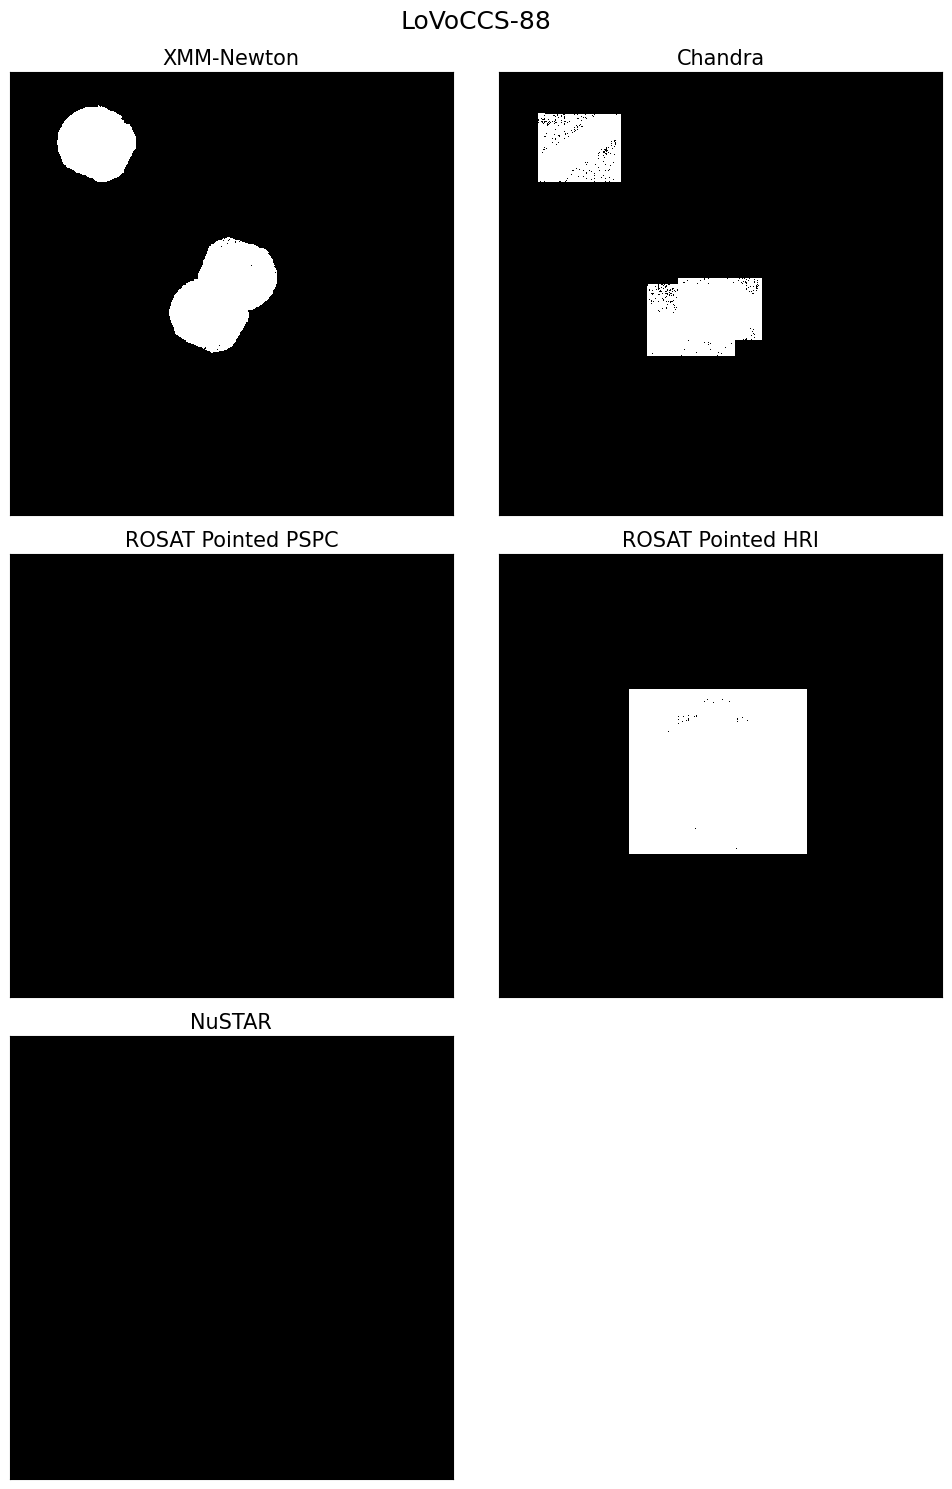

Generating coverage maps:  62%|██████▏   | 89/144 [04:52<02:03,  2.25s/it]

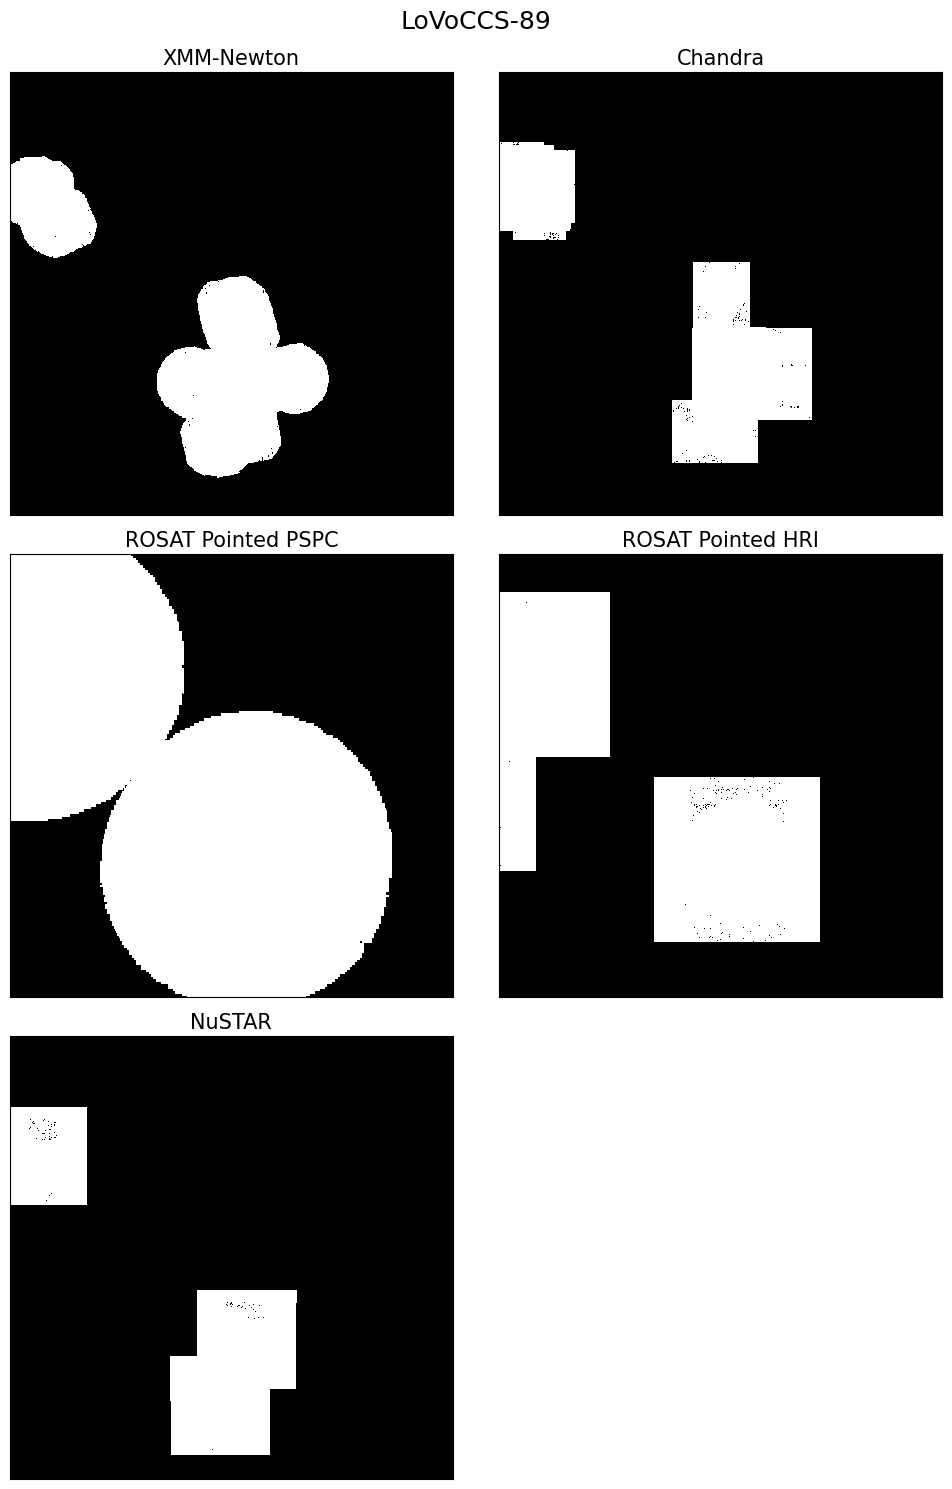

Generating coverage maps:  62%|██████▎   | 90/144 [05:02<03:54,  4.34s/it]

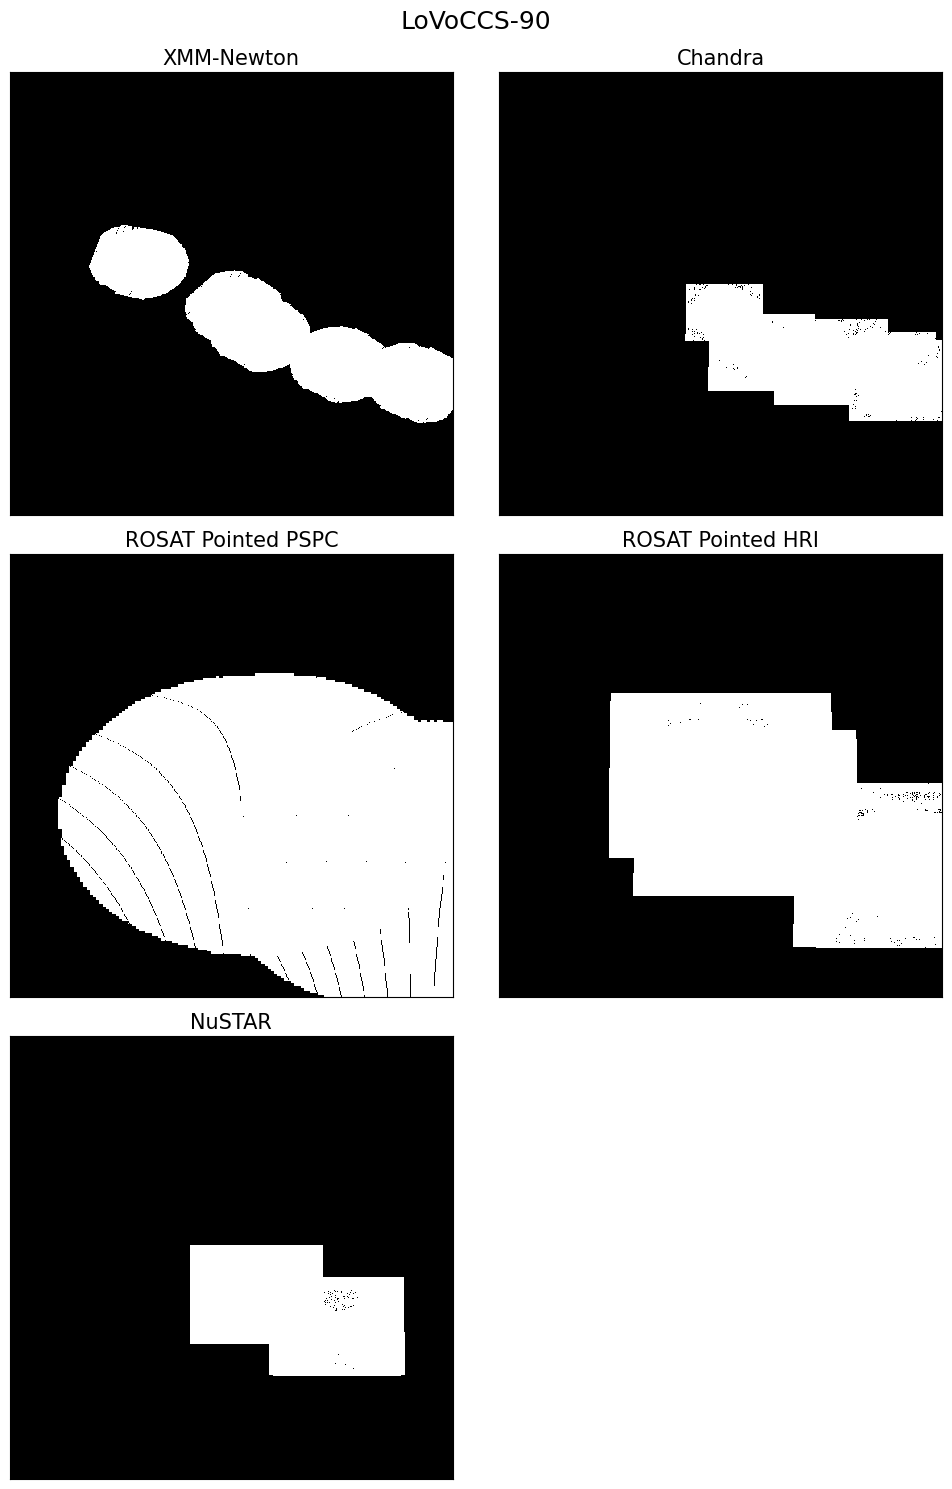

Generating coverage maps:  63%|██████▎   | 91/144 [05:07<04:01,  4.56s/it]

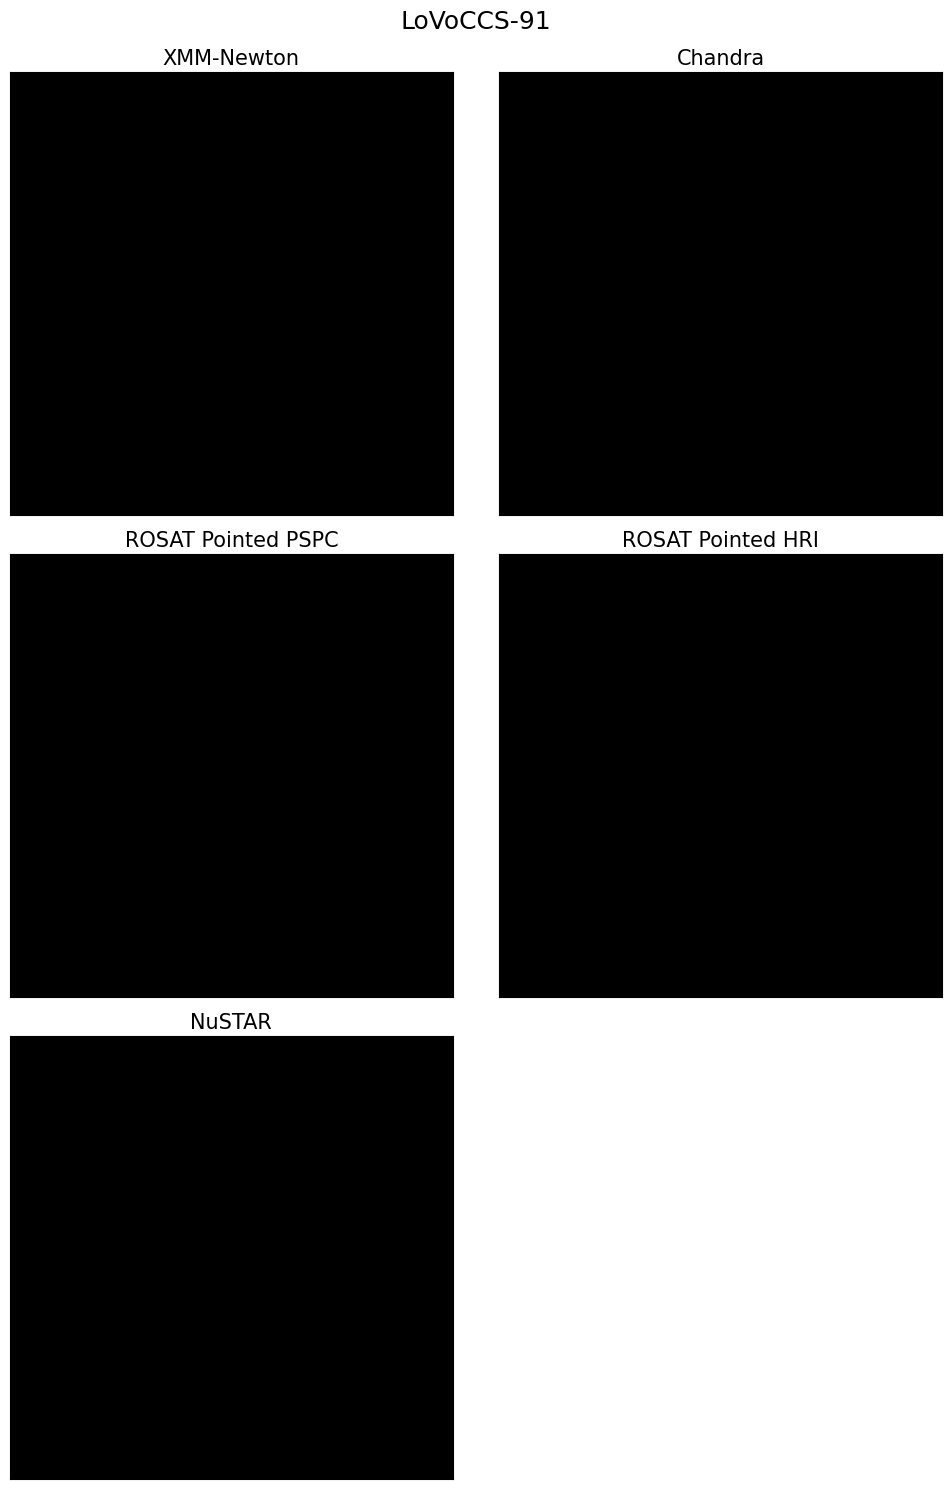

Generating coverage maps:  64%|██████▍   | 92/144 [05:08<03:01,  3.50s/it]

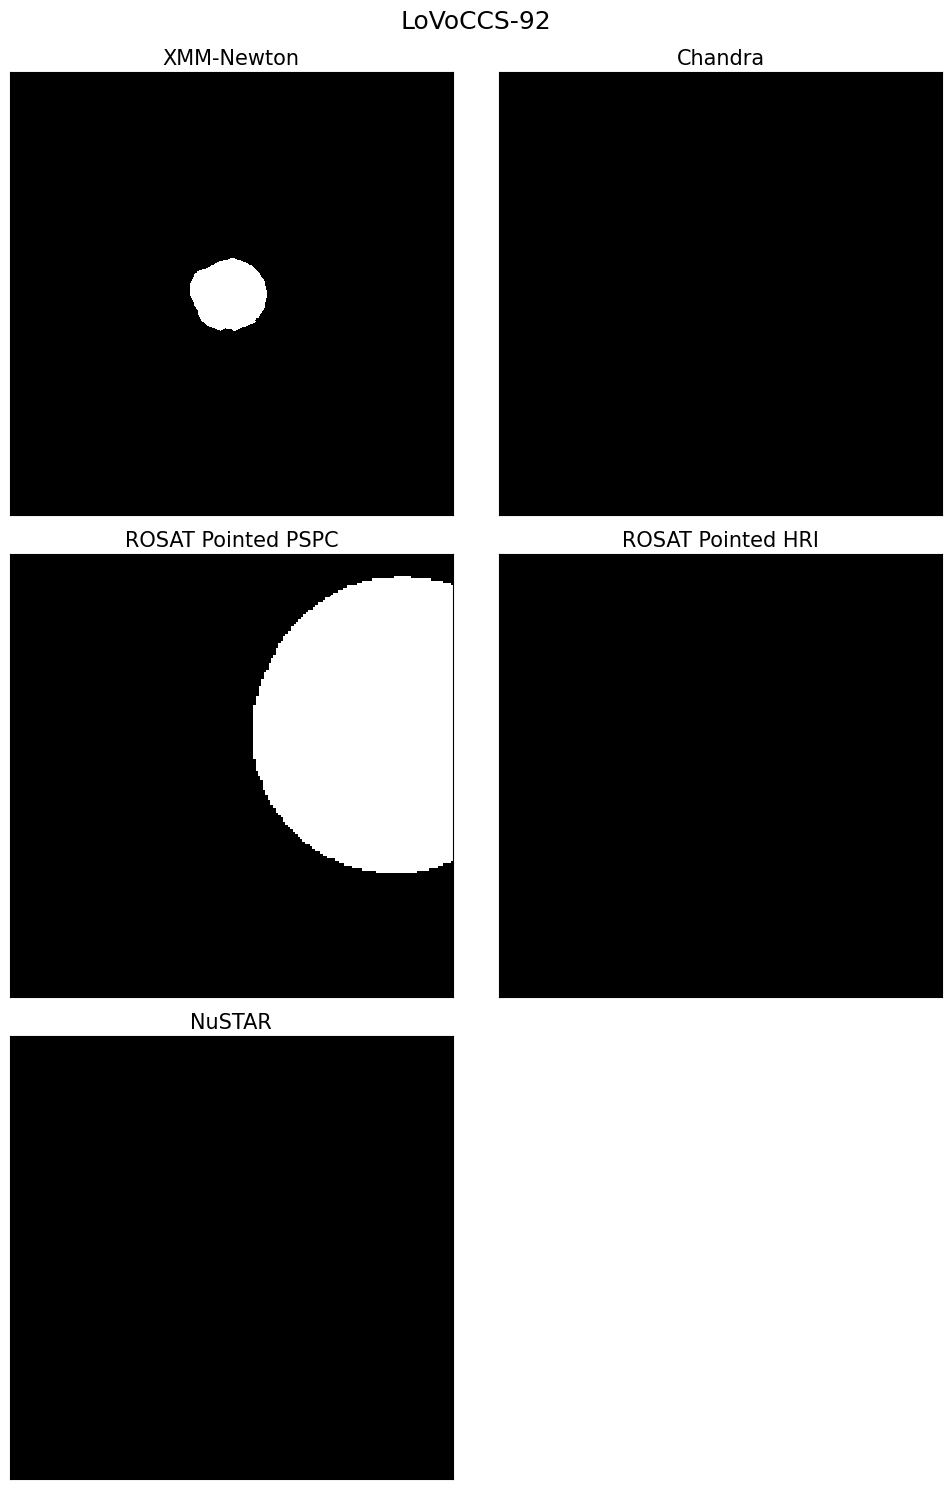

Generating coverage maps:  65%|██████▍   | 93/144 [05:09<02:29,  2.93s/it]

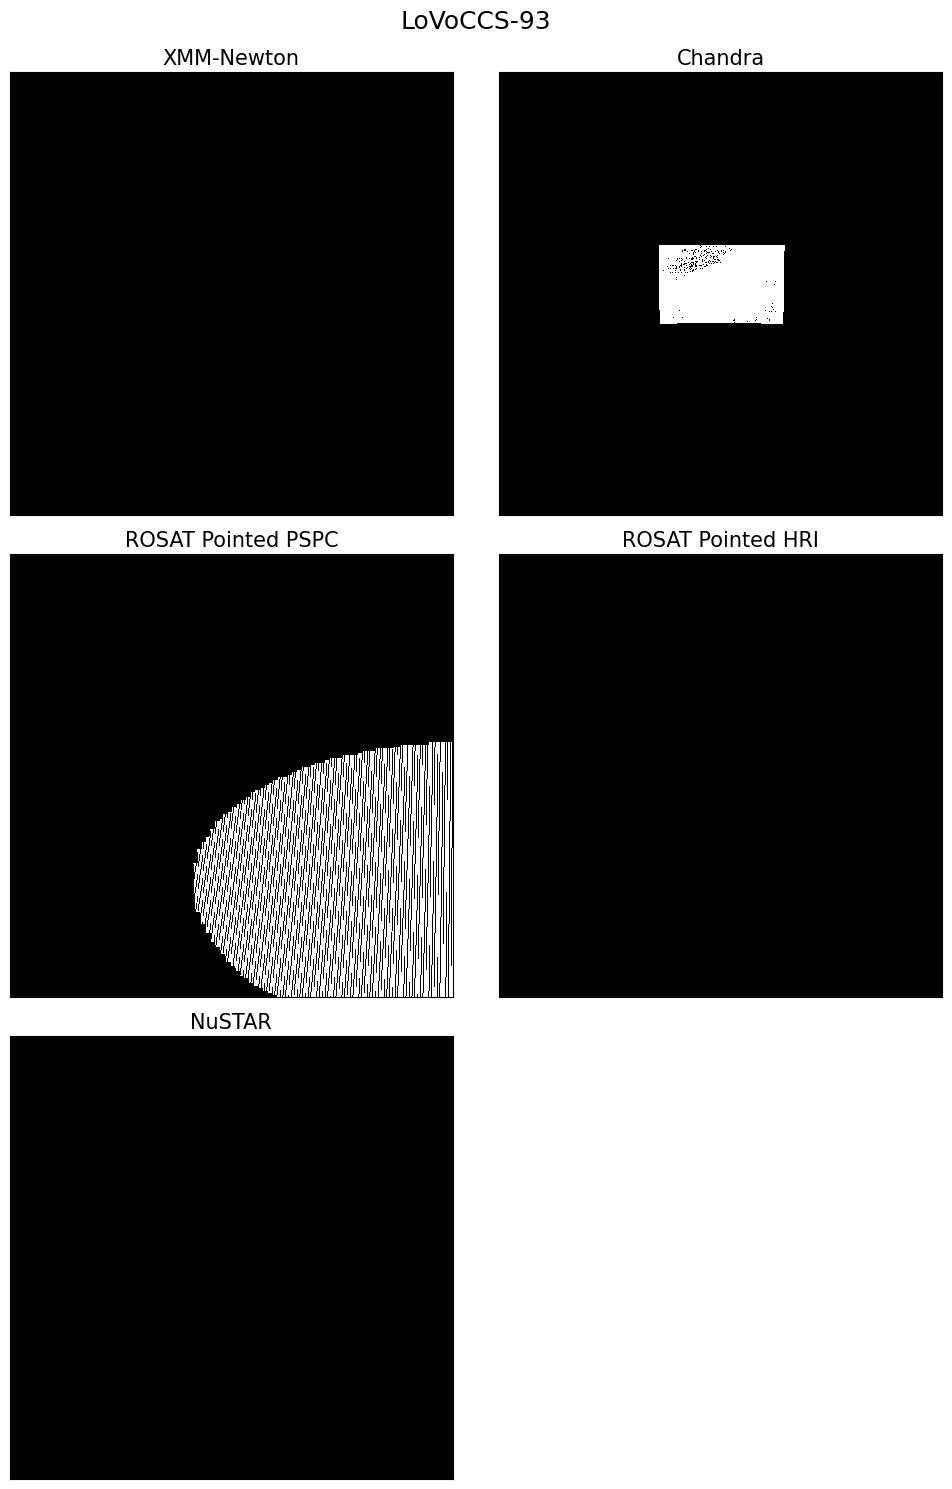

Generating coverage maps:  65%|██████▌   | 94/144 [05:10<02:01,  2.43s/it]

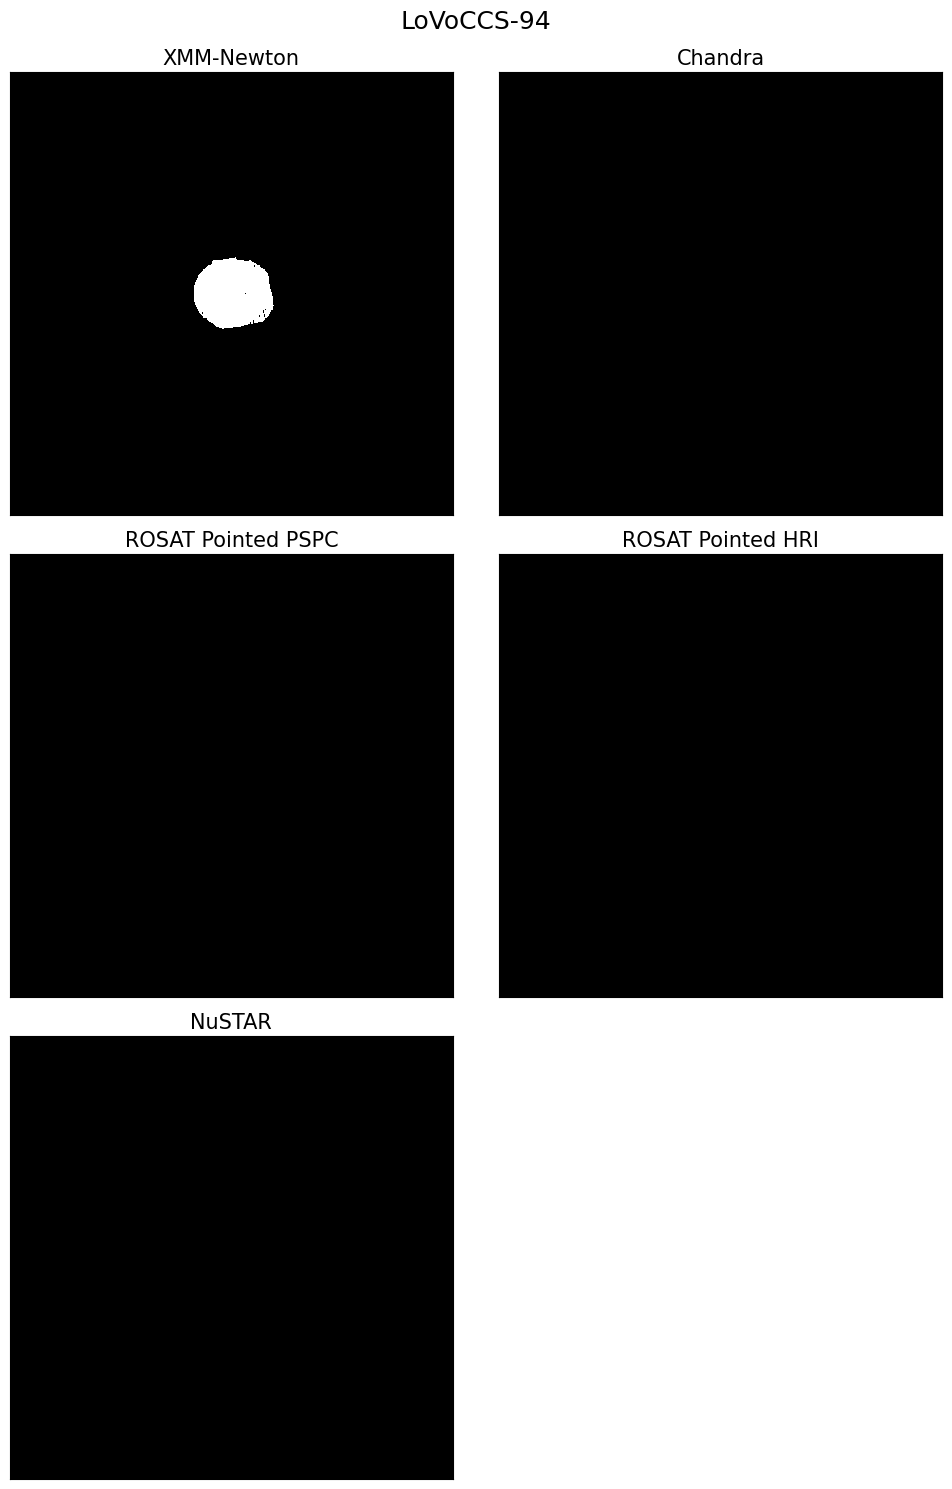

Generating coverage maps:  66%|██████▌   | 95/144 [05:12<01:41,  2.07s/it]

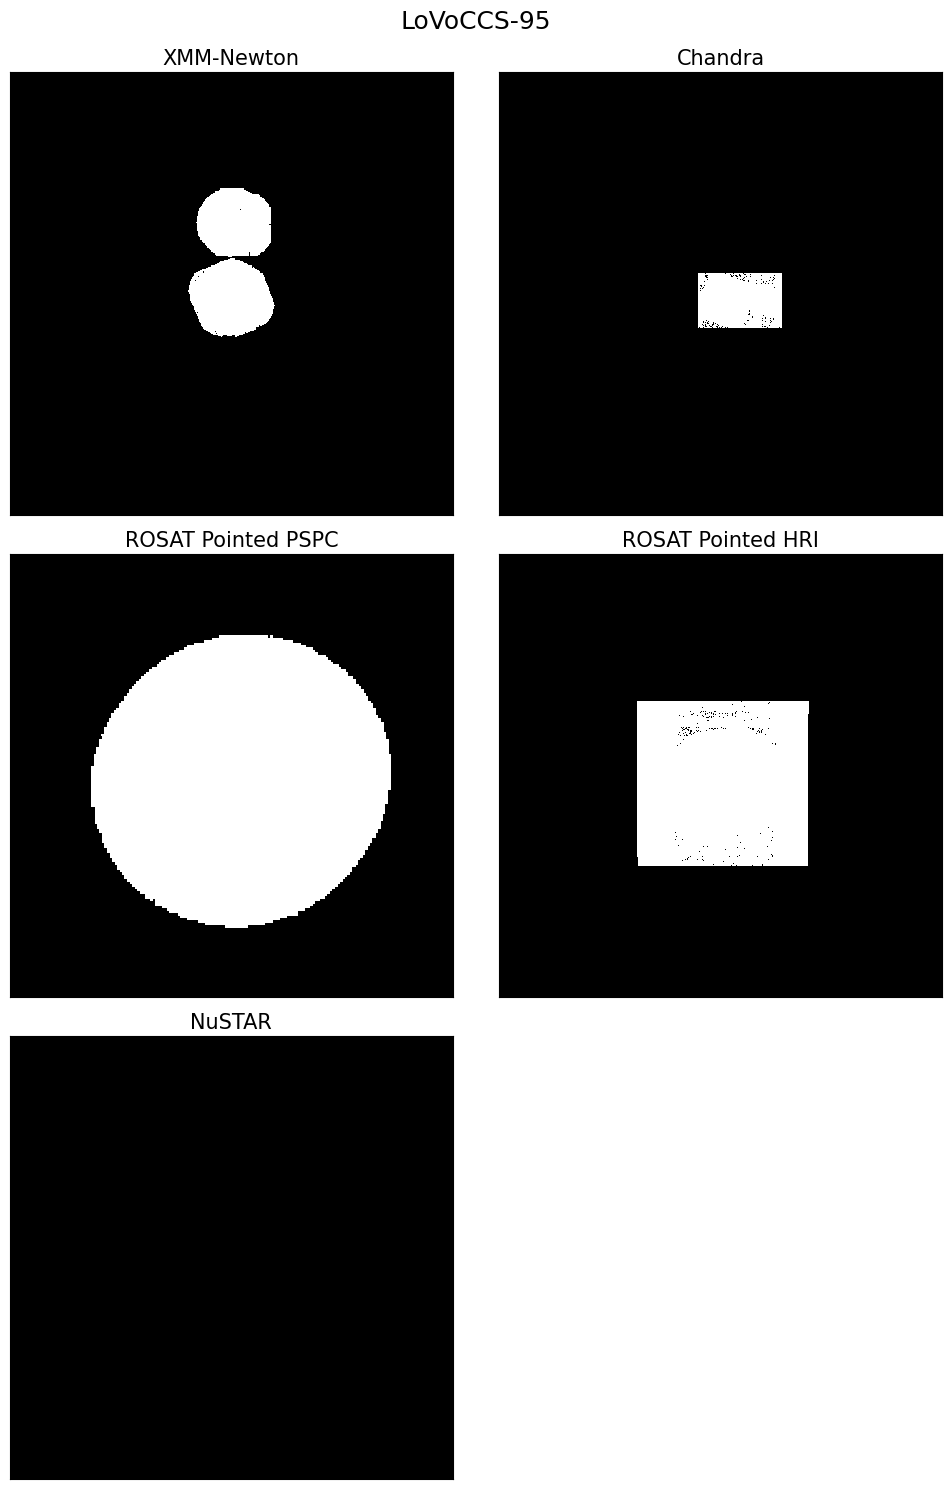

Generating coverage maps:  67%|██████▋   | 96/144 [05:14<01:38,  2.06s/it]

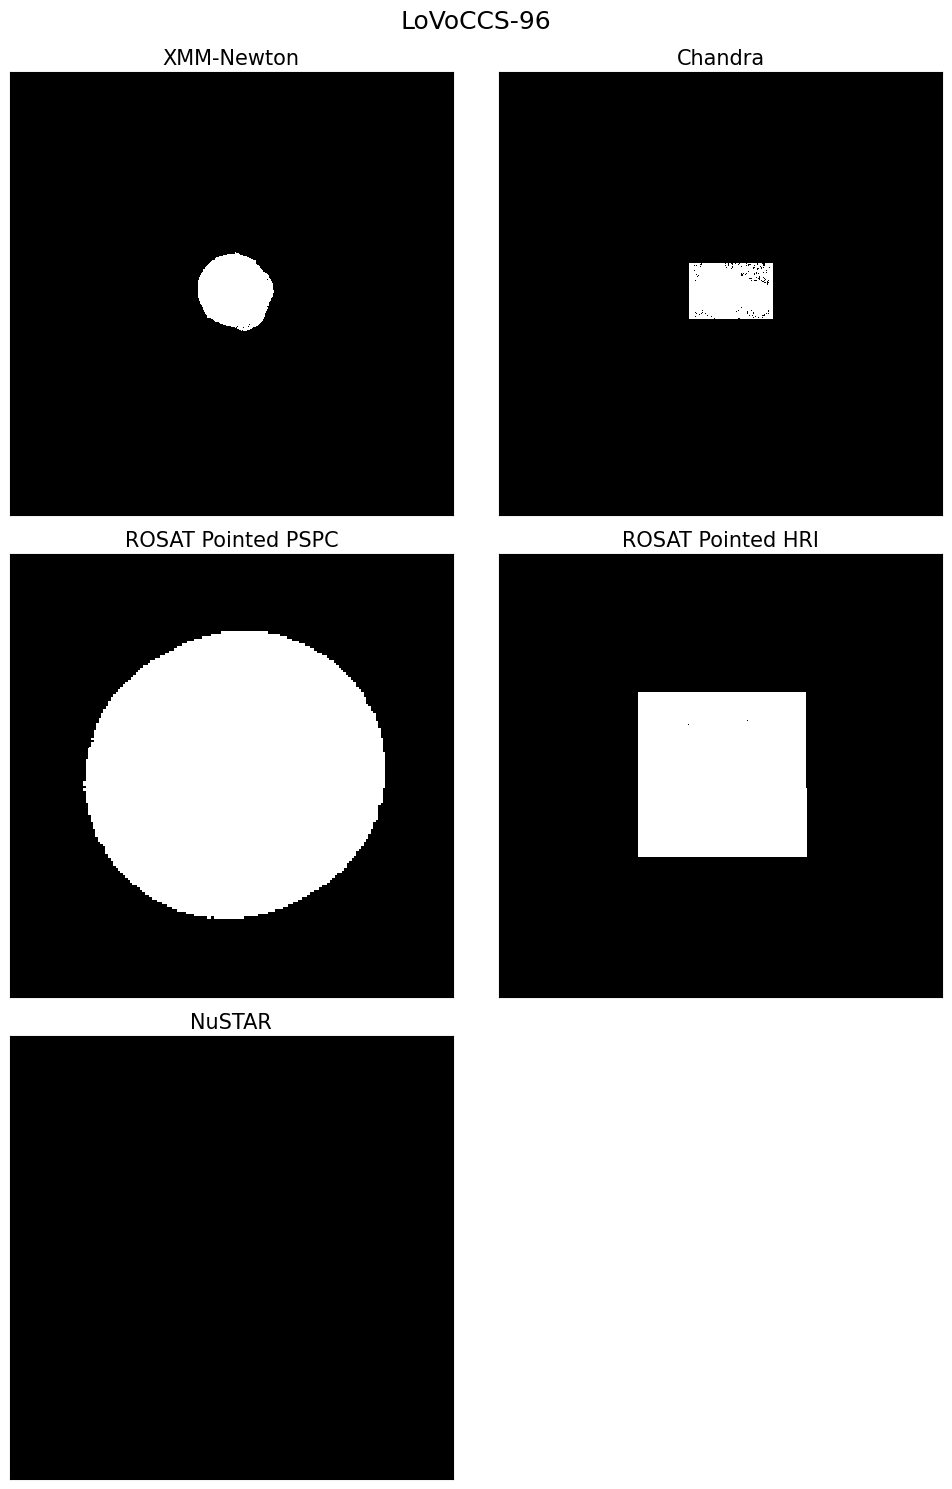

Generating coverage maps:  67%|██████▋   | 97/144 [05:15<01:29,  1.90s/it]

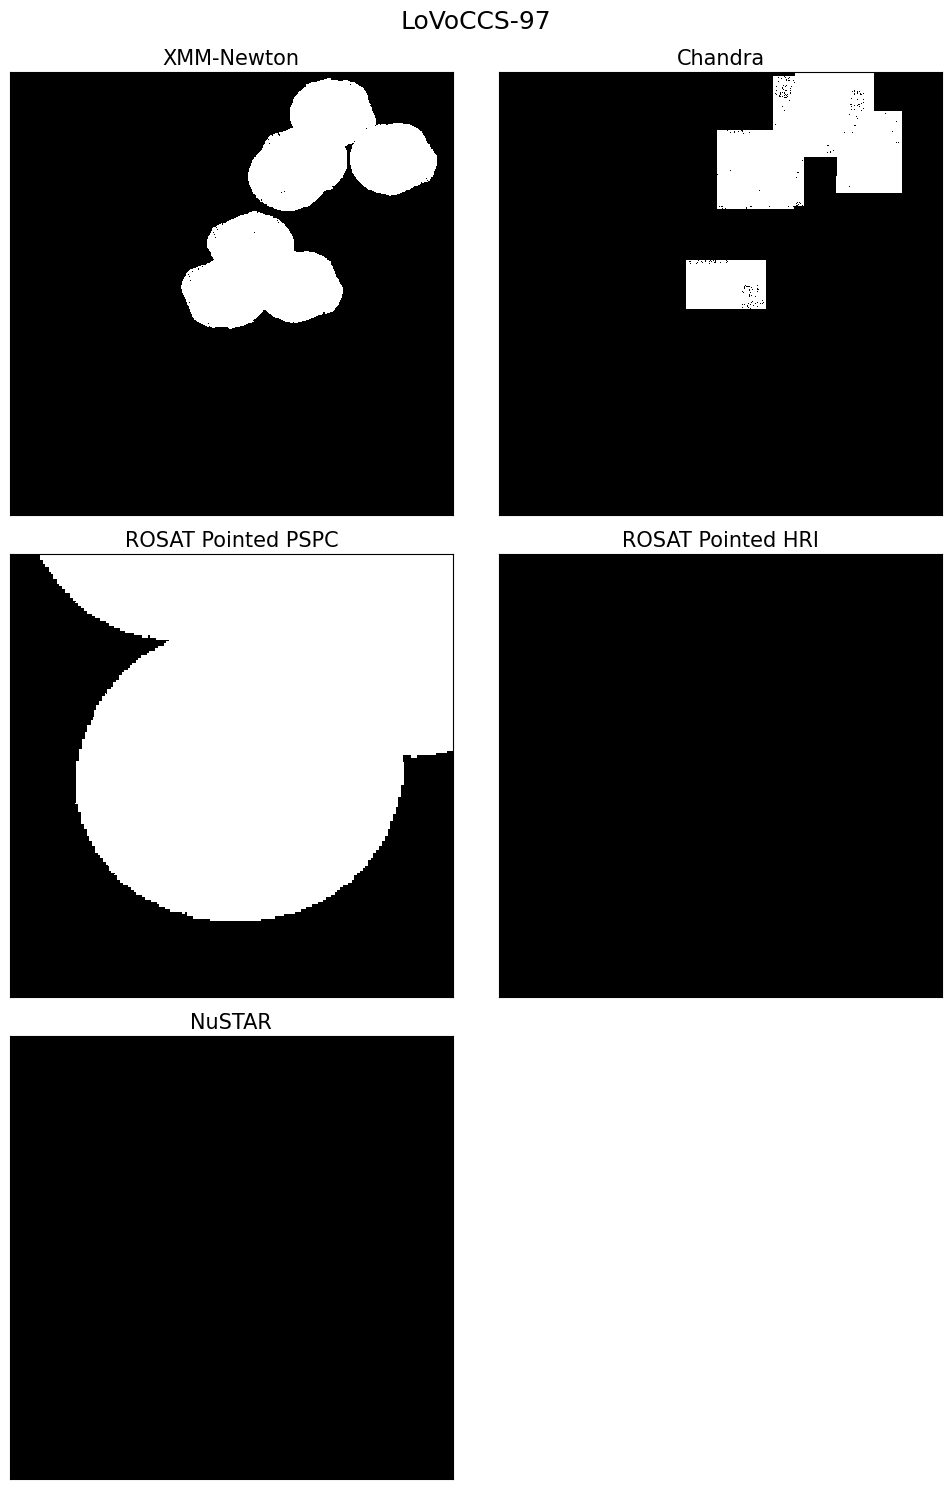

Generating coverage maps:  68%|██████▊   | 98/144 [05:19<01:46,  2.30s/it]

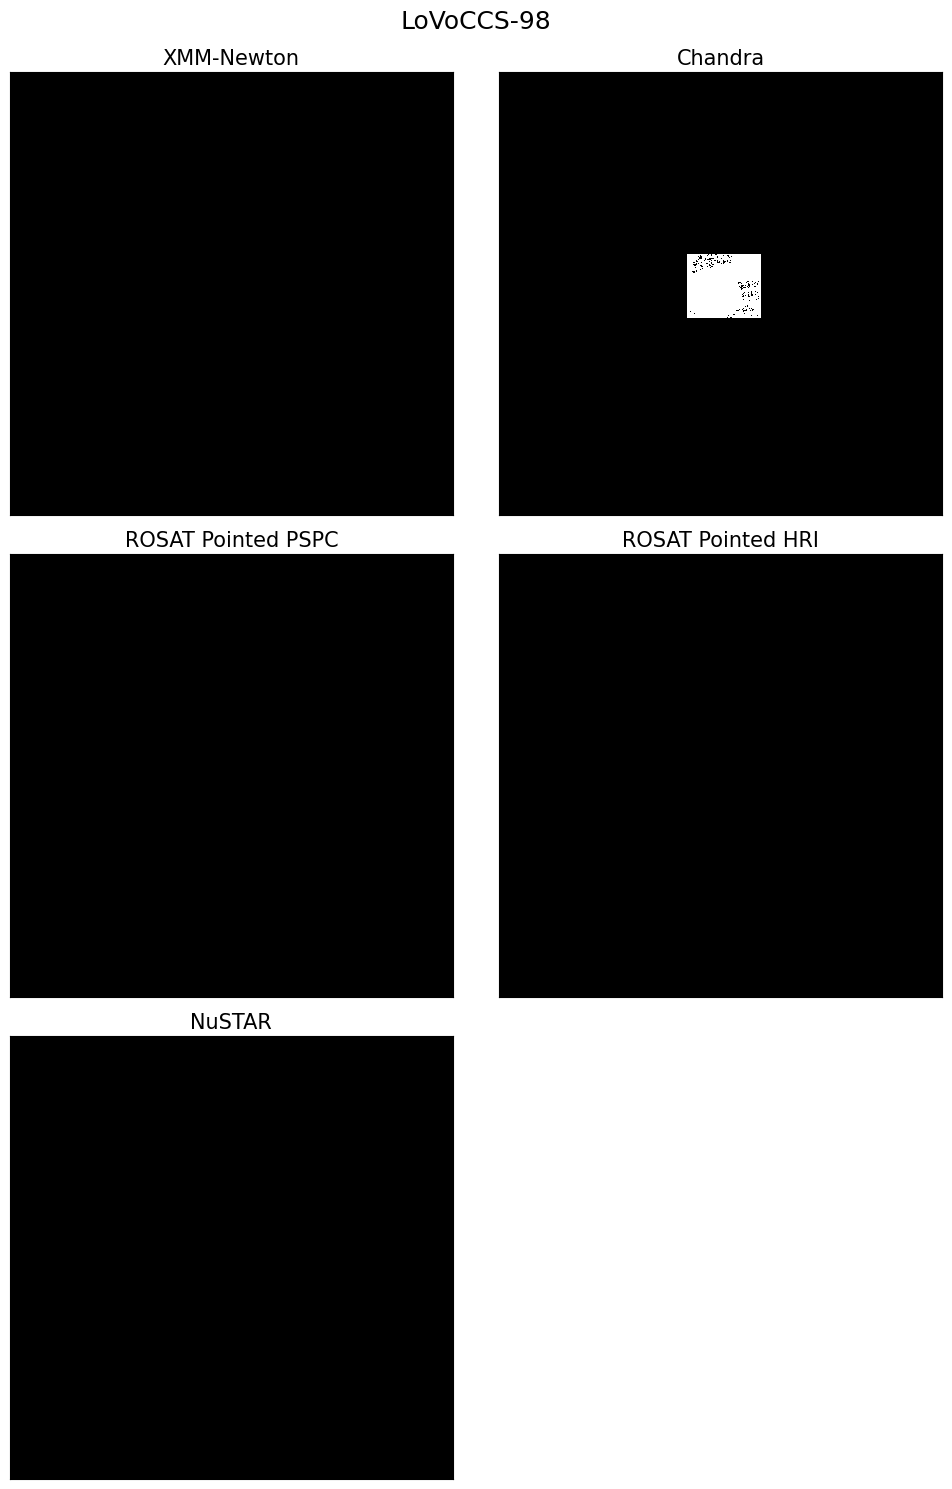

Generating coverage maps:  69%|██████▉   | 99/144 [05:20<01:27,  1.93s/it]

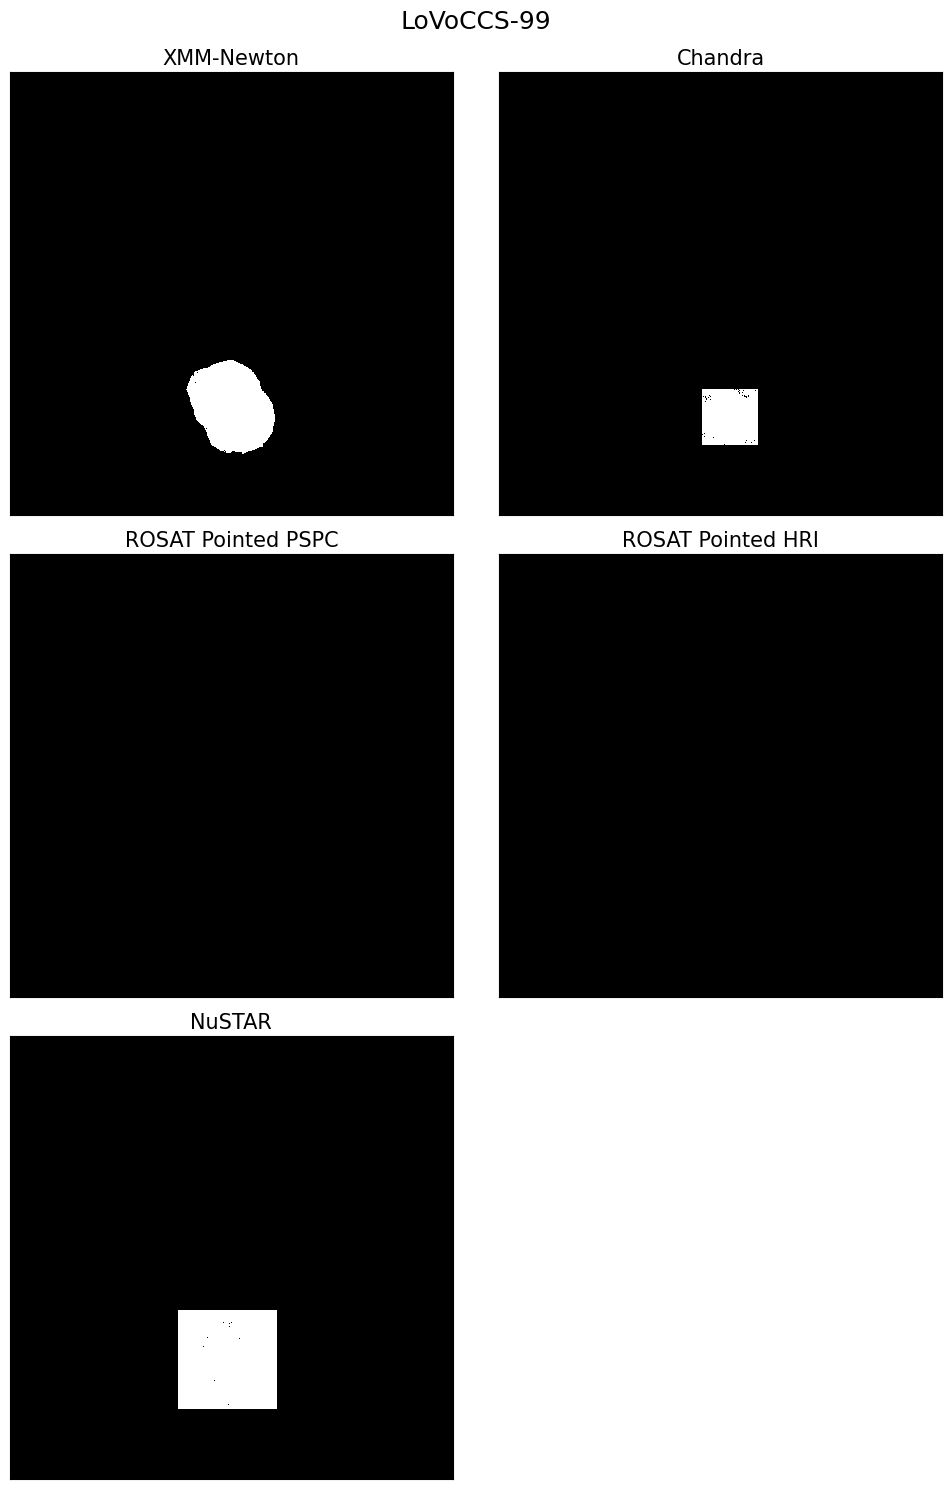

Generating coverage maps:  69%|██████▉   | 100/144 [05:23<01:42,  2.32s/it]

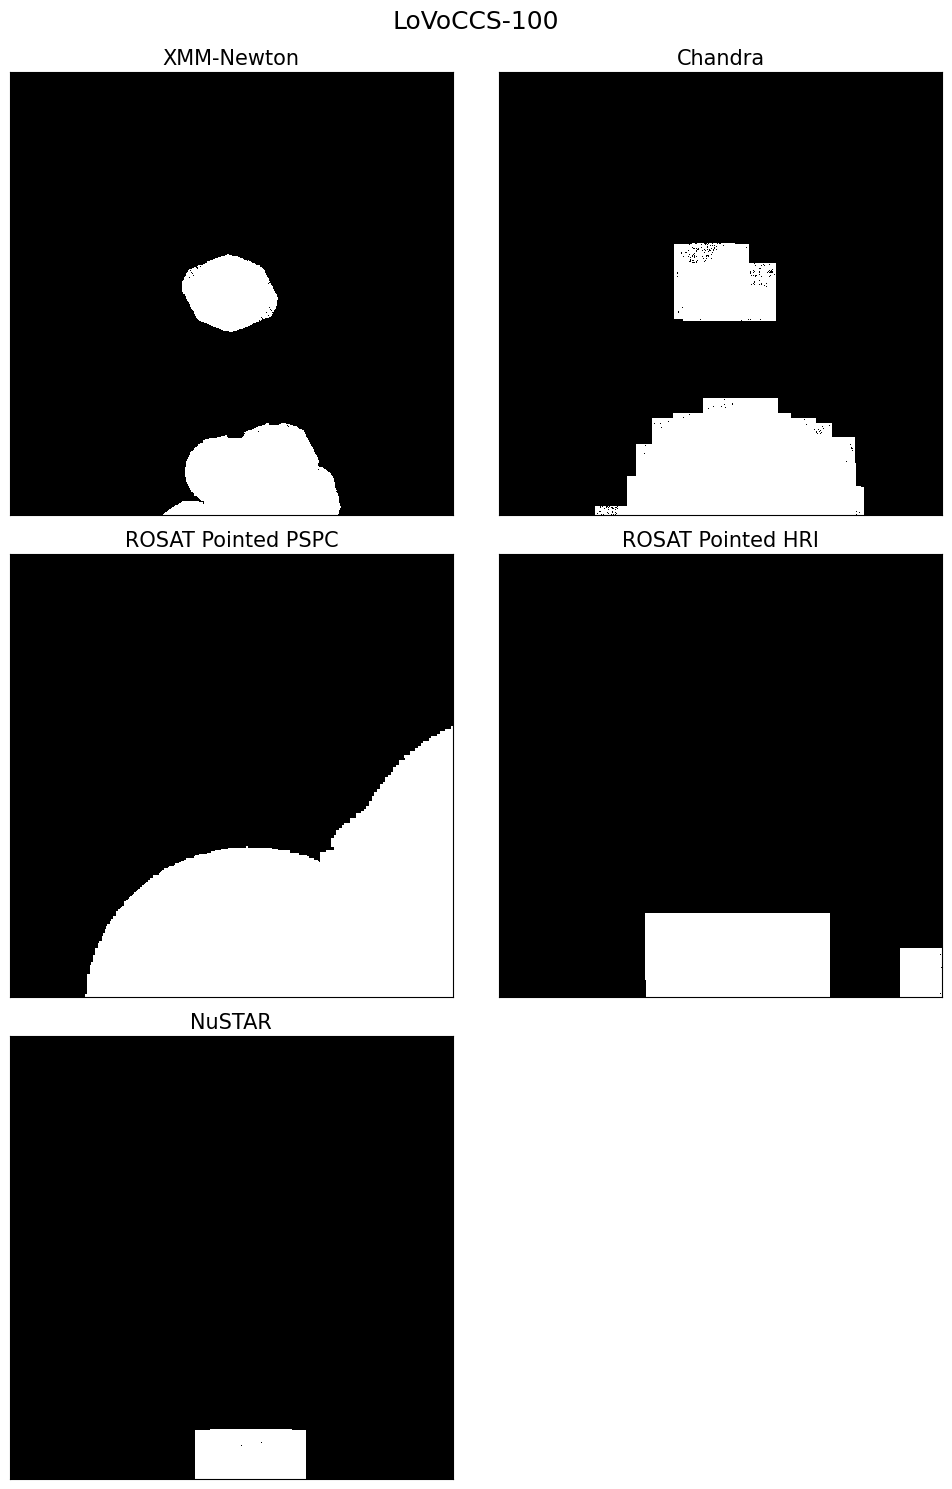

Generating coverage maps:  70%|███████   | 101/144 [05:43<05:36,  7.82s/it]

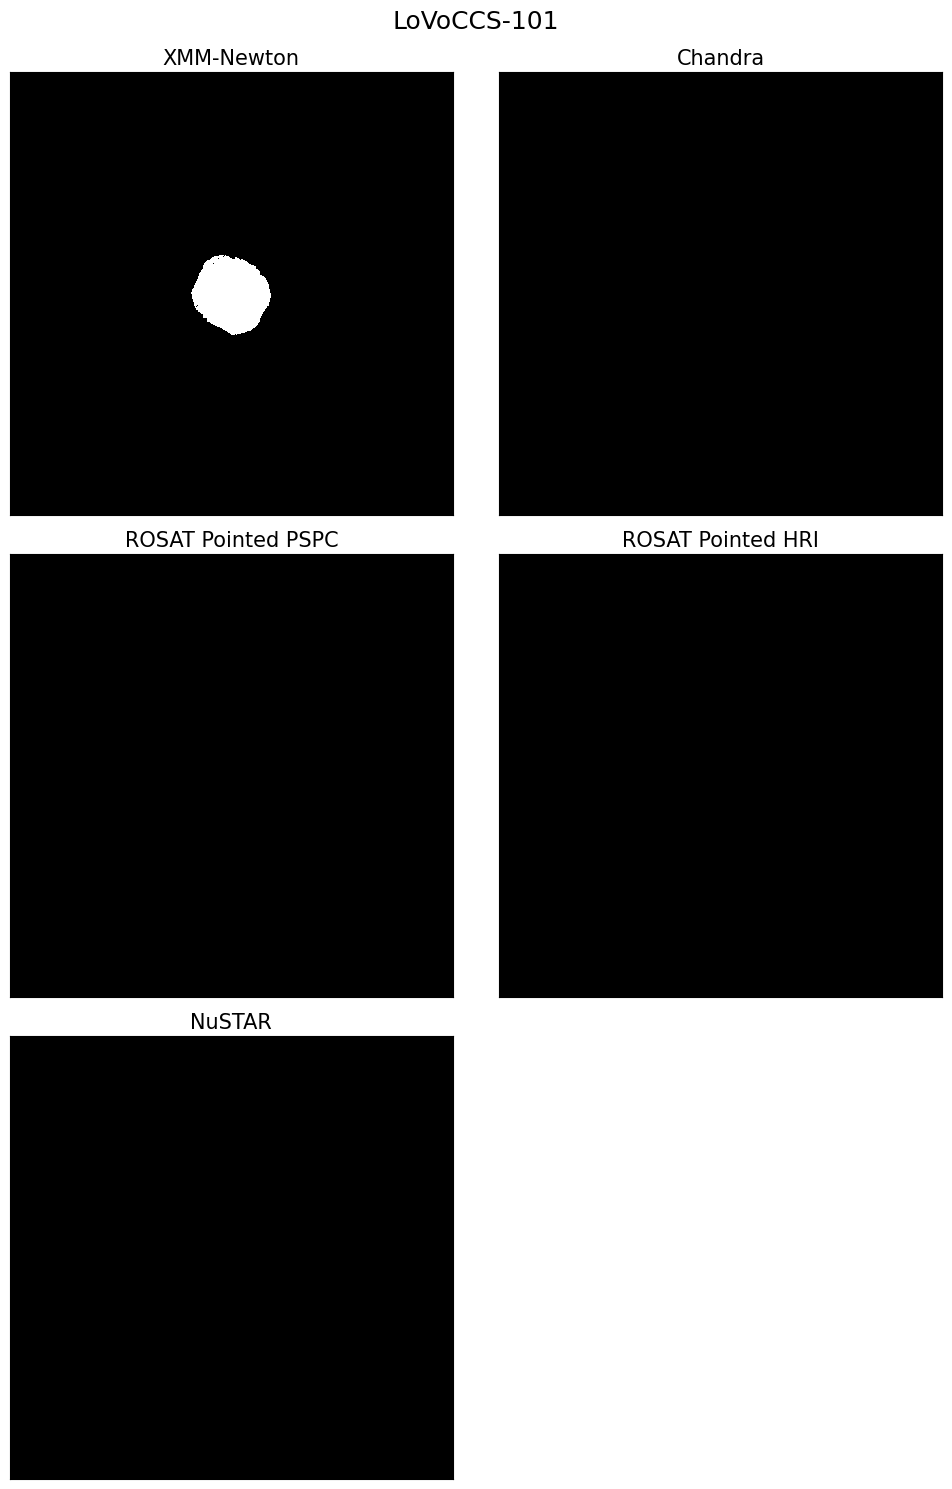

Generating coverage maps:  71%|███████   | 102/144 [05:45<04:12,  6.02s/it]

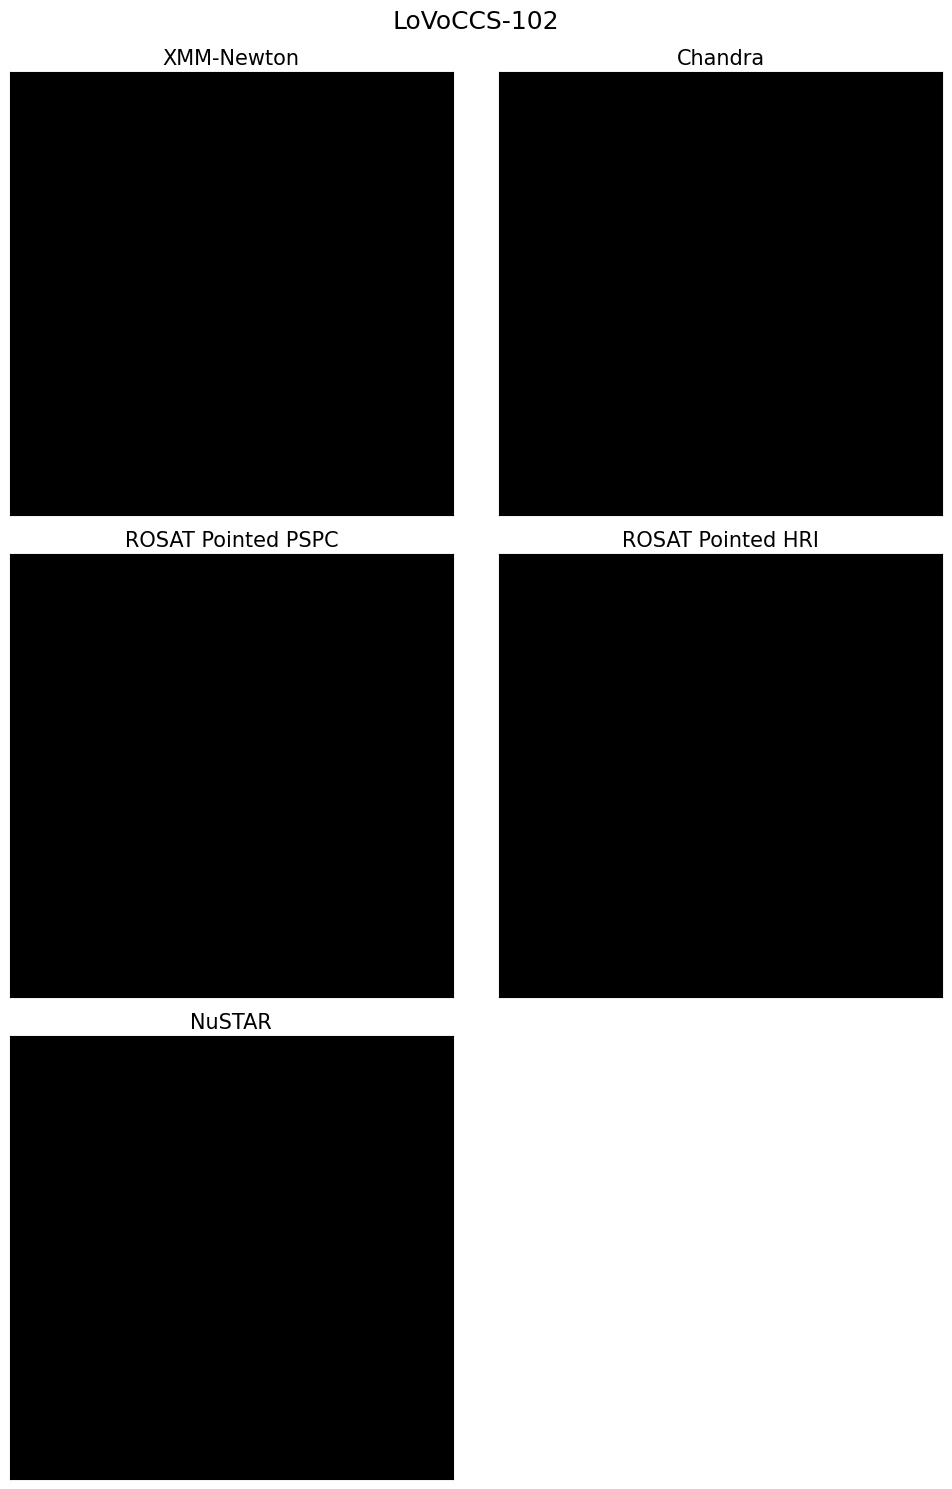

Generating coverage maps:  72%|███████▏  | 103/144 [05:46<03:05,  4.52s/it]

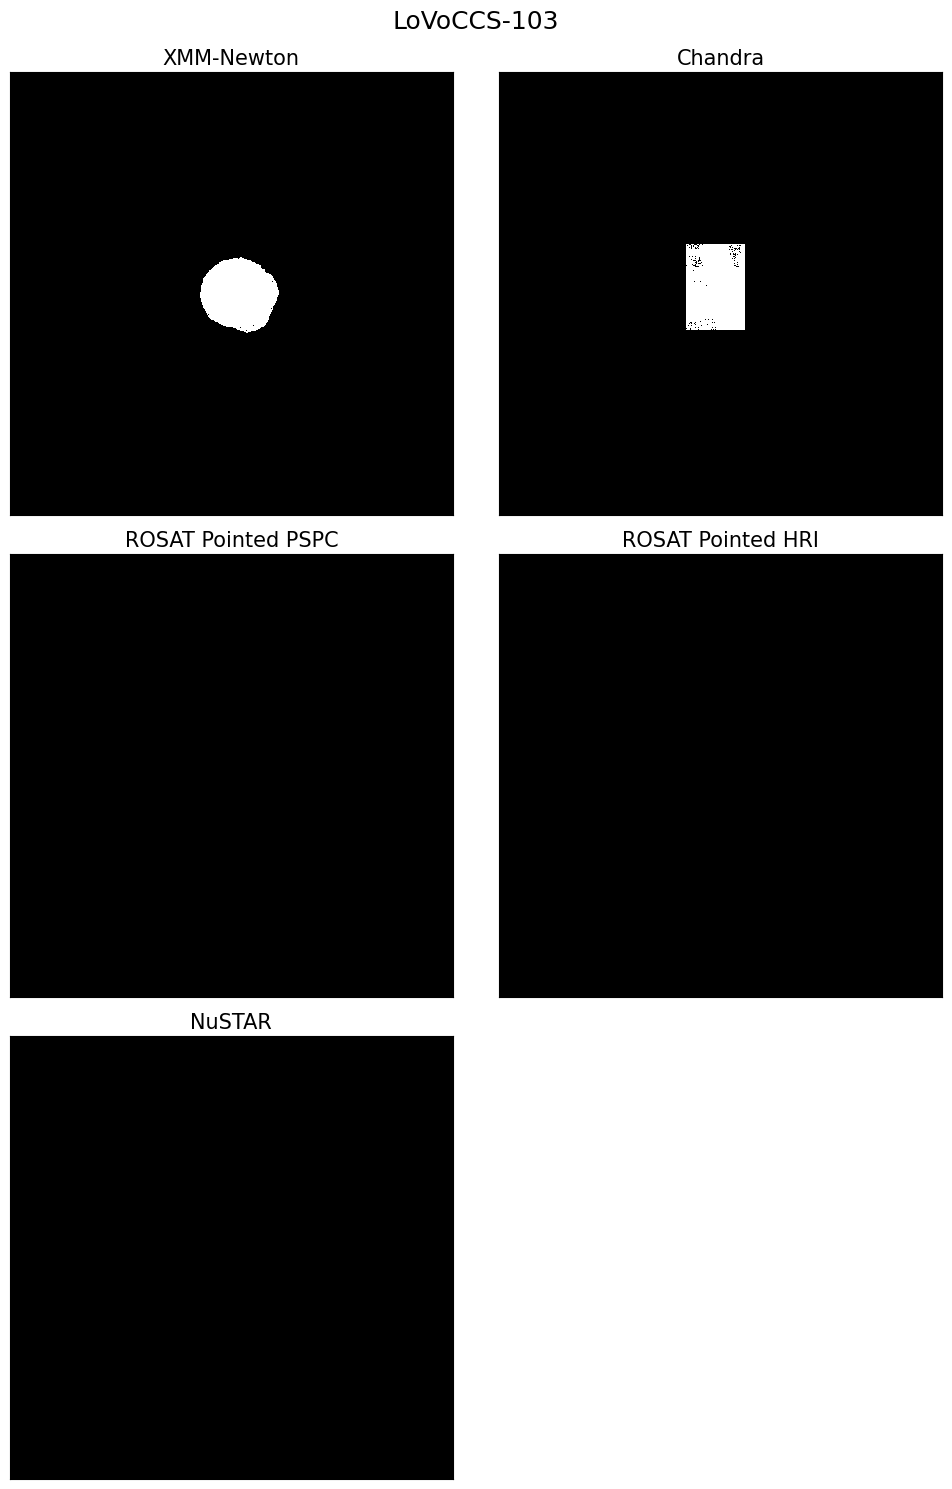

Generating coverage maps:  72%|███████▏  | 104/144 [05:48<02:21,  3.54s/it]

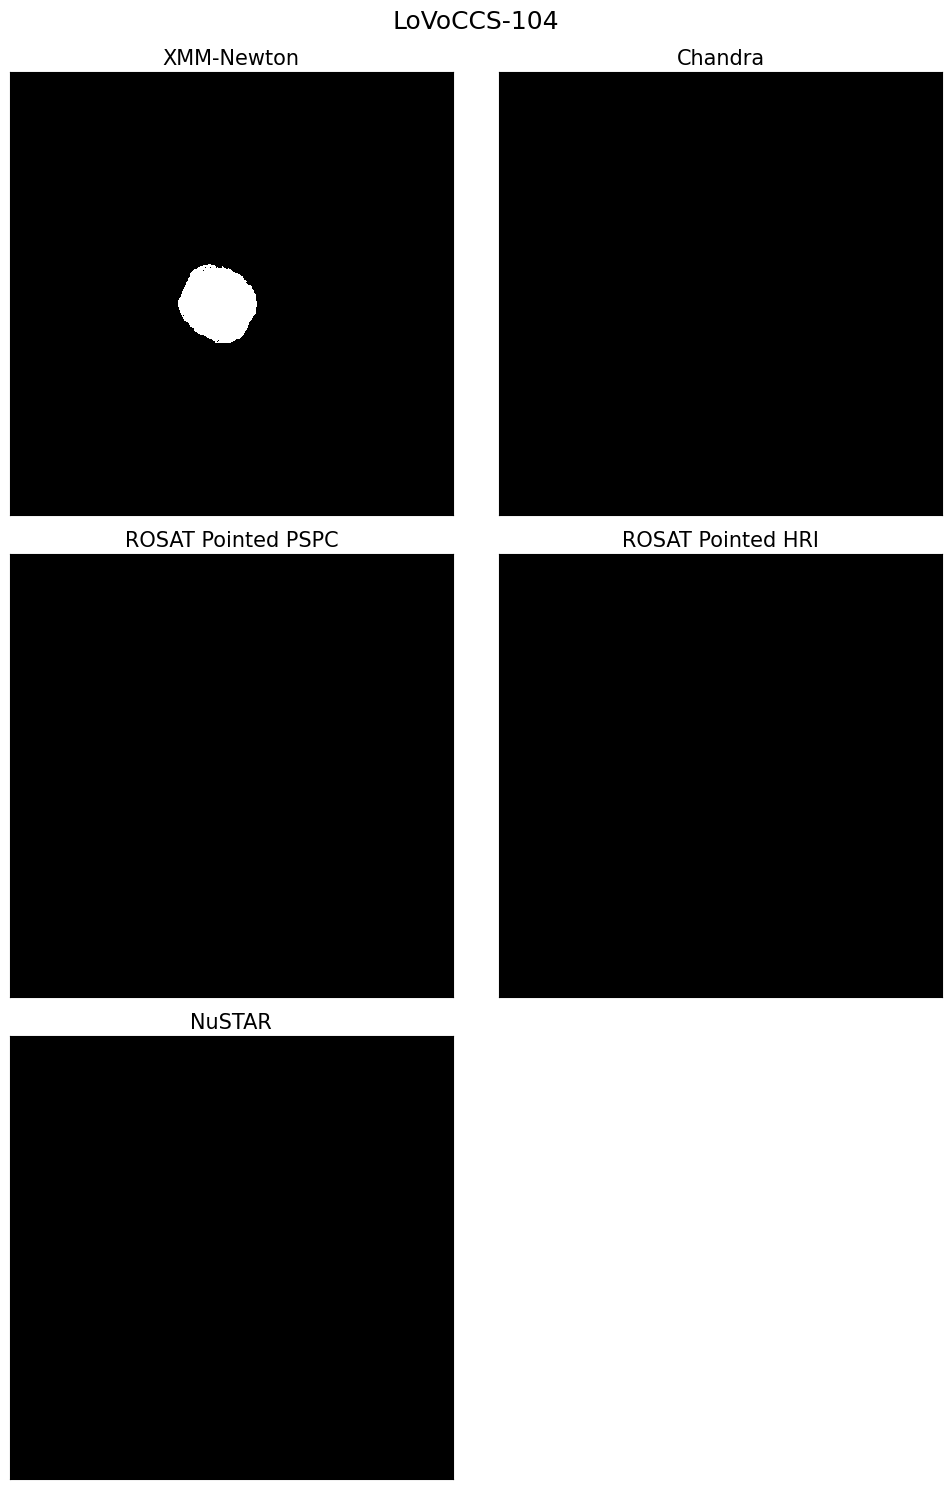

Generating coverage maps:  73%|███████▎  | 105/144 [05:49<01:58,  3.04s/it]

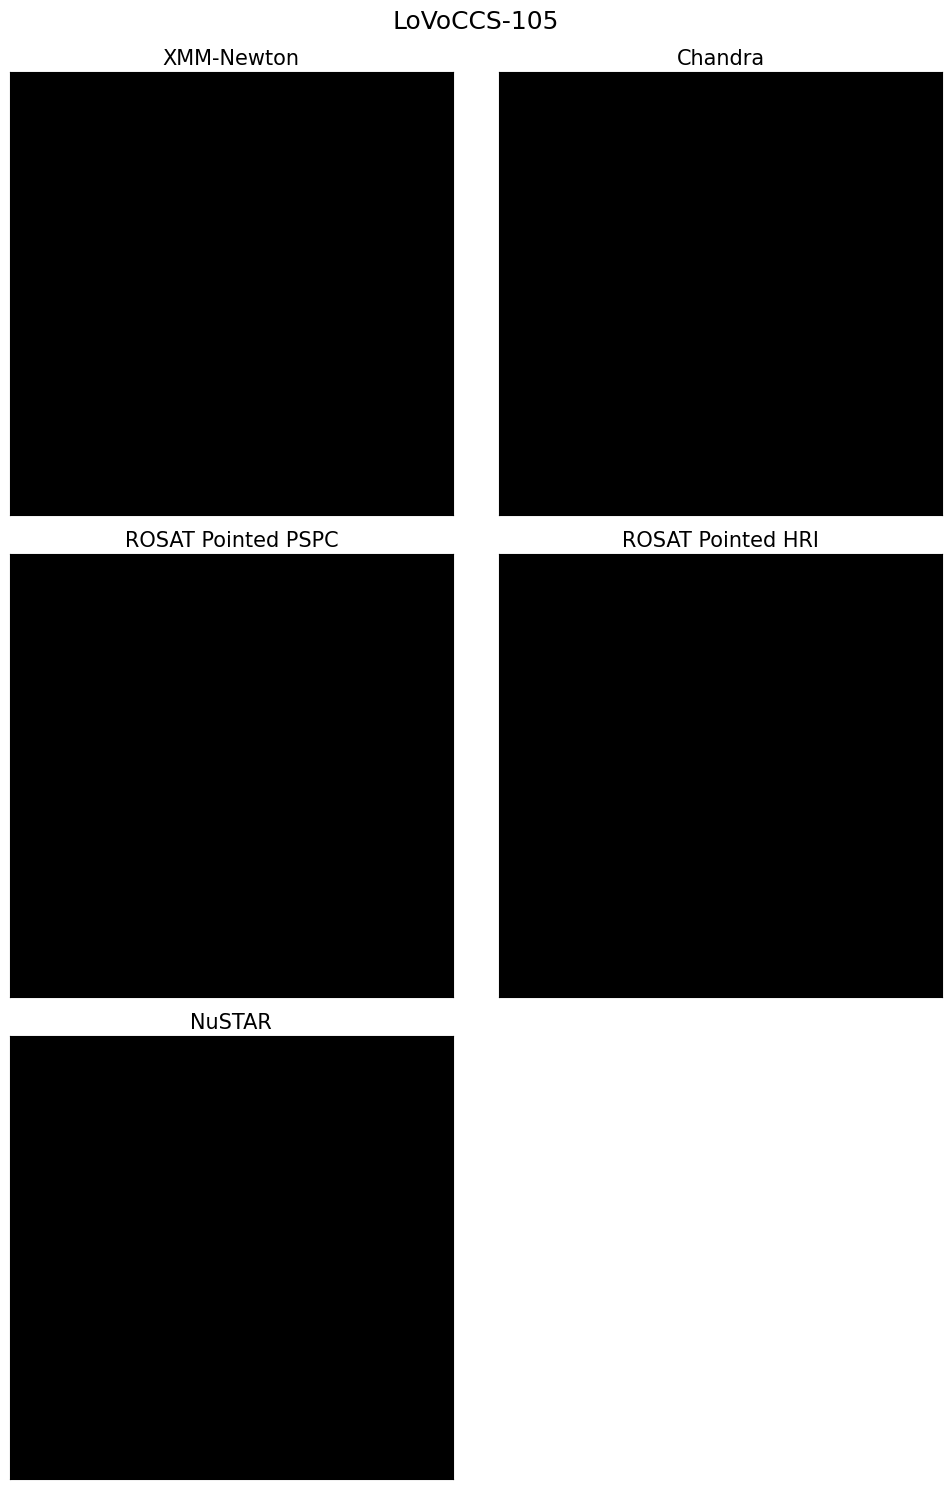

Generating coverage maps:  74%|███████▎  | 106/144 [05:51<01:42,  2.70s/it]

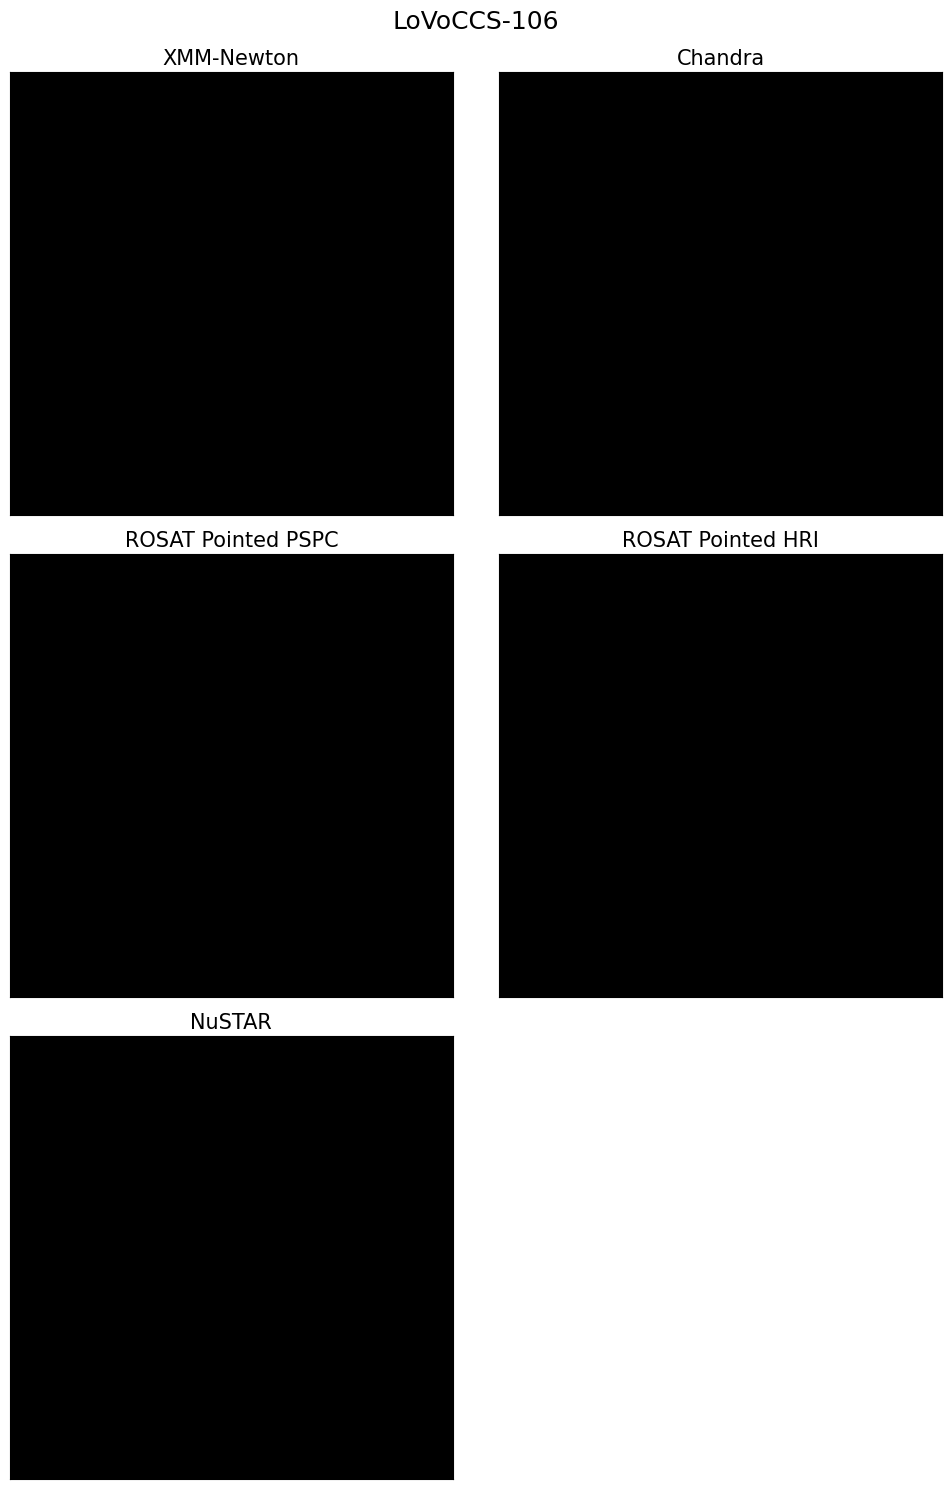

Generating coverage maps:  74%|███████▍  | 107/144 [05:52<01:21,  2.19s/it]

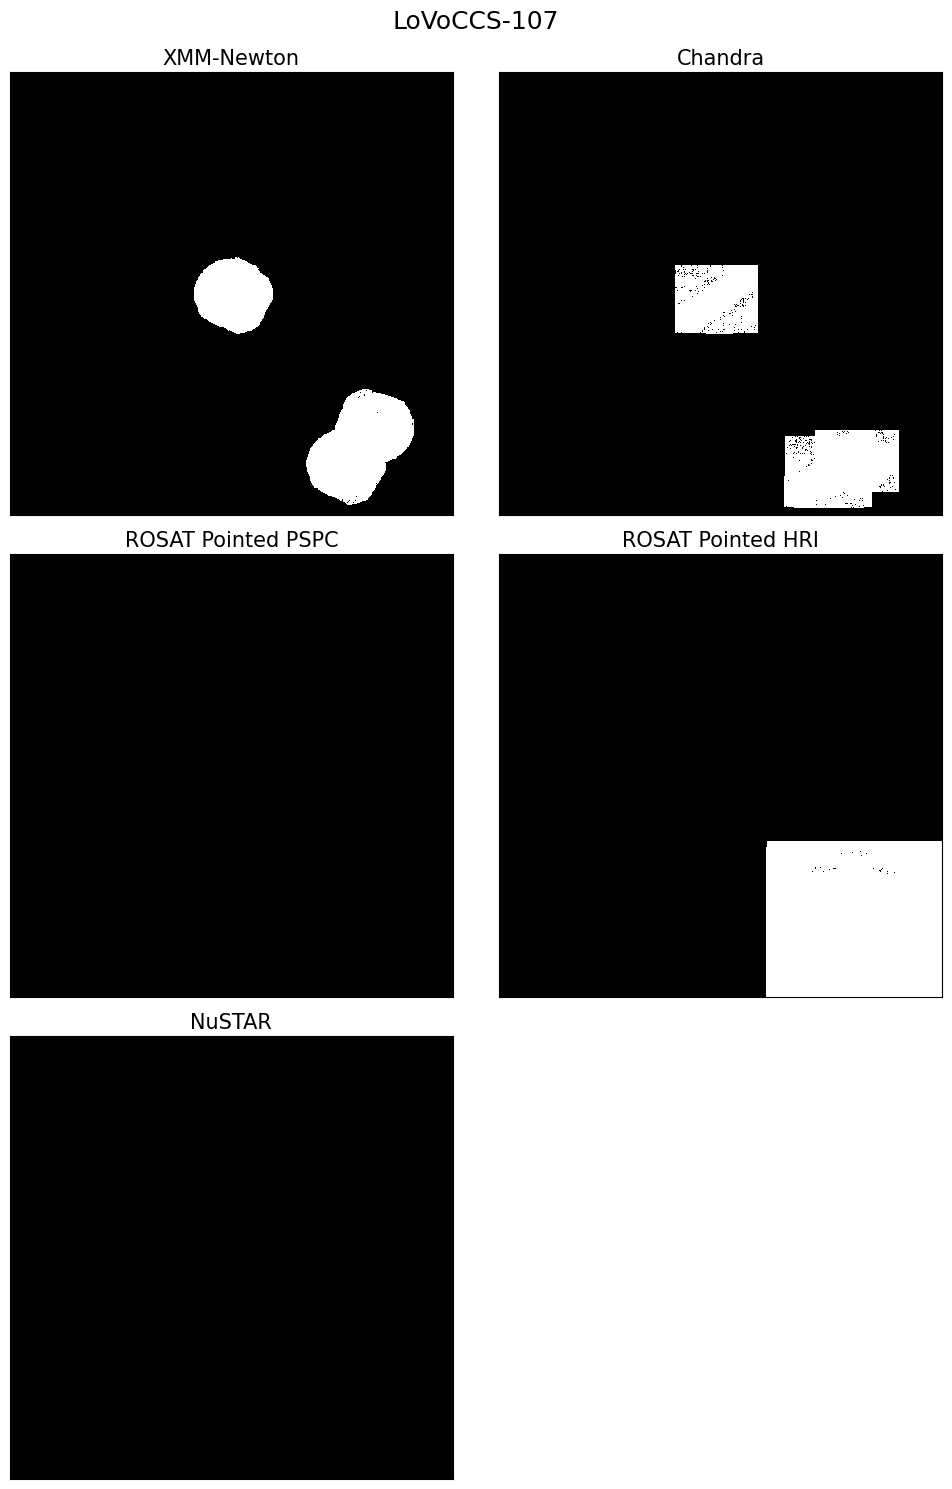

Generating coverage maps:  75%|███████▌  | 108/144 [05:54<01:17,  2.16s/it]

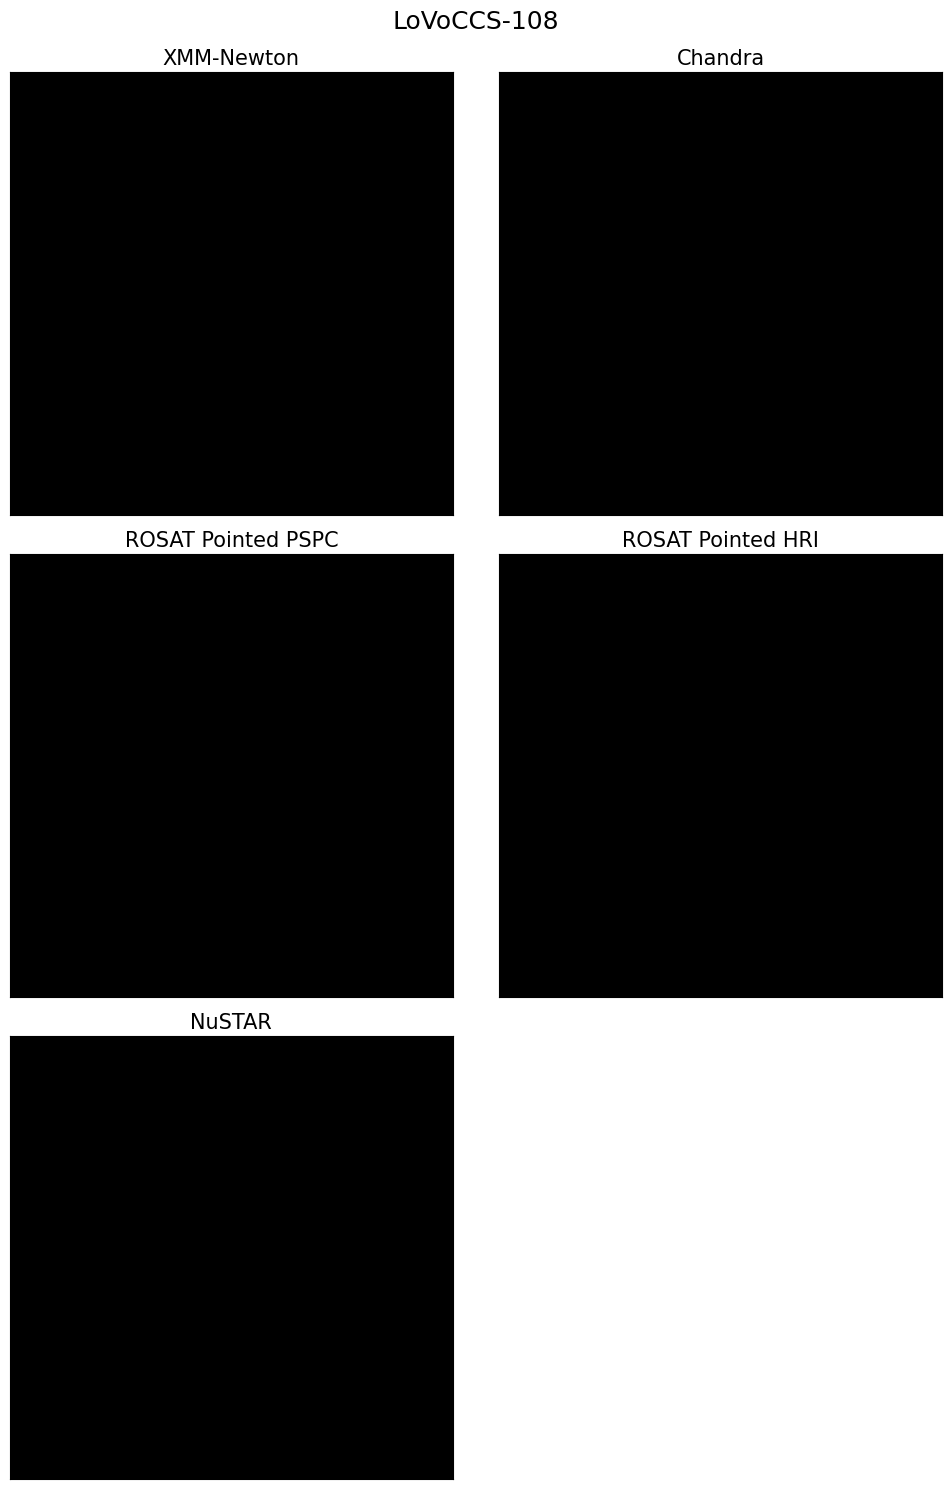

Generating coverage maps:  76%|███████▌  | 109/144 [05:55<01:03,  1.82s/it]

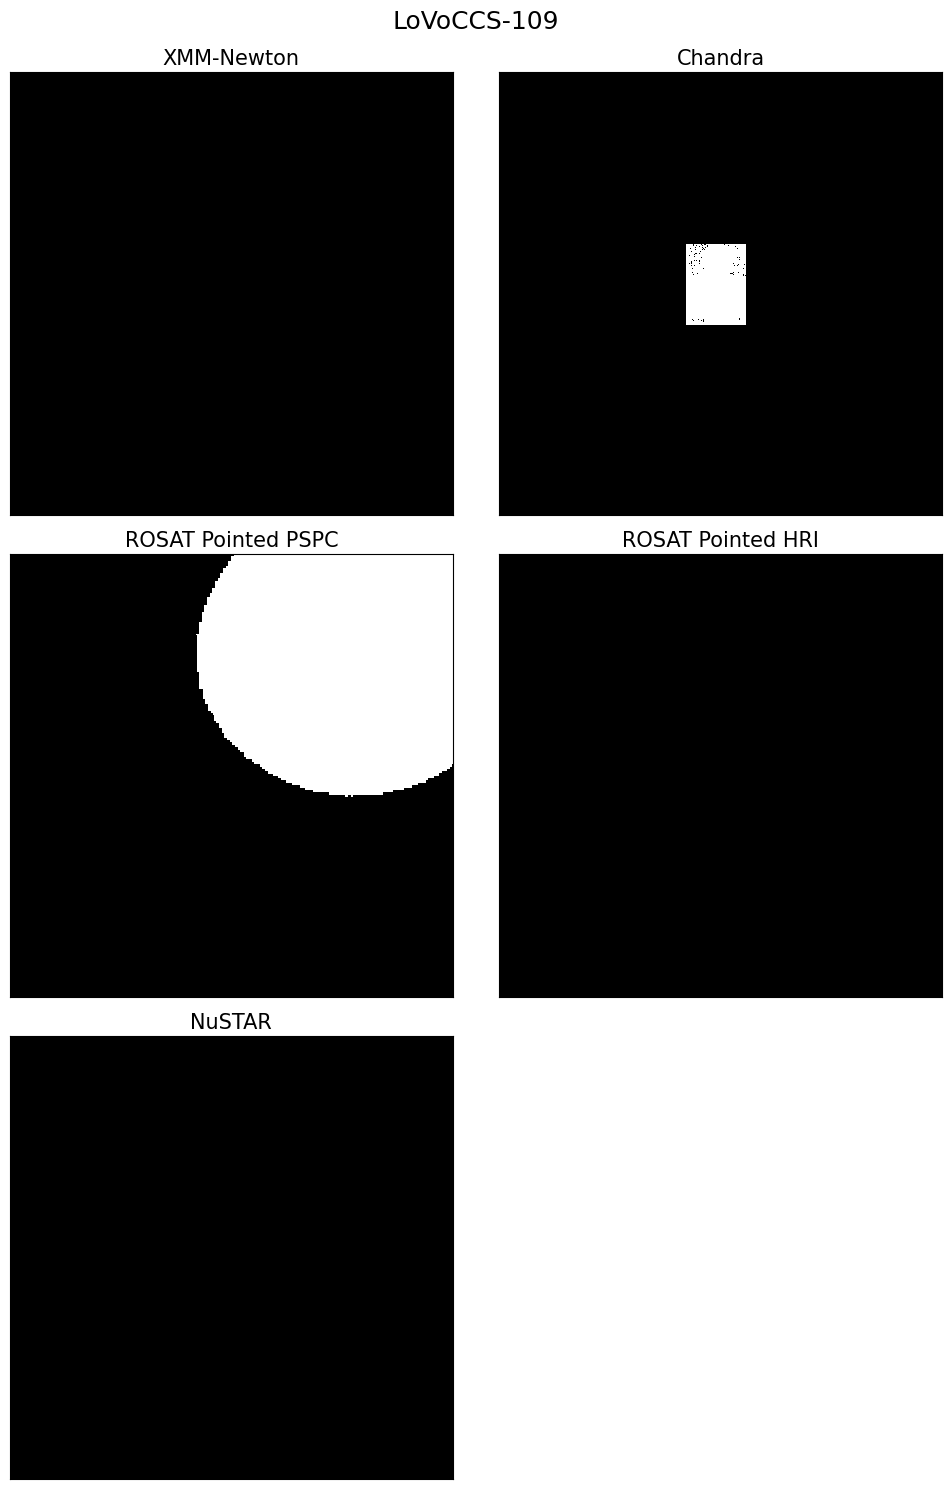

Generating coverage maps:  76%|███████▋  | 110/144 [05:57<00:57,  1.68s/it]

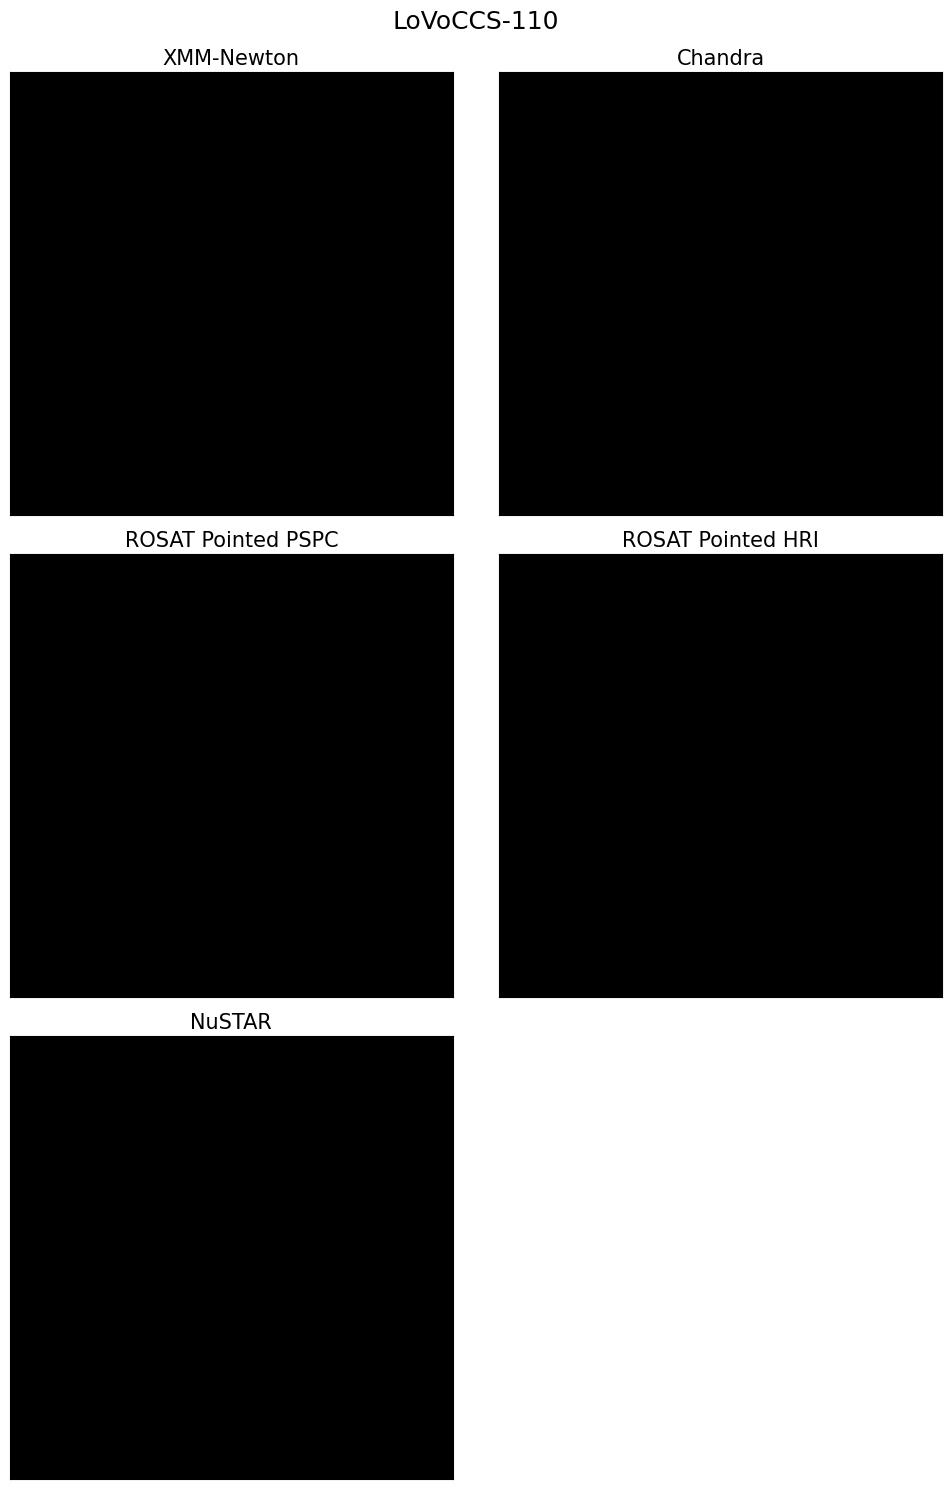

Generating coverage maps:  77%|███████▋  | 111/144 [05:58<00:51,  1.56s/it]

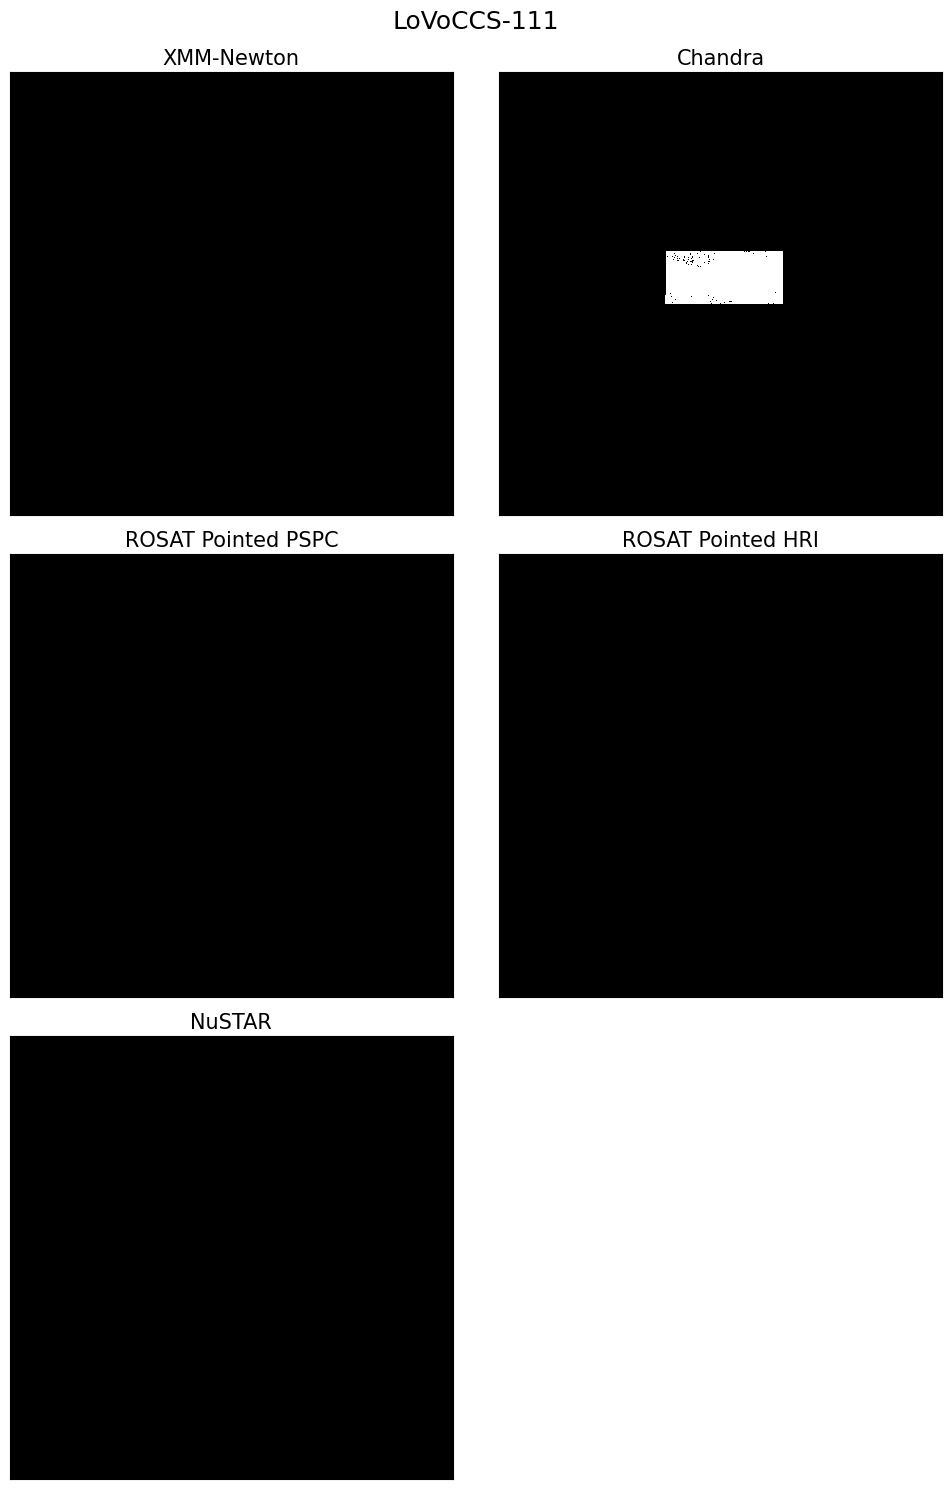

Generating coverage maps:  78%|███████▊  | 112/144 [05:59<00:46,  1.46s/it]

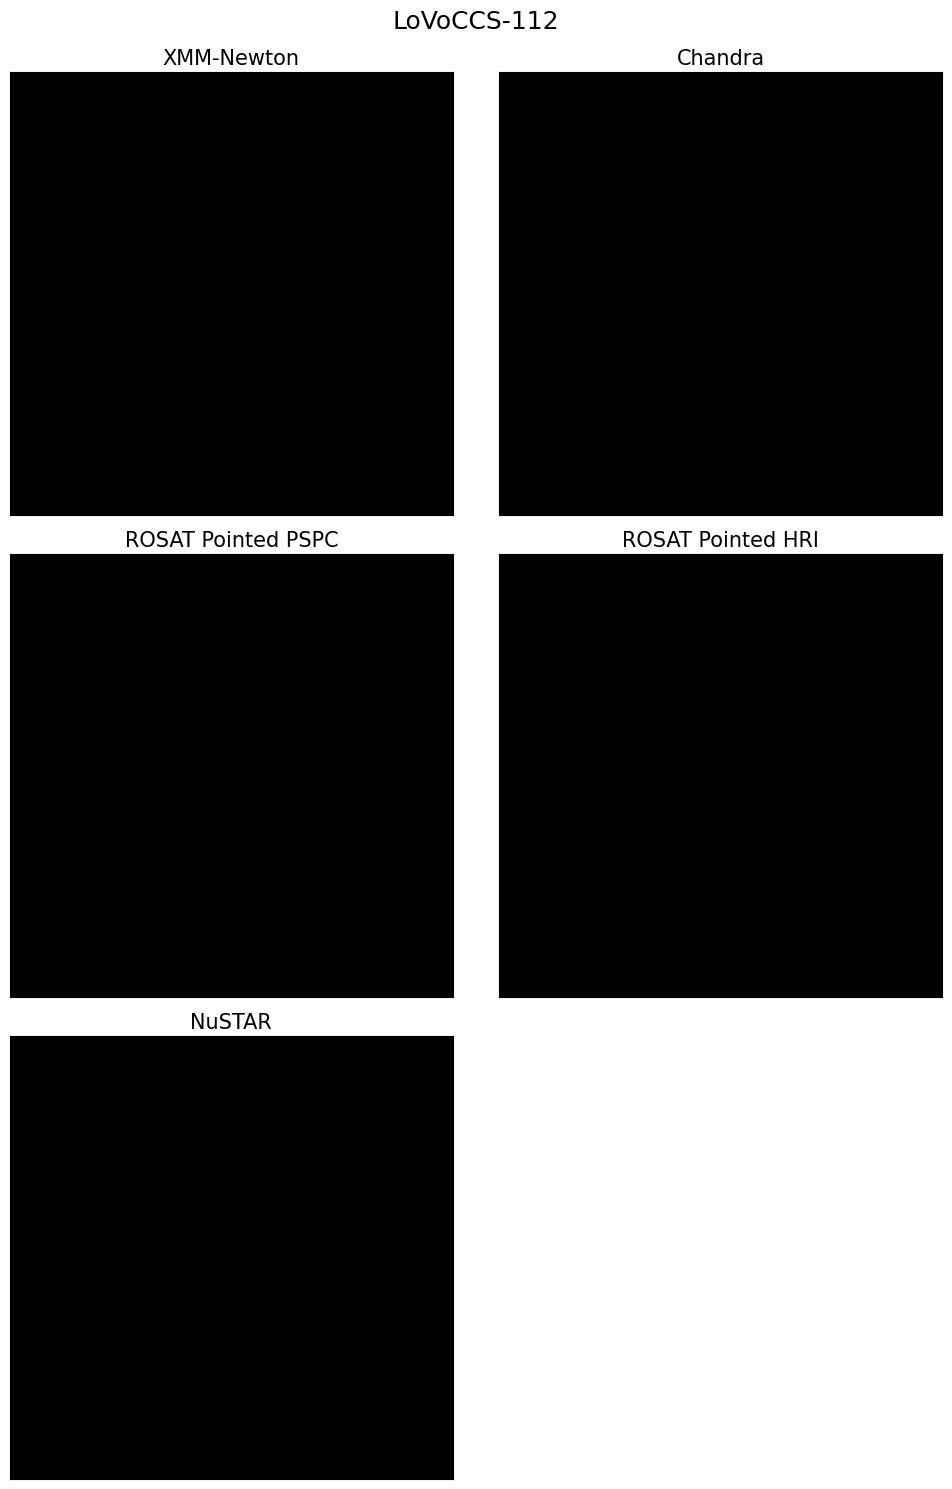

Generating coverage maps:  78%|███████▊  | 113/144 [06:00<00:41,  1.33s/it]

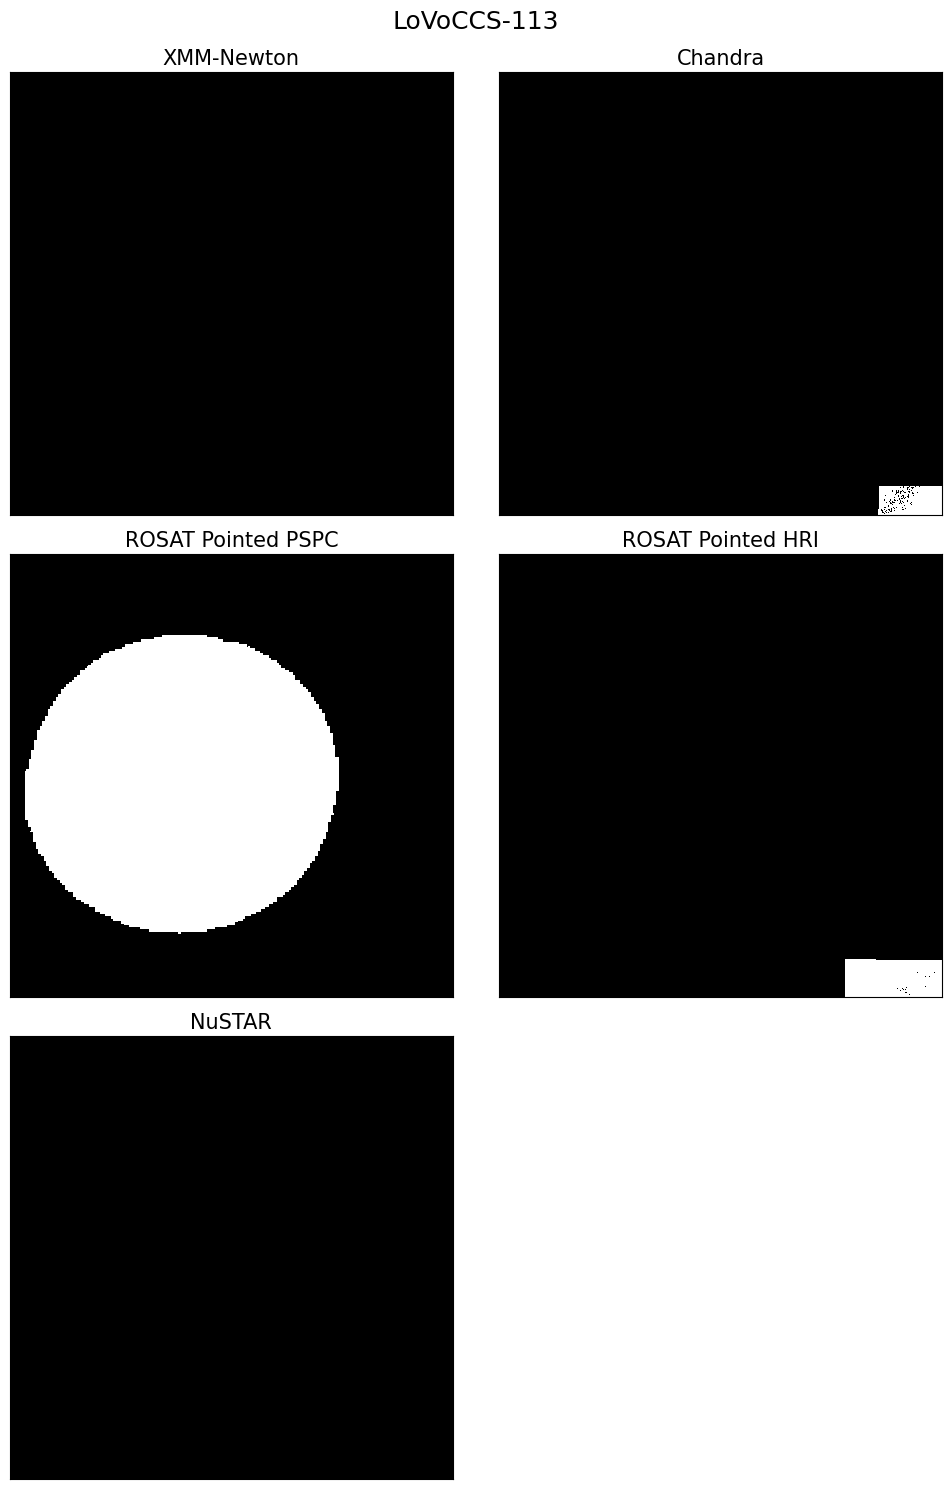

Generating coverage maps:  79%|███████▉  | 114/144 [06:03<00:47,  1.58s/it]

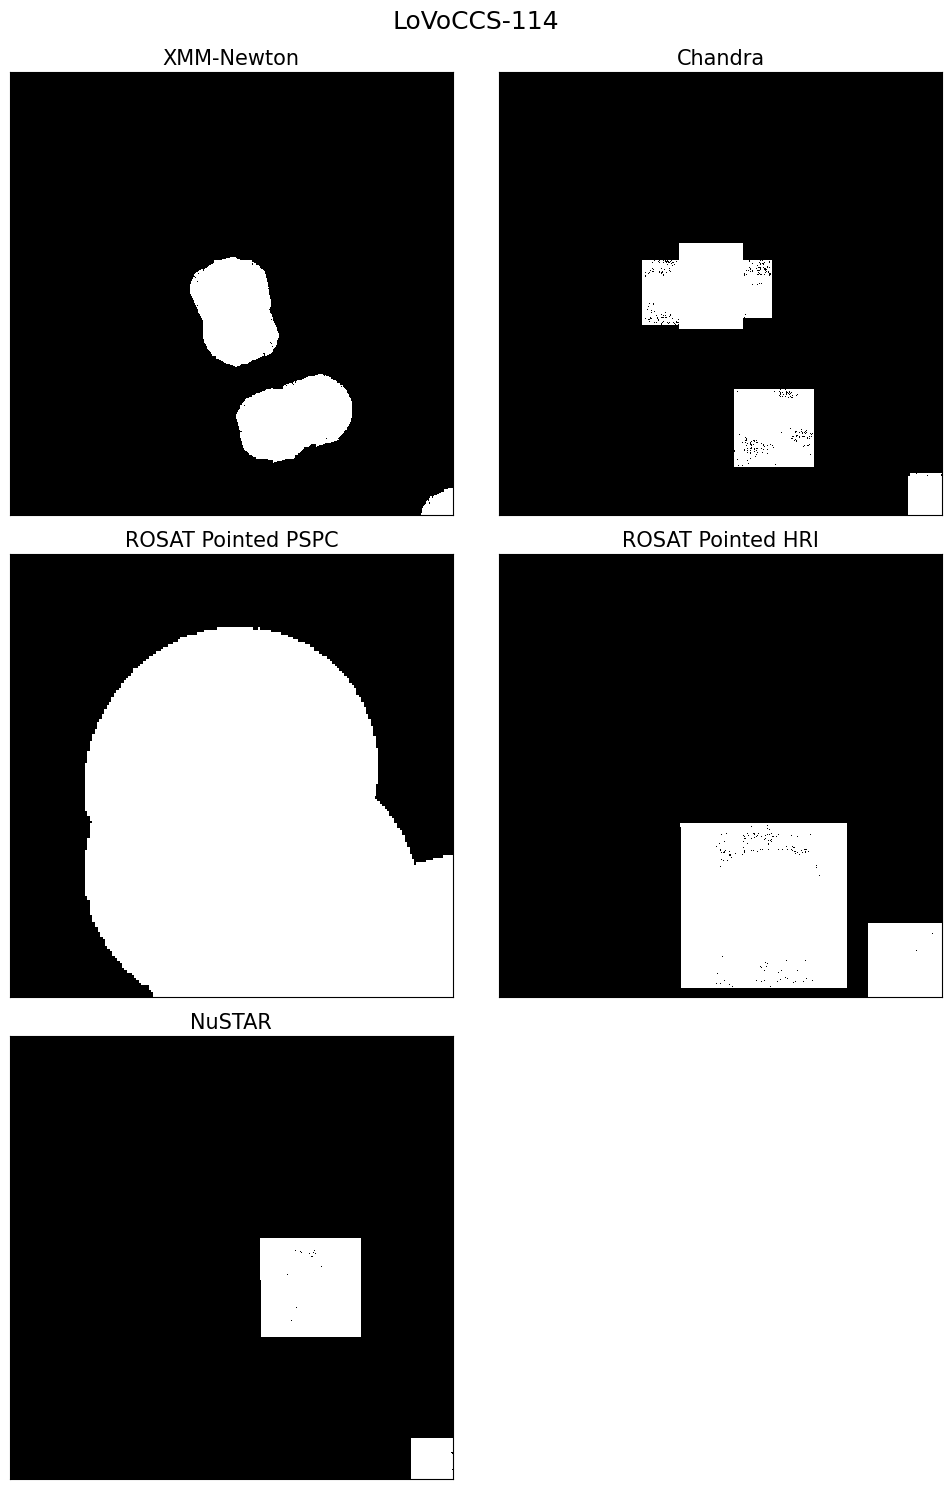

Generating coverage maps:  80%|███████▉  | 115/144 [06:12<01:56,  4.01s/it]

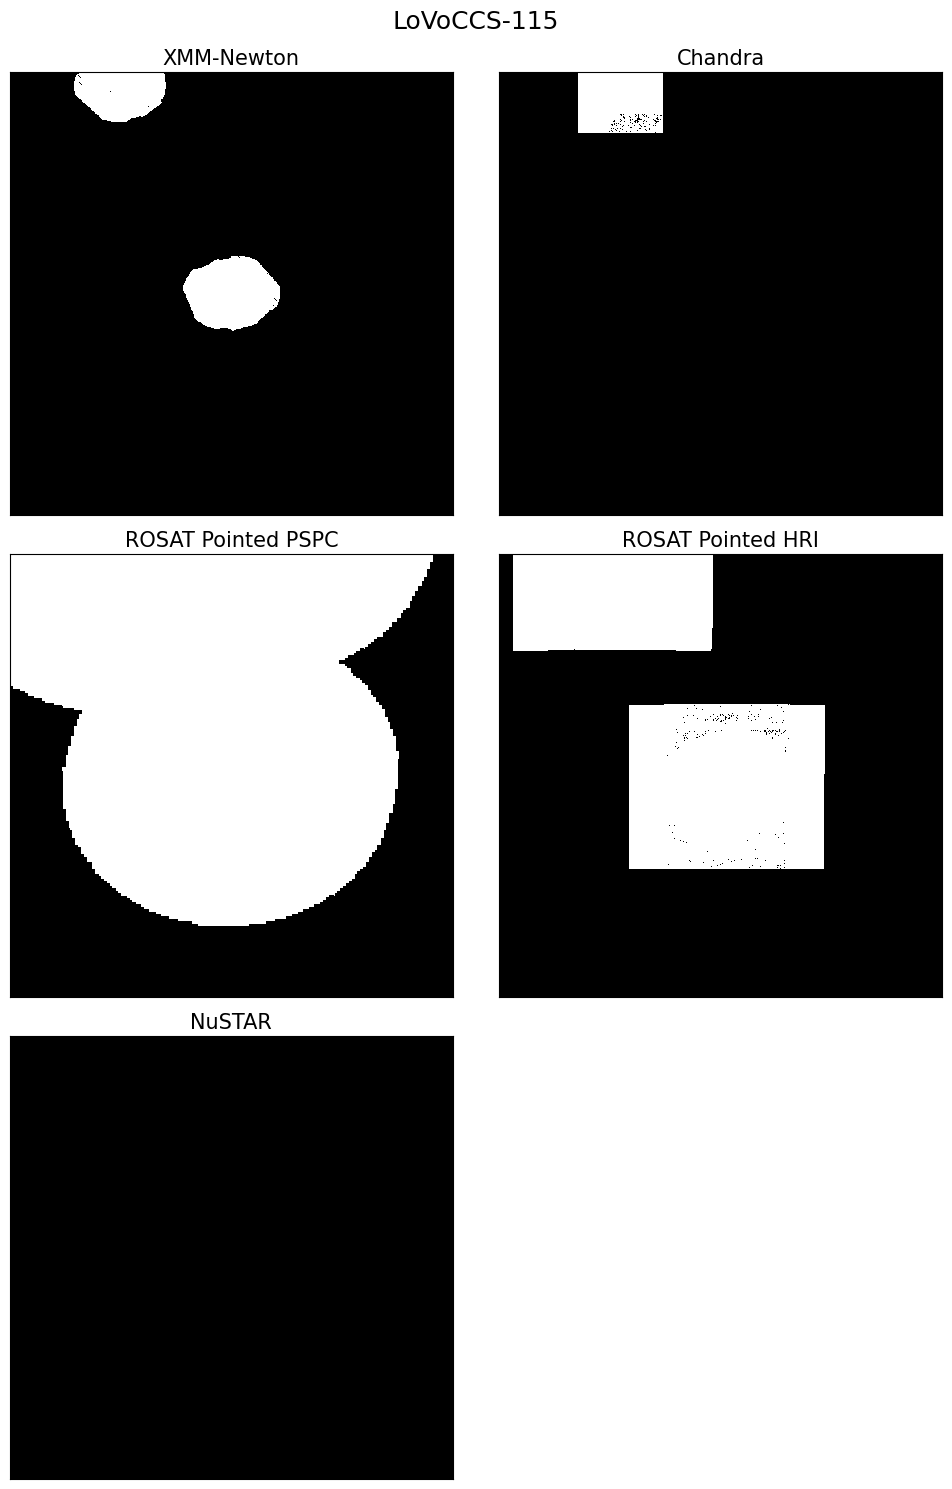

Generating coverage maps:  81%|████████  | 116/144 [06:15<01:40,  3.57s/it]

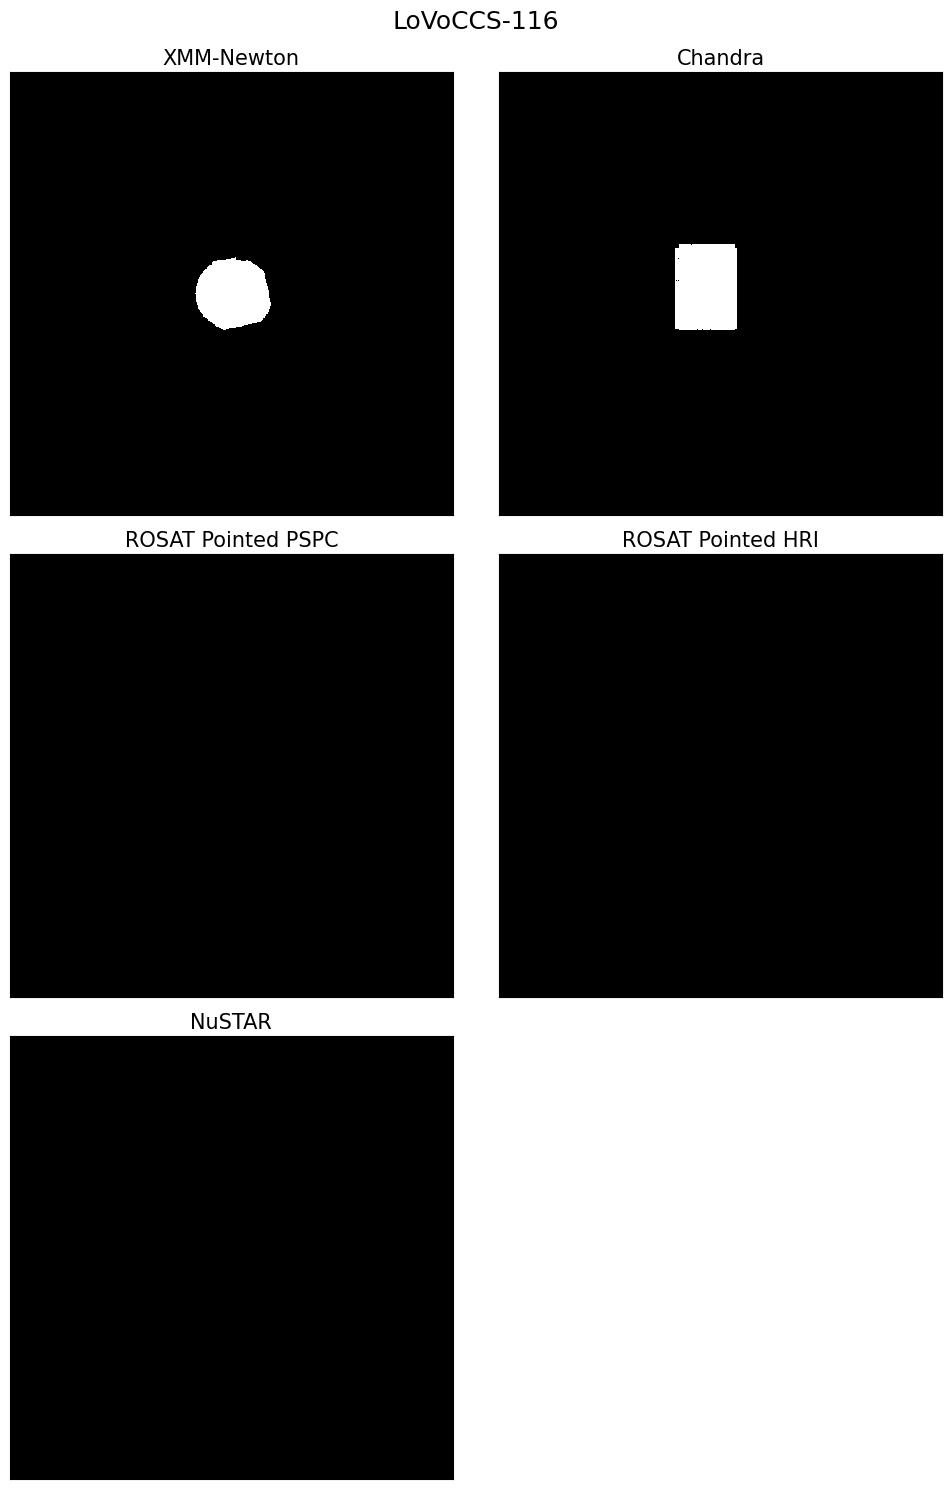

Generating coverage maps:  81%|████████▏ | 117/144 [06:16<01:21,  3.01s/it]

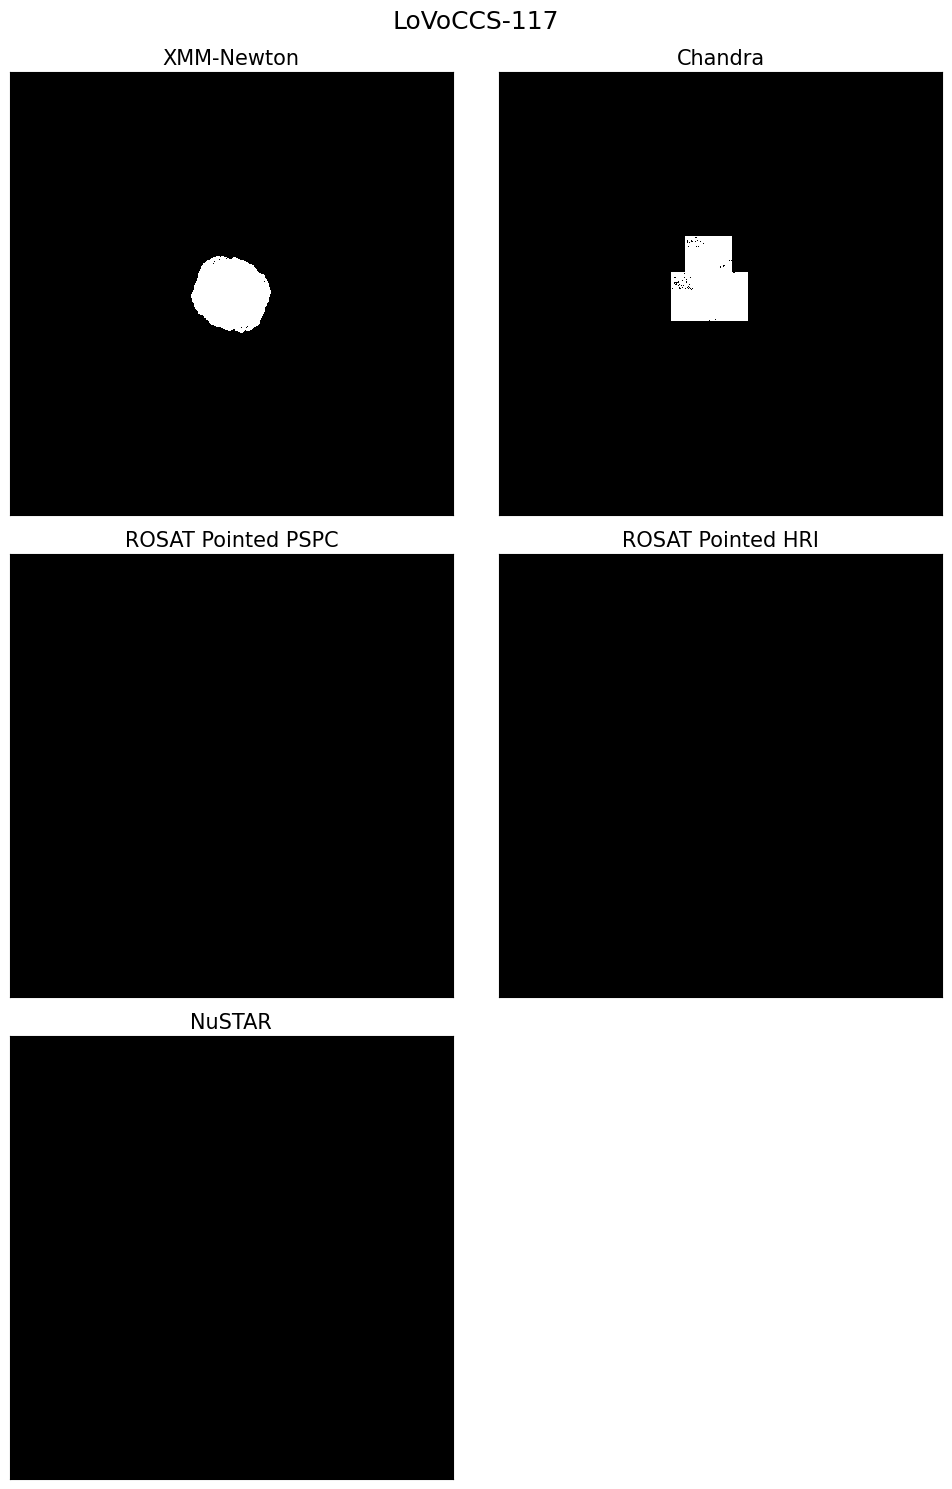

Generating coverage maps:  82%|████████▏ | 118/144 [06:19<01:15,  2.91s/it]

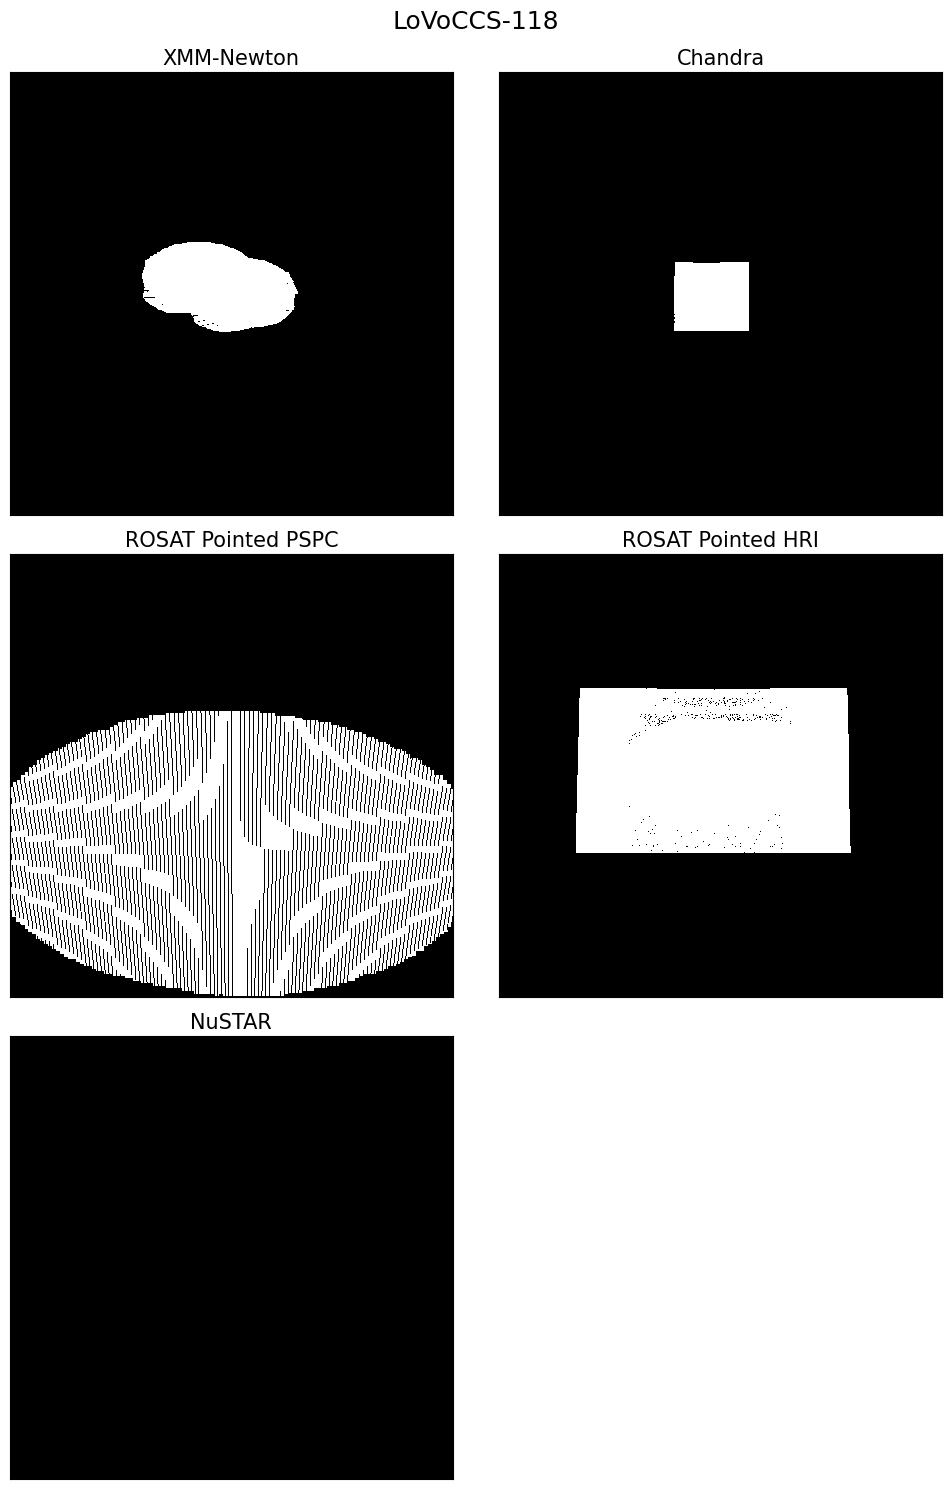

Generating coverage maps:  83%|████████▎ | 119/144 [06:23<01:17,  3.10s/it]

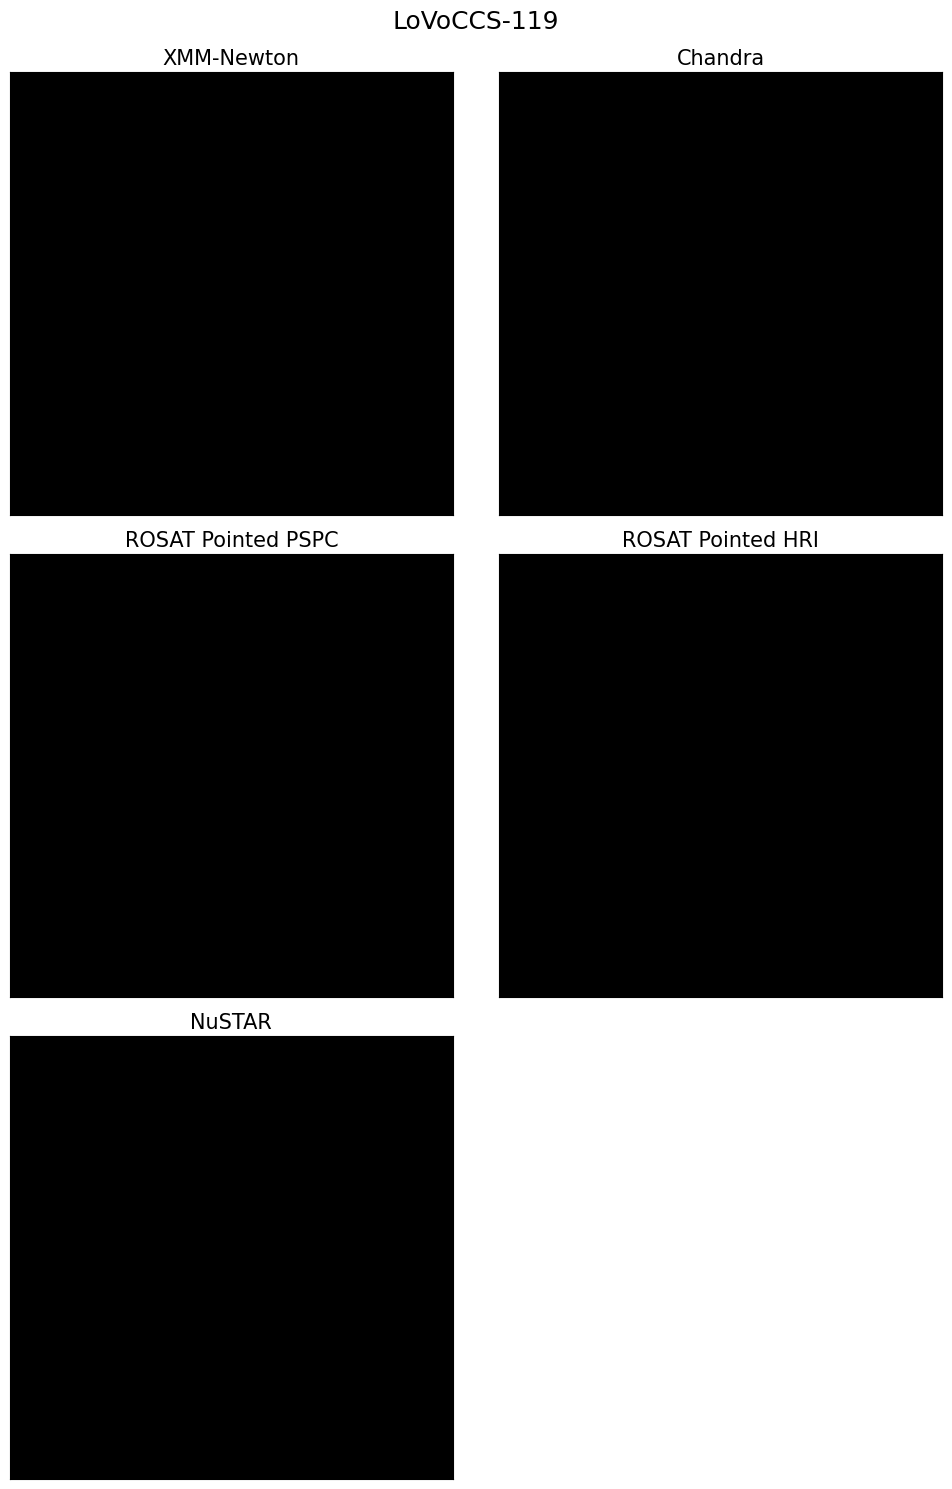

Generating coverage maps:  83%|████████▎ | 120/144 [06:24<00:59,  2.47s/it]

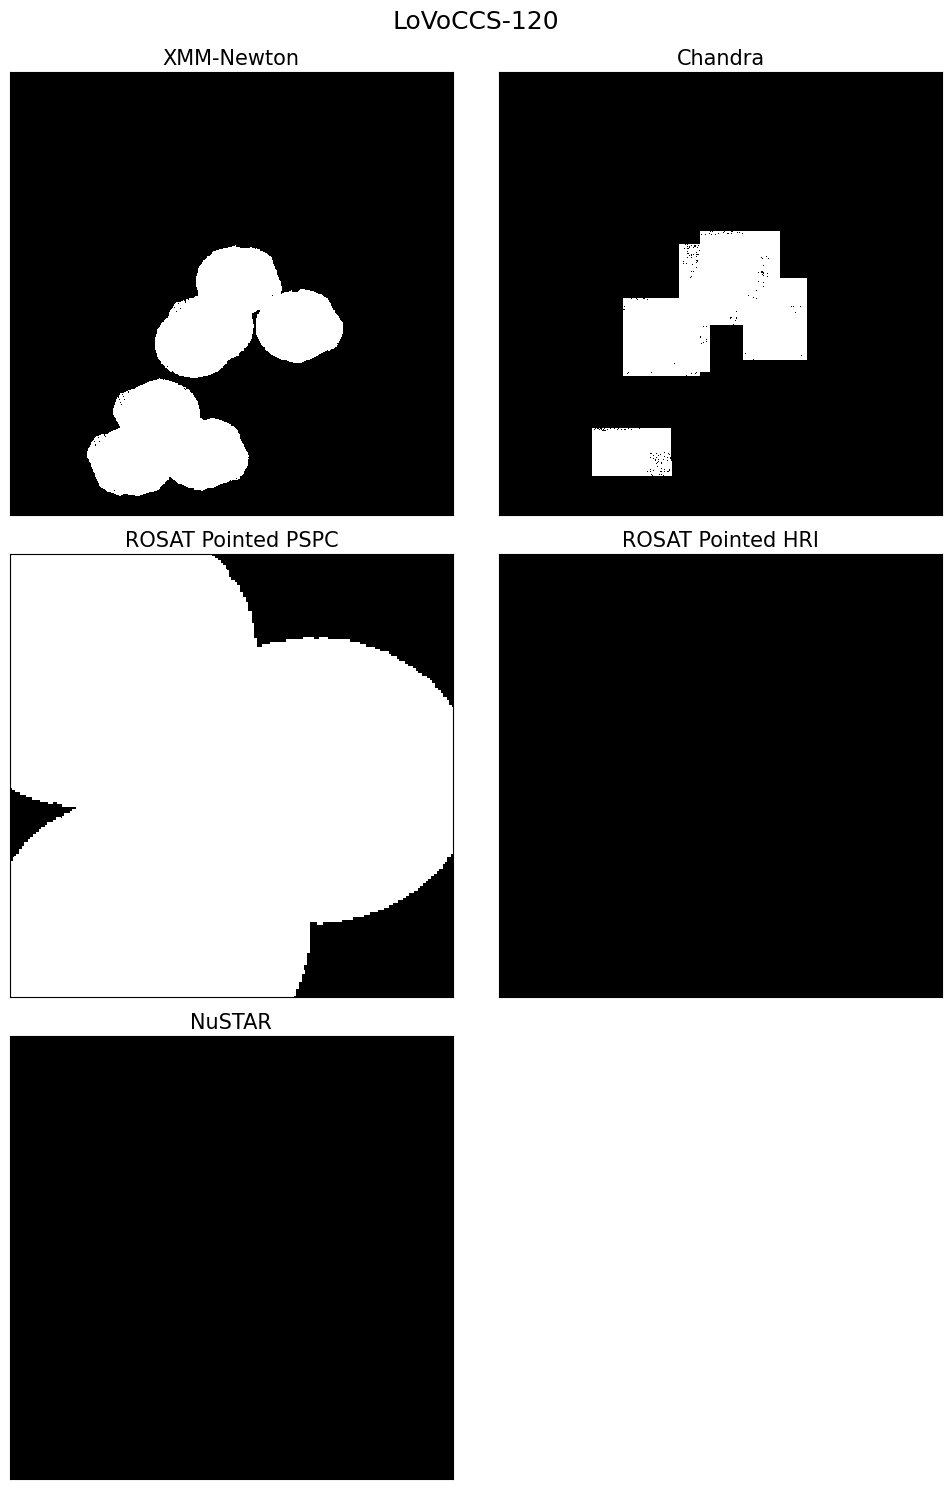

Generating coverage maps:  84%|████████▍ | 121/144 [06:27<01:02,  2.72s/it]

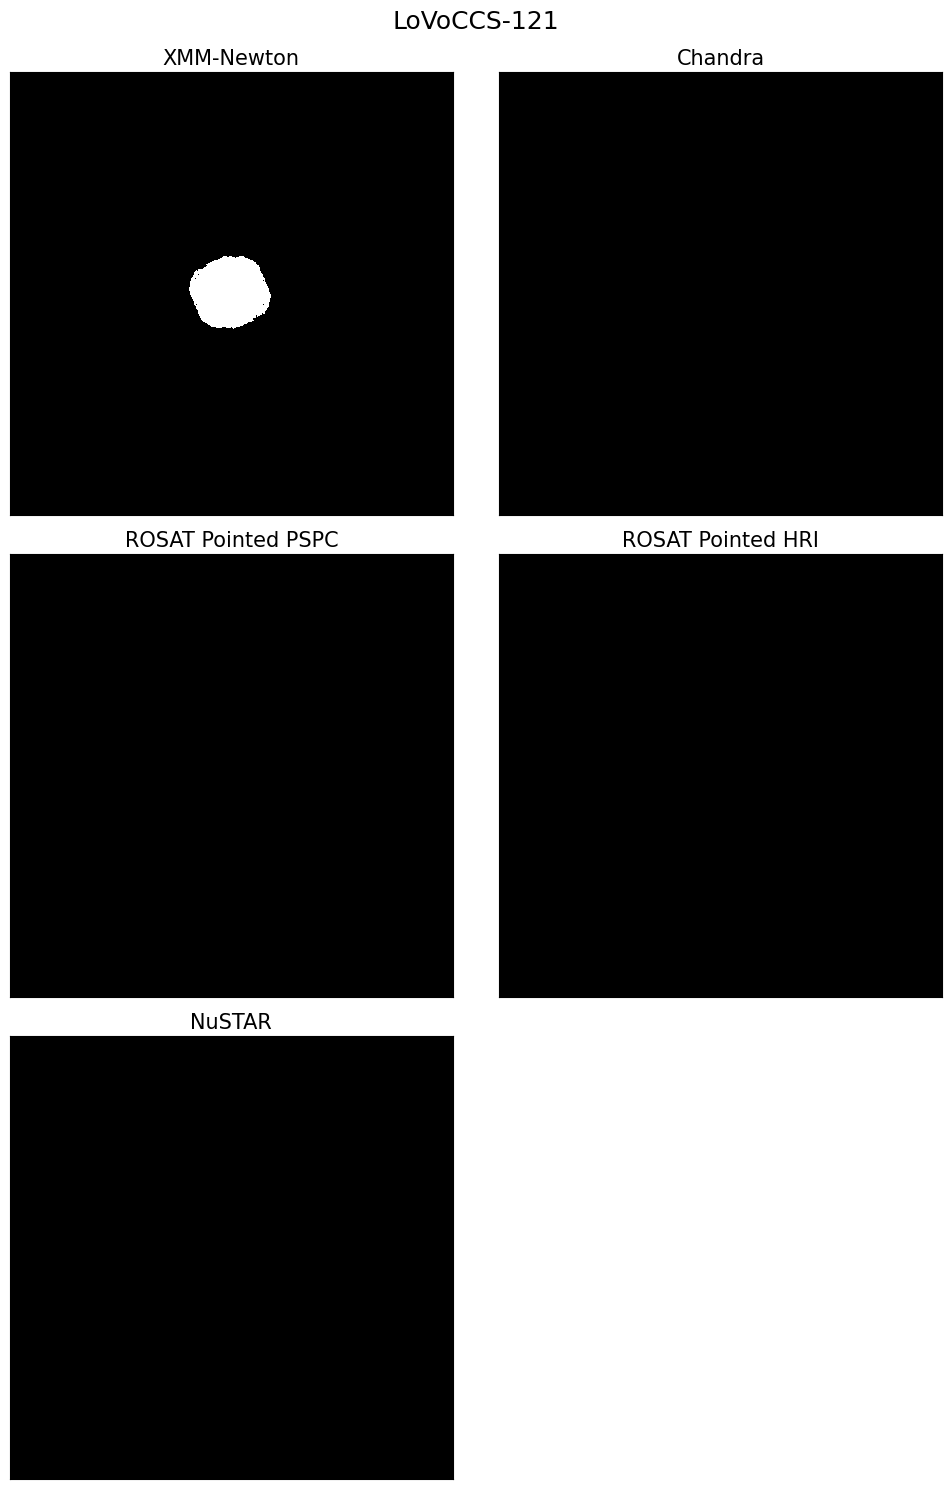

Generating coverage maps:  85%|████████▍ | 122/144 [06:28<00:50,  2.31s/it]

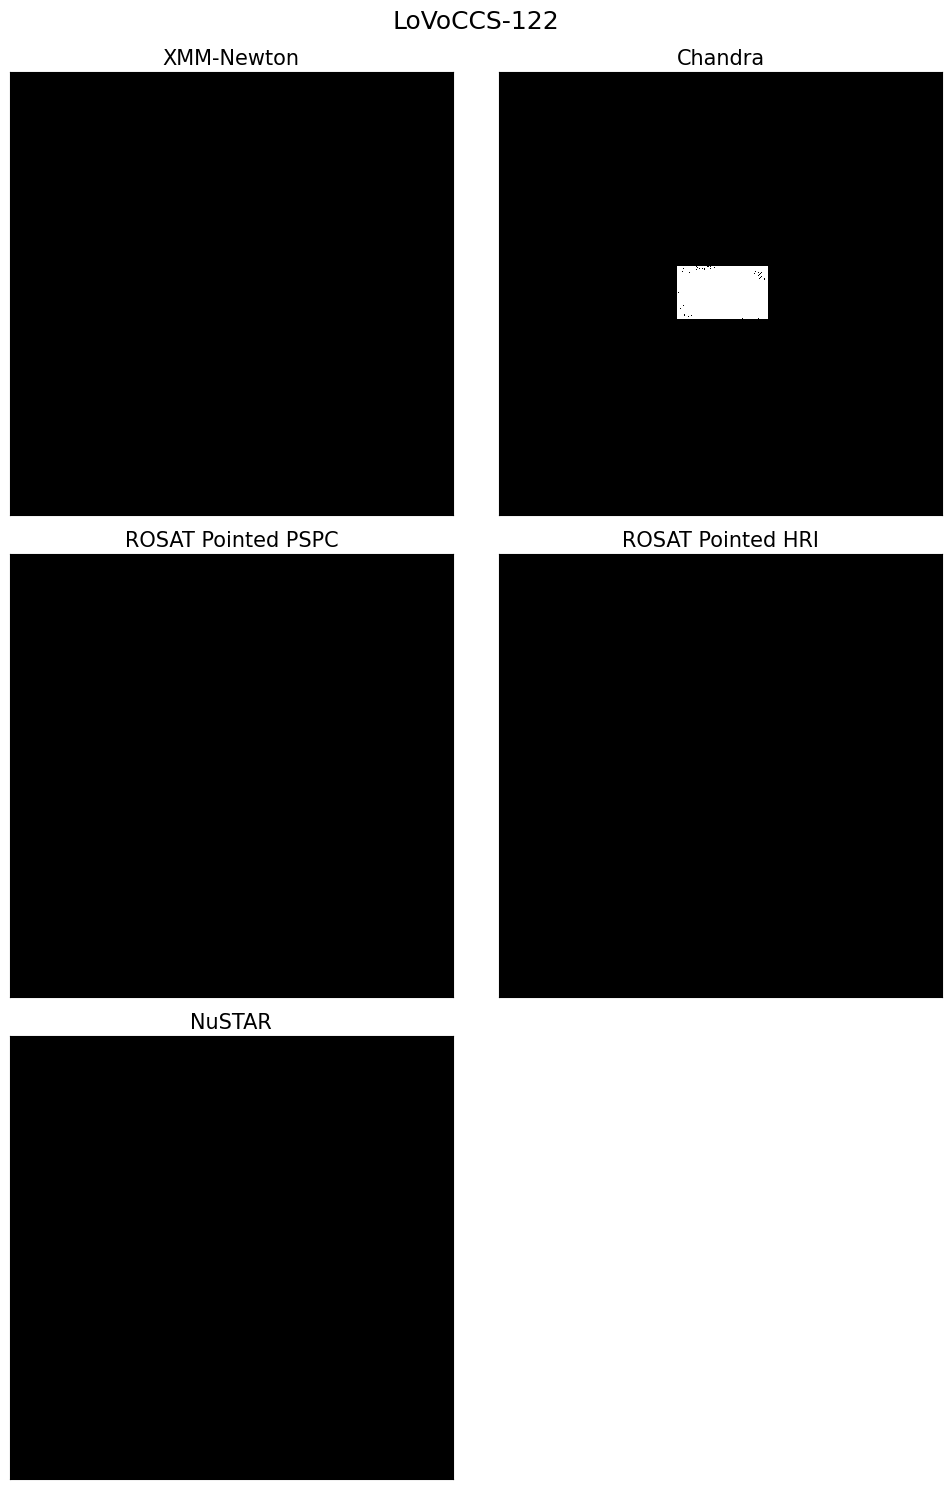

Generating coverage maps:  85%|████████▌ | 123/144 [06:29<00:40,  1.94s/it]

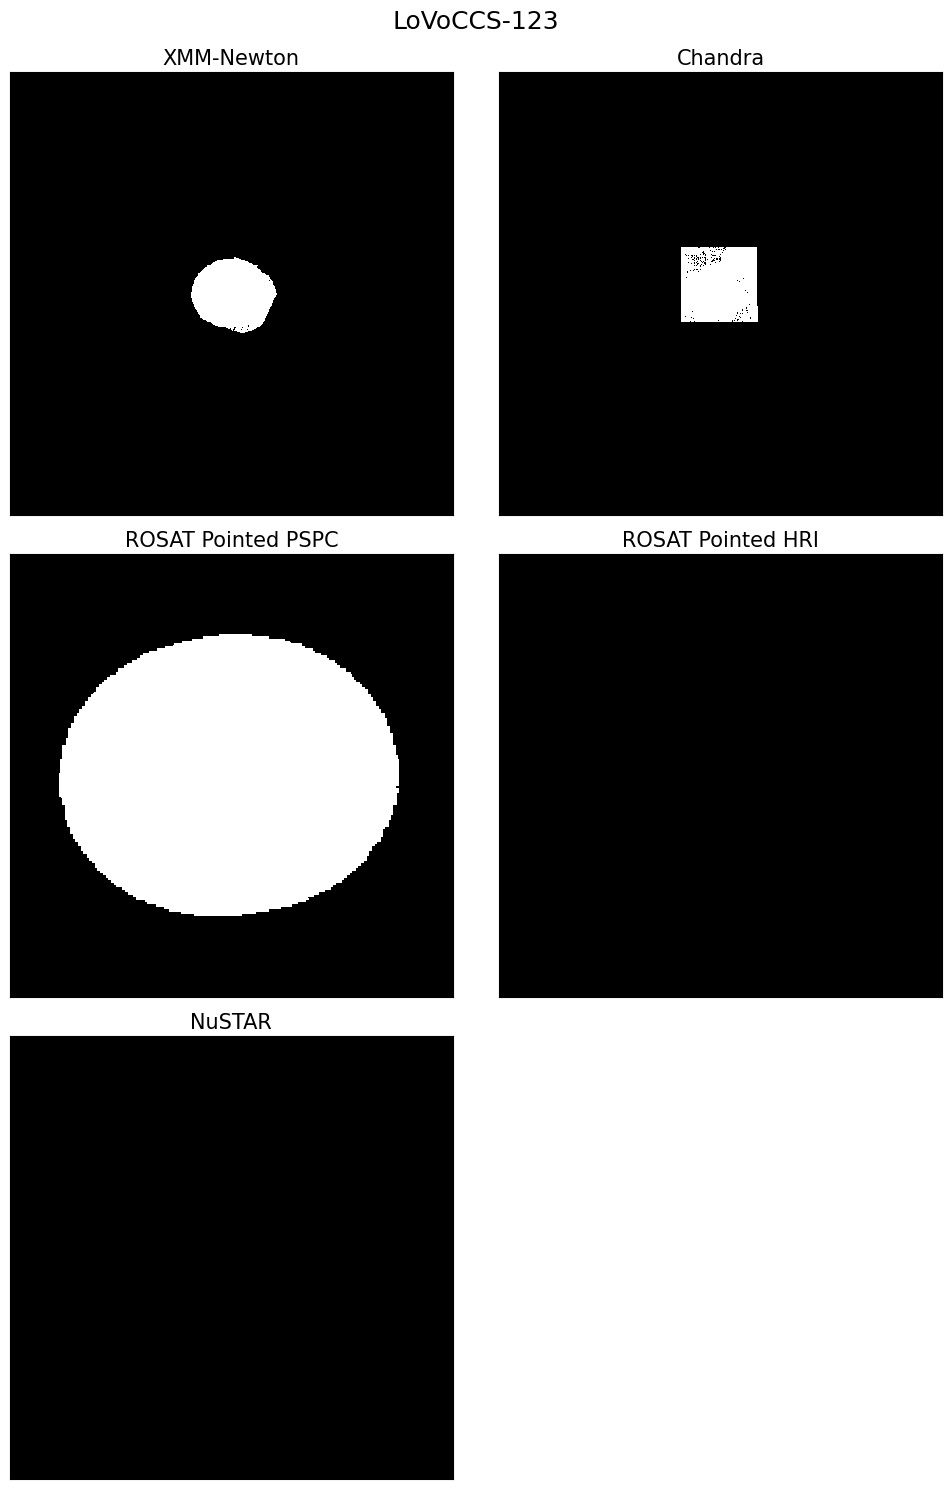

Generating coverage maps:  86%|████████▌ | 124/144 [06:31<00:35,  1.76s/it]

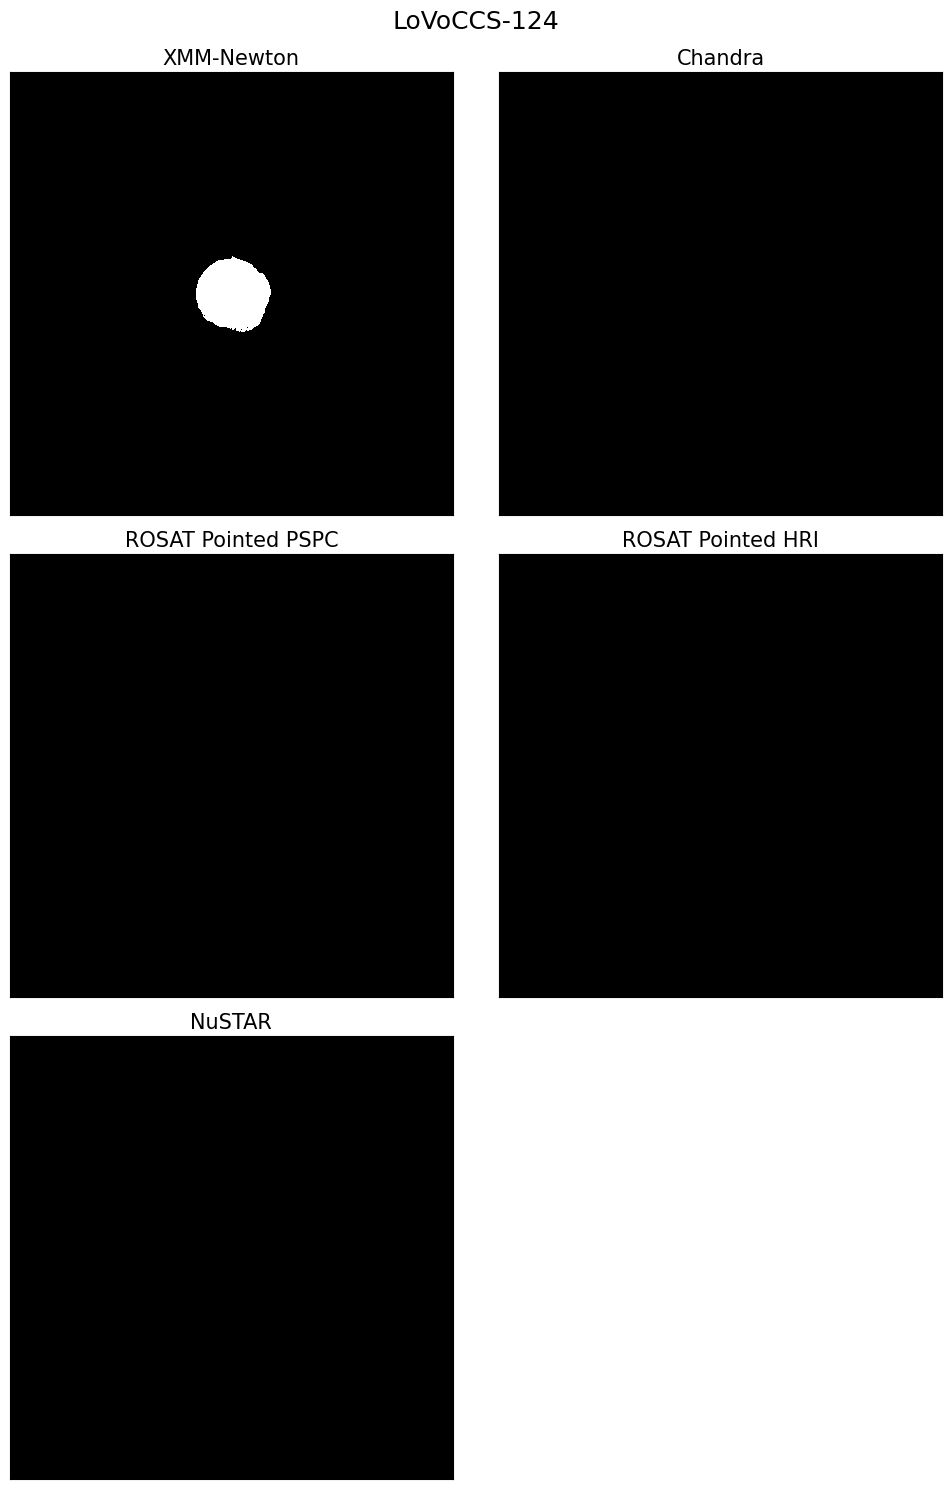

Generating coverage maps:  87%|████████▋ | 125/144 [06:32<00:32,  1.70s/it]

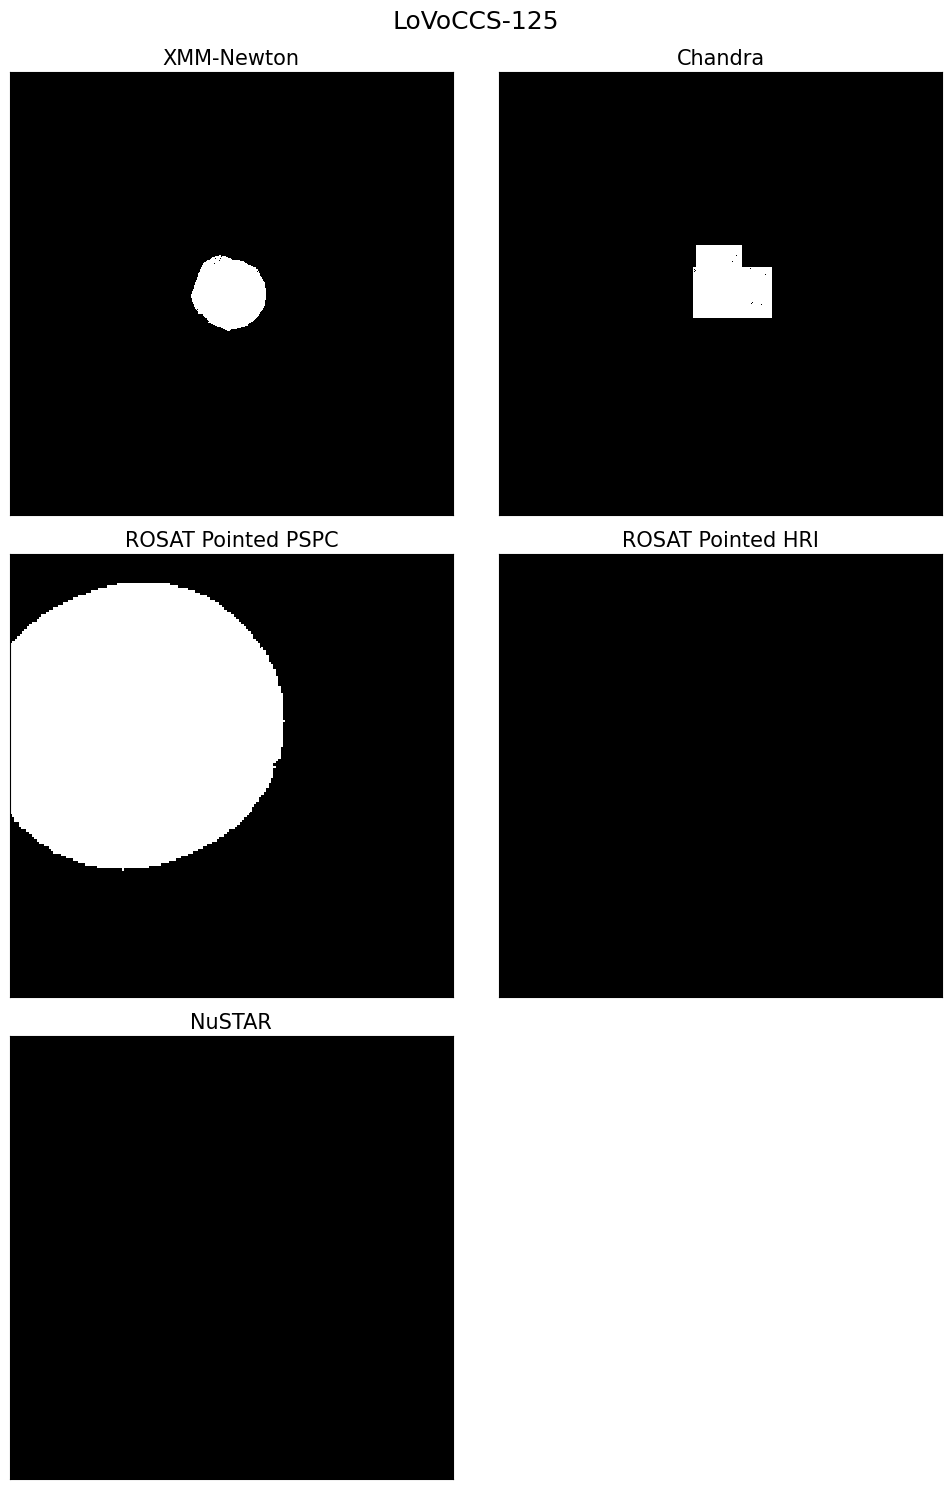

Generating coverage maps:  88%|████████▊ | 126/144 [06:34<00:32,  1.82s/it]

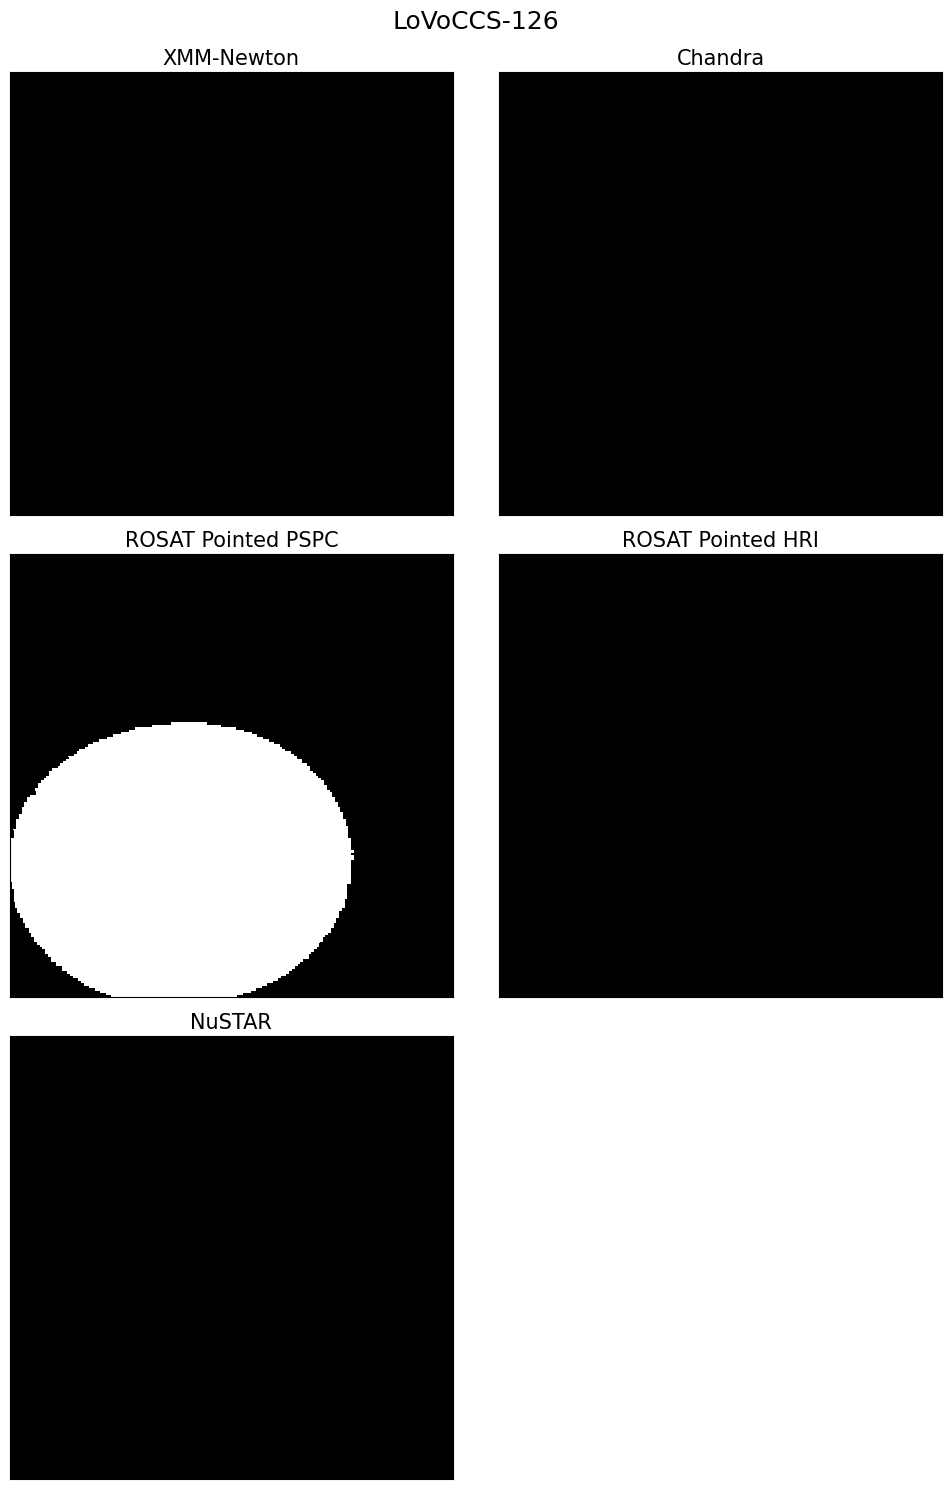

Generating coverage maps:  88%|████████▊ | 127/144 [06:36<00:27,  1.64s/it]

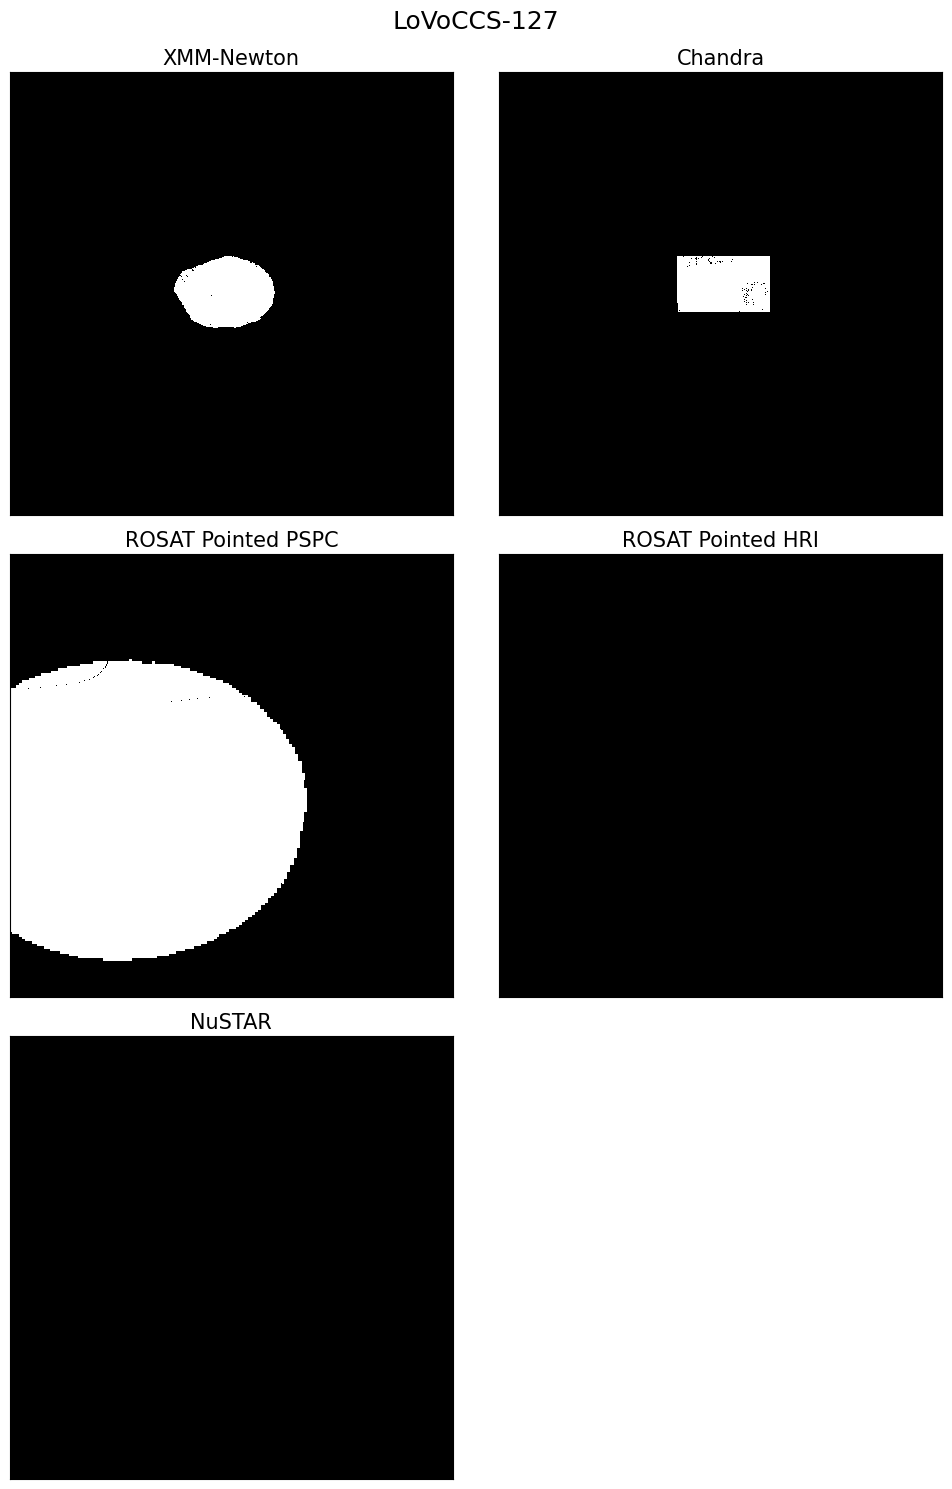

Generating coverage maps:  89%|████████▉ | 128/144 [06:37<00:24,  1.55s/it]

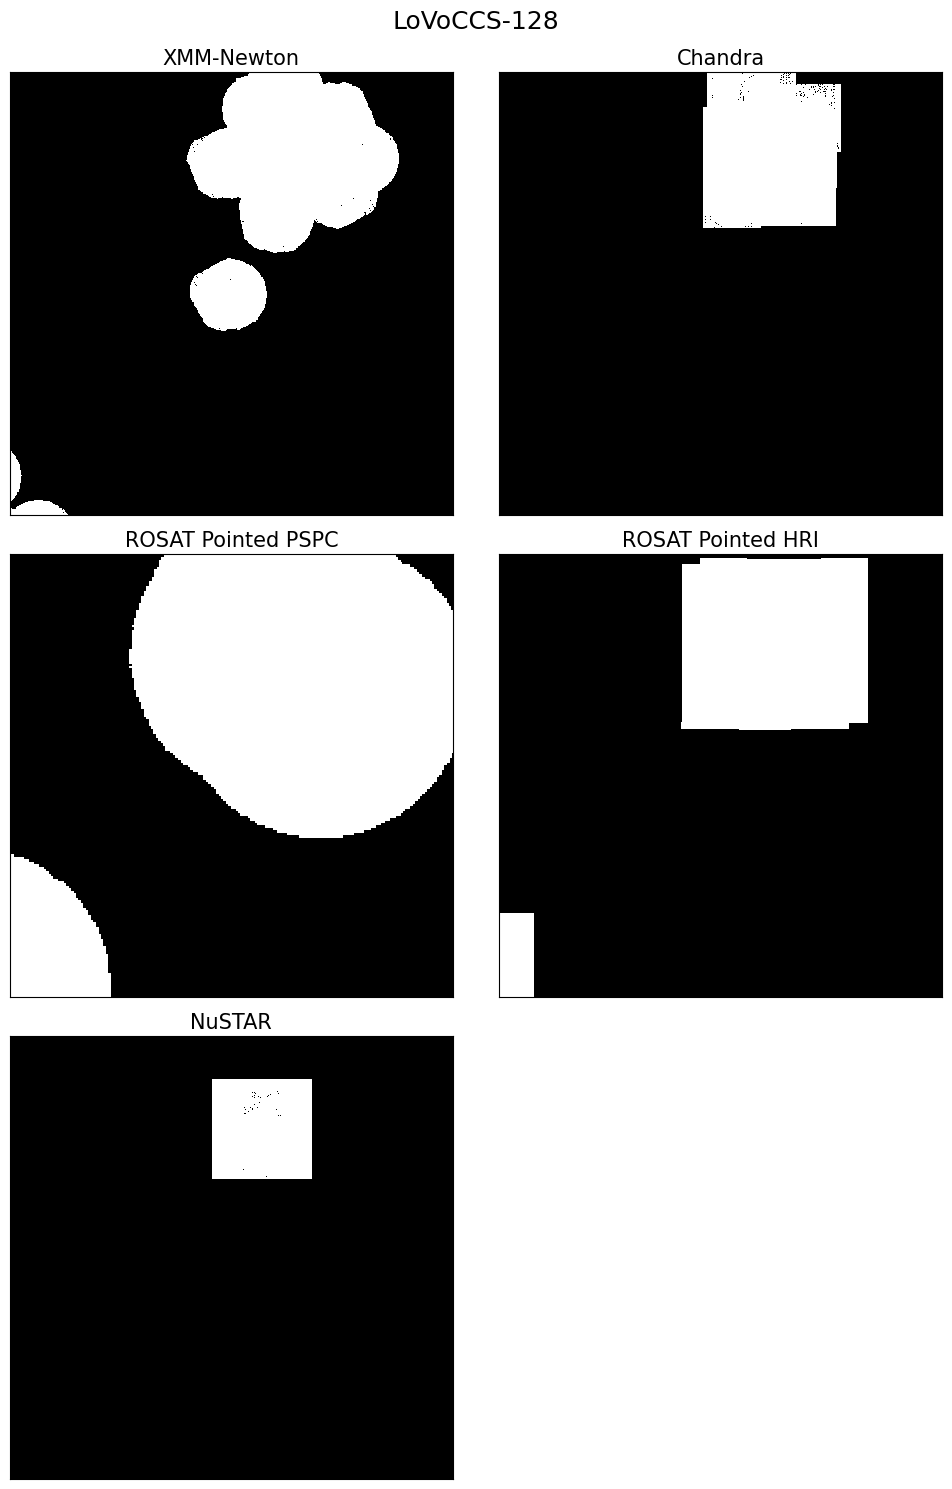

Generating coverage maps:  90%|████████▉ | 129/144 [06:45<00:51,  3.45s/it]

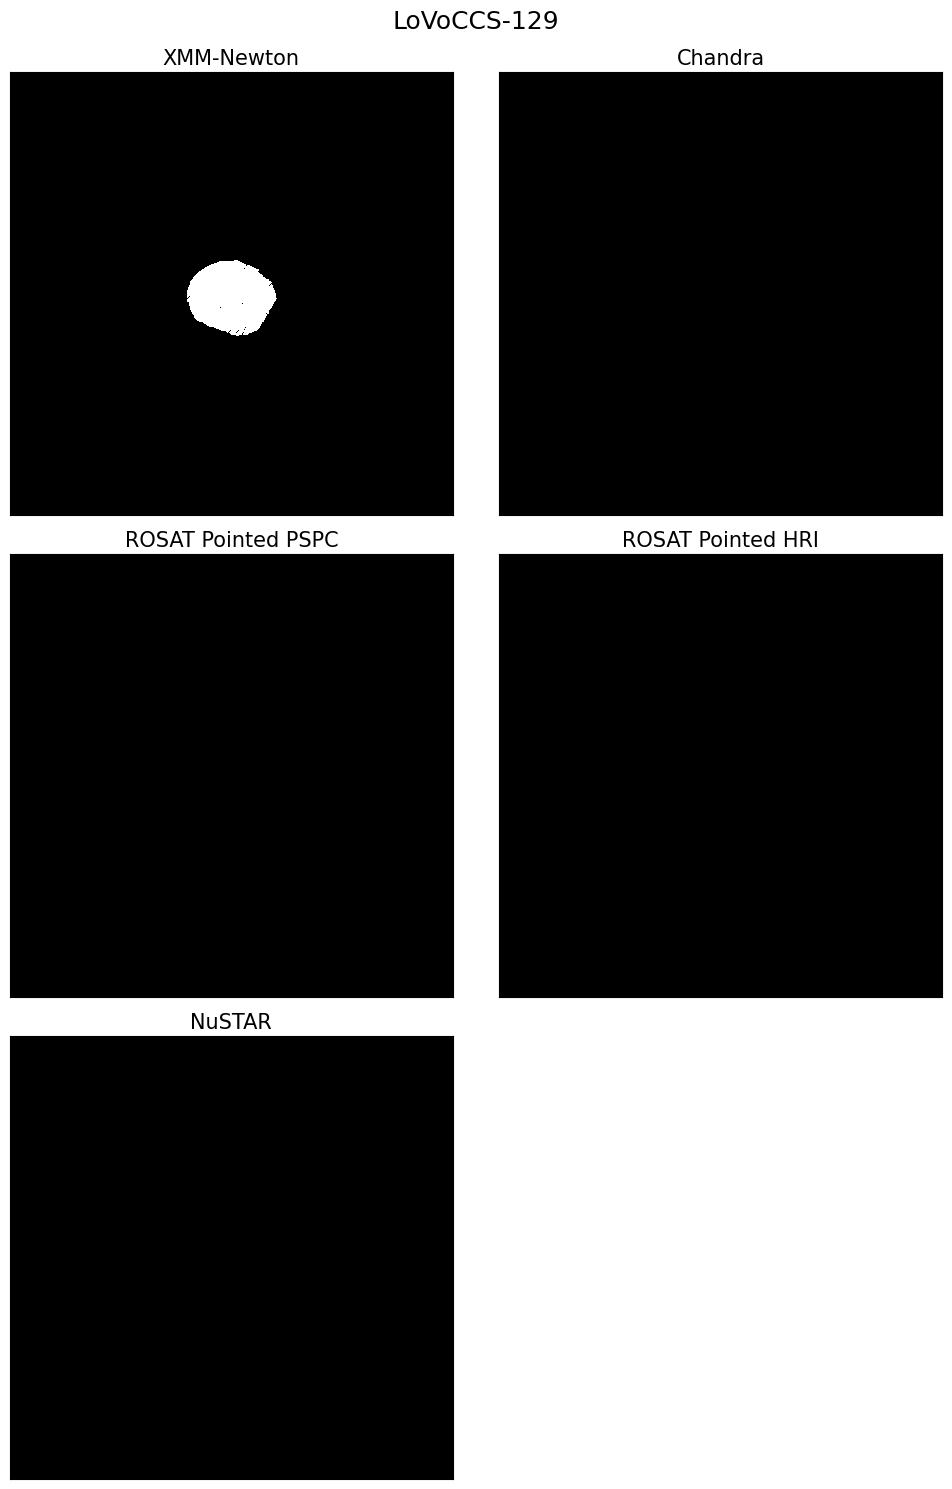

Generating coverage maps:  90%|█████████ | 130/144 [06:46<00:39,  2.80s/it]

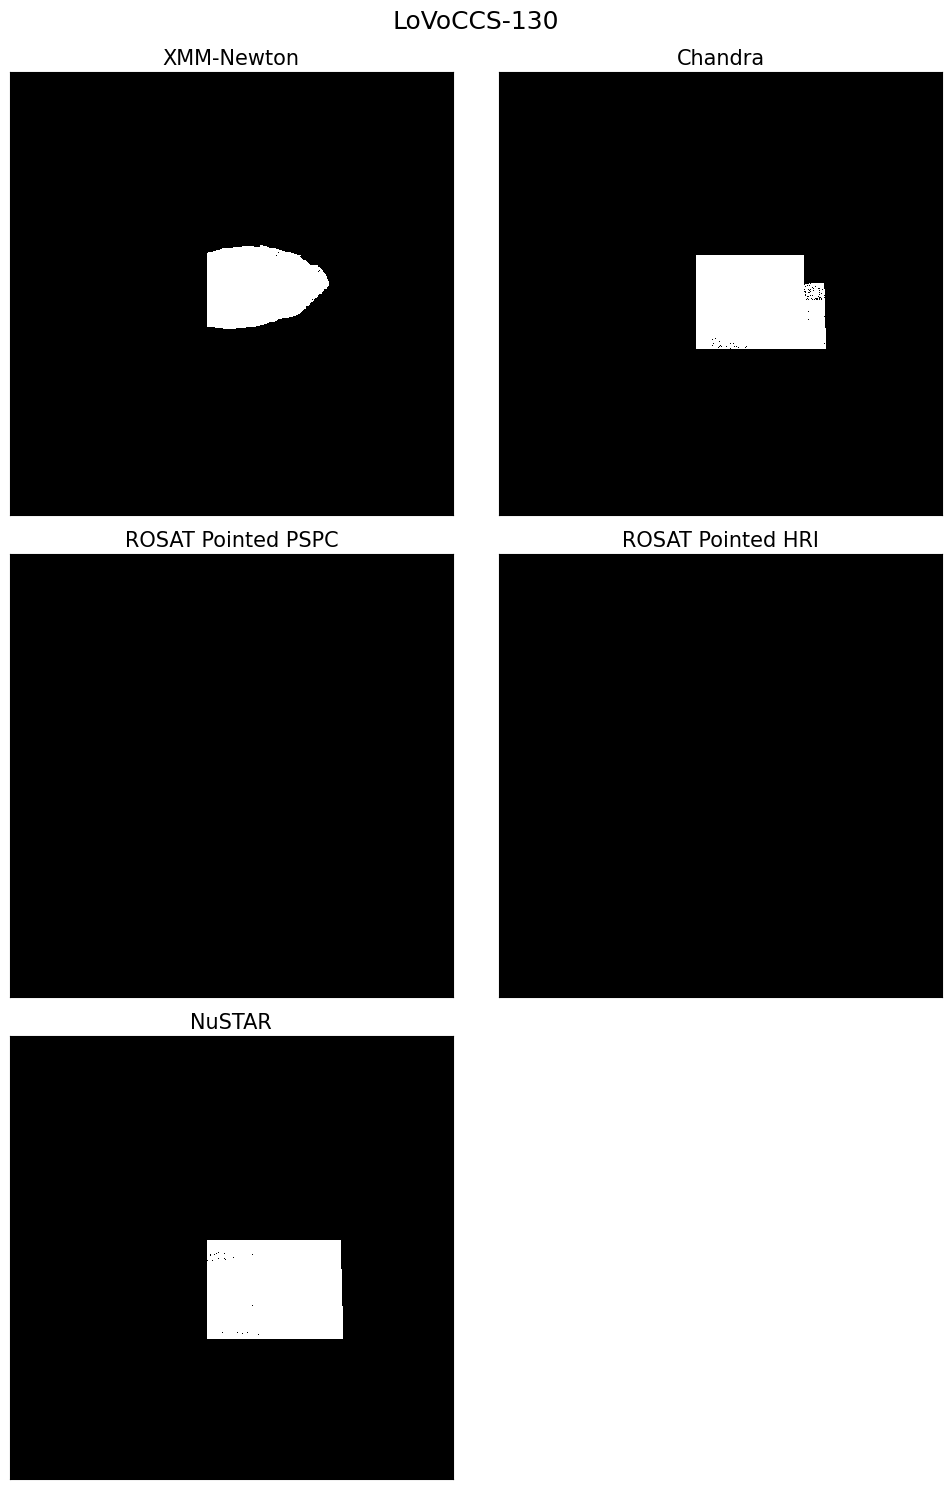

Generating coverage maps:  91%|█████████ | 131/144 [06:48<00:32,  2.53s/it]

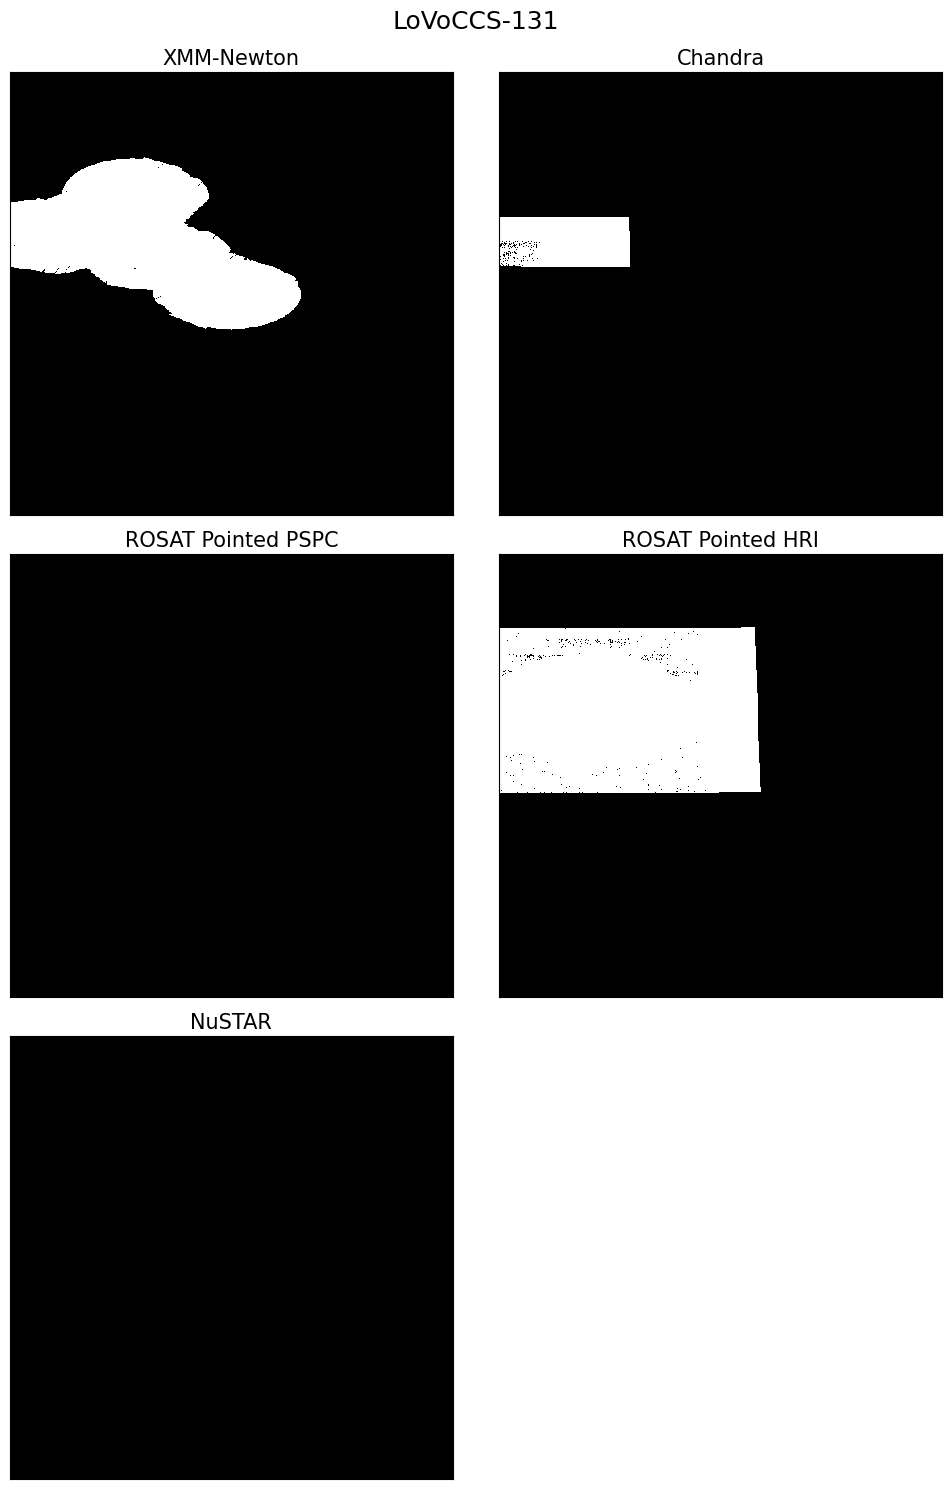

Generating coverage maps:  92%|█████████▏| 132/144 [06:51<00:31,  2.59s/it]

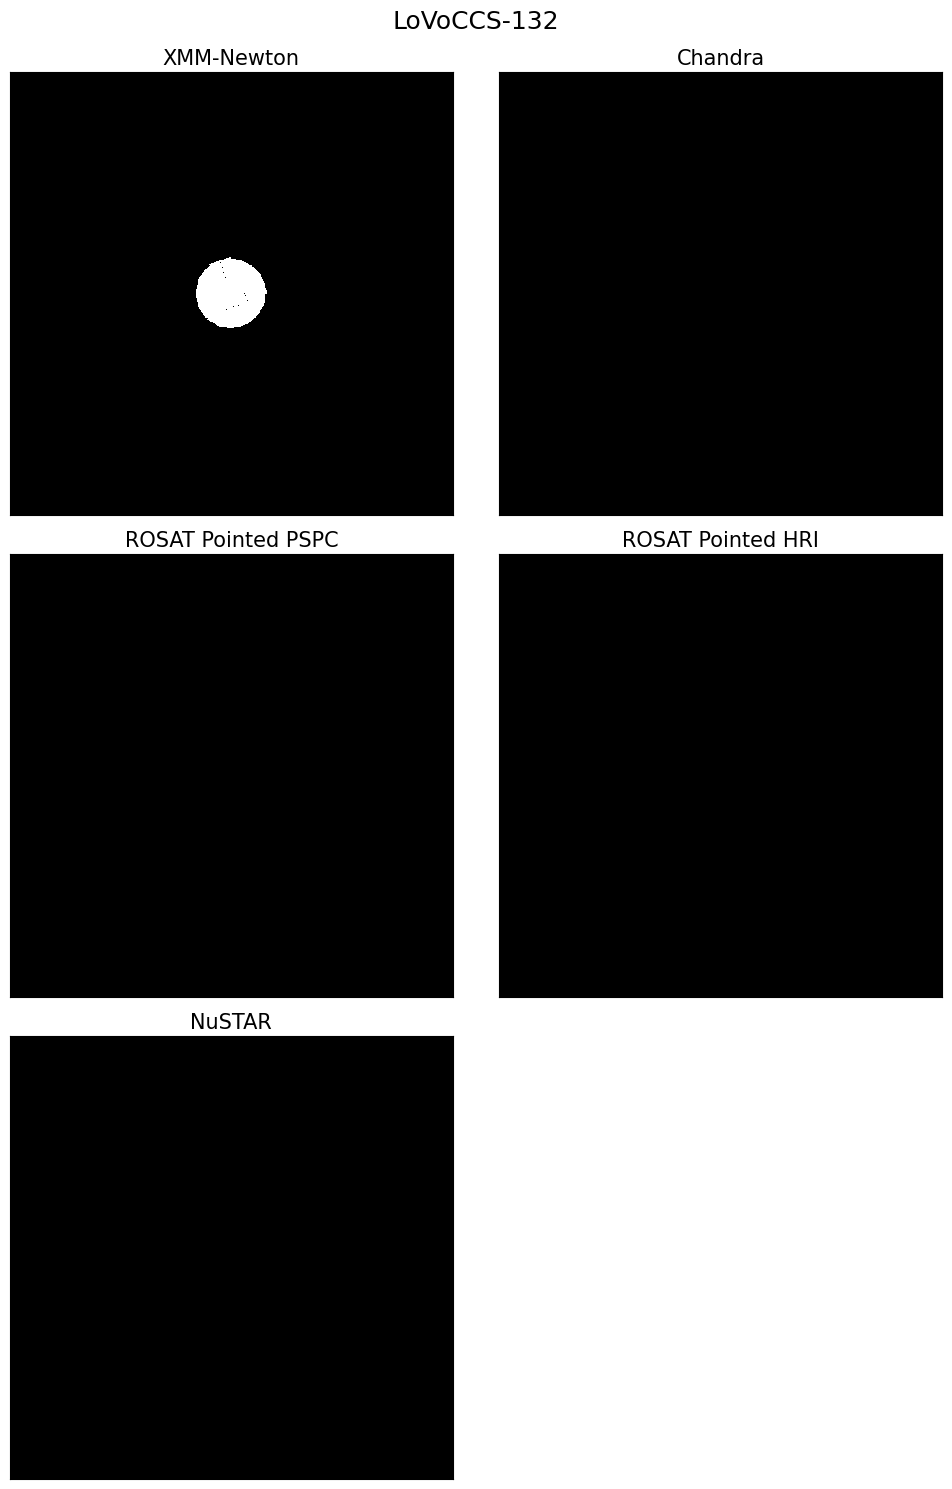

Generating coverage maps:  92%|█████████▏| 133/144 [06:52<00:24,  2.19s/it]

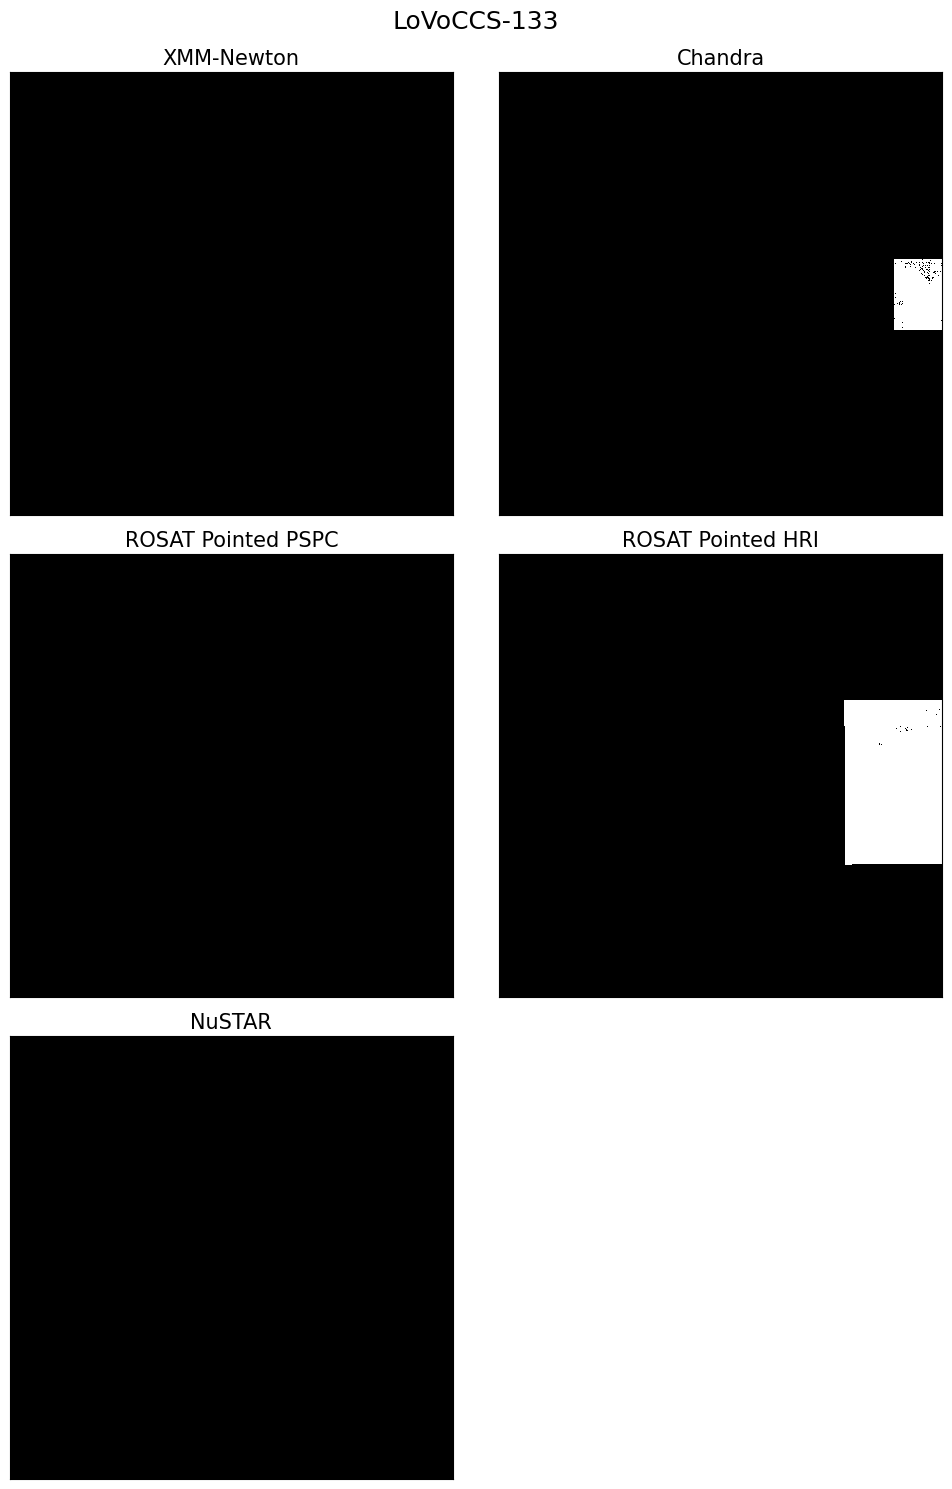

Generating coverage maps:  93%|█████████▎| 134/144 [06:53<00:19,  1.93s/it]

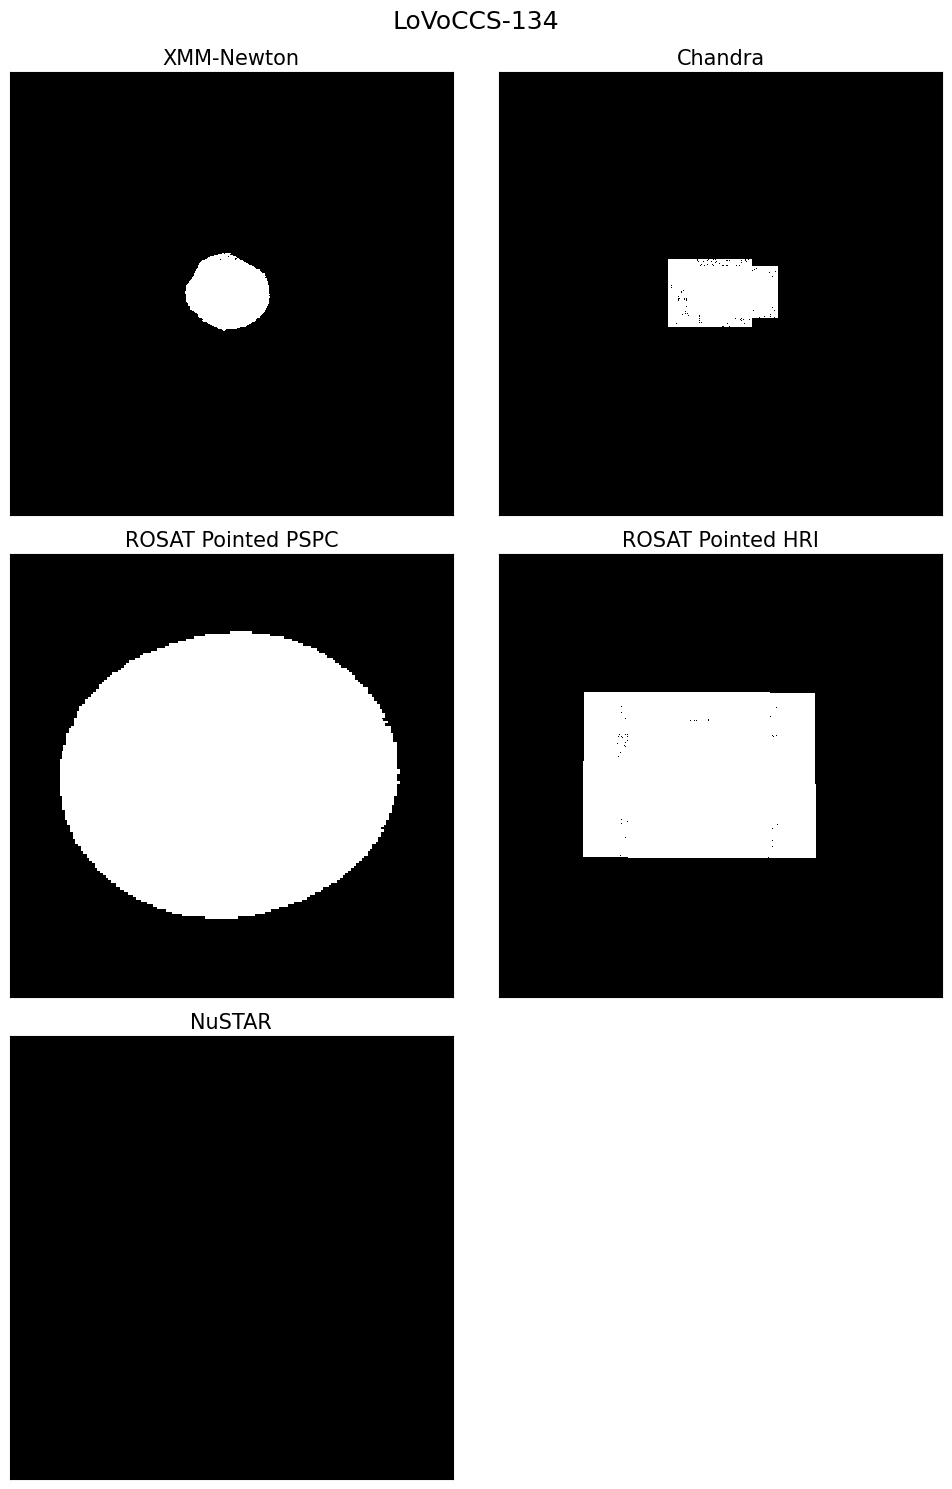

Generating coverage maps:  94%|█████████▍| 135/144 [06:55<00:16,  1.87s/it]

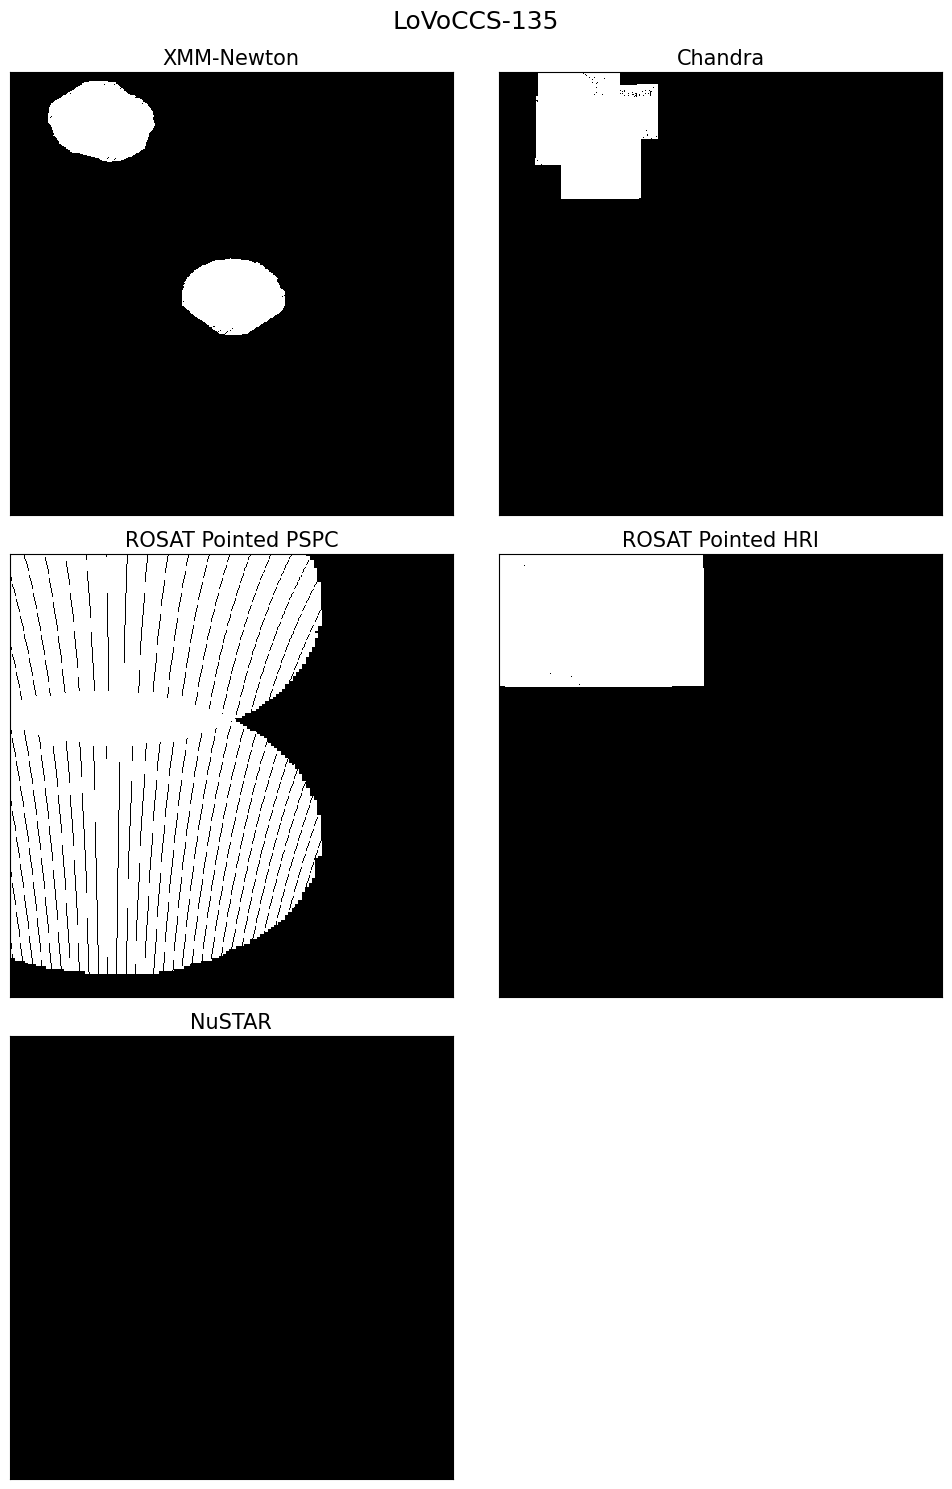

Generating coverage maps:  94%|█████████▍| 136/144 [06:57<00:16,  2.01s/it]

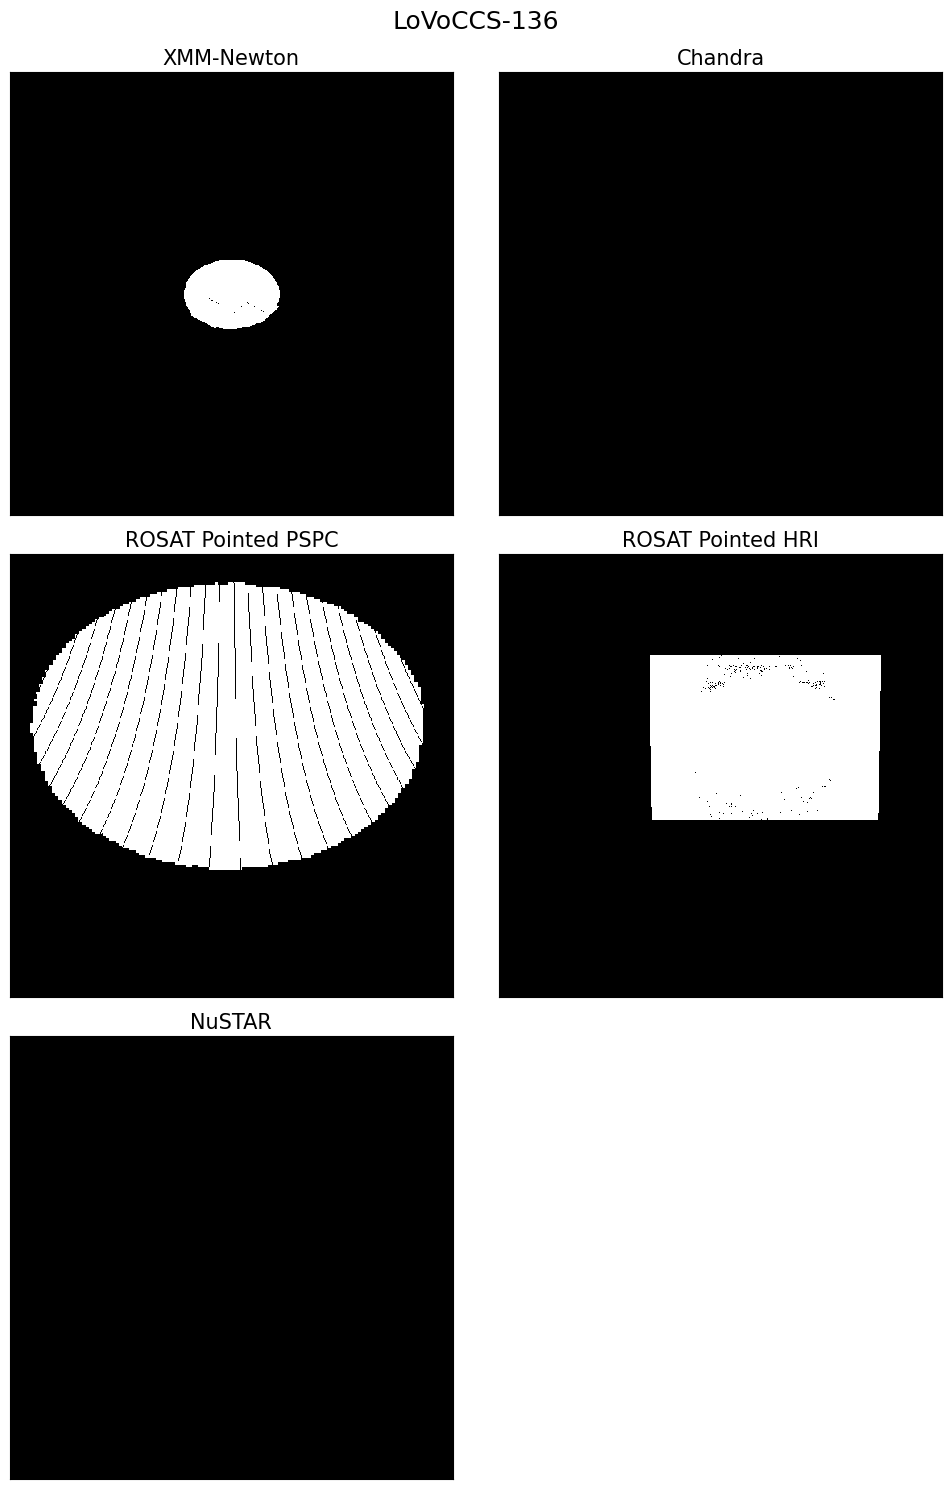

Generating coverage maps:  95%|█████████▌| 137/144 [06:59<00:12,  1.80s/it]

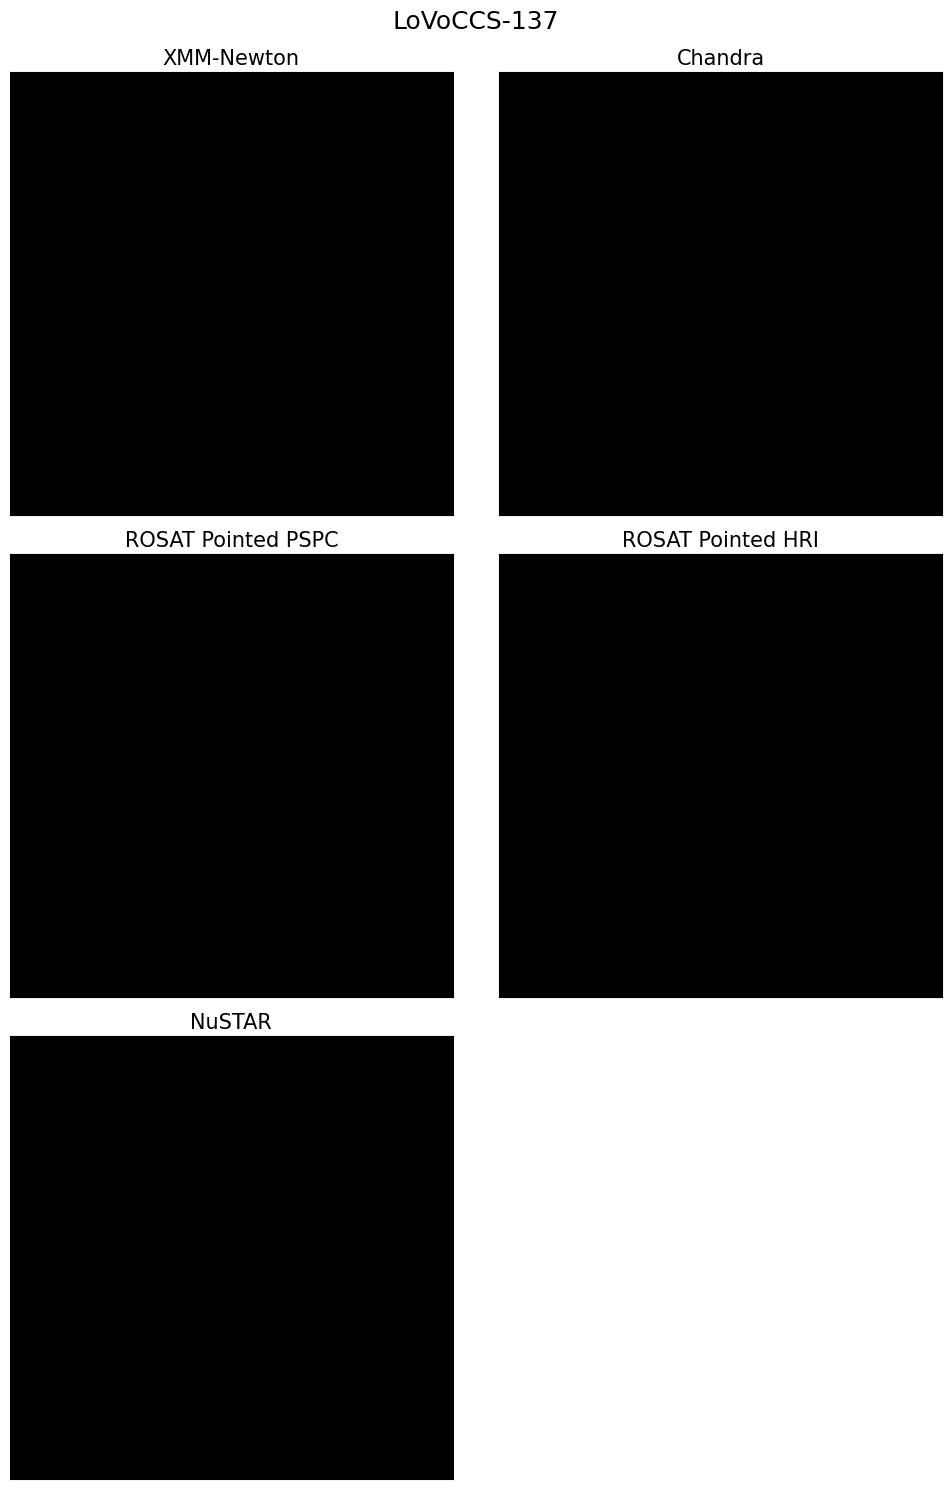

Generating coverage maps:  96%|█████████▌| 138/144 [07:00<00:09,  1.57s/it]

In [ ]:
rel_obs = {}

with tqdm(desc='Generating coverage maps', total=len(samp)) as onwards:
    for row_ind, row in samp.iterrows():
        lov_name = 'LoVoCCS-' + str(row['LoVoCCSID'])
        lov_pos = Quantity(row[['ra', 'dec']].values, 'deg')
        
        # We are gonna use this process to determine which observations are actually relevant (within whatever
        #  coordinate space we have defined for our clusters) 
        rel_obs[lov_name] = {}
        
        cur_wcs = coverage_maps[lov_name]['wcs']
        cur_arr = coverage_maps[lov_name]['arr']

        grid = np.meshgrid(np.arange(0, num_pix), np.arange(0, num_pix))
        pix_coords = Quantity(np.stack([grid[0].ravel(), grid[1].ravel()]).T, 'pix')

        deg_coords = Quantity(cur_wcs.all_pix2world(pix_coords, 0), 'deg')

        for miss_ind, miss_name in enumerate(det_maps):

            for det_map in det_maps[miss_name]:

                cen_pos = det_map.coord_conv(Quantity([det_map.shape[0]/2, det_map.shape[1]/2], 'pix'), 'deg')
                dist = np.sqrt(((cen_pos - lov_pos)**2).sum())

                if dist < Quantity(5, 'deg'):

                    det_map_pix_coords = det_map.radec_wcs.all_world2pix(deg_coords, 0).round(0).astype(int)
                    if not np.isnan(det_map_pix_coords).all():

                        non_null_pos = np.where((det_map_pix_coords[:, 0] < det_map.shape[1]) & 
                                                (det_map_pix_coords[:, 0] >= 0) & 
                                                (det_map_pix_coords[:, 1] < det_map.shape[0]) & 
                                                (det_map_pix_coords[:, 1] >= 0))[0]
                        if len(non_null_pos) != 0:
                            if miss_name not in rel_obs[lov_name]:
                                rel_obs[lov_name][miss_name] = [det_map.obs_id]
                            elif det_map.obs_id not in rel_obs[lov_name][miss_name]:
                                rel_obs[lov_name][miss_name].append(det_map.obs_id)
                            
                            sel_coords = Quantity(det_map_pix_coords[non_null_pos, :], 'pix').round(0).astype(int)
                            sel_coords_val = det_map.data[sel_coords[:, 1], sel_coords[:, 0]]
                            with_dat_subset_coords = np.where(sel_coords_val != 0)[0]
                            with_dat_detmap_pix_coords = det_map_pix_coords[non_null_pos[with_dat_subset_coords], :]


                            with_dat_detmap_radec_coords = det_map.coord_conv(Quantity(with_dat_detmap_pix_coords, 
                                                                                       'pix'), 'deg')
                            cov_map_pix_coords = cur_wcs.all_world2pix(with_dat_detmap_radec_coords.value, 
                                                                       0).round(0).astype(int)

                            legal_cov_map_pix = np.where((cov_map_pix_coords[:, 0] < num_pix) & 
                                                    (cov_map_pix_coords[:, 0] >= 0) & 
                                                    (cov_map_pix_coords[:, 1] < num_pix) & 
                                                    (cov_map_pix_coords[:, 1] >= 0))[0]
                            cov_map_pix_coords = cov_map_pix_coords[legal_cov_map_pix, :]

                            cur_arr[cov_map_pix_coords[:, 1], cov_map_pix_coords[:, 0], miss_ind] = 1

        fig, ax_arr = plt.subplots(3, 2, figsize=(10, 15))
        plt.suptitle(lov_name, fontsize=18, y=0.99)

        cnt = 0
        for ax_ind, ax in np.ndenumerate(ax_arr):
            if cnt < num_miss:
                ax.tick_params(which='both', left=False, bottom=False)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(pretty_names[list(det_maps.keys())[cnt]], fontsize=15)

                ax.imshow(cur_arr[:, :, cnt], origin='lower', interpolation='none', cmap='binary_r')
                cnt += 1
            else:
                ax.set_visible(False)

        plt.tight_layout()
        plt.savefig(out_dir + lov_name + "_{n}pix_{s}arcsec.png".format(n=num_pix, s=str(cdelt.to('arcsec').value)))
        plt.show()
        
        onwards.update(1)

In [ ]:
rel_obs